# Imports e inicializações

In [2]:
import os

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from operator import itemgetter
import re

import glob

from pyhive import hive

##Classe com vários métodos de pre-processamento de texto em português criado pelo grupo F03
import utils.preprocessing_portuguese as preprossPT

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset, DataLoader

import xgboost as xgb

import time
import multiprocessing as mp

from wordcloud import WordCloud

from tqdm.notebook import tqdm

import itertools

In [3]:
path_data = "/dados01/workspace/ufmg.f01dcc/m03/business_understanding/data/"

path_res = "/dados01/workspace/ufmg.f01dcc/m03/business_understanding/data/resultados_classificacao/"

#13 classes
path_classes_doc = "/dados01/workspace/ufmg.f01dcc/m03/business_understanding/notebooks/resultado_m03_meta_classes_extraction/relacao_documentos_label_v2.csv"

#path_classes_doc = "/dados01/workspace/ufmg.f01dcc/m03/business_understanding/notebooks/resultado_m03_meta_classes_extraction/relacao_documentos_label_v3-400Edital.csv"


dir_cids = ["288-licitacoes-pirapetinga",
        "289-licitacoes-coqueiral",
       "290-licitacoes-cristais",
       "302-licitacoes-olaria",
       "304-licitacoes-passa-vinte",
       "306-licitacoes-arantina",
       "353-licitacoes-ijaci",
       "381-licitacoes-sao-bento-abade",
       "385-licitacoes-ribeirao-vermelho",
       "351-licitacoes-itamarati/licitacoes_itamarati_2017",
       "351-licitacoes-itamarati/licitacoes_itamarati_2018",
       "351-licitacoes-itamarati/licitacoes_itamarati_2019",
       "351-licitacoes-itamarati/licitacoes_itamarati_2020"
       ]


stop_words = ["municipal", "mg", "minas", "prefeitura", "pirapetinga", "ijaci", "itamarati", "itamarati de minas", "cristais", "olaria", 
              "passa-vinte", "arantina", "ribeirao vermelho", "sao bento abade", "coqueiral", "estabelecimentolicitante", "gerais", "rc", "tc", "hr", "rx"]

df_itens = pd.read_csv('/dados01/workspace/ufmg.f01dcc/m03/business_understanding/notebooks/resultado_m03_meta_classes_extraction/sicom_20210109_licitacao_item_202109091726.csv')

list_itens = df_itens["dsc_item_raw"].to_list()

#print(list_itens[0])


In [4]:
def limpeza_texto(page_text, city_name):
    txt_process = preprossPT.TextPreProcessing()
    city_name = city_name.replace("_", " ")
    
    page_text = txt_process.remove_person_names(page_text)
    
    page_text = page_text.lower()
    
    page_text = txt_process.remove_emails(page_text)

    page_text = txt_process.remove_urls(page_text)
    
    page_text = txt_process.remove_pronouns(page_text)

    page_text = txt_process.remove_adverbs(page_text)

    page_text = txt_process.remove_special_characters(page_text)

    page_text = txt_process.remove_accents(page_text)

    page_text = txt_process.remove_stopwords(page_text)

    page_text = txt_process.remove_hour(page_text)
    # split numbers from letters
    page_text = ' '.join(re.split('(\d+)',page_text))

    page_text = txt_process.remove_symbols_from_numbers(page_text)

    page_text = txt_process.remove_numbers(page_text)

    page_text = txt_process.remove_reduced_or_contracted_words(page_text)
    
    #Removendo letras sozinhas no texto
    #page_text = re.sub(r'(?:^| )\w(?:$| )', ' ', page_text).strip()
    page_text = re.sub(r"\b[a-zA-Z]\b", "", page_text)

    page_text = page_text.replace("_","")
    
    # remove nome do municipio e estado
    page_text = page_text.replace(city_name,"")
    
    page_text = page_text.replace('minas gerais',"")    
    page_text = page_text.replace('prefeitura municipal',"")
    page_text = page_text.replace('prefeitura',"")
    
    page_text = txt_process.remove_excessive_spaces(page_text)
    
    return page_text

In [5]:
def get_name(directory):
    return re.search("licitacoes-(.*)/", directory)[1].replace("-", "_")

def list_json_files_dir(city_dir, city_name):
    if city_name != 'itamarati':
        return glob.glob(os.path.join(city_dir, 'data', 'files_json', '*'))
    else:
        return glob.glob(os.path.join(city_dir, '*', 'data', 'files_json', '*'))

def read_files(file_dir):
    with open(file_dir) as f:
        lines = f.read() # lê o conteúdo (pode ser lido em um stream, se achar necessário)
        return json.loads(lines)
    
def preprocess_text(document, num_pages, city_name):
    return [limpeza_texto(page_content, city_name) for page_content in document['text_content'][:4]]

def merge_pages(document, num_pages):
    # retorna lista onde a cada posicao uma nova pagina e concatenada ao texto
    num_pages+=1
    return [" ".join(document['text_preprocessed'][0:num_pages]) for num_pages in range(1,num_pages)]

In [6]:
base_path = "../data/*licitacoes*/"
cities_dir = glob.glob(base_path)
num_pages = 4

def read_data():
    cities_docs = {}
    df_document_content = pd.DataFrame(columns=['doc_id', 'city', 'file_dir', 'one_page', 'two_pages', 'three_pages', 'four_pages'])

    for city_dir in cities_dir:
        city_name = get_name(city_dir)
        if city_name == "bh":
            continue
        print("-"*100)
        print(city_name)
        # Lista os arquivos a serem lidos
        files_dir = list_json_files_dir(city_dir, city_name)
        # Faz a leitura dos arquivos
        for file_dir in tqdm(files_dir):
            document = read_files(file_dir)
            # Verifica se foi possível extrair texto do documento
            if document['status'] == 'SUCCESS':
                # preprocessamento
                document['text_preprocessed'] = preprocess_text(document, num_pages, city_name)
                # gera variacoes do texto concatenando 1 a num_pages páginas
                page_content = merge_pages(document, num_pages)
                # gera linha a ser inserida no dataframe
                new_row = [document['file_id'], city_name, file_dir]
                new_row.extend(page_content)
                # insere nova linha no dataframe
                df_document_content.loc[len(df_document_content)] = new_row
    return df_document_content

In [7]:
def split_stratified_into_train_val_test(df_input, stratify_colname='label',
                                         frac_train=0.7, frac_val=0.2, frac_test=0.1,
                                         random_state=42):
    '''
    Source: https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''
    print(round(frac_train + frac_val + frac_test))
    if round(frac_train + frac_val + frac_test) != 1:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' %  (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test, y_train, y_val, y_test

In [8]:
def verificar_distribuicao_classes(df,nome_set):
    path = "/dados01/workspace/ufmg.f01dcc/m03/business_understanding/notebooks/resultado_m03_meta_classes_extraction/classes_analises/"
    plt.figure(figsize=(15, 6))
    
    #sns_plot = sns.barplot(x=df["label"], y=df_aux["level_0"], data=df_aux, palette=clrs, zorder=100, ci=None, order=df_aux.sort_values('level_0', ascending = True)["class"])
    
    g = sns.histplot(y = 'label', color='#66c3a6', data=df,shrink = 0.7, zorder=100)
    
    plt.ylabel("Classe", size=14)
    plt.xlabel("Quantidade", size=14)
    
    plt.grid(zorder=1)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.show()
    
    g = g.get_figure()
    g.savefig(path+"distribuicao_classe_"+nome_set+".png", dpi=250)


----------------------------------------------------------------------------------------------------
sao_bento_abade


  0%|          | 0/232 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
olaria


  0%|          | 0/42 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
coqueiral


  0%|          | 0/1528 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
cristais


  0%|          | 0/1736 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
passa_vinte


  0%|          | 0/395 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
arantina


  0%|          | 0/937 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
ijaci


  0%|          | 0/451 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
itamarati


  0%|          | 0/1110 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
ribeirao_vermelho


  0%|          | 0/684 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
pirapetinga


  0%|          | 0/1007 [00:00<?, ?it/s]

1


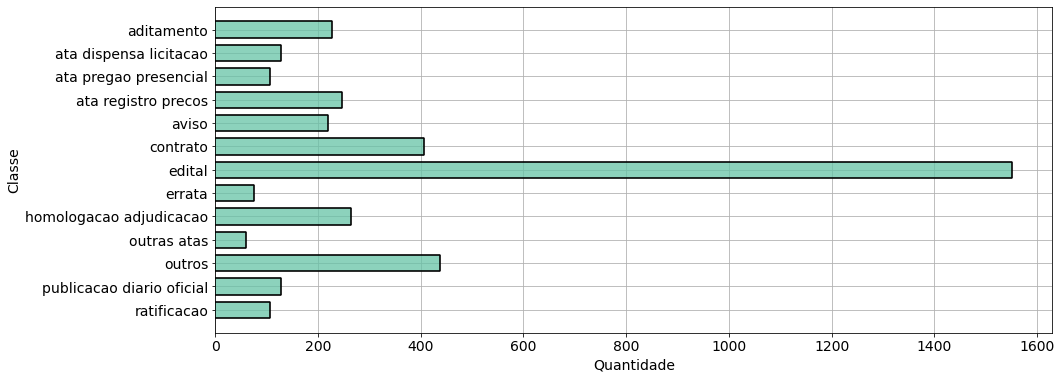

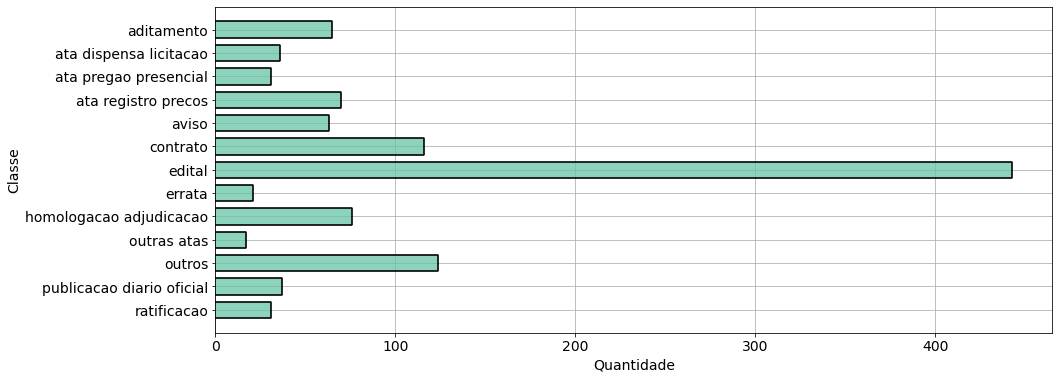

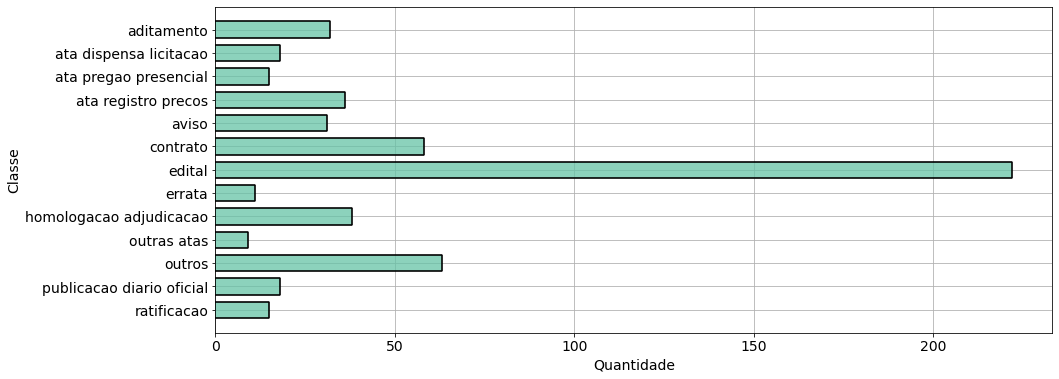

In [9]:
all_documents = read_data()

df_input = pd.read_csv(path_classes_doc) 

# Associação do conteúdo dos docs com o dataframe com as classes

df_data = pd.merge(left=df_input, right=all_documents, on='doc_id')






df_train, df_val, df_test, y_train, y_val, y_test = split_stratified_into_train_val_test(df_data, stratify_colname='label',
                                         frac_train=0.7, frac_val=0.2, frac_test=0.1,
                                         random_state=42)


#Undersampling em edital
verificar_distribuicao_classes(df_train.sort_values(by=['label']), "treino") #70%
verificar_distribuicao_classes(df_val.sort_values(by=['label']), "validacao") #20%
verificar_distribuicao_classes(df_test.sort_values(by=['label']), "teste") #10%

In [10]:
display(df_train.head)

display(y_train.head)

#print(all_documents[:3])




<bound method NDFrame.head of                                 doc_id final_meta-class  \
1699  5bf5d702f829271475a9f87225b406d8           EDITAL   
1745  d1f9837d06f4a1faa70839e98ae18a69           EDITAL   
2243  6bb8b4f8a1c70f5d0bf4e5865ba20c44           EDITAL   
5564  66d671824a796b9a00a7efcd3a622207           OUTROS   
2263  b4b4e29b93d4ee800893a0b6ec6889b9           EDITAL   
...                                ...              ...   
1174  138c0cb119cf9e4975d8d95e8ad5c98a           EDITAL   
3388  d9f244e5ca9451a372530e7b7fac7d60           OUTROS   
1580  92fe5ed66a006d14ed65fa78af500ddd           EDITAL   
3346  a52abf2fb7a518477aec468dfb3474af          HOMOLOG   
44    a3690274a25f792d50e1fde32f131117              ATA   

                        label               city  \
1699                   edital           arantina   
1745                   edital           arantina   
2243                   edital  ribeirao_vermelho   
5564                 contrato        pirapetinga   
2

<bound method NDFrame.head of                         label
1699                   edital
1745                   edital
2243                   edital
5564                 contrato
2263                   edital
...                       ...
1174                   edital
3388                   errata
1580                   edital
3346  homologacao adjudicacao
44     ata dispensa licitacao

[3957 rows x 1 columns]>

# Filtrar termos por IDF

In [11]:


def filter_data(document_text):
    document_text = document_text.split(" ")
    document_text = [term for term in document_text if term in idf_terms_to_keep]        
    return " ".join(document_text)


vectorizer = TfidfVectorizer()
# Calcula tfidf
vectorizer.fit(df_train['four_pages'].values)
# extrai idf
idf_values = vectorizer.idf_
idf_terms = vectorizer.get_feature_names()
# define termos a serem filtrados
index_idf_to_keep = np.nonzero(idf_values < 8)[0].tolist()
idf_values_to_keep = [idf_values[i] for i in index_idf_to_keep]
idf_terms_to_keep = [idf_terms[i] for i in index_idf_to_keep]

# Filtra termos
p = mp.Pool(mp.cpu_count()) # Data parallelism Object
t3 = time.time()
df_train['four_pages_processed'] = p.map(filter_data, df_train['four_pages'])
t4 = time.time()
print("time consuming after Parallel Processing to process the Dataset {0:.2f}s".format(round(t4-t3, 2)))
# Armazena base processada
#df_train.to_csv("lstm_data/preprocessed_data_v2.csv", index=False)






time consuming after Parallel Processing to process the Dataset 28.46s


/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:

#print(df_val.head())
print(df_train.shape)

print(y_train.shape)

#print(len(list_itens))
#print(list_itens[:4])

(3957, 10)
(3957, 1)


In [13]:
list_itens_clean = [item.split(" ") for item in list_itens] 

list_itens_clean = list(itertools.chain(*list_itens_clean))

#Remove itens duplicados
final_list_itens = list(dict.fromkeys(list_itens_clean))

print(len(final_list_itens))

2009328


In [14]:
##OLD VERSION
'''def compute_corpus(df):
    corpus_doc = []
    for doc in tqdm(df["four_pages_processed"]):
        corpus_aux = [''.join(page) for page in doc[:2]]
        corpus = ' '.join(corpus_aux)

        for stop_word in stop_words:
            corpus = corpus.lower().replace(stop_word, "") 
            
        #Remove itens
        for item in final_list_itens:
            corpus = corpus.lower().replace(item, "")
            
        
        
        corpus_doc.append(limpeza_texto(corpus))
        
    return corpus_doc
    
        

corpus_doc_train = compute_corpus(df_train)
corpus_doc_val = compute_corpus(df_val)
corpus_doc_test = compute_corpus(df_test)'''

'def compute_corpus(df):\n    corpus_doc = []\n    for doc in tqdm(df["four_pages_processed"]):\n        corpus_aux = [\'\'.join(page) for page in doc[:2]]\n        corpus = \' \'.join(corpus_aux)\n\n        for stop_word in stop_words:\n            corpus = corpus.lower().replace(stop_word, "") \n            \n        #Remove itens\n        for item in final_list_itens:\n            corpus = corpus.lower().replace(item, "")\n            \n        \n        \n        corpus_doc.append(limpeza_texto(corpus))\n        \n    return corpus_doc\n    \n        \n\ncorpus_doc_train = compute_corpus(df_train)\ncorpus_doc_val = compute_corpus(df_val)\ncorpus_doc_test = compute_corpus(df_test)'

In [15]:
##Filtra os 1000 primeiros termos de cada documento
#print(corpus_doc_train[:3])

# def tokenize(text):
#     words = [token for token in word_tokenize(text)]
#     words_doc = ' '.join(words[:1000])
#     return words_doc

# corpus_doc_train_aux = [tokenize(corpus) for corpus in corpus_doc_train]
#print(corpus_doc_train_aux[:3])
# corpus_doc_val_aux = [tokenize(corpus) for corpus in corpus_doc_val]
# corpus_doc_test_aux = [tokenize(corpus) for corpus in corpus_doc_test]

In [16]:
def tf_idf_data(corpus_doc, folder):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus_doc)
    
    print(">> X")
    #print(X)

    tf_idf_features = vectorizer.get_feature_names()
    
    #print(tf_idf_features)
    
    

    #print(type(tf_idf_features))
    
    ##Verificando palavras na nuvem de palavras

    dense = X.todense()
    lst1 = dense.tolist()

    df = pd.DataFrame(lst1, columns=tf_idf_features)

    df = df.T.sum(axis=1)

    #print(type(df))
    #print(df)

    #Reiniciando o ambiente de imagem
    '''plt.figure(figsize=(15, 6))
    
    wordcloud = WordCloud(background_color="white", max_words=400).generate_from_frequencies(df)

    # remove plot axes
    plt.axis("off")

    plt.imshow(wordcloud)'''


    df_aux = df.to_frame().rename(columns={'term':'tf-idf'}).reset_index()
    
    
    
    #print(X.toarray()[0])
    #print(len(tf_idf_features_filtrado))
    
    df_tfidf = pd.DataFrame(data=X.toarray(), columns=tf_idf_features)
    
    '''if folder == "train":
        tf_idf_features_filtrado = filtrar_idf(corpus_doc, df_aux)
        df_tfidf = df_tfidf.loc[:, df_tfidf.columns.isin(tf_idf_features_filtrado)]'''
    
    print(">> Matrix TF-IDF")
    print(df_tfidf.head())
    print(type(df_tfidf))


    return df_tfidf[sorted(df_tfidf.columns)]
    #return df_tfidf[:1000]

'''print(len(corpus_doc_train_aux))
corpus_doc_train = corpus_doc_train_aux
corpus_doc_val = corpus_doc_val_aux
corpus_doc_test = corpus_doc_test_aux'''
tf_idf_train = tf_idf_data(df_train["four_pages_processed"], "train")
tf_idf_val = tf_idf_data(df_val["four_pages"], "val")
tf_idf_test = tf_idf_data(df_test["four_pages"], "test")


>> X
>> Matrix TF-IDF
    aa  aaa  aaplicacaodaspenalidadescabiveis  aaquisicao  aar  aas  \
0  0.0  0.0                               0.0         0.0  0.0  0.0   
1  0.0  0.0                               0.0         0.0  0.0  0.0   
2  0.0  0.0                               0.0         0.0  0.0  0.0   
3  0.0  0.0                               0.0         0.0  0.0  0.0   
4  0.0  0.0                               0.0         0.0  0.0  0.0   

   aausenciadocredenciadoemqualquermomentodasessaopublica   ab  aba  abacate  \
0                                                0.0       0.0  0.0      0.0   
1                                                0.0       0.0  0.0      0.0   
2                                                0.0       0.0  0.0      0.0   
3                                                0.0       0.0  0.0      0.0   
4                                                0.0       0.0  0.0      0.0   

   ...  zincado  zinco  ziober  ziper  zoledronico  zona  zonas  zoya 

#TF-IDF 

# Use features and weights found at training stage

In [17]:
#print(tf_idf_train)


tf_idf_val_in_train = tf_idf_val.loc[:, tf_idf_val.columns.isin(tf_idf_train.columns)]

print(tf_idf_val.loc[:, ~tf_idf_val.columns.isin(tf_idf_train.columns)].columns)

tf_idf_train_not_val = tf_idf_train.loc[:, ~tf_idf_train.columns.isin(tf_idf_val.columns)].columns

df_add = pd.DataFrame(np.zeros((tf_idf_val_in_train.shape[0], len(tf_idf_train_not_val))), columns=tf_idf_train_not_val)

tf_idf_val_final = pd.concat([tf_idf_val_in_train,df_add], axis=1)

#tf_idf_val = pd.concat([tf_idf_val_in_train, tf_idf_train_not_val], axis=1)


tf_idf_test_in_train = tf_idf_test.loc[:, tf_idf_test.columns.isin(tf_idf_train.columns)]

print(tf_idf_test.loc[:, ~tf_idf_test.columns.isin(tf_idf_train.columns)].columns)

tf_idf_train_not_test = tf_idf_train.loc[:, ~tf_idf_train.columns.isin(tf_idf_test.columns)].columns

df_add_test = pd.DataFrame(np.zeros((tf_idf_test_in_train.shape[0], len(tf_idf_train_not_test))), columns=tf_idf_train_not_test)

tf_idf_test_final = pd.concat([tf_idf_test_in_train,df_add_test], axis=1)


print(tf_idf_train.shape)
print(tf_idf_val_final.shape)
print(tf_idf_test_final.shape)


#print(y_train)

'''print(tf_idf_features_test)

print("Diferença entre: validação e treino: ", list(set(tf_idf_features_val["index"]) - set(tf_idf_features_train["index"])))
print("Diferença entre teste e treino: ", list(set(tf_idf_features_test["index"]) - set(tf_idf_features_train["index"])))

print(tf_idf_features_val.shape)'''


Index(['aabad', 'aad', 'aaddom', 'aaea', 'aaeca', 'aai', 'aal', 'aalt', 'aan',
       'aanac',
       ...
       'zigbee', 'zirico', 'zoeb', 'zolpidem', 'zone', 'zonne', 'zoom',
       'zumgiram', 'zvais', 'zveanlotor'],
      dtype='object', length=5744)
Index(['abastecido', 'abrido', 'abstivesse', 'acabada', 'accu', 'acebrofilina',
       'aceitou', 'acelerada', 'acertos', 'acetinado',
       ...
       'ype', 'zago', 'zelo', 'zesiana', 'zica', 'ziriguidun', 'zm',
       'zolpidem', 'zoneamento', 'zoysia'],
      dtype='object', length=2525)
(3957, 13182)
(1130, 13182)
(566, 13182)


'print(tf_idf_features_test)\n\nprint("Diferença entre: validação e treino: ", list(set(tf_idf_features_val["index"]) - set(tf_idf_features_train["index"])))\nprint("Diferença entre teste e treino: ", list(set(tf_idf_features_test["index"]) - set(tf_idf_features_train["index"])))\n\nprint(tf_idf_features_val.shape)'

In [18]:
print(tf_idf_train.shape)
print(tf_idf_val_final.shape)
print(tf_idf_test_final.shape)

(3957, 13182)
(1130, 13182)
(566, 13182)


# Avaliações

In [20]:
class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [21]:


train_ds = ReviewsDataset(tf_idf_train, y_train.values.ravel())
val_ds = ReviewsDataset(tf_idf_val_final, y_val)
test_ds = ReviewsDataset(tf_idf_test_final, y_test)

print(train_ds)

In [22]:
def confunsion_matrix_chart(y_true_str, y_pred_str, fold, eval_type, normalize):
    
    class_labels = list(set(itertools.chain(y_true_str["label"], y_pred_str)))
    cm = confusion_matrix(y_true_str["label"], y_pred_str, normalize="true", labels=class_labels)
    df_cm = pd.DataFrame(cm, columns=class_labels, index=class_labels)
    df_cm.index.name = 'Classe Verdadeira'
    df_cm.columns.name = 'Classe Estimada'
    
    plt.figure(figsize = (15,10))
    plt.title(f'Matriz de Confusão Normalizada - {eval_type} ({fold})', fontsize = 20) if normalize=='true' else  plt.title(f'Matriz de Confusão - {eval_type} ({fold})', fontsize = 20)
    sns_plot = sns.heatmap(df_cm, cmap='flare', annot=True, annot_kws={"size": 16}, linewidths=.5, fmt='.2f')
    sns_plot.set_xlabel('Classe Predita', fontsize = 15) # x-axis label with fontsize 15
    sns_plot.set_ylabel('Classe Verdadeira', fontsize = 15) # y-axis label with fontsize 15
    plt.show()

#     sns_plot = sns_plot.get_figure()
#     sns_plot.savefig(path_res+eval_type+fold+".png", dpi=150)

In [23]:
def evaluation_models(y_true, y_pred, fold='', eval_type='Completo', normalize='true'):
    print('=' * 80)
    print(f"{fold}:")
    print('_' * 80)
    print("F1_score macro:", f1_score(y_true, y_pred, average='macro'))
    print("F1_score weighted:", f1_score(y_true, y_pred, average='weighted'))
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print('_' * 80)
    
    confunsion_matrix_chart(y_true, y_pred, fold, eval_type, normalize)    

# Classificação com o modelo Naive Bayes 

In [24]:
#3 Feature selection techniques

#Feature selection 
#selector = SelectPercentile(f_classif, percentile=10)
#Univariate Selection
selector = SelectPercentile(chi2, percentile=20)
selector.fit(tf_idf_train, y_train.values.ravel())

features_train = selector.transform(tf_idf_train)#.toarray()
print(features_train.shape)
features_val = selector.transform(tf_idf_val_final)#.toarray()
features_test = selector.transform(tf_idf_test_final)#.toarray()

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=15)#1412
selector = bestfeatures.fit(tf_idf_train, y_train.values.ravel())

features_train_KBest = selector.transform(tf_idf_train)#.toarray()
print(features_train.shape)
features_val_KBest = selector.transform(tf_idf_val_final)#.toarray()
features_test_KBest = selector.transform(tf_idf_test_final)

dfscores = pd.DataFrame(selector.scores_)
dfcolumns = pd.DataFrame(tf_idf_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(15,'Score'))  #print best features

#Feature importance
model = ExtraTreesClassifier()
model.fit(tf_idf_train, y_train.values.ravel())
print(model.feature_importances_)

(3957, 2636)
(3957, 2636)
             Specs       Score
255        aditivo  618.066628
3166           cpl  539.987907
251     aditamento  407.135883
9922    presidente  394.398026
4120        djalma  374.610666
1327         aviso  368.263889
10453  ratificacao  342.424185
9572            pm  334.151946
11041  retificacao  324.168960
1112           ata  321.222767
2266      clausula  302.996062
1958      carvalho  301.680770
10573    recomenda  300.997045
10036    procedida  295.328883
11074       reuniu  284.824928
[3.14425828e-06 1.16289183e-05 0.00000000e+00 ... 0.00000000e+00
 3.12892044e-05 5.56569857e-06]



 >> MultinomialNB - Sem feature selection

Train set score:  0.8498862774829417

Validation set score:  0.09646017699115045

Test set score:  0.09363957597173145

>> Avaliações - MultinomialNB
Treino - MultinomialNB:
________________________________________________________________________________
F1_score macro: 0.6940487282853097
F1_score weighted: 0.8279239592664414
Accuracy: 0.8498862774829417
________________________________________________________________________________


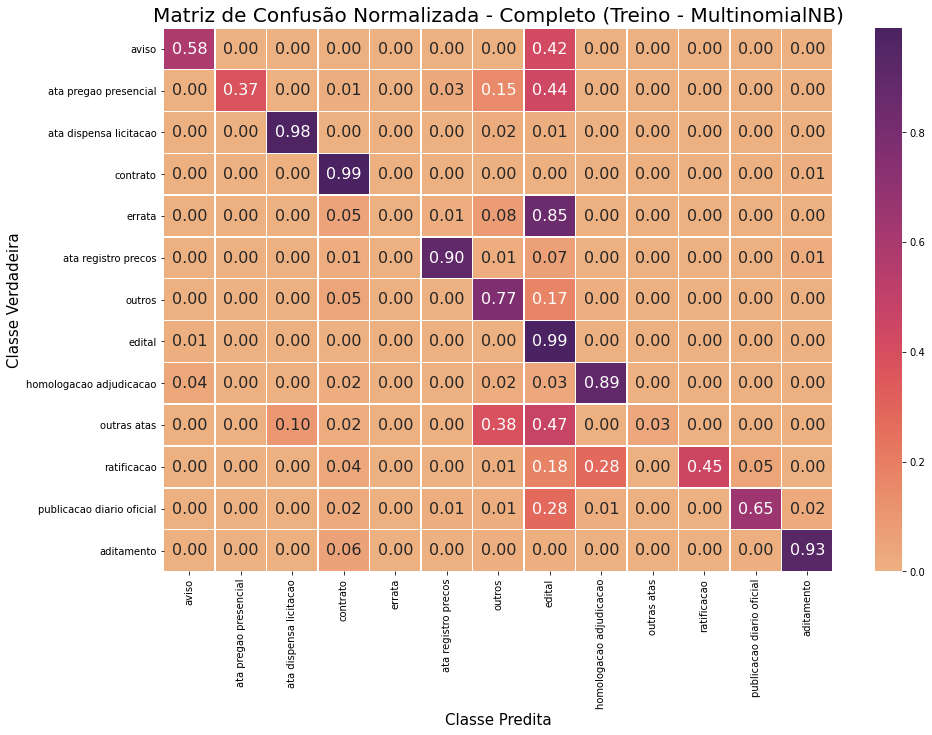

Validação - MultinomialNB:
________________________________________________________________________________
F1_score macro: 0.026039103870814866
F1_score weighted: 0.031227086113826893
Accuracy: 0.09646017699115045
________________________________________________________________________________


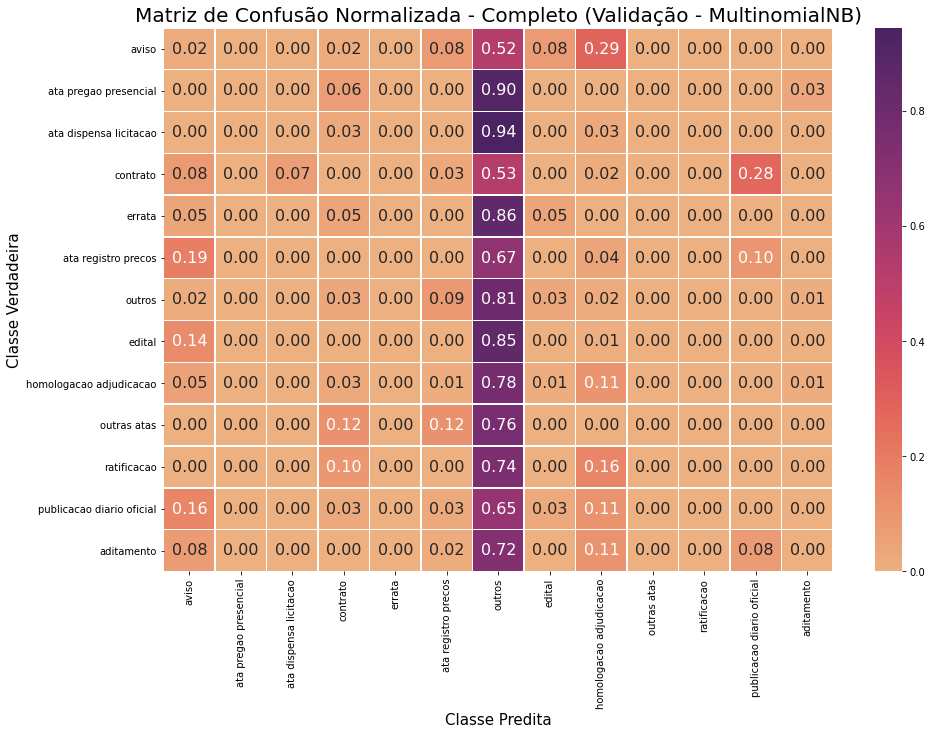

Teste - MultinomialNB:
________________________________________________________________________________
F1_score macro: 0.017598391194963307
F1_score weighted: 0.02326919424394524
Accuracy: 0.09363957597173145
________________________________________________________________________________


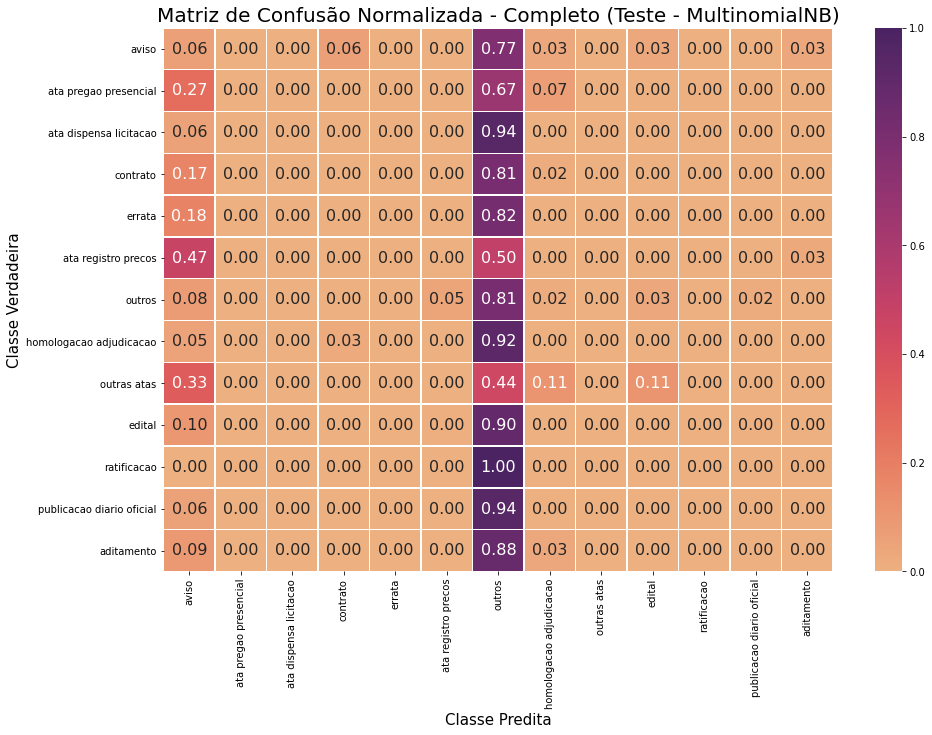


 >> GaussianNB - Sem feature selection

Train set score:  0.9909021986353298

Validation set score:  0.30973451327433627

Test set score:  0.30918727915194344

>> Avaliações - GaussianNB
Treino - GaussianNB:
________________________________________________________________________________
F1_score macro: 0.9854438115907249
F1_score weighted: 0.9911460087195888
Accuracy: 0.9909021986353298
________________________________________________________________________________


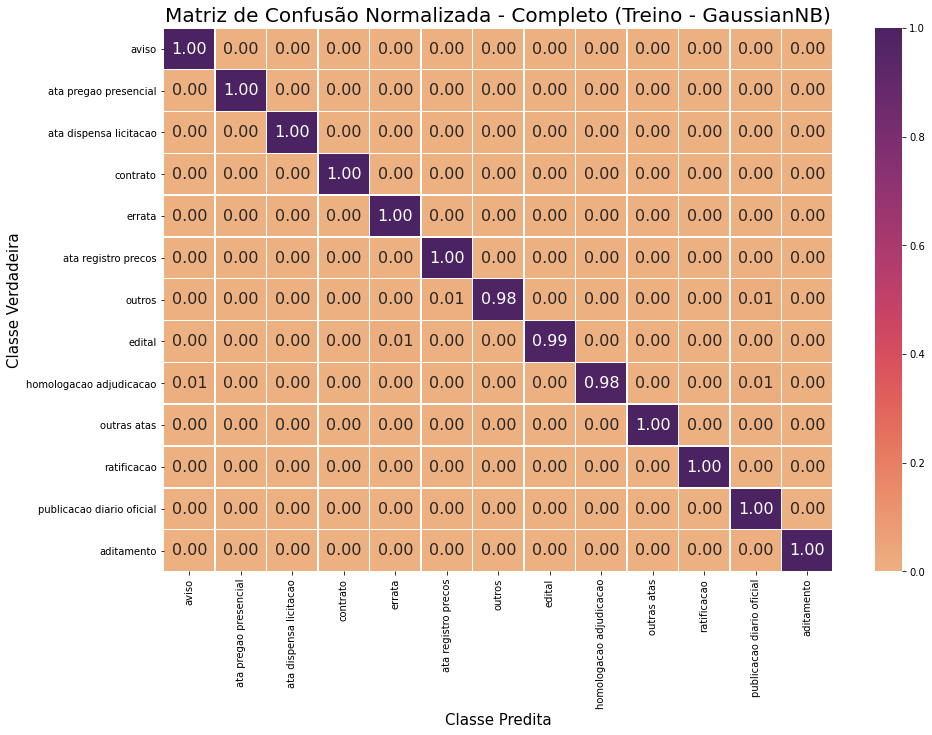

Validação - GaussianNB:
________________________________________________________________________________
F1_score macro: 0.07327520812604225
F1_score weighted: 0.24233169171376628
Accuracy: 0.30973451327433627
________________________________________________________________________________


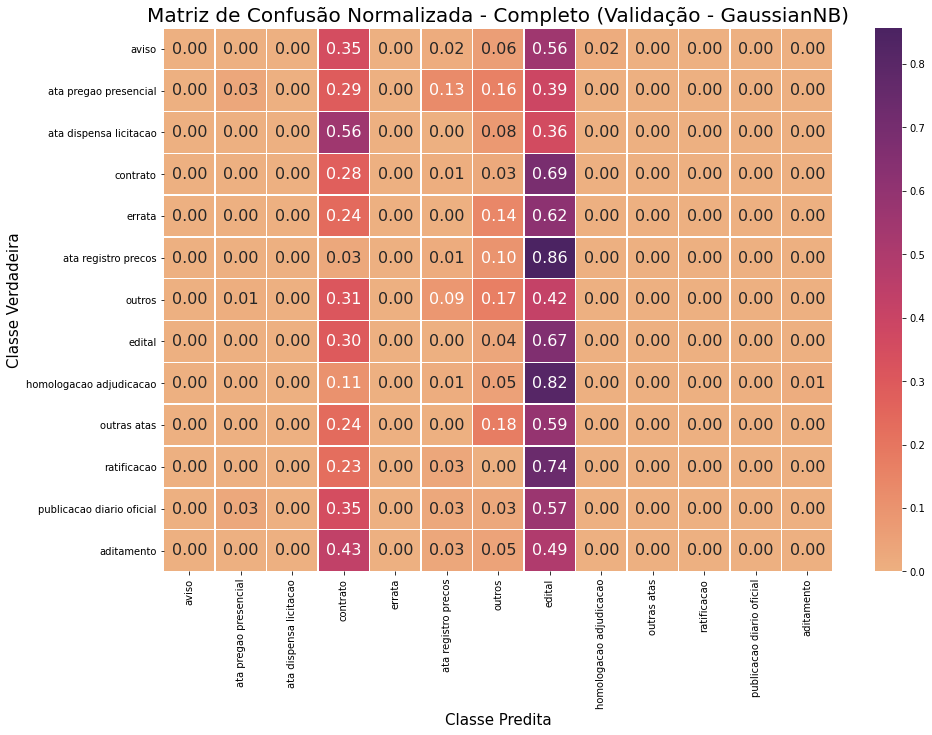

Teste - GaussianNB:
________________________________________________________________________________
F1_score macro: 0.06785379254891451
F1_score weighted: 0.2370349109220522
Accuracy: 0.30918727915194344
________________________________________________________________________________


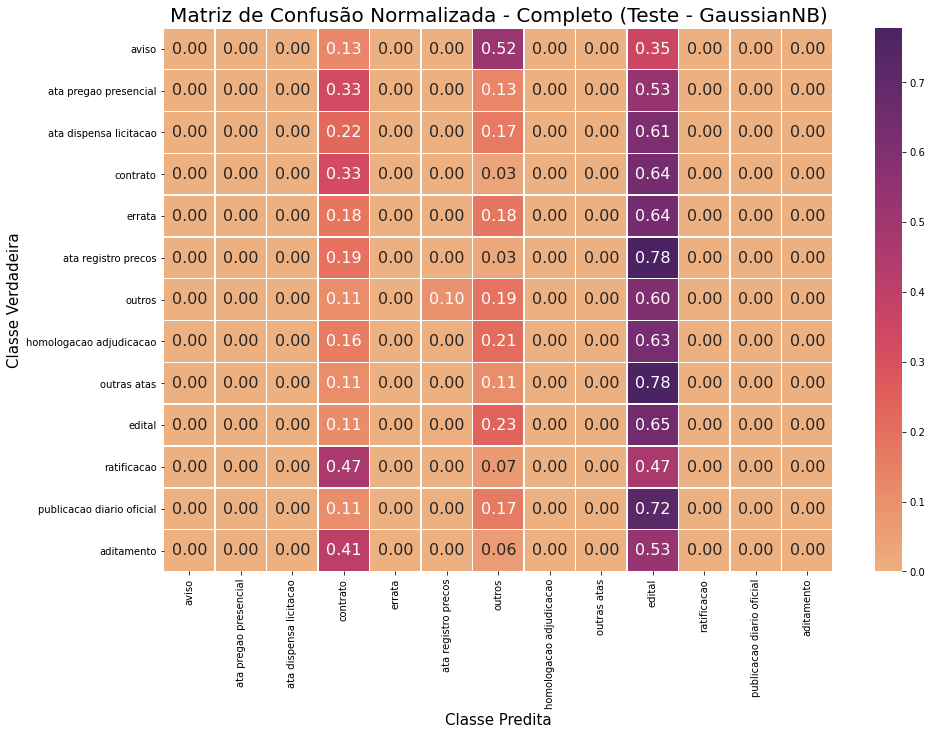


 >> MultinomialNB - Com feature selection

Train set score:  0.9057366691938337

Validation set score:  0.048672566371681415

Test set score:  0.04063604240282685

>> Avaliações - MultinomialNB
Treino - MultinomialNB:
________________________________________________________________________________
F1_score macro: 0.8045571679731538
F1_score weighted: 0.8936955328430358
Accuracy: 0.9057366691938337
________________________________________________________________________________


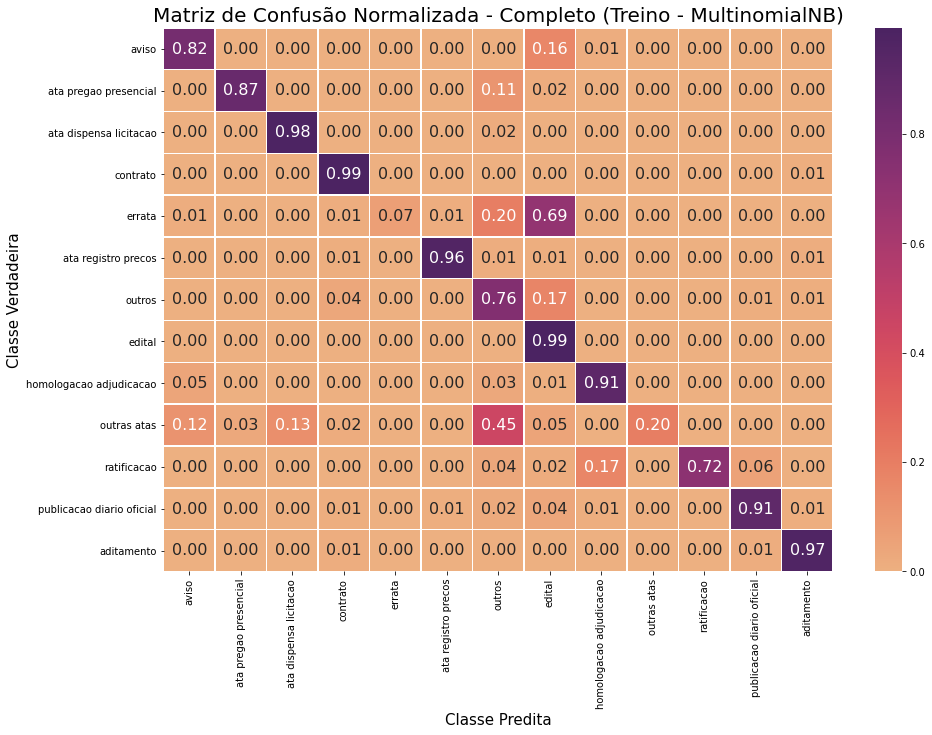

Validação - MultinomialNB:
________________________________________________________________________________
F1_score macro: 0.01545819509870253
F1_score weighted: 0.036334235290614254
Accuracy: 0.048672566371681415
________________________________________________________________________________


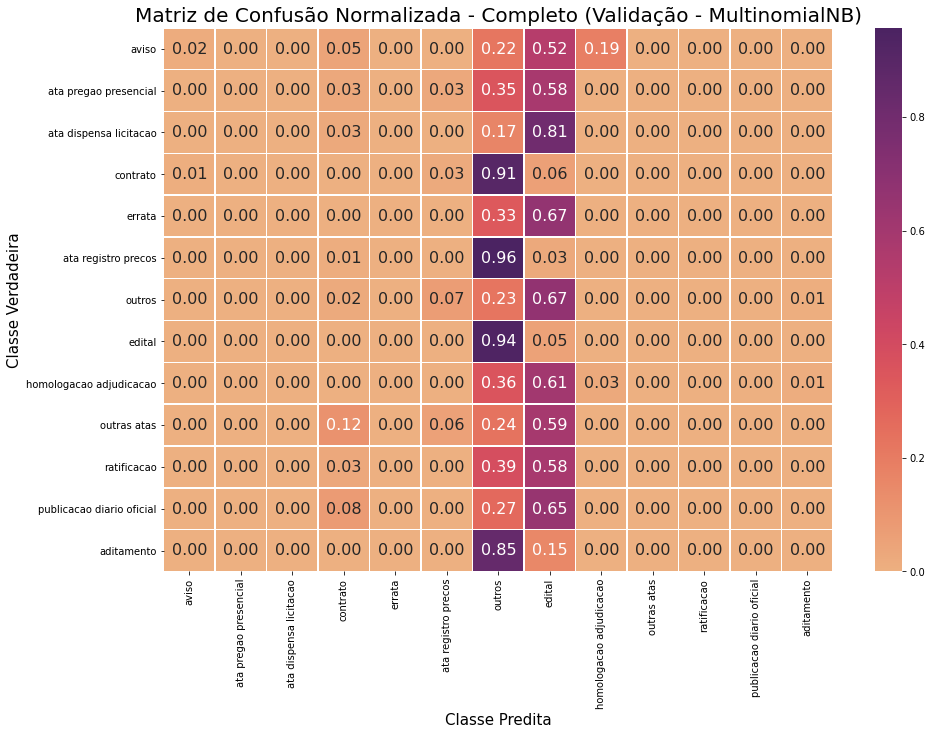

Teste - MultinomialNB:
________________________________________________________________________________
F1_score macro: 0.017516833046393652
F1_score weighted: 0.03143225605526063
Accuracy: 0.04063604240282685
________________________________________________________________________________


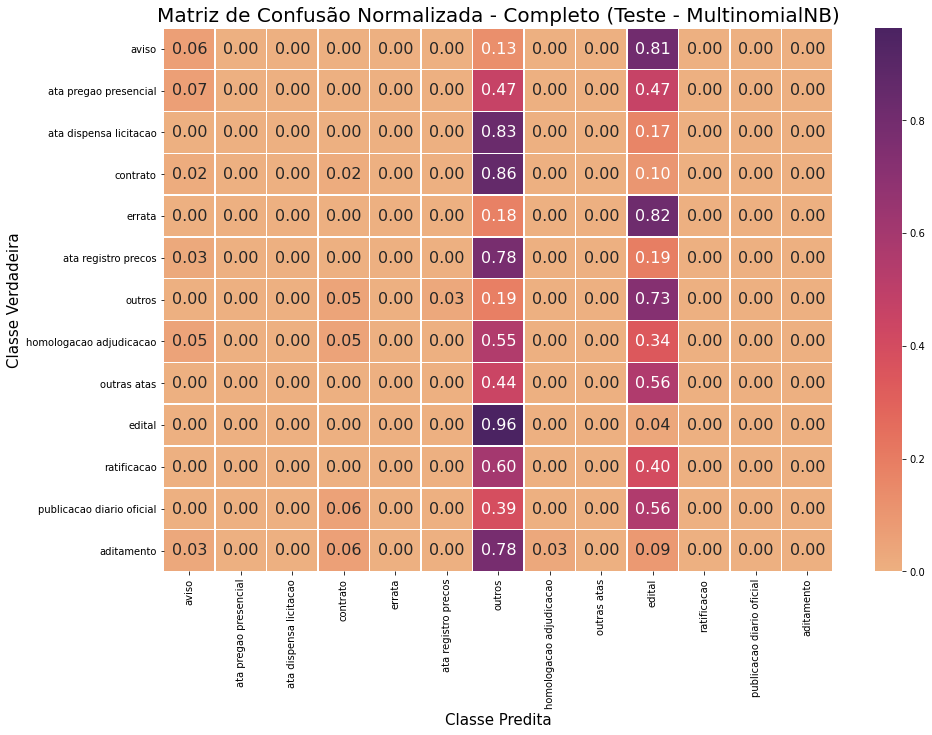


 >> GaussianNB - Com feature selection

Train set score:  0.973717462724286

Validation set score:  0.16460176991150444

Test set score:  0.13074204946996468

>> Avaliações - GaussianNB
Treino - GaussianNB:
________________________________________________________________________________
F1_score macro: 0.9636671825294522
F1_score weighted: 0.974914309172803
Accuracy: 0.973717462724286
________________________________________________________________________________


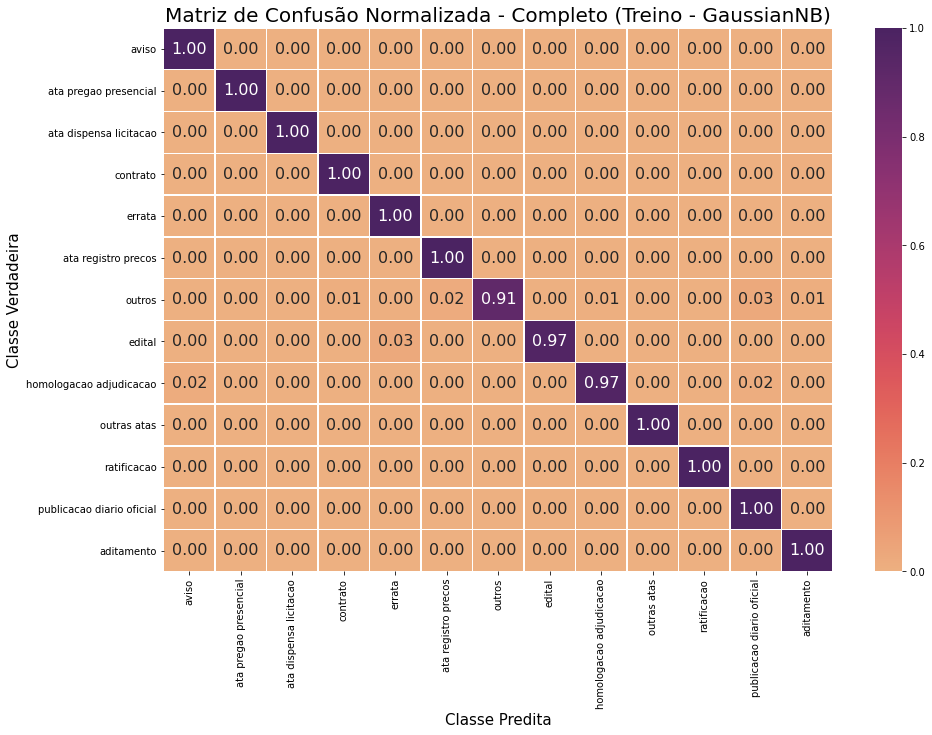

Validação - GaussianNB:
________________________________________________________________________________
F1_score macro: 0.05027449490338516
F1_score weighted: 0.1506755496522888
Accuracy: 0.16460176991150444
________________________________________________________________________________


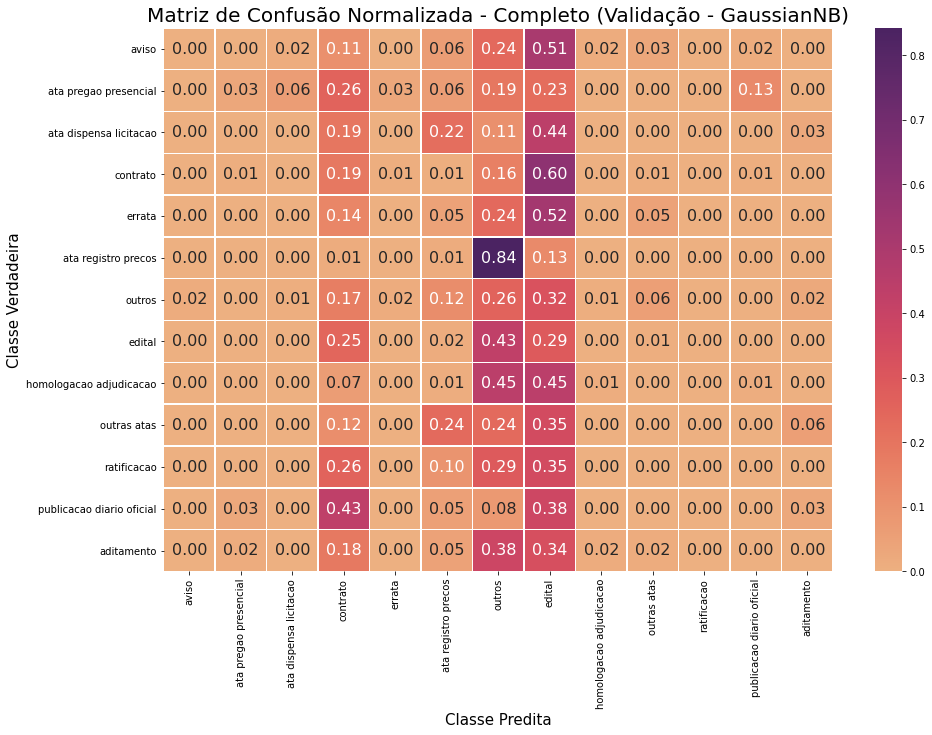

Teste - GaussianNB:
________________________________________________________________________________
F1_score macro: 0.05715152689235382
F1_score weighted: 0.10890399716590006
Accuracy: 0.13074204946996468
________________________________________________________________________________


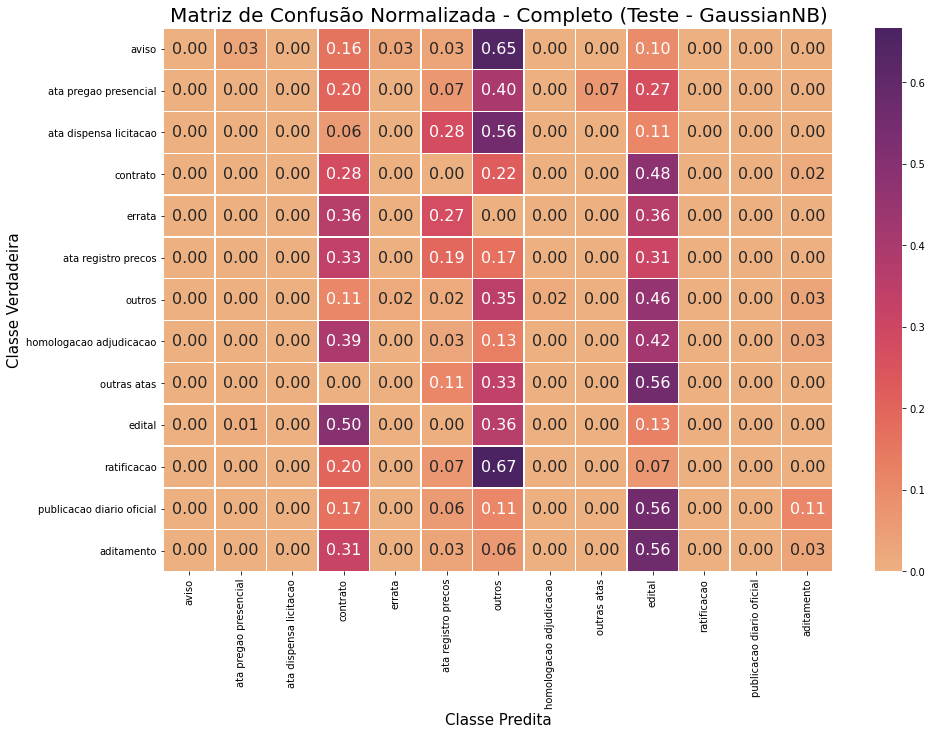

In [25]:
# MultinomialNB
model_MNB = MultinomialNB().fit(tf_idf_train, y_train.values.ravel())
score_train_MNB = model_MNB.score(tf_idf_train, y_train.values.ravel())
print("\n >> MultinomialNB - Sem feature selection")
print("\nTrain set score: ", score_train_MNB)
score_val_MNB = model_MNB.score(tf_idf_val_final, y_val.values.ravel())
print("\nValidation set score: ", score_val_MNB)
score_test_MNB = model_MNB.score(tf_idf_test_final, y_test.values.ravel())
print("\nTest set score: ", score_test_MNB)

##### Avaliações
print("\n>> Avaliações - MultinomialNB")
y_pred_train = model_MNB.predict(tf_idf_train)
evaluation_models(y_train, y_pred_train, "Treino - MultinomialNB")
y_pred_val = model_MNB.predict(tf_idf_val_final)
evaluation_models(y_val, y_pred_val, "Validação - MultinomialNB")
y_pred_test = model_MNB.predict(tf_idf_test_final)
evaluation_models(y_test, y_pred_test, "Teste - MultinomialNB")


print("\n >> GaussianNB - Sem feature selection")
#GaussianNB
model_GNB = GaussianNB().fit(tf_idf_train, y_train.values.ravel())
score_train_GNB = model_GNB.score(tf_idf_train, y_train.values.ravel())
print("\nTrain set score: ", score_train_GNB)
score_val_GNB = model_GNB.score(tf_idf_val_final, y_val.values.ravel())
print("\nValidation set score: ", score_val_GNB)
score_test_GNB = model_GNB.score(tf_idf_test_final, y_test.values.ravel())
print("\nTest set score: ", score_test_GNB)

##### Avaliações
print("\n>> Avaliações - GaussianNB")
y_pred_train = model_GNB.predict(tf_idf_train)
evaluation_models(y_train, y_pred_train, "Treino - GaussianNB")
y_pred_val = model_GNB.predict(tf_idf_val_final)
evaluation_models(y_val, y_pred_val, "Validação - GaussianNB")
y_pred_test = model_GNB.predict(tf_idf_test_final)
evaluation_models(y_test, y_pred_test, "Teste - GaussianNB")

#Com feature selection
#MultinomialNB
model_MNB = MultinomialNB().fit(features_train, y_train.values.ravel())
score_train_MNB = model_MNB.score(features_train, y_train.values.ravel())

print("\n >> MultinomialNB - Com feature selection")
print("\nTrain set score: ", score_train_MNB)
score_val_MNB = model_MNB.score(features_val, y_val.values.ravel())
print("\nValidation set score: ", score_val_MNB)
score_test_MNB = model_MNB.score(features_test, y_test.values.ravel())
print("\nTest set score: ", score_test_MNB)

##### Avaliações
print("\n>> Avaliações - MultinomialNB")
y_pred_train = model_MNB.predict(features_train)
evaluation_models(y_train, y_pred_train, "Treino - MultinomialNB")
y_pred_val = model_MNB.predict(features_val)
evaluation_models(y_val, y_pred_val, "Validação - MultinomialNB")
y_pred_test = model_MNB.predict(features_test)
evaluation_models(y_test, y_pred_test, "Teste - MultinomialNB")

print("\n >> GaussianNB - Com feature selection")
#GaussianNB
model_GNB = GaussianNB().fit(features_train, y_train.values.ravel())
score_train_GNB = model_GNB.score(features_train, y_train.values.ravel())
print("\nTrain set score: ", score_train_GNB)
score_val_GNB = model_GNB.score(features_val, y_val.values.ravel())
print("\nValidation set score: ", score_val_GNB)
score_test_GNB = model_GNB.score(features_test, y_test.values.ravel())
print("\nTest set score: ", score_test_GNB)

##### Avaliações
print("\n>> Avaliações - GaussianNB")
y_pred_train = model_GNB.predict(features_train)
evaluation_models(y_train, y_pred_train, "Treino - GaussianNB")
y_pred_val = model_GNB.predict(features_val)
evaluation_models(y_val, y_pred_val, "Validação - GaussianNB")
y_pred_test = model_GNB.predict(features_test)
evaluation_models(y_test, y_pred_test, "Teste - GaussianNB")


# Random forest


 Random Forest sem feature selection

Train set score:  0.788981551680566

Validation set score:  0.30265486725663715

Test set score:  0.42226148409893993

>> Avaliações - Random Forest
Treino - Random Forest:
________________________________________________________________________________
F1_score macro: 0.5581165197815238
F1_score weighted: 0.7461344080212526
Accuracy: 0.788981551680566
________________________________________________________________________________


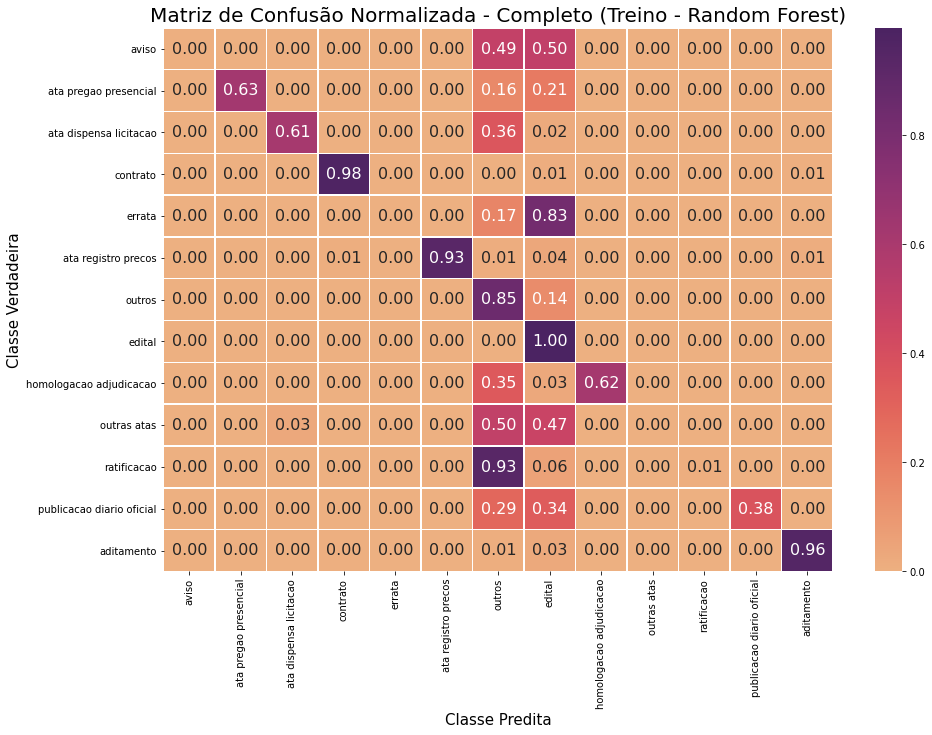

Validação - Random Forest:
________________________________________________________________________________
F1_score macro: 0.06401360671541144
F1_score weighted: 0.25366871369655275
Accuracy: 0.30265486725663715
________________________________________________________________________________


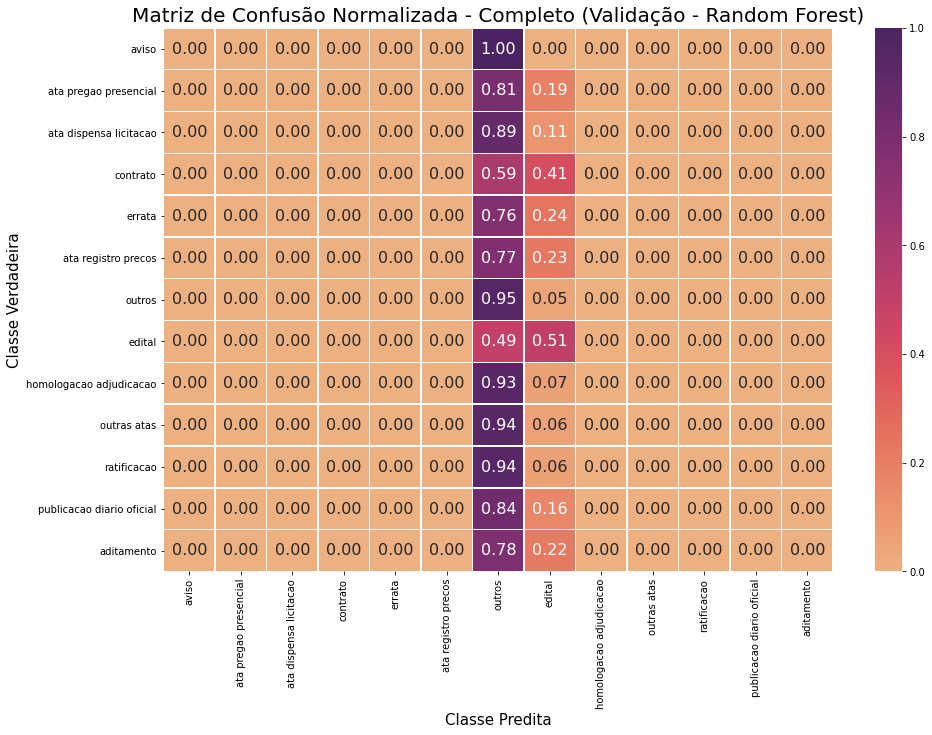

Teste - Random Forest:
________________________________________________________________________________
F1_score macro: 0.08236846403121965
F1_score weighted: 0.3386732710329085
Accuracy: 0.42226148409893993
________________________________________________________________________________


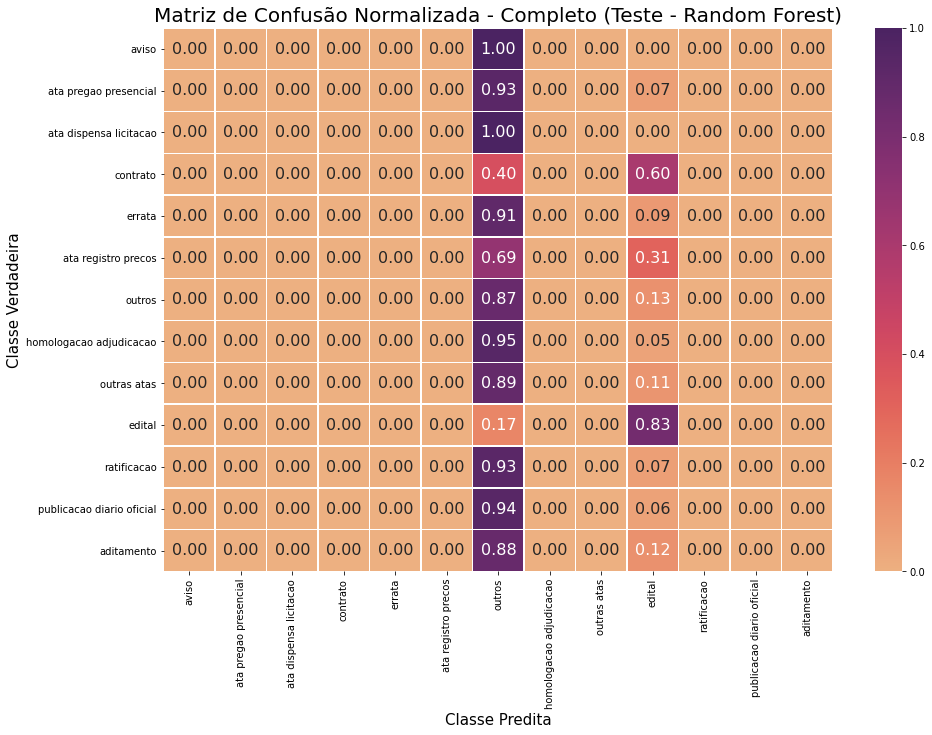


 Random Forest com feature selection

Train set score:  0.8931008339651251

Validation set score:  0.10973451327433628

Test set score:  0.11130742049469965

>> Avaliações - Random Forest
Treino - Random Forest:
________________________________________________________________________________
F1_score macro: 0.7797787102899675
F1_score weighted: 0.8898757678861716
Accuracy: 0.8931008339651251
________________________________________________________________________________


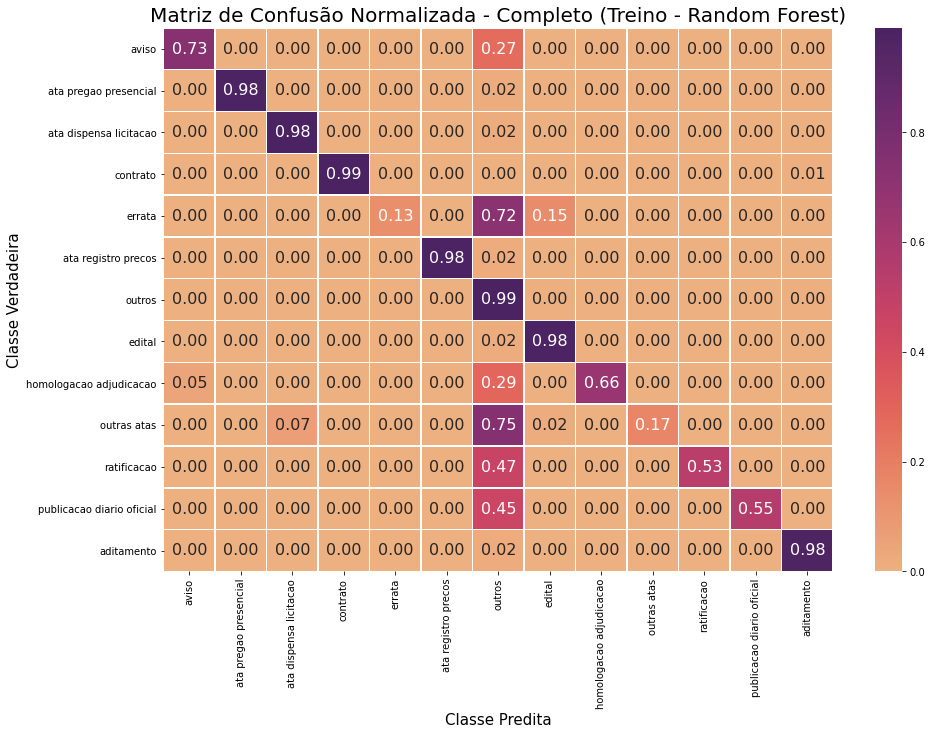

Validação - Random Forest:
________________________________________________________________________________
F1_score macro: 0.015212857318120474
F1_score weighted: 0.021701881413106375
Accuracy: 0.10973451327433628
________________________________________________________________________________


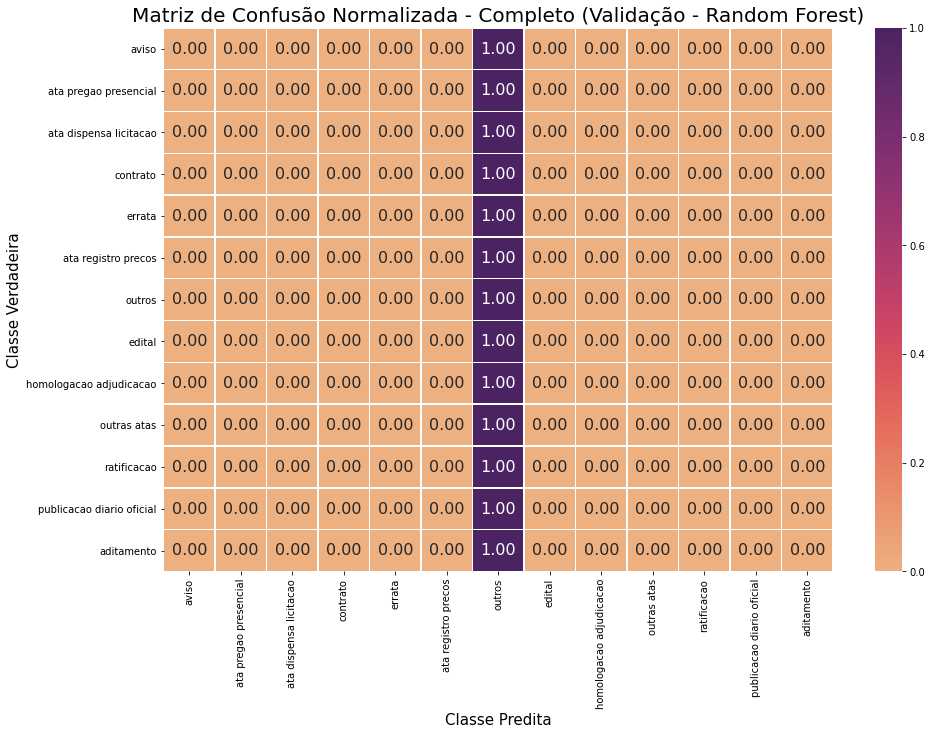

Teste - Random Forest:
________________________________________________________________________________
F1_score macro: 0.015409074232603645
F1_score weighted: 0.022296875965551917
Accuracy: 0.11130742049469965
________________________________________________________________________________


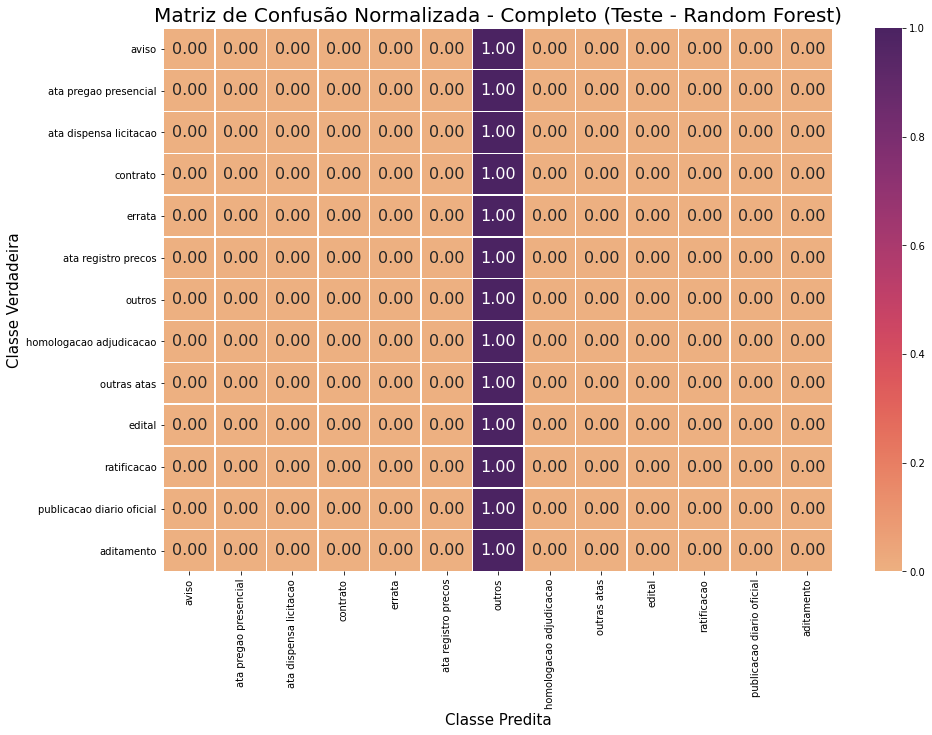

In [26]:
print("\n Random Forest sem feature selection")
rf = RandomForestClassifier(max_depth=10,max_features=10)
rf.fit(tf_idf_train,y_train.values.ravel())

score_rf = rf.score(tf_idf_train, y_train.values.ravel())
print("\nTrain set score: ", score_rf)
score_val_rf = rf.score(tf_idf_val_final, y_val.values.ravel())
print("\nValidation set score: ", score_val_rf)
score_test_rf = rf.score(tf_idf_test_final, y_test.values.ravel())
print("\nTest set score: ", score_test_rf)

print("\n>> Avaliações - Random Forest")
y_pred_train = rf.predict(tf_idf_train)
evaluation_models(y_train, y_pred_train, "Treino - Random Forest")
y_pred_val = rf.predict(tf_idf_val_final)
evaluation_models(y_val, y_pred_val, "Validação - Random Forest")
y_pred_test = rf.predict(tf_idf_test_final)
evaluation_models(y_test, y_pred_test, "Teste - Random Forest")

print("\n Random Forest com feature selection")
rf = RandomForestClassifier(max_depth=10,max_features=10)
rf.fit(features_train,y_train.values.ravel())
score_rf = rf.score(features_train, y_train.values.ravel())
print("\nTrain set score: ", score_rf)
score_val_rf = rf.score(features_val, y_val.values.ravel())
print("\nValidation set score: ", score_val_rf)
score_test_rf = rf.score(features_test, y_test.values.ravel())
print("\nTest set score: ", score_test_rf)

print("\n>> Avaliações - Random Forest")
y_pred_train = rf.predict(features_train)
evaluation_models(y_train, y_pred_train, "Treino - Random Forest")
y_pred_val = rf.predict(features_val)
evaluation_models(y_val, y_pred_val, "Validação - Random Forest")
y_pred_test = rf.predict(features_test)
evaluation_models(y_test, y_pred_test, "Teste - Random Forest")

# XGBoost

In [43]:
print("\n XGBoost sem feature selection")
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
xgb_model.fit(tf_idf_train,y_train.values.ravel())

# score_xgb = xgb_model.score(tf_idf_train, y_train.values.ravel())
# print("\nTrain set score: ", score_xgb)
# y_pred_train = xgb_model.predict(tf_idf_train)
# evaluation_models(y_train, y_pred_train, "Treino - XGBoost")

score_val_xgb = xgb_model.score(tf_idf_val_final, y_val.values.ravel())
print("\nValidation set score: ", score_val_xgb)
y_pred_val = xgb_model.predict(tf_idf_val_final)
evaluation_models(y_val, y_pred_val, "Validação - XGBoost")

score_test_xgb = xgb_model.score(tf_idf_test_final, y_test.values.ravel())
print("\nTest set score: ", score_test_xgb)
y_pred_test = xgb_model.predict(tf_idf_test_final)
evaluation_models(y_test, y_pred_test, "Teste - XGBoost")



 XGBoost sem feature selection
[17:10:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


ValueError: feature_names mismatch: ['aa', 'aaa', 'aaplicacaodaspenalidadescabiveis', 'aaquisicao', 'aar', 'aas', 'aausenciadocredenciadoemqualquermomentodasessaopublica', 'ab', 'aba', 'abacate', 'abacaxi', 'abade', 'abaixador', 'abas', 'abastecer', 'abastecidos', 'abastecimento', 'abastecimentos', 'abatimento', 'abatimentos', 'abc', 'abdome', 'abdominal', 'aberta', 'abertas', 'aberto', 'abertos', 'abertura', 'abic', 'abnt', 'abobora', 'abobrinha', 'abra', 'abracadeira', 'abrange', 'abrangencia', 'abrangendo', 'abrantes', 'abrasao', 'abre', 'abreu', 'abri', 'abridor', 'abrigada', 'abrigar', 'abrigara', 'abrigo', 'abril', 'abrir', 'abrira', 'abrirao', 'abriu', 'abs', 'absoluta', 'absorcao', 'absorvente', 'absorvivel', 'abster', 'abu', 'ac', 'acabamento', 'acabamentos', 'acabaria', 'acacia', 'academia', 'academias', 'academicas', 'acao', 'acarreta', 'acarretam', 'acarretando', 'acarretar', 'acarretara', 'acarretarem', 'acarretaria', 'acarrete', 'acartadecredenciamento', 'acatar', 'acategoria', 'acc', 'ace', 'aceita', 'aceitabilidade', 'aceitacao', 'aceitando', 'aceitar', 'aceitara', 'aceitarem', 'aceitas', 'aceitaveis', 'aceitavel', 'aceite', 'aceitem', 'aceito', 'aceitos', 'aceleracao', 'acelerador', 'acem', 'acendimento', 'acentos', 'acer', 'acertadas', 'acertado', 'acerto', 'acervo', 'acessar', 'acesse', 'acessibilidade', 'acessivel', 'acesso', 'acessorio', 'acessorios', 'acessos', 'acetato', 'acetilcisteina', 'acetilsalicilico', 'acha', 'achada', 'achado', 'achatado', 'achocolatado', 'aci', 'aciclovir', 'acid', 'acida', 'acidente', 'acidentes', 'acidez', 'acidificante', 'acido', 'acidos', 'acidulado', 'acidulante', 'acii', 'aciii', 'acionadas', 'acionado', 'acionador', 'acionadores', 'acionados', 'acionamento', 'acionista', 'acionistas', 'aclamacao', 'aclamadas', 'aclasta', 'aco', 'acoes', 'acolchoada', 'acolhida', 'acolhidos', 'acolhimento', 'acolho', 'acomodacao', 'acomodacoes', 'acomotacita', 'acompanha', 'acompanhada', 'acompanhadas', 'acompanhado', 'acompanhados', 'acompanhamento', 'acompanhando', 'acompanhante', 'acompanhar', 'acompanhara', 'acondicionada', 'acondicionadas', 'acondicionado', 'acondicionados', 'acondicionamento', 'acontecera', 'acontecimento', 'acopia', 'acoplada', 'acoplado', 'acordado', 'acordam', 'acordao', 'acordaos', 'acordaram', 'acordo', 'acostadas', 'acostado', 'acostados', 'acr', 'acresce', 'acrescentado', 'acrescentar', 'acrescido', 'acrescimo', 'acrescimos', 'acrilex', 'acrilica', 'acrilico', 'acs', 'acucar', 'acuidade', 'acum', 'acumulacao', 'acumulada', 'acumulado', 'acumulo', 'acustico', 'ad', 'ada', 'adaptacao', 'adaptacoes', 'adaptado', 'adaptador', 'adaptados', 'adaptativas', 'adaptativo', 'ade', 'adeclaracao', 'adelbras', 'adelma', 'adendo', 'adendos', 'adensamento', 'adequacao', 'adequacoes', 'adequada', 'adequadamente', 'adequadas', 'adequado', 'adequados', 'adequar', 'aderem', 'aderencia', 'aderente', 'aderentes', 'aderidos', 'aderir', 'aderirem', 'ades', 'adesao', 'adesiva', 'adesivada', 'adesivo', 'adesivos', 'adesoes', 'adiada', 'adiamento', 'adicao', 'adicionado', 'adicionais', 'adicional', 'adimplemento', 'adimplentes', 'aditado', 'aditamento', 'aditamentos', 'aditivado', 'aditivados', 'aditivo', 'aditivos', 'adjalme', 'adjudica', 'adjudicacao', 'adjudicacaopdf', 'adjudicada', 'adjudicado', 'adjudicados', 'adjudicando', 'adjudicar', 'adjudicara', 'adjudicataria', 'adjudicatario', 'adjudico', 'adjuvantes', 'adm', 'admini', 'adminis', 'administracao', 'administracaopublica', 'administracoes', 'administrador', 'administradora', 'administradores', 'administrados', 'administrar', 'administrativa', 'administrativas', 'administrativo', 'administrativos', 'admissao', 'admissibilidade', 'admissivel', 'admite', 'admitem', 'admitida', 'admitidas', 'admitido', 'admitidos', 'admitindo', 'admitir', 'admitira', 'ado', 'adocante', 'adocao', 'adocumentacaoconformeas', 'adocumentacaodeveraserapresentada', 'adolescente', 'adolescentes', 'adotada', 'adotadas', 'adotado', 'adotados', 'adotando', 'adotar', 'adote', 'adquirida', 'adquiridas', 'adquirido', 'adquiridos', 'adquirir', 'adquirirem', 'adquiriu', 'adrenalina', 'adriana', 'adriani', 'adriano', 'adstrita', 'adubacao', 'adulteracao', 'adulto', 'adultos', 'aduz', 'advantive', 'adversa', 'advertencia', 'advindas', 'advindos', 'advir', 'advogada', 'advogado', 'advogados', 'ae', 'aee', 'aerogramas', 'aeroportos', 'aerosol', 'aerossol', 'aes', 'aexclusividade', 'af', 'afasta', 'afastada', 'afastamento', 'afastar', 'afazenda', 'afazendaestadualda', 'afe', 'afericao', 'aferida', 'aferir', 'afetada', 'afetam', 'afetar', 'afete', 'afetem', 'afiador', 'afim', 'afins', 'afirma', 'afirmacao', 'afirmam', 'afirmamos', 'afirmar', 'afirmativas', 'afixadas', 'afixado', 'afixados', 'afonso', 'afs', 'ag', 'agencia', 'agencias', 'agenda', 'agendada', 'agendadas', 'agendado', 'agendamento', 'agendamentos', 'agendar', 'agente', 'agentes', 'agi', 'agilidade', 'agilizar', 'agle', 'aglomeracao', 'aglon', 'aglutinantes', 'agostinho', 'agosto', 'agradavel', 'agradeceu', 'agrale', 'agraria', 'agrario', 'agratto', 'agravos', 'agregados', 'agregue', 'agricola', 'agricolas', 'agricult', 'agricultor', 'agricultores', 'agricultura', 'agridem', 'agro', 'agroecologicos', 'agroindustria', 'agroindustriais', 'agronomia', 'agropecuari', 'agropecuaria', 'agropecuario', 'agrotoxicos', 'agu', 'agua', 'aguarda', 'aguardando', 'aguardar', 'aguas', 'aguda', 'aguia', 'aguiar', 'agulha', 'agulhado', 'agulhas', 'ah', 'ai', 'aids', 'ailton', 'aindaquecomalgumapendenciaourestricao', 'aindaquemunidadeprocuracao', 'air', 'airbag', 'airbags', 'airro', 'ais', 'aitva', 'aj', 'ajd', 'ajuda', 'ajudante', 'ajustada', 'ajustado', 'ajustados', 'ajustam', 'ajustamento', 'ajustavel', 'ajuste', 'ajustes', 'al', 'ala', 'alair', 'alambrado', 'alameda', 'alan', 'alane', 'alaranjada', 'alarme', 'alarmes', 'alavanca', 'alberto', 'albis', 'albumina', 'alc', 'alca', 'alcalina', 'alcalinizante', 'alcancada', 'alcancado', 'alcancados', 'alcancando', 'alcance', 'alcas', 'alceu', 'alcool', 'alea', 'alega', 'alegacao', 'alegacoes', 'alegado', 'alegam', 'alegando', 'alegar', 'alegre', 'alem', 'alendronato', 'alex', 'alexandre', 'alfa', 'alfabetica', 'alface', 'alfagas', 'alfalagos', 'alfenas', 'alfinete', 'alfredo', 'algarismo', 'algarismos', 'algodao', 'alheias', 'alho', 'alianca', 'aliando', 'alicate', 'alienacao', 'alienacoes', 'alimentacao', 'alimentado', 'alimentar', 'alimentares', 'alimenticios', 'alimento', 'alimentos', 'aline', 'alinea', 'alineas', 'alinhamento', 'aliquota', 'alliance', 'alma', 'almaco', 'almada', 'alme', 'almeid', 'almeida', 'almoco', 'almofada', 'almotolia', 'almoxarifado', 'alocada', 'alocados', 'alojamento', 'alojar', 'alone', 'alongado', 'alongo', 'alphaville', 'alprazolam', 'alquil', 'alt', 'alta', 'altair', 'altamira', 'altamiro', 'altas', 'altera', 'alteracao', 'alteracoes', 'alterada', 'alteradas', 'alterado', 'alterados', 'alterando', 'alterar', 'altere', 'alternada', 'alternativa', 'alternativas', 'alternativos', 'alterou', 'alto', 'altomare', 'altura', 'aludido', 'aludidos', 'aluguel', 'aluminio', 'aluno', 'alunos', 'alv', 'alvara', 'alvaras', 'alvarenga', 'alvares', 'alvaro', 'alvejado', 'alvejante', 'alvenaria', 'alveolar', 'alves', 'alvesa', 'alvo', 'alyson', 'am', 'amaciante', 'amadurecimento', 'amalgama', 'amanco', 'amanda', 'amanteigada', 'amapa', 'amaral', 'amarela', 'amarelada', 'amareladas', 'amarelado', 'amarelados', 'amarelamento', 'amarelo', 'amaro', 'amarracao', 'amassada', 'amassadas', 'amassados', 'amazon', 'ambas', 'ambientais', 'ambiental', 'ambiente', 'ambientes', 'ambito', 'ambu', 'ambulancia', 'ambulancias', 'ambulatorial', 'amd', 'amelia', 'amelio', 'amendoim', 'america', 'american', 'americana', 'americano', 'americo', 'amianto', 'amido', 'amigavel', 'amilaceo', 'amilase', 'amina', 'amiodarona', 'amitriptilina', 'amm', 'amo', 'amonio', 'amorfo', 'amortecedor', 'amortecedores', 'amostra', 'amostras', 'amoxicilina', 'amoxilina', 'amp', 'amparada', 'amparado', 'amparo', 'amperes', 'ampla', 'ampliacao', 'ampliacoes', 'ampliado', 'ampliando', 'ampliar', 'amplificador', 'amplificadores', 'amplo', 'amplos', 'ampola', 'ampolas', 'amputacao', 'an', 'ana', 'analio', 'analisa', 'analisada', 'analisadas', 'analisado', 'analisador', 'analisados', 'analisando', 'analisar', 'analisara', 'analise', 'analises', 'analogica', 'analogico', 'ananias', 'anatel', 'anatomica', 'anatomico', 'anauger', 'ancinhoc', 'ancoragem', 'andaime', 'andamento', 'andar', 'andere', 'andorinha', 'andrade', 'andre', 'andreia', 'android', 'anel', 'anemia', 'aneotania', 'anestesia', 'anestesico', 'anexa', 'anexacao', 'anexada', 'anexadaacartade', 'anexadas', 'anexado', 'anexados', 'anexar', 'anexas', 'anexo', 'anexoiidesteedital', 'anexos', 'angelica', 'angeline', 'angelino', 'angelo', 'angiotomografia', 'angulo', 'anibal', 'animais', 'animal', 'anionicos', 'aniversario', 'anjos', 'anniela', 'ano', 'anonima', 'anonimas', 'anormal', 'anormalidade', 'anos', 'anotacao', 'anotacoes', 'anp', 'ant', 'antares', 'antecedencia', 'antecedentes', 'anteceder', 'antecedera', 'antecederem', 'antecipacao', 'antecipado', 'antena', 'antenas', 'anterior', 'anteriores', 'antero', 'anti', 'antiacaro', 'antibacteriano', 'antibloqueio', 'anticoagulante', 'anticorrosivo', 'antiderrapante', 'antiderrapantes', 'antifungo', 'antigo', 'antineoplasicos', 'antisseptico', 'antonia', 'antonio', 'antropometrica', 'anuais', 'anual', 'anualmente', 'anuem', 'anuencia', 'anuido', 'anulacao', 'anulado', 'anulados', 'anular', 'anunciado', 'anverso', 'anvisa', 'aoc', 'aocusto', 'aoencerrarocredenciamento', 'aofinalassinado', 'aorta', 'ap', 'apagador', 'apagar', 'aparecera', 'aparecida', 'aparecido', 'aparelhada', 'aparelhamento', 'aparelho', 'aparelhos', 'aparencia', 'aparente', 'apenada', 'apenasumamarca', 'aperto', 'api', 'apiloamento', 'aplica', 'aplicacao', 'aplicacoes', 'aplicada', 'aplicadas', 'aplicado', 'aplicador', 'aplicadores', 'aplicados', 'aplicando', 'aplicar', 'aplicara', 'aplicativo', 'aplicaveis', 'aplicaveisaespecie', 'aplicavel', 'aplicou', 'apodrecidos', 'apodrecimentos', 'apoia', 'apoiar', 'apoio', 'apoiogi', 'apolices', 'apontada', 'apontadas', 'apontado', 'apontador', 'apontados', 'apontamentos', 'apontando', 'apontar', 'apos', 'aposentado', 'aposentados', 'aposoregularcredenciamento', 'apostiladas', 'apostilado', 'apostilamentos', 'app', 'aprazada', 'apreciacao', 'apreciar', 'aprendiz', 'aprendizado', 'apresenta', 'apresentacao', 'apresentacoes', 'apresentada', 'apresentadas', 'apresentado', 'apresentados', 'apresentadosemseparado', 'apresentam', 'apresentando', 'apresentar', 'apresentara', 'apresentaradeclaracao', 'apresentaram', 'apresentarao', 'apresentarem', 'apresentaremos', 'apresentarnomomentooportuno', 'apresentaveis', 'apresente', 'apresentem', 'apresentou', 'apresuntado', 'aprimoramento', 'aprimorando', 'apropostacomocnpjdaempresa', 'apropriada', 'apropriadas', 'apropriado', 'aprova', 'aprovacao', 'aprovada', 'aprovadas', 'aprovado', 'aprovados', 'aprovar', 'aproveitada', 'aproveitamento', 'aproveitando', 'aproveitaveis', 'aprovou', 'aproximada', 'aproximadas', 'aproximado', 'aps', 'apt', 'apta', 'aptamil', 'aptas', 'apti', 'aptidao', 'apto', 'aptos', 'apuracao', 'apuracoes', 'apurada', 'apurado', 'apurados', 'apurar', 'apure', 'aqua', 'aquiesce', 'aquisicao', 'aquisicoes', 'aquisisao', 'aqusicao', 'ar', 'ara', 'aradora', 'araguari', 'arame', 'aranha', 'arantes', 'arar', 'arara', 'arary', 'araujo', 'arbitragem', 'arcar', 'arcara', 'arco', 'arcos', 'ardidos', 'area', 'areas', 'areia', 'areiao', 'arenna', 'aretusa', 'argamassa', 'argemiro', 'argo', 'argola', 'argolinha', 'argumentando', 'argumentos', 'aristeu', 'arla', 'arm', 'armacao', 'armada', 'armado', 'armador', 'armadura', 'armando', 'armarinhos', 'armario', 'armazenados', 'armazenamento', 'arnaldo', 'aro', 'aroma', 'aromatizante', 'aromatizantes', 'arp', 'arqplast', 'arquibancada', 'arquiteta', 'arquiteto', 'arquitetonico', 'arquitetura', 'arquivada', 'arquivado', 'arquivados', 'arquivamento', 'arquive', 'arquivo', 'arquivos', 'array', 'arrazoado', 'arrecadacao', 'arrecadados', 'arredondado', 'arredondamento', 'arrematacao', 'arrematante', 'arrimo', 'arroz', 'arruda', 'arruela', 'arrumada', 'art', 'arte', 'artecamp', 'artefatos', 'arterial', 'arterias', 'artes', 'artesanato', 'articulacao', 'articulada', 'articuladas', 'articulado', 'articuladora', 'articuladoras', 'articular', 'articulavel', 'artificiais', 'artificial', 'artigo', 'artigos', 'artista', 'artistas', 'artistica', 'artisticas', 'artistico', 'artisticos', 'arts', 'arvores', 'as', 'asc', 'ascorbico', 'asem', 'asfaltica', 'asfaltico', 'asfalto', 'aslicitantes', 'asp', 'aspecto', 'aspectos', 'aspersor', 'aspiracao', 'aspiracoes', 'aspirador', 'asr', 'ass', 'assadeira', 'assado', 'assegurada', 'assegurado', 'assegurando', 'assegurar', 'assegure', 'assembleia', 'assemelhada', 'assemelhado', 'assentada', 'assentado', 'assentador', 'assentamento', 'assentamentos', 'assentar', 'assente', 'assento', 'assentos', 'assepsia', 'assessor', 'assessora', 'assessoramento', 'assessorar', 'assessoria', 'assessorias', 'assina', 'assinada', 'assinadas', 'assinado', 'assinados', 'assinalados', 'assinale', 'assinam', 'assinar', 'assinara', 'assinaram', 'assinarem', 'assinatura', 'assinaturas', 'assine', 'assinou', 'assis', 'assist', 'assista', 'assiste', 'assistencia', 'assistenciais', 'assistente', 'assistidas', 'assistidos', 'assistindo', 'assistir', 'assitencia', 'associacao', 'associacoes', 'associadas', 'associado', 'associados', 'associem', 'assolan', 'assume', 'assumida', 'assumidas', 'assumido', 'assumidos', 'assumindo', 'assumir', 'assumira', 'assumpta', 'assunto', 'assuntos', 'ast', 'astem', 'astra', 'astrazeneca', 'at', 'ata', 'atacadista', 'atacadistas', 'atacado', 'atadura', 'atas', 'ate', 'atencao', 'atenda', 'atendam', 'atende', 'atendem', 'atendendo', 'atendente', 'atender', 'atendera', 'atenderam', 'atenderao', 'atenderem', 'atendeu', 'atendida', 'atendidas', 'atendido', 'atendidos', 'atendimento', 'atendimentos', 'atenolol', 'atentando', 'ateoultimodiautilqueantecederadata', 'aterramento', 'aterro', 'atestada', 'atestadas', 'atestado', 'atestados', 'atestando', 'atestar', 'atestara', 'ateste', 'atesto', 'atf', 'atila', 'atinente', 'atinentes', 'atingido', 'atingidos', 'atingir', 'atingiu', 'ativ', 'ativa', 'ativada', 'ativado', 'atividade', 'atividades', 'ativo', 'ativos', 'atlantica', 'atlas', 'ato', 'atomico', 'atorvastatina', 'atos', 'atospraticados', 'atoxica', 'atoxico', 'atracao', 'atracoes', 'atrair', 'atrapalhe', 'atrasada', 'atrasar', 'atraso', 'atrasos', 'atraumatica', 'atraves', 'atravesdedeclaracao', 'atribua', 'atribuicao', 'atribuicoes', 'atribuidas', 'atribuidos', 'atrio', 'attila', 'atua', 'atuacao', 'atuais', 'atual', 'atualizacao', 'atualizacoes', 'atualizada', 'atualizadas', 'atualizado', 'atualizados', 'atuando', 'atuar', 'atuara', 'atuarem', 'atue', 'atuem', 'atv', 'atx', 'au', 'audatex', 'aude', 'audiencia', 'audio', 'audiograma', 'audiovisuais', 'audiovisual', 'auditiva', 'auditoria', 'auditorio', 'auferidos', 'auferindo', 'augusto', 'aula', 'aulas', 'aumenta', 'aumentando', 'aumentar', 'aumento', 'aumentos', 'aurelio', 'auricular', 'aurobindo', 'auscultador', 'ausencia', 'ausentar', 'ausente', 'ausentes', 'autarquia', 'autarquias', 'autentica', 'autenticacao', 'autenticacoes', 'autenticada', 'autenticadas', 'autenticado', 'autenticados', 'autenticadospelo', 'autenticidade', 'auto', 'autoclavado', 'autoclavavel', 'autoclave', 'autocopiativo', 'automacao', 'automatica', 'automaticamente', 'automatico', 'automaticos', 'automotiva', 'automotivas', 'automotivo', 'automotivos', 'automotor', 'automotores', 'automoveis', 'automovel', 'autonomia', 'autonomo', 'autonomos', 'autor', 'autorais', 'autores', 'autoria', 'autoridade', 'autoridades', 'autoriza', 'autorizacao', 'autorizacaoexpressado', 'autorizacoes', 'autorizada', 'autorizadas', 'autorizado', 'autorizadora', 'autorizados', 'autorizando', 'autorizar', 'autorize', 'autorizo', 'autos', 'autuados', 'aux', 'auxiliado', 'auxiliando', 'auxiliar', 'auxiliares', 'auxilio', 'auxilios', 'av', 'avai', 'avaliacao', 'avaliacoes', 'avaliada', 'avaliadas', 'avaliados', 'avaliar', 'avancada', 'avancado', 'avayou', 'ave', 'aveia', 'aveian', 'aveiro', 'avelino', 'avenca', 'avencadas', 'avencado', 'avenida', 'avental', 'averiguacao', 'avermelhado', 'aviamentos', 'avila', 'aviso', 'avisos', 'avivar', 'avulsa', 'aw', 'az', 'azara', 'azarias', 'azatioprina', 'azedo', 'azeite', 'azeitona', 'azevedo', 'azul', 'azzi', 'ba', 'baby', 'bacia', 'bacitracina', 'bacon', 'bacteriana', 'bacterias', 'bactericida', 'bacteriologico', 'bag', 'bahia', 'baias', 'bairro', 'bairros', 'baixa', 'baixada', 'baixadas', 'baixado', 'bala', 'balanca', 'balancas', 'balanceamento', 'balancete', 'balancetes', 'balanco', 'balancos', 'balao', 'baldansi', 'balde', 'baliza', 'balizamento', 'balmak', 'balsa', 'bambole', 'bamifilina', 'banana', 'bananas', 'banca', 'bancada', 'bancaria', 'bancarias', 'bancario', 'bancarios', 'bancas', 'banco', 'bancos', 'band', 'banda', 'bandas', 'bandeira', 'bandeirantes', 'bandeiras', 'bandeja', 'bandejas', 'banheiro', 'banheiros', 'banho', 'baniquinha', 'banner', 'banners', 'bar', 'barao', 'barata', 'barba', 'barbante', 'barbosa', 'barboza', 'bares', 'barra', 'barracao', 'barracas', 'barras', 'barreira', 'barreiras', 'barro', 'barros', 'bartolomeu', 'bas', 'basculamento', 'basculante', 'basculantes', 'base', 'baseadas', 'baseado', 'bases', 'basica', 'basicas', 'basico', 'basicos', 'basicosdiretoseindiretos', 'basquete', 'bassi', 'bastao', 'batata', 'batedeira', 'batentes', 'bateria', 'baterias', 'batista', 'bau', 'baunilha', 'bayer', 'bb', 'bc', 'bd', 'bdi', 'bdmg', 'be', 'beam', 'bebedouro', 'bebedouros', 'bebida', 'bebidas', 'bege', 'bel', 'belchior', 'belgo', 'beline', 'belini', 'belizario', 'belo', 'belvedere', 'bemaindaacartadecredenciamentocomfimespecifico', 'bemcomfrete', 'bemcomofrete', 'bemcomonosigilodaspropostaseointeresse', 'bemcomoosdocumentosaelainerentes', 'bemcomopararesponder', 'bemcomopraticartodososatosinerentesao', 'benedito', 'beneficiada', 'beneficiadas', 'beneficiado', 'beneficiados', 'beneficiaria', 'beneficiario', 'beneficiarios', 'beneficio', 'beneficios', 'beneton', 'benfeitorias', 'bens', 'benserazida', 'bento', 'benz', 'benzalconio', 'benzatina', 'benzeno', 'benzocaina', 'benzotiazolin', 'berco', 'bercos', 'berinjela', 'bernardes', 'bernardino', 'berrini', 'bessa', 'betaistina', 'beterraba', 'betim', 'betoneira', 'betuminoso', 'bexiga', 'bh', 'bhcg', 'bi', 'biblioteca', 'bibliotecario', 'bic', 'bica', 'bicabornato', 'bicalho', 'bicarbonato', 'bico', 'bicombustivel', 'big', 'biki', 'bilateral', 'bilhetagem', 'bilirrubina', 'bio', 'biocon', 'biodegradavel', 'biodinamica', 'biohosp', 'biolab', 'biologica', 'biologico', 'biologicos', 'bioquimica', 'bioquimicas', 'bioquimico', 'biosani', 'bipolar', 'biscoito', 'biscoitos', 'biselada', 'bisnaga', 'bissulfato', 'bisturi', 'bitartarato', 'bitola', 'bits', 'bittencourt', 'bivolt', 'bl', 'black', 'blanc', 'blau', 'bloco', 'blocos', 'bloqueio', 'bloquete', 'bloquetes', 'blusa', 'boa', 'boas', 'bobina', 'bobinas', 'boca', 'bocal', 'bocas', 'bochecho', 'boehringer', 'boi', 'boia', 'boj', 'bojo', 'bokas', 'bola', 'bolacha', 'bolas', 'boletim', 'boletins', 'boleto', 'boletos', 'bolo', 'bolor', 'bolsa', 'bolsos', 'bom', 'bomba', 'bombas', 'bombeiro', 'bombeiros', 'bombom', 'bombona', 'bomm', 'bomtempo', 'bond', 'bonfim', 'bonificacao', 'bonoboi', 'bons', 'bontempo', 'bordas', 'bordos', 'boreda', 'borges', 'borracha', 'borracharia', 'borrachas', 'borrachudo', 'borroes', 'bosch', 'bosco', 'bota', 'botafogo', 'botao', 'botecos', 'botelho', 'botijao', 'botijoes', 'botoes', 'botrel', 'bovina', 'box', 'br', 'bracadeira', 'braco', 'bracos', 'bradesco', 'braga', 'bragal', 'braganca', 'branca', 'brancas', 'branco', 'brasao', 'brasferma', 'brasil', 'brasileira', 'brasileiras', 'brasileiro', 'brasileiros', 'brasilinha', 'brastube', 'braulio', 'braz', 'brazil', 'brazlimp', 'break', 'bridgestone', 'brigadista', 'brigadistas', 'brilha', 'brilhante', 'brilhantes', 'brilho', 'brim', 'brinksul', 'brinquedos', 'brisa', 'brita', 'britada', 'broca', 'brocas', 'brocha', 'brochura', 'brochurao', 'brocolis', 'brometo', 'brotados', 'brotar', 'brother', 'brothers', 'brotos', 'broxa', 'brucelose', 'brum', 'brumadinho', 'bruno', 'brust', 'bruta', 'bruto', 'brw', 'bs', 'btu', 'btus', 'btx', 'bucal', 'bucha', 'bueiro', 'bueiros', 'buffet', 'bulbo', 'buracos', 'burro', 'burros', 'busca', 'buscando', 'buscar', 'buscarao', 'butadieno', 'by', 'ca', 'cabe', 'cabeamento', 'cabeca', 'cabecalho', 'cabeceira', 'cabeceiras', 'cabecote', 'cabendo', 'cabera', 'caberao', 'cabine', 'cabiveis', 'cabivel', 'cabo', 'cabos', 'cabral', 'cac', 'cacamba', 'cacarola', 'cacau', 'cachaca', 'cache', 'cachimbo', 'cachoeira', 'cachoeirinha', 'cachorro', 'cacisa', 'cadarco', 'cadastrada', 'cadastradas', 'cadastrado', 'cadastrados', 'cadastrais', 'cadastral', 'cadastramento', 'cadastrar', 'cadastro', 'cadastros', 'cadeado', 'cadeia', 'cadeira', 'cadeirante', 'cadeirantes', 'cadeiras', 'caderneta', 'caderno', 'cadernos', 'cae', 'caes', 'caetes', 'cafe', 'cafimp', 'cagec', 'caiba', 'caicara', 'caipira', 'caixa', 'caixas', 'caixinha', 'caixote', 'caju', 'cal', 'calamidade', 'calamitosa', 'calca', 'calcadas', 'calcado', 'calcados', 'calcamento', 'calcario', 'calcio', 'calculada', 'calculado', 'calculadora', 'calculados', 'calcular', 'calculo', 'calculos', 'caldas', 'caldo', 'calendario', 'calha', 'calhas', 'caligrafia', 'call', 'calor', 'cama', 'camacho', 'camada', 'camadas', 'camara', 'camaras', 'camargo', 'camargos', 'camarim', 'cambio', 'cambraia', 'camera', 'cameras', 'camila', 'camilo', 'caminhao', 'caminhoes', 'camioneta', 'camisa', 'camisas', 'camiseta', 'camisetas', 'campainha', 'campanha', 'campanhas', 'campeonato', 'campinas', 'campo', 'campos', 'camurca', 'cana', 'canaa', 'canada', 'canais', 'canal', 'canaleta', 'cancelado', 'cancelamento', 'cancelamentos', 'cancelar', 'cancer', 'candeias', 'candidato', 'candidatos', 'candido', 'caneca', 'canecao', 'canela', 'canelado', 'caneta', 'canhoes', 'canil', 'canjica', 'cano', 'canopla', 'canteiro', 'cantina', 'cantineira', 'canto', 'cantoneira', 'cantor', 'cantores', 'canula', 'canzil', 'cao', 'cap', 'capa', 'capacidade', 'capacitacao', 'capacitada', 'capacitor', 'capas', 'capaz', 'capazes', 'capeamento', 'capebe', 'capilar', 'capina', 'capital', 'capitao', 'capitulo', 'capituvas', 'capote', 'caps', 'capsula', 'capsulas', 'captacao', 'caput', 'car', 'caracteres', 'caracteristica', 'caracteristicas', 'caracteristico', 'caracteristicos', 'caracteriza', 'caracterizada', 'caracterizado', 'caracterizando', 'caracterizar', 'caracterizara', 'carajas', 'carater', 'carbamazepina', 'carbide', 'carboidrato', 'carboidratos', 'carbonato', 'carbono', 'card', 'cardan', 'cardiacos', 'cardin', 'cardiocenter', 'cardiologico', 'cardiologista', 'cardoso', 'carencia', 'carente', 'carentes', 'carga', 'cargas', 'cargo', 'cargos', 'carimbada', 'carimbado', 'carimbar', 'carimbo', 'carimbos', 'carinhoso', 'carioca', 'carioquinha', 'carlos', 'carmense', 'carmo', 'carnauba', 'carnaval', 'carne', 'carneiro', 'carneos', 'carnes', 'carnitina', 'caroco', 'caroline', 'carona', 'carotidas', 'carpintaria', 'carpinteiro', 'carpule', 'carregadeira', 'carregador', 'carregadores', 'carregados', 'carregamento', 'carrinho', 'carro', 'carroceria', 'carros', 'cart', 'carta', 'cartadecredenciamento', 'cartadecredenciamentodeveraestarconformedispostonomodelodoanexoiiidesteeditaloupor', 'cartao', 'cartaz', 'cartazes', 'carteira', 'carteiras', 'cartela', 'carter', 'cartoes', 'cartolina', 'cartorial', 'cartorio', 'cartucho', 'cartuchos', 'carvalho', 'carvao', 'carvedilol', 'casa', 'casada', 'casado', 'casamento', 'casas', 'casca', 'cascalho', 'cascas', 'case', 'caseiro', 'caso', 'casoamicroempresa', 'casohajainteressedameedaepp', 'casos', 'casosejamapresentadosprecoscommais', 'cassia', 'castanha', 'castanho', 'castell', 'castelo', 'castor', 'castro', 'cat', 'cataguases', 'catalisadora', 'catalogo', 'catalogos', 'catanduva', 'catarina', 'categoria', 'categorias', 'caterpillar', 'cateter', 'catraca', 'cau', 'cauc', 'caucao', 'caucionar', 'causa', 'causada', 'causado', 'causados', 'causal', 'causam', 'causar', 'cause', 'caustica', 'cavadeira', 'cavalete', 'cavalgada', 'cavalo', 'caxias', 'cbc', 'cbmmg', 'cbpf', 'cbuq', 'cc', 'ccmei', 'cconforme', 'cd', 'cdi', 'cdn', 'cdp', 'cds', 'ce', 'cea', 'ceasa', 'cebola', 'cebolinha', 'cecilia', 'ceder', 'cedula', 'ceem', 'cef', 'cefalexina', 'cega', 'cegueira', 'cei', 'cel', 'celebracao', 'celebrada', 'celebrado', 'celebram', 'celebrar', 'celidonio', 'celio', 'celofane', 'celso', 'celular', 'celulas', 'celulose', 'cem', 'cemei', 'cemig', 'cemiteriais', 'cemiterio', 'cemiterios', 'cenario', 'cenica', 'cenoura', 'censura', 'cent', 'centavo', 'centavos', 'centavosdenomaximo', 'centenario', 'center', 'centesimal', 'centimetros', 'cento', 'centos', 'central', 'centralizacao', 'centrifuga', 'centro', 'cep', 'cer', 'cera', 'ceramica', 'ceramico', 'ceras', 'cercas', 'cerda', 'cerdas', 'cereal', 'cerebral', 'cerqueira', 'certame', 'certames', 'certida', 'certidao', 'certidoes', 'certificacao', 'certificada', 'certificado', 'certificadoderegistrocadastral', 'certificados', 'certificando', 'certificar', 'cervantes', 'cervical', 'cesar', 'cessacao', 'cessado', 'cessao', 'cessarao', 'cesta', 'cestaro', 'cestas', 'cesto', 'cetoprofeno', 'ceu', 'cevada', 'cf', 'cft', 'cgest', 'cgj', 'cha', 'chacara', 'chagas', 'chama', 'chamada', 'chamadas', 'chamados', 'chamamento', 'chame', 'chamex', 'chao', 'chapa', 'chapas', 'chapeuzinho', 'chapim', 'chapisco', 'charmeca', 'charuri', 'chassi', 'chassis', 'chata', 'chato', 'chave', 'chaves', 'check', 'chefe', 'chefia', 'chegada', 'chegar', 'chegou', 'cheio', 'cheiro', 'cheque', 'cherulli', 'chevrolet', 'chiesi', 'chip', 'chocolate', 'chocos', 'chuchu', 'chumbado', 'chuvas', 'chuveiro', 'chuveiros', 'chuvoso', 'chx', 'ci', 'cia', 'ciano', 'cica', 'ciclo', 'ciclobenzaprina', 'cid', 'cidadania', 'cidadao', 'cidadaos', 'cidade', 'cidades', 'ciencia', 'ciencias', 'ciente', 'cientes', 'cientificar', 'cientificas', 'cientifico', 'cilene', 'cilia', 'cilindrada', 'cilindradas', 'cilindrico', 'cilindro', 'cilindros', 'cilostazol', 'cima', 'cimams', 'cimbramento', 'cimento', 'cinco', 'cinetico', 'cinquenta', 'cinquentacentavos', 'cinquentenario', 'cinta', 'cintas', 'cinto', 'cintos', 'cinza', 'cinzas', 'ciomara', 'cipriano', 'ciprofibrato', 'cira', 'circuito', 'circulacao', 'circulante', 'circunstancia', 'circunstanciada', 'circunstanciadas', 'circunstanciado', 'circunstancias', 'cirurgia', 'cirurgiao', 'cirurgias', 'cirurgica', 'cirurgico', 'ciruti', 'cis', 'cisao', 'ciser', 'cismarg', 'cita', 'citacao', 'citada', 'citado', 'citados', 'citalopram', 'citopatologico', 'citrato', 'civeis', 'civel', 'civicos', 'civil', 'civis', 'cj', 'ck', 'cl', 'clamp', 'clara', 'clareza', 'claros', 'classe', 'classes', 'classic', 'classificacao', 'classificacoes', 'classificada', 'classificadas', 'classificado', 'classificadora', 'classificados', 'classificar', 'classificara', 'classificatoria', 'classificatorio', 'claudineila', 'claudiney', 'claudinilda', 'claudio', 'clausula', 'clausulas', 'clean', 'clebia', 'clemilso', 'clenes', 'clerialine', 'cleto', 'cleunice', 'clicar', 'client', 'cliente', 'clientes', 'clima', 'climatizada', 'clinica', 'clinicas', 'clinico', 'clio', 'clipes', 'clique', 'clomipramina', 'clonazepam', 'clopidogrel', 'cloreto', 'clorexedina', 'clorexidina', 'cloridrato', 'cloro', 'clortalidona', 'clube', 'clubes', 'cm', 'cmed', 'cmg', 'cmt', 'cmx', 'cnae', 'cnaef', 'cnd', 'cnds', 'cndt', 'cndtrabalhista', 'cnes', 'cnh', 'cnpj', 'coadjuvante', 'coador', 'cob', 'cobas', 'coberta', 'cobertas', 'coberto', 'cobertura', 'coberturas', 'cobra', 'cobrada', 'cobrado', 'cobranca', 'cobrar', 'cobre', 'cobrir', 'coccao', 'coco', 'cod', 'codeina', 'codigo', 'coeficiente', 'coeficientes', 'coelho', 'coenzima', 'coerentes', 'cofap', 'cofins', 'cofres', 'cogran', 'cola', 'colaboracao', 'colaborar', 'colante', 'colchao', 'colchoes', 'colchonete', 'colegial', 'colesterol', 'coleta', 'coletar', 'colete', 'coletiva', 'coletivas', 'coletividade', 'coletivo', 'coletivos', 'coletor', 'coletora', 'coletores', 'colheita', 'colhendo', 'colher', 'colheu', 'coligacao', 'coligadas', 'colina', 'colinas', 'colirio', 'colisao', 'colocacao', 'colocacoes', 'colocada', 'colocado', 'colocados', 'colonial', 'color', 'coloracao', 'colorida', 'coloridas', 'colorido', 'colorimetrica', 'colorimetrico', 'coluna', 'colunas', 'com', 'comac', 'comal', 'comandante', 'comando', 'comandos', 'comarca', 'comb', 'combate', 'combina', 'combinada', 'combustiveis', 'combustivel', 'comcnpjdamatrizedafilial', 'comecara', 'comecarao', 'comemoracao', 'comemoracoes', 'comentarios', 'comerciais', 'comercial', 'comercializacao', 'comercializador', 'comercializar', 'comercializem', 'comercialmente', 'comerciante', 'comerciantes', 'comercio', 'comestiveis', 'comestivel', 'cometer', 'cometida', 'cometidas', 'cominacoes', 'cominado', 'comissao', 'comissionado', 'comissivos', 'comnumerodocnpjeoenderecorespectivo', 'comodato', 'comodidade', 'comomodeloconstantenoanexoivdesteedital', 'comomodelonoanexoiii', 'comonaformaestabelecidanosubitemanterior', 'comorespectivoselo', 'comosrespectivosprecosou', 'comp', 'compact', 'compacta', 'compactacao', 'compactada', 'compactado', 'compactador', 'compactadora', 'compactor', 'companhia', 'comparacao', 'comparando', 'comparativo', 'comparativos', 'compareca', 'comparecer', 'comparecera', 'comparecerem', 'compareceu', 'comparecimento', 'compartilhados', 'compartilhamento', 'compartimento', 'compatibilidade', 'compativeis', 'compativel', 'compel', 'compelida', 'compensacao', 'compensada', 'compensado', 'compensatoria', 'compete', 'competem', 'competencia', 'competencias', 'competente', 'competentes', 'competicao', 'competindo', 'competira', 'competitiva', 'competitividade', 'competitivo', 'competitivos', 'complementa', 'complementacao', 'complementacoes', 'complementar', 'complementares', 'complemento', 'complementos', 'completa', 'completaedetalhadado', 'completar', 'completo', 'completos', 'complexidade', 'complexo', 'complicacoes', 'compoe', 'compoem', 'compondo', 'componente', 'componentes', 'compor', 'compora', 'comportamento', 'comportando', 'comportar', 'comporte', 'compos', 'composicao', 'composta', 'compostagem', 'compostas', 'composto', 'compostos', 'compra', 'comprador', 'compradores', 'compras', 'comprazodevalidadeem', 'compreende', 'compreendem', 'compreendendo', 'compreendidas', 'compreendido', 'compreendidos', 'compreensao', 'compreensaodeseuenunciado', 'comprensao', 'compressa', 'compressao', 'compressor', 'comprimento', 'comprimido', 'comprimidos', 'comprobatoria', 'comprobatorio', 'comprobatorios', 'comprometa', 'comprometam', 'compromete', 'comprometendo', 'comprometer', 'comprometida', 'comprometidas', 'comprometimento', 'compromisso', 'compromissos', 'comprovacao', 'comprovacoes', 'comprovada', 'comprovadas', 'comprovado', 'comprovados', 'comprovando', 'comprovante', 'comprovantes', 'comprovar', 'comprove', 'comprovem', 'compulsoria', 'computadas', 'computador', 'computadores', 'computadorizada', 'computados', 'computar', 'computarnestetodososcustos', 'comum', 'comunica', 'comunicacao', 'comunicacoes', 'comunicada', 'comunicadas', 'comunicado', 'comunicador', 'comunicados', 'comunicaque', 'comunicar', 'comunicara', 'comunidade', 'comunidades', 'comunitaria', 'comunitario', 'comunitarios', 'comuns', 'comutacao', 'con', 'concebido', 'concede', 'concedente', 'conceder', 'concedida', 'concedido', 'concedidos', 'conceicao', 'conceito', 'conceitos', 'concentracao', 'concentrado', 'concentrador', 'concentradores', 'concerne', 'concernentes', 'concessao', 'concessionaria', 'concessionarias', 'concessionario', 'concessorio', 'concha', 'conciliacao', 'concisa', 'conclui', 'concluida', 'concluidas', 'concluir', 'conclusao', 'concorda', 'concordam', 'concordancia', 'concordando', 'concordata', 'concordataria', 'concordatariaouemprocessodefalencia', 'concordatarias', 'concorrencia', 'concorrencias', 'concorrente', 'concorrentes', 'concorrer', 'concorrera', 'concorrerem', 'concrelongo', 'concretagem', 'concreto', 'concretos', 'concurso', 'cond', 'condensado', 'condensador', 'condicao', 'condicionada', 'condicionado', 'condicionador', 'condicionados', 'condicionantes', 'condicionantesprevistasnoart', 'condicionara', 'condicoes', 'condicoesdesteitem', 'condicoesdotratamentodiferenciadoamee', 'condimentos', 'condionado', 'condizentes', 'condominio', 'condor', 'condroitina', 'conducao', 'conduta', 'condutor', 'conduzida', 'conduzido', 'conduzidos', 'conduzir', 'cone', 'conecta', 'conectividade', 'conector', 'conectores', 'conego', 'conep', 'conexao', 'conexoes', 'conf', 'confea', 'confeccao', 'confeccionada', 'confeccionadas', 'confeccionado', 'confeccionados', 'confeccionar', 'confeccoes', 'confeitaria', 'conferencia', 'conferencias', 'conferida', 'conferidas', 'conferido', 'conferidos', 'conferir', 'confianca', 'configuracao', 'configurado', 'configurando', 'configurara', 'confiou', 'confirmacao', 'confirmada', 'confirmar', 'confirme', 'conflitante', 'conformacao', 'conformealineac', 'conformedescricaoabaixo', 'conformedeterminaaleicomplementarno', 'conformedispostonopreambulodesteedital', 'conformedispuseraexigenciadosreferidosanexos', 'conformedispuseroanexoii', 'conformedispuseroanexoiidesteedital', 'conformedispuserosanexos', 'conformedispuserosanexosie', 'conformeestabelecidonosanexosieii', 'conformemodeloconstantenoanexoviii', 'conformemodelodoanexoviii', 'conformeocaso', 'conformeportaria', 'conformidade', 'confortaveis', 'confortavel', 'conforto', 'confrontados', 'confronto', 'congelada', 'congelado', 'congelados', 'congenere', 'congeneres', 'congenita', 'conhece', 'conhecer', 'conhecida', 'conhecidas', 'conhecidos', 'conhecimento', 'conhecimentos', 'conheco', 'conica', 'conico', 'conj', 'conjugada', 'conjugado', 'conjugados', 'conjugando', 'conjunta', 'conjuntamente', 'conjuntas', 'conjunto', 'conjuntos', 'cons', 'consagracao', 'consagrado', 'consagrados', 'consciente', 'conscientizacao', 'conse', 'consecucao', 'consecutivos', 'conseguida', 'conseguimos', 'conseguinte', 'conselheiro', 'conselheiros', 'conselho', 'conselhos', 'consenso', 'consentimento', 'consentindo', 'consequencia', 'consequencias', 'consequente', 'conserto', 'consertos', 'conserva', 'conservacao', 'conservantes', 'considera', 'consideracao', 'consideracoes', 'considerada', 'consideradas', 'considerado', 'considerados', 'consideram', 'considerando', 'considerar', 'considerara', 'consideraraapenasasduasprimeirascasas', 'considerou', 'consignada', 'consignado', 'consignados', 'consignando', 'consignarem', 'consiste', 'consistencia', 'consistente', 'consistindo', 'consistira', 'consoante', 'consolacao', 'console', 'consolidacao', 'consolidada', 'consolidado', 'consonancia', 'consorciada', 'consorciadas', 'consorciado', 'consorcio', 'consorcios', 'consta', 'constam', 'constando', 'constant', 'constante', 'constantes', 'constantesdo', 'constar', 'constarao', 'constatacao', 'constatada', 'constatadas', 'constatado', 'constatando', 'constatara', 'constatou', 'conste', 'constem', 'constitucionais', 'constitucional', 'constituem', 'constitui', 'constituicao', 'constituida', 'constituidas', 'constituido', 'constituidos', 'constituindo', 'constituir', 'constituira', 'constituirao', 'constitutivo', 'constitutivos', 'constritor', 'construcao', 'construceg', 'construcoes', 'construida', 'construido', 'construir', 'construsol', 'construtiva', 'construtivos', 'construtora', 'consubstanciada', 'consubstanciadas', 'consubstanciado', 'consul', 'consulta', 'consultado', 'consultados', 'consultar', 'consultara', 'consultas', 'consultor', 'consultores', 'consultoria', 'consultorias', 'consultorio', 'consultorios', 'consumida', 'consumido', 'consumidor', 'consumir', 'consumo', 'conta', 'contabeis', 'contabil', 'contabilidade', 'contabilistas', 'contact', 'contado', 'contador', 'contadores', 'contados', 'contadosdadata', 'contadosdadatade', 'contagem', 'container', 'contaminacao', 'contaminacoes', 'contando', 'contar', 'contas', 'contato', 'contatos', 'conte', 'contem', 'contemplada', 'contempladas', 'contemplando', 'contemplar', 'contencao', 'contendo', 'contendoemsuaparte', 'contendoemsuaparteexternaefrontalosseguintesdizeres', 'contenha', 'contenham', 'conter', 'contera', 'conterao', 'conterem', 'contesta', 'conteudo', 'conteudos', 'contida', 'contidas', 'contido', 'contidos', 'contingencia', 'continua', 'continuacao', 'continuada', 'continuando', 'continuar', 'continuarao', 'continuidade', 'continuo', 'continuos', 'contiver', 'contiverem', 'contmn', 'contra', 'contracao', 'contrada', 'contraditar', 'contraditorio', 'contraentes', 'contran', 'contrapartida', 'contrapiso', 'contraprestacao', 'contraprova', 'contraria', 'contrariarem', 'contrario', 'contrarrazoes', 'contraste', 'contratacao', 'contratacoes', 'contratada', 'contratadas', 'contratado', 'contratados', 'contratante', 'contratantes', 'contratar', 'contratarcomopoderpublico', 'contratem', 'contrato', 'contratos', 'contratuais', 'contratual', 'contratualmente', 'contravergas', 'contribui', 'contribuicao', 'contribuicoes', 'contribuido', 'contribuindo', 'contribuinte', 'contribuintes', 'contribuir', 'controcel', 'controlada', 'controladas', 'controlado', 'controlador', 'controladora', 'controladoras', 'controladoria', 'controlados', 'controlar', 'controle', 'controles', 'controversia', 'contudo', 'convalidados', 'convencionado', 'convencionados', 'convencional', 'convencoes', 'conveniadas', 'conveniencia', 'conveniente', 'convenio', 'convenios', 'conversao', 'conversor', 'convida', 'convidadas', 'convidado', 'convidados', 'convidara', 'convier', 'convite', 'convivencia', 'convoca', 'convocacao', 'convocacaopara', 'convocada', 'convocadas', 'convocado', 'convocados', 'convocar', 'convocara', 'convocarem', 'convocatorio', 'coombs', 'coop', 'coopaf', 'cooperacao', 'cooperados', 'cooperativa', 'cooperativas', 'coord', 'coordenacao', 'coordenadas', 'coordenador', 'coordenadora', 'coordenar', 'copa', 'copam', 'copasa', 'copersul', 'copia', 'copiadoestatuto', 'copiadora', 'copiar', 'copias', 'copimax', 'copo', 'copoflex', 'copos', 'copy', 'copysul', 'copyuai', 'coqueirense', 'coqueiros', 'cor', 'coracao', 'coracoes', 'coral', 'corante', 'corantes', 'corda', 'cordao', 'cordas', 'cordialmente', 'core', 'cores', 'corino', 'cornelio', 'corolla', 'corona', 'coronavirus', 'coronel', 'corpo', 'corporacao', 'corpos', 'correa', 'correcao', 'correcoes', 'corredica', 'corredicas', 'corrego', 'correia', 'correio', 'correios', 'correlacionado', 'correlacionados', 'correlatas', 'correlatos', 'correndo', 'corrente', 'correntes', 'correr', 'correra', 'correrao', 'corresponda', 'correspondam', 'corresponde', 'correspondem', 'correspondencia', 'correspondendo', 'correspondente', 'correspondentes', 'correspondera', 'correta', 'corretas', 'corretiva', 'corretivas', 'corretivo', 'correto', 'corretos', 'corrida', 'corridos', 'corrigida', 'corrigidas', 'corrigido', 'corrigidos', 'corrigir', 'corrimao', 'corrosao', 'corrugado', 'corta', 'cortada', 'cortado', 'cortador', 'cortar', 'corte', 'cortes', 'cortesia', 'cortica', 'cortina', 'cortinas', 'cosme', 'cosmeticos', 'costa', 'costal', 'costas', 'costume', 'costura', 'costurado', 'costuras', 'cota', 'cotacao', 'cotacoes', 'cotada', 'cotadas', 'cotado', 'cotados', 'cotar', 'cotas', 'cotidiano', 'cotistas', 'cotonete', 'cotovelo', 'couber', 'couberem', 'couche', 'couro', 'courvin', 'coutinho', 'couve', 'cov', 'cova', 'covas', 'covid', 'coxa', 'coxim', 'cozido', 'cozidos', 'cozimento', 'cozinha', 'cp', 'cpap', 'cpf', 'cpii', 'cpl', 'cpr', 'cprb', 'cpu', 'cr', 'crabi', 'cracha', 'cracker', 'cral', 'cranio', 'cras', 'crc', 'crcdamunicipal', 'crea', 'cream', 'creatinina', 'creche', 'creches', 'credenciada', 'credenciadas', 'credenciadaterasuapropostaavaliada', 'credenciado', 'credenciados', 'credenciais', 'credencial', 'credenciamento', 'credenciamentos', 'credenciando', 'credenciante', 'credenciantes', 'credenciar', 'credenciara', 'credencie', 'credenciem', 'creditado', 'creditados', 'credito', 'creditos', 'credor', 'credores', 'creme', 'cremosa', 'crepado', 'crepe', 'crepom', 'crescente', 'crescimento', 'crespa', 'crespo', 'crf', 'cria', 'criacao', 'criada', 'criadas', 'criados', 'crianas', 'crianca', 'criancas', 'criar', 'criativa', 'criatividade', 'crime', 'criminais', 'criminal', 'criptografia', 'crise', 'cristais', 'cristal', 'cristalia', 'cristiano', 'cristina', 'cristovao', 'criterio', 'criterios', 'criteriosa', 'critica', 'criticos', 'crlv', 'crm', 'cro', 'crocante', 'cromada', 'cromado', 'cromados', 'cronica', 'cronograma', 'cronogramas', 'cronometro', 'croqui', 'crs', 'crt', 'cru', 'cruvinel', 'cruz', 'cruzeiro', 'cruzes', 'cruzeta', 'crv', 'cs', 'csc', 'csll', 'csn', 'ct', 'cta', 'ctb', 'ctcell', 'ctps', 'cts', 'cuba', 'cubico', 'cubo', 'cubos', 'cuidado', 'cuidados', 'cuja', 'cujas', 'culpa', 'culposa', 'cultura', 'culturais', 'cultural', 'cumpra', 'cumpram', 'cumpre', 'cumprem', 'cumprida', 'cumpridas', 'cumprido', 'cumpridos', 'cumprimento', 'cumprimentodeprazoparaadataehorarioespecificadosparaarealizacaodasessaopublica', 'cumprindo', 'cumprir', 'cumpriram', 'cumprirem', 'cumulada', 'cumulativamente', 'cunha', 'cunho', 'cupula', 'cura', 'curativo', 'curcuma', 'cureta', 'curitiba', 'curriculum', 'curso', 'cursos', 'curta', 'curto', 'curumim', 'curva', 'curvas', 'cuspideira', 'custeadas', 'custeio', 'custo', 'custodia', 'custodio', 'custos', 'cv', 'cvs', 'cx', 'daapresentacaodosenvelopes', 'dac', 'dada', 'dadas', 'dade', 'dado', 'dadocumentacao', 'dados', 'daempresa', 'daer', 'dag', 'dagua', 'dai', 'dalcno', 'daleifederalno', 'dalicitacao', 'damef', 'damunicipalde', 'dan', 'danca', 'dando', 'daniel', 'daniele', 'danielle', 'danificacao', 'danificadas', 'danificados', 'daninhas', 'dannyellen', 'dano', 'danos', 'dantas', 'dap', 'daportariaconjuntatjmg', 'dapropostadeprecos', 'dar', 'dara', 'darao', 'darc', 'daru', 'dascondicoesdeparticipacao', 'daspropostas', 'data', 'datacenter', 'datada', 'datadas', 'datado', 'datados', 'datas', 'datilografada', 'datilografadas', 'datilografado', 'datilografados', 'dau', 'davi', 'david', 'davisson', 'daysi', 'dayton', 'db', 'dbi', 'dbm', 'dc', 'dcp', 'dd', 'ddr', 'de', 'deacordo', 'deate', 'debilidade', 'debito', 'debitos', 'deca', 'decadencia', 'decair', 'decaira', 'decibeis', 'decide', 'decidem', 'decidido', 'decididos', 'decidindo', 'decidir', 'decidira', 'decidirem', 'decidiu', 'decima', 'decimais', 'decimaisaposavirgula', 'decimo', 'decimos', 'decisao', 'decisoes', 'declara', 'declaracao', 'declaracoes', 'declarada', 'declaradas', 'declarado', 'declarados', 'declaram', 'declaramos', 'declarando', 'declarante', 'declarar', 'declarara', 'declararam', 'declararou', 'declaro', 'declarou', 'declinarem', 'declinio', 'decomposicao', 'decorre', 'decorrem', 'decorrencia', 'decorrente', 'decorrentes', 'decorrer', 'decorrerem', 'decorrido', 'decorridos', 'decrescente', 'decrescentes', 'decretacao', 'decretada', 'decreto', 'decretos', 'decretou', 'decurso', 'dedescontoapresentado', 'dedetizacao', 'dedicacao', 'dedicado', 'dediquem', 'dedo', 'deduascasas', 'deed', 'deentregadosenvelopesestipuladanopreambulodesteedital', 'deer', 'defeito', 'defeitos', 'defeituosa', 'defeituosos', 'deferido', 'deferimento', 'defesa', 'deficiencia', 'deficiencias', 'deficiente', 'deficientes', 'define', 'definem', 'definicao', 'definicoes', 'definida', 'definidas', 'definido', 'definidonosanexosieiidesteedital', 'definidoras', 'definidos', 'definindo', 'definir', 'definira', 'definitiva', 'definitivo', 'deflazacort', 'deformaalhegarantira', 'deformidade', 'deformidades', 'degermante', 'degiane', 'degradacao', 'degraus', 'dehon', 'deinscricao', 'deivid', 'deixa', 'deixado', 'deixando', 'deixar', 'deixaram', 'deixarem', 'deixe', 'delegacao', 'delegacia', 'delegada', 'delegadas', 'delfim', 'deliberacao', 'deliberar', 'deliberativo', 'deliciosas', 'delicioso', 'delineadas', 'dell', 'dello', 'delma', 'delta', 'delucia', 'delvane', 'dem', 'demanda', 'demandado', 'demandam', 'demandar', 'demandas', 'demao', 'demaos', 'demarcacao', 'demarcode', 'demetrio', 'demissao', 'demodoagozardosbeneficiosdasuaregularizacao', 'demolicao', 'demonstra', 'demonstracao', 'demonstracoes', 'demonstrada', 'demonstrado', 'demonstrando', 'demonstrar', 'demonstrarem', 'demonstrativo', 'demonstrem', 'demora', 'demoradias', 'dengue', 'denilson', 'denipotti', 'denise', 'denominada', 'denominado', 'denominados', 'densidade', 'dentada', 'dental', 'dentalcir', 'dente', 'dentes', 'dentina', 'dentinario', 'dentista', 'denuncia', 'deodoro', 'dep', 'depart', 'departamento', 'departamentoadministrativodiversododepartamentodecompraselicitacoes', 'departamentos', 'departicipacao', 'depedencias', 'depende', 'dependem', 'dependencia', 'dependencias', 'dependendo', 'dependente', 'dependentes', 'depender', 'dependera', 'deplenoatendimentoaosrequisitosdehabilitacao', 'depositado', 'depositados', 'depositar', 'deposito', 'depositos', 'depreco', 'deprecos', 'depreende', 'depregao', 'depto', 'deputado', 'der', 'derem', 'derivada', 'derivados', 'derrapante', 'dersani', 'des', 'desabamento', 'desabrigada', 'desacordo', 'desafio', 'desagradavel', 'desalojamento', 'desapropriacao', 'desastres', 'desatender', 'desaterro', 'desativacao', 'desatualizada', 'desbaste', 'desc', 'descarga', 'descargas', 'descarpack', 'descartaveis', 'descartavel', 'descarte', 'descascada', 'descentralizacao', 'descentralizados', 'desclassifica', 'desclassificacao', 'desclassificada', 'desclassificadas', 'desclassificado', 'desclassificados', 'desclassificando', 'desclassificar', 'desclassificara', 'desclassificatorio', 'descoberta', 'descolador', 'desconexao', 'desconfigura', 'desconformidade', 'desconhecimento', 'desconsideradas', 'descontada', 'descontadas', 'descontado', 'descontados', 'descontar', 'desconto', 'descontos', 'descredenciado', 'descreve', 'descrevendo', 'descrever', 'descricao', 'descricoes', 'descriminacao', 'descriminado', 'descrita', 'descritas', 'descritivo', 'descrito', 'descritos', 'descumprimento', 'descumprindo', 'descumprir', 'descupinazacao', 'desde', 'desdeque', 'desdequeestejaemplenavalidade', 'deseja', 'desejada', 'desejado', 'desejam', 'desejamos', 'desejar', 'desejarem', 'desejaremfazerusodosbeneficiosdaleicomplementar', 'deseje', 'desembacador', 'desembaracado', 'desembarque', 'desempate', 'desempenadeira', 'desempenado', 'desempenhar', 'desempenho', 'desengordurante', 'desenho', 'desenhos', 'desentupidor', 'desenvolver', 'desenvolveu', 'desenvolvida', 'desenvolvidas', 'desenvolvido', 'desenvolvidos', 'desenvolvimento', 'desequilibrio', 'deserta', 'deserto', 'desfavoraveis', 'desforma', 'desgaste', 'desgerminado', 'desidia', 'designacao', 'designada', 'designadaparaarealizacaodocertame', 'designadas', 'designado', 'designados', 'designar', 'desincrustante', 'desinfeta', 'desinfetante', 'desinsetizacao', 'desinteresse', 'desintetizacao', 'desistencia', 'desistente', 'desistir', 'desk', 'desktop', 'desliga', 'deslizamento', 'deslizante', 'deslocamento', 'deslocamentos', 'deslocar', 'desmembramento', 'desmobilizacao', 'desmontagem', 'desmontaveis', 'desnatado', 'desnecessaria', 'desnivel', 'desobrigando', 'desobrigar', 'desobstrucao', 'desocupacao', 'desocuparem', 'desodorizador', 'desoneracao', 'desonerado', 'despacho', 'despertando', 'despesa', 'despesas', 'desportivas', 'desporto', 'despressurizacao', 'desprezadas', 'desqualificada', 'desqualificados', 'desratizacao', 'destaca', 'destacados', 'destacar', 'destacavel', 'destaque', 'desteedital', 'destina', 'destinacao', 'destinada', 'destinadas', 'destinado', 'destinados', 'destinam', 'destinataria', 'destinatario', 'destino', 'destruicao', 'desvenlafaxina', 'desvios', 'detalhada', 'detalhadamente', 'detalhadas', 'detalhado', 'detalhamento', 'detalhamentos', 'detalhe', 'detalhes', 'deteccao', 'detectado', 'detector', 'detectores', 'detem', 'detencao', 'detenham', 'detentor', 'detentora', 'detentoras', 'detentores', 'detergente', 'deterioracao', 'deterioracoes', 'determina', 'determinacao', 'determinacoes', 'determinada', 'determinadas', 'determinado', 'determinados', 'determinando', 'determinante', 'determinantes', 'determinar', 'determine', 'determinem', 'detinha', 'detiver', 'detran', 'detrimento', 'detritos', 'deu', 'deus', 'deva', 'devam', 'devanil', 'deve', 'devedor', 'devedores', 'devem', 'devemos', 'devendo', 'devendoser', 'dever', 'deveraapresentarasuadocumentacaocomoexigidonoanexoiidesteedital', 'deveraapresentarobrigatoriamenteasuaregularidadefiscal', 'deveraconteradocumentacaorelativaahabilitacao', 'deveraconterapropostadeprecos', 'deveraestaracompanhadode', 'deverao', 'deveraoestaremnomedaempresalicitante', 'deveraofaze', 'deveraoinformar', 'deveres', 'deveria', 'deveriam', 'devida', 'devidafrequencia', 'devidamentes', 'devidas', 'devido', 'devidos', 'devolucao', 'devolva', 'devolve', 'devolvendo', 'devolvida', 'devolvido', 'devolvidos', 'dexametasona', 'dextrosol', 'deysiane', 'dez', 'dezembro', 'dezenove', 'dezesete', 'dezesseis', 'dezessete', 'dezoito', 'df', 'dfl', 'dg', 'dhabi', 'dhchenne', 'dhcp', 'di', 'dia', 'diabetes', 'diacetil', 'diag', 'diagnostica', 'diagnosticas', 'diagnostico', 'diagnosticos', 'dialetica', 'diamantada', 'diametro', 'diametros', 'dianteira', 'dianteiras', 'dianteiro', 'dianteiros', 'diaria', 'diarias', 'diario', 'diarios', 'diarreia', 'dias', 'diascorridos', 'diasuteisparaarespectivaregularizacao', 'diclofenaco', 'didatica', 'didatico', 'didaticos', 'die', 'dieinimar', 'diesel', 'dieta', 'dietas', 'dietetico', 'diferenca', 'diferencas', 'diferenciacao', 'diferenciado', 'diferencial', 'diferente', 'diferentes', 'diferimento', 'dificuldade', 'dificuldades', 'dificultando', 'dificultar', 'dificulte', 'difusao', 'digitacao', 'digitada', 'digitadas', 'digitados', 'digitais', 'digital', 'digitaliza', 'digitalizacao', 'digitalizador', 'digitalmente', 'digite', 'digitos', 'diglicerideos', 'digluconato', 'digoxina', 'dijalma', 'diligencia', 'diligenciar', 'diligencias', 'diltiazem', 'diluente', 'diluicao', 'diluido', 'dimas', 'dimenidrinato', 'dimensao', 'dimensionar', 'dimensoes', 'dimer', 'diminuam', 'diminui', 'diminuicao', 'diminuicoes', 'diminuindo', 'diminuir', 'dimipel', 'din', 'dinamismo', 'diones', 'diony', 'dipirona', 'diploma', 'diplomas', 'dir', 'dirceu', 'direcao', 'direciona', 'direcionado', 'direcional', 'direcionamento', 'directx', 'direita', 'direito', 'direitos', 'direta', 'diretaouindiretamentesobreaexecucaodoobjeto', 'diretaouindiretamentesobreoobjeto', 'diretas', 'diretor', 'diretora', 'diretores', 'diretoria', 'diretorias', 'diretos', 'diretotias', 'diretriz', 'diretrizes', 'dirigente', 'dirigenteouassemelhado', 'dirigentes', 'dirigibilidade', 'dirigida', 'dirigidas', 'dirigido', 'dirigidos', 'dirigir', 'dirigira', 'dirimir', 'dirlene', 'disciplina', 'disciplinado', 'disciplinam', 'disciplinares', 'disciplinas', 'disco', 'discos', 'discricionariedade', 'discricionario', 'discriminacao', 'discriminada', 'discriminadas', 'discriminado', 'discriminados', 'discussao', 'disjuntor', 'disjuntores', 'disk', 'dismac', 'dispensa', 'dispensada', 'dispensado', 'dispensas', 'dispensavel', 'dispenser', 'display', 'dispoe', 'dispoem', 'dispondo', 'disponham', 'disponibilidade', 'disponibiliza', 'disponibilizacao', 'disponibilizada', 'disponibilizadas', 'disponibilizado', 'disponibilizados', 'disponibilizar', 'disponibilizara', 'disponiveis', 'disponivel', 'dispor', 'dispos', 'disposicao', 'disposicoes', 'dispositivo', 'dispositivos', 'dispostas', 'disposto', 'dispostos', 'dispuser', 'dispusera', 'disputa', 'disputar', 'disquete', 'disseminacao', 'dissolucao', 'distancia', 'distancias', 'distante', 'distincoes', 'distinto', 'distintos', 'distratado', 'distrato', 'distrib', 'distribuicao', 'distribuidas', 'distribuido', 'distribuidor', 'distribuidora', 'distribuidoras', 'distribuidos', 'distrimix', 'distrito', 'distritos', 'distrofia', 'dita', 'ditados', 'ditames', 'dito', 'diurna', 'diurno', 'divalproato', 'divergencia', 'divergencias', 'divergentes', 'diversa', 'diversao', 'diversas', 'diverso', 'diversos', 'divida', 'dividida', 'divididas', 'divididos', 'divino', 'divinopolis', 'divisa', 'divisao', 'divisoes', 'divisor', 'divisoria', 'divisorias', 'divisuma', 'divorciada', 'divorciado', 'divulga', 'divulgacao', 'divulgada', 'divulgado', 'divulgados', 'divulgar', 'diz', 'dizem', 'dizeres', 'dj', 'djalma', 'dl', 'dmt', 'dmz', 'dn', 'dnrc', 'doa', 'doacao', 'doacessoaoedital', 'doados', 'doagi', 'doblo', 'dobra', 'dobradicas', 'dobragem', 'dobras', 'dobro', 'doc', 'doce', 'doces', 'docredenciamento', 'documentacao', 'documentacaoexigidaparaparticiparnestalicitacaoequedeveraserapresentadacomocondicao', 'documentacaorelacionadano', 'documentacoes', 'documental', 'documentar', 'documento', 'documentos', 'documentosquepassaraoa', 'doenca', 'doencas', 'doenunciado', 'doenvelopeno', 'dois', 'dolicitante', 'dolo', 'dolosa', 'dom', 'domestico', 'domesticos', 'domiciliada', 'domiciliado', 'domiciliados', 'domiciliar', 'domiciliares', 'domicilio', 'domingo', 'domingos', 'domingues', 'dominio', 'domperidona', 'dona', 'donaduzzi', 'donatario', 'donepezila', 'donizeti', 'donizetti', 'doobjeto', 'doppler', 'doprocesso', 'doproponente', 'dores', 'dori', 'doriana', 'dorvalina', 'dorzolamida', 'dosagem', 'dose', 'dosenvelopes', 'dosenvelopese', 'doses', 'dosn', 'dot', 'dotacao', 'dotacoes', 'dotada', 'dotado', 'dotipomaiordescontooumenor', 'dotipomenorpreco', 'dotitulo', 'dou', 'douglas', 'dourada', 'dourado', 'doutor', 'doutrina', 'download', 'doze', 'dp', 'dpi', 'dr', 'dra', 'dre', 'drenado', 'drenagem', 'drenante', 'dreno', 'dri', 'drive', 'drogaria', 'drogas', 'drop', 'dry', 'dsl', 'dual', 'duarte', 'duas', 'ducato', 'ducha', 'duloxetina', 'dumont', 'duo', 'dupla', 'duplagem', 'duplas', 'duplex', 'duplicata', 'duplo', 'duplos', 'duque', 'dura', 'durabilidade', 'duracao', 'durante', 'durar', 'duraveis', 'durin', 'dutra', 'duvida', 'duvidas', 'duzentos', 'duzia', 'duzias', 'dvd', 'dvi', 'dz', 'ea', 'eaexecutoradocontratoforfilial', 'eaindaserescritaemlinguagemclaraequenaodificulteaexata', 'eaindicacaode', 'ealteracoesposteriores', 'earth', 'eas', 'easy', 'ebct', 'ebd', 'ebram', 'ebv', 'ec', 'ecf', 'ecg', 'eco', 'ecologica', 'economia', 'economica', 'economicas', 'economicidade', 'economico', 'ecujossocios', 'ed', 'ede', 'edemaisnormas', 'edevendoconter', 'edgar', 'edge', 'edicamentos', 'edicao', 'edificacao', 'edificacoes', 'edificada', 'edificio', 'edificios', 'edinamara', 'editada', 'editais', 'edital', 'editaleanexoii', 'editaleseusanexosestaodisponiveisnosite', 'editalicia', 'editalicias', 'editalicio', 'editalpara', 'editora', 'editoracao', 'edmar', 'edta', 'eduardo', 'educ', 'educac', 'educaca', 'educacao', 'educacionais', 'educacional', 'educador', 'educadora', 'educadores', 'education', 'educativas', 'educativos', 'edwirges', 'ee', 'eee', 'eequipedeapoionoiniciodasessaopublicaou', 'eesclarecimentos', 'eex', 'ef', 'efeito', 'efeitos', 'efetiva', 'efetivacao', 'efetivada', 'efetivado', 'efetivamente', 'efetivar', 'efetivas', 'efetivo', 'efetivos', 'efetuada', 'efetuadas', 'efetuado', 'efetuados', 'efetuando', 'efetuar', 'efetuara', 'efetue', 'eficacia', 'eficaz', 'eficiencia', 'eficiente', 'efigenia', 'eg', 'egg', 'ei', 'eireli', 'eirelli', 'eixo', 'el', 'elaboracao', 'elaborada', 'elaboradas', 'elaborado', 'elaborados', 'elaborando', 'elaborar', 'elaborou', 'elastano', 'elastica', 'elastico', 'elber', 'eldorado', 'elefante', 'elefone', 'elegem', 'elegendo', 'elegera', 'elegibilidade', 'elegida', 'eleicao', 'eleito', 'eleitor', 'eleitoral', 'elemento', 'elementos', 'elencada', 'elencadas', 'elencados', 'elencam', 'elencou', 'eletivo', 'eletivos', 'eletrica', 'eletricas', 'eletricidade', 'eletricista', 'eletrico', 'eletricos', 'eletro', 'eletrocardiografo', 'eletrocardiograma', 'eletrodo', 'eletrodomesticos', 'eletroduto', 'eletrodutos', 'eletroeletronicos', 'eletrolux', 'eletromagneticos', 'eletronica', 'eletronicamente', 'eletronicas', 'eletronico', 'eletronicono', 'eletronicos', 'eletrostatica', 'elevacao', 'elevado', 'elevador', 'elevatoria', 'eleve', 'elgin', 'elias', 'eliazar', 'elielson', 'eliminacao', 'eliminado', 'eliminar', 'elisei', 'eliseos', 'elizabet', 'elizabeti', 'elizange', 'elizei', 'elo', 'eloi', 'eloisio', 'ely', 'elza', 'email', 'emalgarismo', 'emanadas', 'emanoel', 'emater', 'ematofundamentado', 'emb', 'embala', 'embalada', 'embalado', 'embalados', 'embalag', 'embalagem', 'embalagens', 'embalagensequaisquer', 'embalagensequaisqueroutrosparaa', 'embargos', 'embarque', 'embasamento', 'emboco', 'embrac', 'embratel', 'embreagem', 'embutida', 'embutido', 'embutir', 'emdissolucaoouem', 'emenda', 'emendas', 'emenvelopelacrado', 'emerenciano', 'emergencia', 'emergenciais', 'emergencial', 'emergencias', 'emerson', 'emg', 'emidio', 'emige', 'emilion', 'eminente', 'emissao', 'emissor', 'emissora', 'emissores', 'emitente', 'emitida', 'emitidas', 'emitido', 'emitidos', 'emitidossomenteemnomedamatriz', 'emitir', 'emitira', 'emmoedanacional', 'emn', 'emolumentos', 'emoriginaloucopiaautentica', 'emos', 'empacotado', 'empastado', 'empastatado', 'empatadas', 'empatados', 'empate', 'empedramento', 'empenha', 'empenhada', 'empenhadas', 'empenhado', 'empenho', 'emplacamento', 'empmaq', 'empreendedor', 'empreendedores', 'empreendimento', 'empreendimentos', 'emprega', 'empregada', 'empregado', 'empregados', 'empregar', 'empregaticio', 'empregaticios', 'emprego', 'empregos', 'empreitada', 'empreitar', 'empreiteira', 'empreiteiro', 'empresa', 'empresafara', 'empresaria', 'empresariais', 'empresarial', 'empresarias', 'empresario', 'empresarios', 'empresas', 'empresasparaparticiparemdestecertamedeveraoestaradimplentescomofiscofederale', 'emprestimo', 'emprestimos', 'empreteira', 'emprocessoderecuperacaojudicialouextrajudicial', 'emreceberosbeneficiosdaleicomplementarno', 'ems', 'emtrabalho', 'emulsao', 'emulsificante', 'en', 'enbrel', 'encadernacao', 'encaixe', 'encaixes', 'encaminha', 'encaminhada', 'encaminhadas', 'encaminhado', 'encaminhados', 'encaminhamento', 'encaminhando', 'encaminhar', 'encaminhara', 'encaminharem', 'encaminhou', 'encanada', 'encanta', 'encareceria', 'encargo', 'encargos', 'encargossociais', 'encarregada', 'encarregado', 'encarregados', 'encascalhamento', 'encerrada', 'encerradas', 'encerrado', 'encerrados', 'encerramento', 'encerrando', 'encerrar', 'encerrou', 'encontra', 'encontrada', 'encontradas', 'encontram', 'encontrando', 'encontrar', 'encontrarem', 'encontre', 'encontrem', 'encontro', 'encostas', 'encosto', 'endemia', 'endemias', 'enderecada', 'enderecados', 'endereco', 'enderecoecnpj', 'enderecoeletronicoinseridonoanexoiidesteedital', 'enderecos', 'endividamento', 'endo', 'endodontia', 'endovenosa', 'endres', 'ene', 'energetica', 'energia', 'energisa', 'enfase', 'enfermagem', 'enfermeira', 'enfermeiro', 'enfermeiros', 'enfermidades', 'enfrentamento', 'enfretamento', 'eng', 'engate', 'engenharia', 'engenheira', 'engenheiro', 'engenheiros', 'engminas', 'engotex', 'engrenagem', 'enoghalliton', 'enoxaparina', 'enquadra', 'enquadrada', 'enquadradas', 'enquadrado', 'enquadrados', 'enquadram', 'enquadramento', 'enquadrar', 'enquadrarem', 'enquadre', 'enquadrem', 'enquanto', 'enrijecida', 'enriquecida', 'enriquecido', 'enrocamento', 'ens', 'ensaios', 'ensejando', 'ensejar', 'ensejara', 'ensina', 'ensino', 'ensure', 'entao', 'ente', 'entende', 'entendemos', 'entendendo', 'entender', 'entendida', 'entendido', 'entendidos', 'entendimento', 'entendimentos', 'enteral', 'enterica', 'entes', 'entidade', 'entidades', 'entintado', 'ento', 'entorno', 'entra', 'entrada', 'entradas', 'entram', 'entrar', 'entrara', 'entrega', 'entregadosenvelopesestipuladanopreambulodesteedital', 'entregar', 'entregara', 'entregaram', 'entregarao', 'entregaraoao', 'entregas', 'entreggia', 'entregue', 'entregues', 'entrelinha', 'entrelinhas', 'entretenimento', 'entrevista', 'entrevistas', 'entroncamento', 'entulho', 'entulhos', 'enumerados', 'enunciadas', 'enunciado', 'envelope', 'envelopen', 'envelopes', 'envelopesde', 'envia', 'enviada', 'enviadas', 'enviado', 'enviados', 'enviando', 'enviar', 'enviaram', 'enviarem', 'envie', 'envio', 'envolvam', 'envolve', 'envolvendo', 'envolver', 'envolvidas', 'envolvido', 'envolvidos', 'envolvimento', 'enxada', 'enzimas', 'enzimatico', 'eo', 'eoutroscustos', 'ep', 'epc', 'epi', 'epidemias', 'epidemiologia', 'epidemiologica', 'epidemiologico', 'epigrafadas', 'epigrafado', 'epigrafe', 'epinefrina', 'epis', 'epoca', 'eposterioresalteracoes', 'epoxi', 'epp', 'epps', 'eppseraconcedidootratamento', 'epsol', 'epson', 'equalizador', 'equesatisfacamasexigenciasdesteeditaleseusanexos', 'equilibrio', 'equip', 'equipada', 'equipado', 'equipados', 'equipamento', 'equipamentos', 'equipar', 'equiparada', 'equiparadas', 'equipe', 'equipedeapoio', 'equipes', 'equipo', 'equivalente', 'equivalentes', 'equivoco', 'eraf', 'erario', 'ere', 'ereni', 'erfi', 'erila', 'eritron', 'erlan', 'ermo', 'errata', 'erro', 'erroneamente', 'erroneo', 'erros', 'ervas', 'es', 'esc', 'escada', 'escadas', 'escala', 'escamoteavel', 'escassos', 'escavacao', 'escavadeira', 'escavado', 'escavador', 'escitalopram', 'esclarecer', 'esclareceu', 'esclarecido', 'esclarecimento', 'esclarecimentos', 'esclarescimentos', 'escola', 'escolar', 'escolares', 'escolaridade', 'escolas', 'escolha', 'escolher', 'escolhida', 'escolhidas', 'escopo', 'escorada', 'escoramento', 'escova', 'escrever', 'escrita', 'escritas', 'escrito', 'escritorio', 'escritura', 'escrituracao', 'escumadeira', 'escura', 'escuras', 'escuro', 'eseusanexostambempoderaoserretiradosnodepartamentodecompraselicitacoesda', 'esf', 'esfera', 'esferas', 'esferica', 'esferografica', 'esfignomanometro', 'esgot', 'esgotados', 'esgotamento', 'esgoto', 'esm', 'esmaltada', 'esmalte', 'esmaltec', 'esmeralda', 'esmeril', 'esmero', 'esp', 'espacador', 'espacadores', 'espaco', 'espacos', 'espaguete', 'espaldar', 'espalhamento', 'esparadrapo', 'espatula', 'espec', 'especiais', 'especial', 'especialidade', 'especialidades', 'especialista', 'especializada', 'especializadas', 'especializado', 'especializados', 'especialmentesenaohouverreferenciaespecificapara', 'especie', 'especies', 'especifica', 'especificacao', 'especificacaoclara', 'especificacoes', 'especificada', 'especificadas', 'especificado', 'especificados', 'especificadosabaixo', 'especificamentesolicitadosnosanexosieiidesteedital', 'especificando', 'especificar', 'especificas', 'especificidades', 'especifico', 'especificos', 'espectadores', 'espedito', 'espelho', 'espelhos', 'espera', 'esperanca', 'espessante', 'espessura', 'espetaculo', 'espinafre', 'espindola', 'espiral', 'espirito', 'espironalactona', 'espironolactona', 'espolio', 'esponja', 'espontanea', 'esporadica', 'esporte', 'esportes', 'esportiva', 'esportivas', 'esportivo', 'esportivos', 'esportlazer', 'espostes', 'espraiado', 'espremedor', 'espuma', 'esq', 'esquadrias', 'esquerda', 'esquerdo', 'essencia', 'essenciais', 'essencial', 'est', 'estaar', 'estabelecam', 'estabelece', 'estabelecendo', 'estabelecer', 'estabeleceu', 'estabelecida', 'estabelecidas', 'estabelecido', 'estabelecidos', 'estabelecimento', 'estabelecimentos', 'estabilidade', 'estabilizacao', 'estabilizada', 'estabilizador', 'estabilizante', 'estaca', 'estacao', 'estacionamento', 'estacoes', 'estadia', 'estadio', 'estado', 'estados', 'estaduais', 'estadual', 'estagios', 'estaiada', 'estampa', 'estampado', 'estando', 'estao', 'estar', 'estara', 'estarao', 'estarem', 'estatico', 'estatistica', 'estatuidos', 'estatutaria', 'estatutario', 'estatutarios', 'estatuto', 'estatutos', 'estavel', 'estendido', 'esteril', 'esterilizacao', 'esterilizado', 'esteticas', 'estetoscopio', 'estevao', 'estilete', 'estilo', 'estimada', 'estimadas', 'estimado', 'estimados', 'estimativa', 'estimativas', 'estimativo', 'estimativos', 'estimem', 'estimula', 'estimulacao', 'estimular', 'estipulacao', 'estipulada', 'estipuladas', 'estipulado', 'estipulados', 'estipulou', 'estireno', 'estiverescritoosseus', 'estofados', 'estofamento', 'estojo', 'estoque', 'estrad', 'estrada', 'estradas', 'estragadas', 'estrangeira', 'estrangeiras', 'estrangeiros', 'estranhas', 'estranho', 'estranhos', 'estrategia', 'estrategias', 'estreita', 'estrela', 'estreptolisina', 'estreptoquinase', 'estribos', 'estrita', 'estritamente', 'estrutura', 'estruturacao', 'estruturado', 'estruturais', 'estrutural', 'estruturas', 'estudante', 'estudantes', 'estudantil', 'estudos', 'estufamentos', 'esuasposterioresalteracoeseasnormas', 'esubsidiariamentepelaleino', 'esverdeada', 'etambemmunicipaldasededalicitante', 'etanol', 'etapa', 'etapas', 'etaria', 'etc', 'ethernet', 'etico', 'eticos', 'etilico', 'etios', 'etiqueta', 'etocsilado', 'eucalar', 'eucalipto', 'eucatex', 'eunice', 'eurico', 'euro', 'eurocel', 'europa', 'eustaquio', 'ev', 'eva', 'evandro', 'evasao', 'eve', 'evelyn', 'evento', 'eventos', 'eventuais', 'eventuaisdivergencias', 'eventual', 'eventualidade', 'evidenciador', 'evidenciados', 'evidenciando', 'evidenciar', 'evidente', 'evitando', 'evitar', 'evolucao', 'evolution', 'ex', 'exame', 'exames', 'examido', 'examinada', 'examinado', 'examinar', 'examinara', 'exarado', 'exata', 'exatidao', 'exato', 'exaustao', 'exaustor', 'excecao', 'exceda', 'exceder', 'excedera', 'excel', 'excelencia', 'excelentissima', 'excepcional', 'excepcionalmente', 'excessiva', 'excessivo', 'excessivos', 'excesso', 'exceto', 'exclui', 'excluida', 'excluido', 'excluidos', 'excluindo', 'excluir', 'excluira', 'exclusao', 'exclusiva', 'exclusivaresponsabilidadeque', 'exclusividade', 'exclusivo', 'exclusivos', 'execucao', 'execucoes', 'executa', 'executada', 'executadas', 'executado', 'executados', 'executando', 'executante', 'executar', 'executavel', 'execute', 'executivo', 'executor', 'executora', 'executoras', 'executou', 'exemplares', 'exemplo', 'exequibilidade', 'exequivel', 'exercam', 'exerce', 'exercer', 'exercerem', 'exercicio', 'exercicios', 'exercida', 'exercitador', 'exibicao', 'exibidos', 'exibindo', 'exibir', 'exige', 'exigem', 'exigencia', 'exigencias', 'exigenciasdispostasnoanexoiidesteedital', 'exigibilidade', 'exigida', 'exigidas', 'exigido', 'exigidos', 'exigir', 'exigiveis', 'exigivel', 'exiguo', 'exija', 'exijam', 'exime', 'eximir', 'eximira', 'exista', 'existe', 'existem', 'existencia', 'existente', 'existentes', 'existindo', 'existir', 'existira', 'exito', 'exlusivamente', 'exma', 'exmo', 'exoneracoes', 'expectativa', 'expectativada', 'expede', 'expedi', 'expedicao', 'expedicionario', 'expedida', 'expedidas', 'expedido', 'expedidor', 'expedidos', 'expediente', 'expedientes', 'expediu', 'expendidos', 'expensas', 'experiencia', 'experiencias', 'expira', 'expirada', 'expirado', 'explica', 'explicitadas', 'explicitadasedispostasnoanexoiidesteedital', 'explicitamente', 'exploracao', 'exploradora', 'exploradores', 'explorar', 'explorem', 'expondo', 'expor', 'exportacao', 'exposicao', 'exposicoes', 'expostas', 'exposto', 'expostos', 'express', 'expressa', 'expressao', 'expressas', 'expresso', 'expressoes', 'expressos', 'expressospoderesderepresentacaocomoexigeoanexoiiidesteedital', 'extensao', 'extenso', 'exterior', 'externa', 'externaefrontalcomosseguintesdizeres', 'externamente', 'externas', 'externo', 'externos', 'extincao', 'extinguir', 'extintos', 'extra', 'extracao', 'extracontratual', 'extraidas', 'extraido', 'extraidos', 'extrair', 'extrajudicial', 'extraordinaria', 'extraordinarios', 'extrato', 'extrator', 'extratos', 'extrema', 'extremos', 'extrusora', 'fa', 'faber', 'fabiana', 'fabiano', 'fabio', 'fabrica', 'fabricacao', 'fabricada', 'fabricadas', 'fabricado', 'fabricante', 'fabricantes', 'fabricao', 'fabricas', 'fac', 'faca', 'facam', 'facao', 'face', 'faces', 'fachada', 'facial', 'facil', 'facilidades', 'facilitador', 'facilitam', 'facilitando', 'facilitar', 'facit', 'faculdade', 'facultada', 'facultado', 'facultando', 'facultativa', 'facultativas', 'facultativo', 'fag', 'fagundes', 'faixa', 'faixas', 'falante', 'falantes', 'falar', 'falencia', 'falenciadecretada', 'falha', 'falhando', 'falhar', 'falhas', 'falpaes', 'falsa', 'falsas', 'falso', 'falsos', 'falta', 'faltantes', 'faltas', 'familia', 'familiar', 'familiares', 'familias', 'fan', 'fantasia', 'fantoches', 'far', 'fara', 'farao', 'fardo', 'fardos', 'faria', 'farinha', 'farma', 'farmace', 'farmaceu', 'farmaceutica', 'farmaceutico', 'farmaceuticos', 'farmacia', 'farmacias', 'farmax', 'farois', 'farol', 'farpado', 'fase', 'fases', 'fast', 'fatima', 'fato', 'fator', 'fatores', 'fatos', 'fatosn', 'fatura', 'faturada', 'faturado', 'faturamento', 'faturas', 'faustino', 'favor', 'favoravel', 'favorecido', 'fawler', 'fax', 'faxina', 'faxineira', 'faz', 'faze', 'fazem', 'fazenda', 'fazendaria', 'fazendas', 'fazendo', 'fazer', 'fazerem', 'fc', 'fcj', 'fck', 'fd', 'fe', 'febraban', 'fechada', 'fechadas', 'fechado', 'fechados', 'fechadura', 'fechamento', 'fechamentos', 'fecho', 'fechos', 'federacao', 'federais', 'federal', 'federalno', 'federativa', 'feijao', 'feira', 'feiras', 'feita', 'feitas', 'feito', 'feitos', 'felipe', 'felipressina', 'feliz', 'feltro', 'femea', 'feminina', 'feminino', 'fenda', 'fenestra', 'fenestrado', 'fenilefrina', 'fenitoina', 'fenobarbital', 'fenomenos', 'fentanil', 'fere', 'feriado', 'feriados', 'ferias', 'ferimento', 'ferimentos', 'fermentacao', 'fermentada', 'fermentadas', 'fermentado', 'fermento', 'fermentos', 'fernanda', 'fernandes', 'fernando', 'ferragem', 'ferragens', 'ferramenta', 'ferramentas', 'ferraz', 'ferreira', 'ferritina', 'ferro', 'ferroso', 'ferrugem', 'fertilizantes', 'fes', 'feses', 'festa', 'festao', 'festas', 'festivais', 'festival', 'festividadad', 'festividade', 'festividades', 'festivo', 'fevereiro', 'fez', 'fezes', 'ff', 'fg', 'fgts', 'fgv', 'fhemig', 'fi', 'fiacao', 'fiador', 'fiat', 'fiatallis', 'fibra', 'fibras', 'fibrina', 'fibrocimento', 'fibroso', 'fica', 'ficam', 'ficando', 'ficar', 'ficara', 'ficarao', 'ficha', 'fichas', 'ficou', 'fidedignidade', 'fidedignidadedadocumentacaoeinformacoesapresentadaspelalicitantesaodesuainteirae', 'fidelidade', 'fiel', 'fielmente', 'figueira', 'figueiredo', 'figura', 'figurara', 'filantropicas', 'fileiras', 'filho', 'filiais', 'filial', 'filmagem', 'filme', 'filmes', 'filtra', 'filtro', 'filtros', 'fim', 'fimp', 'fina', 'finais', 'final', 'finalidade', 'finalidades', 'finalistica', 'finalizacao', 'finalizada', 'finalizando', 'financas', 'financeira', 'financeiramente', 'financeiras', 'financeiro', 'financeiros', 'financiamento', 'finaneira', 'finasterida', 'finda', 'findando', 'findo', 'fino', 'finos', 'fins', 'fio', 'fiorino', 'fios', 'fiota', 'fipe', 'fique', 'fiquem', 'firam', 'fire', 'firestone', 'firewall', 'firma', 'firmada', 'firmadas', 'firmado', 'firmados', 'firmalicitante', 'firmam', 'firmando', 'firmar', 'firmara', 'firmaram', 'firme', 'firmes', 'firmeza', 'firmou', 'first', 'fiscais', 'fiscal', 'fiscalizacao', 'fiscalizada', 'fiscalizado', 'fiscalizador', 'fiscalizadoras', 'fiscalizam', 'fiscalizar', 'fisco', 'fisica', 'fisicas', 'fisico', 'fisicos', 'fisiologica', 'fisiologicamente', 'fisiologico', 'fisioteraia', 'fisioterapeuta', 'fisioterapia', 'fisioterapica', 'fisoterapia', 'fissuras', 'fita', 'fitas', 'fitilho', 'fiuza', 'fix', 'fixa', 'fixacao', 'fixada', 'fixadas', 'fixado', 'fixador', 'fixados', 'fixando', 'fixas', 'fixo', 'fixos', 'fizer', 'fizeram', 'fizerem', 'fl', 'flamboyant', 'flandres', 'flanela', 'flanges', 'flavia', 'flaviana', 'flavio', 'fleming', 'flemming', 'flex', 'flexiveis', 'flexivel', 'flocos', 'floculacao', 'flor', 'floreiras', 'flores', 'floresta', 'florestal', 'florestas', 'floriano', 'fls', 'fluido', 'fluidos', 'fluir', 'fluor', 'fluorescente', 'fluoreto', 'fluoxetina', 'flutuante', 'fluxo', 'fluxometro', 'fluxos', 'fm', 'fms', 'fnde', 'fns', 'foco', 'fog', 'fogao', 'fogo', 'folclore', 'folder', 'folders', 'folha', 'folhas', 'folheto', 'folhetos', 'folia', 'folias', 'folico', 'fomentar', 'fomento', 'fone', 'fonoaudiologa', 'fonseca', 'font', 'fonte', 'fontes', 'fops', 'foradosenvelopes', 'forca', 'forcado', 'forceps', 'ford', 'forespecificadonosanexosieiidesteedital', 'forma', 'formacao', 'formado', 'formados', 'formaincorreta', 'formais', 'formal', 'formalidade', 'formalidades', 'formalismo', 'formalizacao', 'formalizada', 'formalizadas', 'formalizado', 'formalizar', 'formalmente', 'formandos', 'formas', 'formatado', 'formato', 'formatos', 'formatura', 'formaturas', 'formiga', 'formigueiro', 'formula', 'formulacao', 'formulada', 'formuladas', 'formulado', 'formulados', 'formulando', 'formular', 'formulario', 'formularios', 'formulas', 'fornecedor', 'fornecedora', 'fornecedores', 'fornecendo', 'fornecer', 'fornecera', 'forneceu', 'fornecida', 'fornecidas', 'fornecido', 'fornecidos', 'fornecimento', 'fornecimentos', 'forno', 'foro', 'foroni', 'forro', 'forros', 'fort', 'fortalecimento', 'fortaleza', 'forte', 'fortes', 'fortificada', 'fortuito', 'forum', 'fosca', 'fosco', 'fosfatase', 'fosfato', 'fosforico', 'fosforo', 'foto', 'fotocopia', 'fotocopias', 'fotografia', 'fotografias', 'fotografica', 'fotografico', 'fotopolimerizavel', 'fotos', 'foxlux', 'fps', 'fr', 'fracao', 'fracionamento', 'fracoes', 'fragrancia', 'fralda', 'fraldas', 'frama', 'franca', 'frances', 'francesa', 'franciana', 'francisco', 'francislon', 'franco', 'frango', 'franqueada', 'franquia', 'fras', 'frasco', 'frascos', 'fraudar', 'fraude', 'frederico', 'free', 'freezer', 'freezers', 'frei', 'freio', 'freios', 'freire', 'freitas', 'frenagem', 'frenhan', 'frente', 'frequencia', 'frequencias', 'frequentes', 'fresca', 'frescal', 'frescas', 'fresco', 'frete', 'fretes', 'fria', 'frigideira', 'frigobar', 'frio', 'fritz', 'frogeri', 'fronhas', 'frontais', 'frontal', 'fronteira', 'frost', 'frota', 'frotas', 'frustrado', 'frustrados', 'frustrar', 'frustrem', 'fruta', 'frutas', 'fruti', 'frutiferas', 'fruto', 'frutos', 'fs', 'ftp', 'fuba', 'fuga', 'fujifilm', 'fulcro', 'full', 'fumaca', 'fumarato', 'fun', 'funasa', 'funcao', 'funciona', 'funcional', 'funcionalidade', 'funcionalidades', 'funcionam', 'funcionamento', 'funcionar', 'funcionario', 'funcionarios', 'funcione', 'funcionem', 'funcoes', 'fund', 'fundacao', 'fundacional', 'fundacoes', 'fundada', 'fundament', 'fundamenta', 'fundamentacao', 'fundamentada', 'fundamentado', 'fundamentados', 'fundamentais', 'fundamental', 'fundamentalmente', 'fundamentando', 'fundamento', 'fundamentos', 'fundeb', 'fundido', 'fundos', 'funeral', 'funerarios', 'fungos', 'funil', 'funilaria', 'furado', 'furgao', 'furo', 'furos', 'furosemida', 'furp', 'furtado', 'furto', 'fusao', 'futebol', 'futsal', 'futura', 'futuras', 'futuro', 'futuros', 'fuzion', 'fx', 'ga', 'gabaglia', 'gabapentina', 'gabarito', 'gabaritos', 'gabinete', 'gabriel', 'gadbem', 'gadben', 'gala', 'galao', 'galdino', 'galho', 'galinha', 'galinhas', 'galpao', 'galv', 'galvanizada', 'galvanizado', 'galvanizados', 'gam', 'gama', 'gambogi', 'gancho', 'gangorra', 'garanta', 'garantia', 'garantias', 'garantida', 'garantidos', 'garantindo', 'garantir', 'garantira', 'garapa', 'garcia', 'garfo', 'garoto', 'garrafa', 'garrafao', 'garras', 'gas', 'gases', 'gasolina', 'gasoso', 'gasparini', 'gastar', 'gasto', 'gastos', 'gatos', 'gaveta', 'gavetas', 'gaxeta', 'gaze', 'gazebo', 'gb', 'gc', 'ge', 'geise', 'geiziane', 'gel', 'geladeira', 'gelatina', 'gelo', 'general', 'generalidade', 'generico', 'genericos', 'genero', 'generos', 'gengival', 'gente', 'genuinas', 'genuinos', 'geografia', 'geografica', 'geografico', 'geolab', 'georreferenciamento', 'ger', 'gera', 'geracao', 'geradas', 'gerado', 'gerador', 'geradores', 'gerados', 'geraforte', 'gerais', 'geral', 'geraldo', 'gerando', 'gerar', 'gerdau', 'gerencia', 'gerenciador', 'gerenciados', 'gerencial', 'gerenciamento', 'gerenciar', 'gerente', 'gerentes', 'geriatrica', 'geriatricas', 'gerir', 'germed', 'germi', 'gessada', 'gesso', 'gestacional', 'gestante', 'gestantes', 'gestao', 'gestor', 'gestora', 'gestores', 'getulio', 'gg', 'ghz', 'gi', 'gianetti', 'gigabyte', 'gigabytes', 'gigante', 'gigas', 'gilberto', 'gilmar', 'gin', 'ginastica', 'ginecologia', 'ginocia', 'gir', 'girassol', 'giratoria', 'giratorio', 'giro', 'gismar', 'giz', 'gizao', 'gl', 'glass', 'glauciano', 'glicemia', 'glicerina', 'glicerinado', 'glicofisiologico', 'glicosado', 'glicosamina', 'glicose', 'glicosilada', 'glicosimetros', 'glimepirida', 'gliter', 'glitter', 'globais', 'global', 'globo', 'gloria', 'glp', 'gluconato', 'glutamil', 'glutamina', 'glutaraldeido', 'gluten', 'gm', 'gmc', 'gnmed', 'go', 'goiaba', 'goiania', 'gol', 'gola', 'golfe', 'gomes', 'gomos', 'goncalves', 'gonzaga', 'goodyear', 'google', 'gord', 'gordura', 'gorduras', 'got', 'gotas', 'goulart', 'governador', 'governamentais', 'governamental', 'governo', 'goytacazes', 'gprs', 'gps', 'gpt', 'gr', 'gra', 'gracas', 'gradacoes', 'grade', 'gradear', 'grades', 'gradil', 'gradis', 'graduacao', 'graduada', 'gradual', 'grafado', 'grafica', 'grafico', 'graficos', 'grafite', 'gram', 'grama', 'gramas', 'gramatura', 'grampeador', 'grampo', 'grampos', 'grande', 'grandes', 'granel', 'granit', 'granitica', 'granito', 'granja', 'granulado', 'granular', 'granulos', 'grao', 'graos', 'gratuita', 'grau', 'graudas', 'graudo', 'graus', 'gravacao', 'gravado', 'gravador', 'gravadora', 'gravar', 'gravavel', 'grave', 'gravemente', 'graves', 'gravidade', 'gravoso', 'gravuras', 'graxa', 'graxas', 'grelha', 'greve', 'grifamos', 'grifo', 'grifos', 'gripe', 'grossa', 'grossi', 'grosso', 'grs', 'grumos', 'grupo', 'grupos', 'gsg', 'gsm', 'gt', 'gts', 'guache', 'guacuri', 'gualberto', 'guape', 'guarana', 'guarapari', 'guarda', 'guardanapo', 'guardar', 'guarnicao', 'guarulhos', 'guedel', 'guedes', 'guerra', 'guia', 'guias', 'guilherme', 'guimaraes', 'guiricema', 'guitarra', 'gustavo', 'ha', 'habeis', 'habil', 'habilidade', 'habilidades', 'habilita', 'habilitacao', 'habilitada', 'habilitadas', 'habilitado', 'habilitados', 'habilitar', 'habilitarem', 'habilitatoria', 'habilitatorias', 'habilitatorios', 'habilite', 'habilitem', 'habilitou', 'habitacao', 'habitacionais', 'habitacional', 'habitantes', 'habitos', 'hai', 'hajasolicitacaoaodepartamentomunicipaldecompraselicitacoes', 'hall', 'haloperidol', 'hamburger', 'hamburguesa', 'hamiltom', 'hamilton', 'handebol', 'hanseniase', 'hard', 'hardware', 'harmonia', 'harmonica', 'haroldo', 'hassen', 'haste', 'hastes', 'hatch', 'havendo', 'haver', 'havera', 'haveria', 'havia', 'havida', 'havidas', 'havido', 'havidos', 'hbsag', 'hcg', 'hcv', 'hd', 'hdl', 'hdmi', 'health', 'healthcare', 'helder', 'helen', 'helice', 'helio', 'helvio', 'hematologia', 'hemax', 'hemiparesia', 'hemiplegia', 'hemoderivados', 'hemoglobina', 'hemoglutinacao', 'hemominas', 'hemoterapia', 'henrique', 'heparina', 'hepatite', 'herbalab', 'herculano', 'herdeiros', 'hericson', 'hernane', 'hespanha', 'hetikos', 'hibrica', 'hibrida', 'hid', 'hidrante', 'hidratacao', 'hidratada', 'hidratado', 'hidraulica', 'hidraulicas', 'hidraulico', 'hidraulicos', 'hidroclorotiazida', 'hidrocoloide', 'hidrocor', 'hidrofila', 'hidrofilo', 'hidrogenada', 'hidrografica', 'hidrojateamento', 'hidroxido', 'hierarquia', 'higiene', 'higienica', 'higienico', 'higieniza', 'higienizacao', 'higienizado', 'hiperdia', 'hipertenso', 'hipoclorito', 'hipodermica', 'hipofise', 'hipolabor', 'hipotese', 'hipoteses', 'historia', 'historias', 'historica', 'historico', 'hiv', 'hl', 'hlf', 'hmh', 'hmin', 'holerits', 'holland', 'homem', 'homens', 'homogenea', 'homogeneo', 'homologacao', 'homologacaopdf', 'homologada', 'homologado', 'homologados', 'homologar', 'homologo', 'honda', 'honrar', 'hood', 'hora', 'horaria', 'horario', 'horarios', 'horas', 'horizontal', 'horizonte', 'hortalica', 'hortalicas', 'hortifrutigranjeiro', 'hortifrutigranjeiros', 'hospedagem', 'hospitais', 'hospital', 'hospitalar', 'hospitalares', 'hospitalat', 'hoteis', 'hotel', 'hotelaria', 'hp', 'hr', 'hrs', 'hs', 'ht', 'http', 'hum', 'humana', 'humanizacao', 'humano', 'humanos', 'humberto', 'hy', 'hz', 'ia', 'ian', 'ibama', 'ibge', 'ibirite', 'ibramed', 'ibuprofeno', 'ic', 'icder', 'icms', 'icp', 'id', 'ida', 'idade', 'ideal', 'idenpendente', 'identico', 'identicos', 'identidade', 'identificacao', 'identificada', 'identificadas', 'identificado', 'identificadogis', 'identificador', 'identificados', 'identificando', 'identificar', 'identifique', 'idioma', 'idone', 'idonea', 'idoneidade', 'idoneo', 'idoso', 'idosos', 'ie', 'iea', 'ieee', 'ief', 'ieiidesteedital', 'iepha', 'iespecificacao', 'ifp', 'igd', 'ige', 'igg', 'igm', 'ignorancia', 'igor', 'igp', 'igreja', 'iguacu', 'iguais', 'igual', 'igualdade', 'ii', 'iia', 'iidesteeditalobservadasasexigenciasestabelecidasnesteinstrumento', 'iii', 'iio', 'ilc', 'ildeu', 'ilegais', 'ilegal', 'ilegalidade', 'ilegalidades', 'ilegiveis', 'ilg', 'ilhos', 'ilicito', 'ilicitos', 'ilmo', 'ilumi', 'iluminacao', 'iluminado', 'ilustracao', 'ilustrativo', 'im', 'ima', 'imagem', 'imagens', 'imaq', 'imaterial', 'imaturos', 'imediata', 'imerso', 'iminencia', 'iminente', 'imobiliarios', 'imobilizacao', 'imonocromatrografia', 'imonucromatografia', 'imoveis', 'imovel', 'imp', 'impacto', 'impeca', 'impecam', 'impede', 'impedem', 'impedida', 'impedidas', 'impedido', 'impedidos', 'impedimento', 'impedimentos', 'impedir', 'impedira', 'impedirem', 'impeditiva', 'impeditivas', 'impeditivo', 'impeditivos', 'impenhoravel', 'imperatriz', 'imperfeicao', 'imperfeicoes', 'imperial', 'impermeabilizacao', 'impermeabilizante', 'impermeavel', 'impertinente', 'impessoalidade', 'impetrar', 'implantacao', 'implantado', 'implantados', 'implementacao', 'implementar', 'implica', 'implicara', 'implicarao', 'implicito', 'impliquem', 'impoe', 'impor', 'importa', 'importacao', 'importacoes', 'importadas', 'importado', 'importados', 'importancia', 'importante', 'importantes', 'importar', 'importara', 'importaranaimediataexclusaodaproponenteporelerepresentada', 'importe', 'importem', 'impos', 'imposicao', 'impossibilidade', 'impossibilitada', 'impossibilitadas', 'impossibilitados', 'impossivel', 'imposta', 'impostas', 'imposto', 'impostos', 'imprecisa', 'imprecisae', 'imprensa', 'imprescindivel', 'imprescritivel', 'impressa', 'impressao', 'impressas', 'impresso', 'impressora', 'impressoras', 'impressos', 'impreterivelmente', 'imprevisiveis', 'imprevisivel', 'imprimacao', 'imprime', 'imprimir', 'improcedencia', 'improcedente', 'improprio', 'improprios', 'impugna', 'impugnacao', 'impugnacoes', 'impugnados', 'impugnante', 'impugnar', 'impulsionamento', 'impurezas', 'imunocromatografico', 'imunoensaio', 'imunohematologico', 'inabilita', 'inabilitacao', 'inabilitada', 'inabilitadas', 'inabilitado', 'inabilitados', 'inabilitara', 'inacabada', 'inacio', 'inadequado', 'inadequados', 'inadimplemento', 'inadimplencia', 'inadimplente', 'inadimplentes', 'inadimplidos', 'inadimplir', 'inalienavel', 'inalterada', 'inalteradas', 'inalterado', 'inalterados', 'inaplicabilidade', 'inaptidao', 'inaquisicao', 'inativo', 'inativos', 'inauguracao', 'inaugural', 'inc', 'incalculaveis', 'incandescente', 'incc', 'incendio', 'incendios', 'incentivo', 'incerta', 'incertas', 'incertos', 'incidam', 'incidencia', 'incidente', 'incidentes', 'incidir', 'incidira', 'incidirem', 'incineracao', 'inciso', 'incisoi', 'incisos', 'inclinacao', 'inclua', 'inclui', 'incluida', 'incluidas', 'incluido', 'incluidos', 'incluindo', 'incluir', 'inclusa', 'inclusao', 'inclusas', 'inclusivemunicipais', 'incluso', 'inclusos', 'incolor', 'incomodo', 'incompativeis', 'incompativel', 'incompleta', 'incompleto', 'incompletos', 'incondicional', 'inconfidentes', 'inconsistencias', 'inconveniente', 'incorporacao', 'incorporado', 'incorporadora', 'incorporam', 'incorre', 'incorrecao', 'incorrecoes', 'incorrer', 'incorrera', 'incorreta', 'incorretas', 'incorretos', 'incp', 'incubadora', 'incumbira', 'ind', 'indeferida', 'indeferido', 'indeferidos', 'indeferimento', 'indefinicao', 'indelevel', 'indenizacao', 'indenizacoes', 'indenizar', 'indenizara', 'indenizatoria', 'indenizatorio', 'independe', 'independente', 'independentes', 'indeterminado', 'indevassaveis', 'indevida', 'indevido', 'indica', 'indicacao', 'indicacoes', 'indicada', 'indicadas', 'indicado', 'indicador', 'indicadores', 'indicados', 'indicando', 'indicar', 'indicara', 'indicarao', 'indicativa', 'indicativo', 'indice', 'indices', 'indiciar', 'indigitado', 'indique', 'indireta', 'indiretas', 'indireto', 'indiretos', 'indispensaveis', 'indispensavel', 'indisponibilidade', 'individua', 'individuais', 'individual', 'individualizadas', 'individuos', 'indoor', 'industria', 'industriais', 'industrial', 'industrializada', 'industrializado', 'industrias', 'inequivoca', 'inequivocamente', 'inerente', 'inerentes', 'inerte', 'inertes', 'inexecucao', 'inexequiveis', 'inexequivel', 'inexigibilidade', 'inexigibilidades', 'inexigivel', 'inexiste', 'inexistem', 'inexistencia', 'inexistentes', 'inexistindo', 'inf', 'infancia', 'infantil', 'infantis', 'infeccao', 'infecciosa', 'infecciosos', 'infectados', 'inferior', 'inferiores', 'inflacionaria', 'inflaveis', 'inflorescencia', 'influencia', 'influenciar', 'infonew', 'informa', 'informacao', 'informacoes', 'informada', 'informadas', 'informado', 'informados', 'informais', 'informal', 'informamos', 'informando', 'informar', 'informaram', 'informatica', 'informativa', 'informativas', 'informativos', 'informatizacao', 'informatizado', 'informatizados', 'informe', 'infortunistica', 'infracao', 'infracoes', 'infraestrutura', 'infratora', 'infringir', 'infusao', 'ingas', 'ingles', 'inglesa', 'ingleza', 'ingredientes', 'ingresso', 'inhame', 'inhaminho', 'iniciacao', 'iniciada', 'iniciado', 'iniciadoocredenciamento', 'iniciados', 'iniciais', 'inicial', 'inicialmente', 'iniciando', 'iniciar', 'iniciara', 'iniciativa', 'iniciativas', 'inicio', 'iniciou', 'inidonea', 'inidoneas', 'inidoneidade', 'inidoneo', 'inidoneos', 'ininterrupto', 'ininterruptos', 'initio', 'inj', 'injecao', 'injetada', 'injetado', 'injetavel', 'injetor', 'injetora', 'injustificada', 'injustificado', 'inmetro', 'inobservancia', 'inox', 'inoxidavel', 'inpc', 'inpm', 'inquestionavelmente', 'insalubre', 'insanaveis', 'insanavel', 'insatisfatorio', 'inscrever', 'inscricao', 'inscricoes', 'inscrita', 'inscritas', 'inscrito', 'inscritos', 'inseparavel', 'insercao', 'insercoes', 'insere', 'inseri', 'inseridas', 'inserido', 'inseridos', 'inserir', 'insertos', 'inserviveis', 'inseticida', 'insetos', 'insistem', 'insolvencia', 'inspecao', 'inspecionado', 'inspecionar', 'inspecoes', 'inss', 'instalacao', 'instalacoes', 'instalada', 'instaladas', 'instalado', 'instalados', 'instalar', 'instale', 'instancia', 'instancias', 'instantaneamente', 'instantaneo', 'instaurada', 'instaurado', 'institucionais', 'institucional', 'institui', 'instituicao', 'instituicoes', 'instituido', 'instituidos', 'instituiu', 'instituto', 'instrucao', 'instrucoes', 'instrui', 'instruido', 'instruindo', 'instruir', 'instrumental', 'instrumento', 'instrumentopublicocompoderesespecificos', 'instrumentos', 'insuficiencia', 'insulina', 'insumos', 'insurge', 'insuscetiveis', 'int', 'intacta', 'intactas', 'intactos', 'integra', 'integracao', 'integrada', 'integrado', 'integrados', 'integral', 'integralidade', 'integralmente', 'integram', 'integrante', 'integrantes', 'integrar', 'integrara', 'integrarao', 'integraropresenteprocesso', 'integras', 'integre', 'integridade', 'integro', 'integros', 'inteira', 'inteiras', 'inteiro', 'inteiros', 'intel', 'intelbras', 'intelectual', 'intemperies', 'intempestiva', 'intempestivamente', 'intencao', 'intensidade', 'intenso', 'inter', 'interativo', 'intercience', 'interessada', 'interessadas', 'interessado', 'interessados', 'interessante', 'interessar', 'interesse', 'interesses', 'interface', 'interfaces', 'interferem', 'interferencia', 'interferir', 'interfiram', 'interfolha', 'interfolhado', 'interino', 'interior', 'interligacao', 'intermediacao', 'intermediario', 'intermediarios', 'intermedio', 'intermunicipal', 'interna', 'internacao', 'internacional', 'internamente', 'internas', 'internet', 'interno', 'internos', 'interpelacao', 'interpor', 'interposicao', 'interposta', 'interpostas', 'interposto', 'interpostos', 'interpretacao', 'interpretacoes', 'interpretada', 'interpretadas', 'interpretar', 'interpretativo', 'interregno', 'interromper', 'interrompido', 'interrupcao', 'interrupcoes', 'interruptor', 'interruptores', 'intertravado', 'intervalo', 'intervalos', 'intervencao', 'intervencoes', 'intervir', 'intima', 'intimacao', 'intimacoes', 'intimado', 'intimados', 'intime', 'intra', 'intransferivel', 'intravenosa', 'intravenoso', 'introducao', 'introduzidas', 'intrusao', 'intuito', 'intuitu', 'inumeras', 'inundacoes', 'inutilizacao', 'inutilizados', 'invalida', 'invalidacao', 'inventario', 'inversao', 'inverter', 'invertido', 'inves', 'investidura', 'investigacao', 'investimento', 'investimentos', 'inviabilidade', 'inviabilizara', 'inviavel', 'inviolabilidade', 'inviolavel', 'involucro', 'involuntario', 'io', 'iodado', 'iodo', 'iodontosul', 'iodoterapia', 'iogurte', 'ion', 'ionica', 'ionomero', 'ip', 'ipca', 'ipf', 'ipiranga', 'ipratropio', 'ipsemg', 'ipva', 'ir', 'ira', 'iranete', 'iris', 'irmaos', 'irp', 'irpj', 'irreajustaveis', 'irreajustavel', 'irregular', 'irregularidade', 'irregularidades', 'irrelevante', 'irrelevantes', 'irrestrita', 'irrestritamente', 'irretratavel', 'irrevogavel', 'irrigacao', 'irrisorios', 'irwin', 'is', 'isabella', 'isencao', 'isenta', 'isentando', 'isentarao', 'isentas', 'isento', 'isentos', 'isidoro', 'isioterapia', 'ismael', 'isolada', 'isoladas', 'isolamento', 'isolante', 'isonomia', 'isopor', 'isosource', 'isosourse', 'isossorbida', 'isotiazolin', 'isqueiro', 'israel', 'iss', 'issqn', 'istenio', 'it', 'italia', 'italiana', 'itaocara', 'itapejica', 'itau', 'ite', 'item', 'itemobservados', 'itens', 'itensconstantes', 'itensoulotes', 'itobi', 'ituada', 'iv', 'iveco', 'ivo', 'ivulgacao', 'ix', 'izabela', 'izabella', 'ja', 'jacare', 'jacinto', 'jacson', 'jaguar', 'jaime', 'jandaia', 'jane', 'janeiro', 'janela', 'janelas', 'janice', 'januaria', 'jany', 'japonica', 'jaques', 'jarbas', 'jardim', 'jardinagem', 'jardineiras', 'jardins', 'jarra', 'jasmim', 'jato', 'jazida', 'jb', 'jcb', 'jd', 'jeans', 'jelco', 'jesus', 'jet', 'jg', 'jjz', 'jk', 'jl', 'jm', 'joao', 'joaquim', 'jobson', 'jocar', 'joel', 'joelho', 'joelhos', 'jogo', 'jogos', 'jonathan', 'jonias', 'jorge', 'jornada', 'jornais', 'jornal', 'jose', 'joseia', 'josiana', 'josiane', 'josiele', 'josiely', 'josimara', 'josue', 'jovem', 'jovens', 'jp', 'jr', 'js', 'jsn', 'juber', 'jubileu', 'juca', 'jucemg', 'juciara', 'judiciais', 'judicial', 'judiciario', 'judo', 'juiz', 'juizado', 'juizo', 'jujuba', 'julgada', 'julgado', 'julgadora', 'julgados', 'julgamento', 'julgamentos', 'julgando', 'julgar', 'julgou', 'julgue', 'julho', 'juliana', 'juliano', 'julieta', 'julio', 'jumbo', 'junho', 'junia', 'junio', 'junior', 'junqueira', 'junta', 'juntada', 'juntado', 'juntando', 'juntar', 'juntas', 'junto', 'juntoaos', 'juramentado', 'juremar', 'juridica', 'juridicas', 'juridico', 'juridicos', 'juris', 'jurisdicao', 'juros', 'jus', 'justa', 'justas', 'justen', 'justica', 'justifica', 'justificada', 'justificadamente', 'justificadas', 'justificado', 'justificados', 'justificando', 'justificar', 'justificativa', 'justificativas', 'justificavas', 'justificaveis', 'justificavel', 'justifique', 'justos', 'juventude', 'jx', 'ka', 'kangoo', 'karina', 'katia', 'kavo', 'kcal', 'keila', 'kelsen', 'kenko', 'kf', 'kg', 'kgf', 'kgmf', 'khz', 'kids', 'kill', 'kilo', 'kilograma', 'kit', 'kits', 'km', 'kolplast', 'kombi', 'kraft', 'krona', 'kt', 'kv', 'kva', 'kw', 'kyocera', 'la', 'lab', 'laboratoriais', 'laboratorial', 'laboratorio', 'laboratorios', 'laborclin', 'lacrada', 'lacradas', 'lacrado', 'lacrados', 'lacre', 'lactantes', 'lactato', 'lactea', 'lacteas', 'lactose', 'lad', 'lado', 'lados', 'ladrilho', 'laerte', 'laeste', 'lage', 'lagoa', 'lagoas', 'laiz', 'laje', 'lajes', 'lajinha', 'lama', 'lamarca', 'lambari', 'lamina', 'laminacao', 'laminada', 'laminado', 'laminados', 'laminas', 'laminulas', 'lamotrigina', 'lampada', 'lampadas', 'lan', 'lancados', 'lancamento', 'lancamentos', 'lance', 'lances', 'lancese', 'lanceta', 'lancetas', 'lanche', 'lanches', 'lanchonete', 'lanchonetes', 'laner', 'lanterna', 'lanternagem', 'lapis', 'lar', 'lara', 'laranja', 'laranjeiras', 'larg', 'larga', 'largo', 'largura', 'laringea', 'laringoscopio', 'larissa', 'larsen', 'larvaria', 'larvas', 'las', 'lasanha', 'laser', 'laserjet', 'lasmar', 'lastro', 'lat', 'lata', 'latanoprosta', 'latas', 'laterais', 'lateral', 'latex', 'latonado', 'laudo', 'laudos', 'laurilico', 'lauro', 'lauzir', 'lav', 'lava', 'lavacao', 'lavada', 'lavador', 'lavadora', 'lavagem', 'lavanderia', 'lavar', 'lavatorio', 'lavavel', 'lavrada', 'lavradas', 'lavrado', 'lavrando', 'lavrar', 'lavras', 'lavratura', 'lavrei', 'lavrou', 'layout', 'lazer', 'lb', 'lbs', 'lc', 'lcd', 'ld', 'ldh', 'ldo', 'le', 'leandro', 'leao', 'lecitina', 'led', 'legais', 'legalidade', 'legalizada', 'legalmente', 'legenda', 'legendas', 'legislacao', 'legislacoes', 'legislativo', 'legitima', 'legitimacao', 'legitimidade', 'legiveis', 'legivel', 'lei', 'leia', 'leila', 'leilao', 'leiloados', 'leiloeira', 'leiloeiro', 'leiloes', 'lein', 'leis', 'leite', 'leiteira', 'leiteiro', 'leites', 'leito', 'leitor', 'leitura', 'lembrando', 'leme', 'lemos', 'lencois', 'lencol', 'lencos', 'lenovo', 'lenta', 'leo', 'leonardo', 'leonides', 'leonora', 'leopoldina', 'leopoldinense', 'ler', 'lesao', 'lesoes', 'leste', 'letivo', 'letra', 'letreiros', 'lettera', 'leucocitos', 'leva', 'levada', 'levadas', 'levado', 'levam', 'levando', 'levantamento', 'levantamentos', 'levantar', 'levar', 'levara', 'leve', 'leves', 'levodopa', 'levotiroxina', 'lexmark', 'lg', 'li', 'lia', 'liberacao', 'liberadas', 'liberado', 'liberados', 'liberar', 'liberdade', 'licao', 'licenca', 'licencas', 'licenciada', 'licenciado', 'licenciamento', 'licita', 'licitacao', 'licitacoes', 'licitada', 'licitado', 'licitador', 'licitadora', 'licitados', 'licitante', 'licitantedeveraaoindicaroseupreco', 'licitantepoderadeixardeapresentarpropostadeprecooupercentualdedescontoparaumoumais', 'licitantequetenhaapresentadoenvelopescompropostaenaoestejadevidamenterepresentadae', 'licitantes', 'licitantesdeverao', 'licitar', 'licitatoria', 'licitatorio', 'licitatorios', 'licito', 'licursi', 'lida', 'lidas', 'lider', 'lido', 'lidocaina', 'life', 'lig', 'liga', 'ligacao', 'ligacoes', 'ligada', 'ligadas', 'ligado', 'ligados', 'ligar', 'lilas', 'lilian', 'lim', 'lima', 'limao', 'limborco', 'limita', 'limitacao', 'limitacoes', 'limitada', 'limitadas', 'limitado', 'limitando', 'limitar', 'limite', 'limitem', 'limites', 'limpa', 'limpador', 'limpar', 'limpas', 'limpeza', 'limpezas', 'limpos', 'line', 'linear', 'linearidade', 'lingua', 'linguagem', 'linguagens', 'linguica', 'linha', 'linhas', 'link', 'liofilizado', 'lipase', 'lipidio', 'liquefeito', 'liquida', 'liquidacao', 'liquidacaoouainda', 'liquidante', 'liquidez', 'liquidificador', 'liquido', 'liquidos', 'liquiform', 'lisa', 'lisas', 'liso', 'lisos', 'lista', 'listados', 'listagem', 'listas', 'lisura', 'litigios', 'lition', 'litr', 'litro', 'litros', 'live', 'livre', 'livres', 'livro', 'livros', 'lixa', 'lixamento', 'lixeira', 'lixeiras', 'lixo', 'lixos', 'lm', 'lo', 'loantesdohorariodeterminadoparainiciodocredenciamento', 'lobato', 'lobo', 'loc', 'locacao', 'locacoes', 'locado', 'locador', 'locadora', 'locados', 'locais', 'local', 'localidade', 'localidades', 'localiza', 'localizacao', 'localizada', 'localizadas', 'localizado', 'localizados', 'localizar', 'locao', 'locataria', 'locatario', 'locatarios', 'locaticio', 'loco', 'locomocao', 'locucao', 'locutor', 'log', 'login', 'logistica', 'logistico', 'logomarca', 'logos', 'logotipo', 'logradouro', 'logradouros', 'loja', 'lombada', 'lombard', 'lombardi', 'lombo', 'lona', 'lonas', 'longa', 'longarina', 'longas', 'longitudinal', 'longo', 'lopes', 'loratadina', 'lorenco', 'lorenzo', 'los', 'losartana', 'lotacao', 'lotacaoadm', 'lotacaoagentes', 'lotacaoassist', 'lotacaoconselho', 'lotacaocras', 'lotacaodepart', 'lotacaofarmacia', 'lotacaogabinete', 'lotacaoinativo', 'lotacaoinativos', 'lotacaolimpesa', 'lotacaomanutencao', 'lotacaonasf', 'lotacaopensionista', 'lotacaoprof', 'lote', 'loteamento', 'lotes', 'lotus', 'lou', 'louca', 'loucas', 'lourdes', 'lourenco', 'louveira', 'lr', 'ls', 'lt', 'ltda', 'lts', 'lua', 'lub', 'lubrax', 'lubrificacao', 'lubrificante', 'lubrificantes', 'lucas', 'lucelena', 'luciana', 'luciano', 'luciene', 'lucio', 'lucrativa', 'lucrativo', 'lucrativos', 'lucro', 'lucros', 'ludmar', 'lugar', 'lugares', 'luis', 'luiz', 'lumen', 'lumicolor', 'luminaria', 'luminarias', 'luminosa', 'luminosidade', 'luminoso', 'luminosos', 'lupulus', 'luva', 'luvas', 'lux', 'luxo', 'luz', 'luzes', 'luzia', 'lx', 'mac', 'maca', 'macacao', 'macaco', 'macarico', 'macarrao', 'macedo', 'machado', 'macho', 'machucados', 'macia', 'macias', 'macico', 'maciel', 'macio', 'maco', 'macrogotas', 'macsupply', 'madeira', 'madeiras', 'madura', 'maduras', 'maduro', 'maduros', 'mae', 'mafel', 'magalhaes', 'magazine', 'magela', 'magenta', 'magisterio', 'magnesio', 'magnetica', 'magnetico', 'magneticos', 'magno', 'magnum', 'magnun', 'magro', 'magueira', 'maia', 'mail', 'maildalicitanteparacontato', 'mails', 'maio', 'maior', 'maiores', 'maioria', 'maisena', 'maizena', 'major', 'majoracao', 'make', 'malaria', 'malas', 'maleato', 'maleta', 'malha', 'maltodextrina', 'mamadeira', 'mamao', 'mamografia', 'man', 'mancal', 'manchar', 'manchas', 'manchester', 'mandado', 'mandados', 'mandante', 'mandar', 'mandarins', 'mandatario', 'mandato', 'mandioca', 'mandril', 'maneira', 'maneiras', 'manejo', 'manga', 'mangabeiras', 'mangueira', 'mangueirao', 'mangueiras', 'manha', 'manifesta', 'manifestacao', 'manifestacoes', 'manifestada', 'manifestado', 'manifestamente', 'manifestar', 'manifestaram', 'manifestarem', 'manifestem', 'manilha', 'manilhas', 'manipulacao', 'manipulados', 'manitol', 'manobras', 'manoel', 'manometro', 'manta', 'mante', 'manteiga', 'mantem', 'mantendo', 'mantenha', 'mantenham', 'manter', 'mantera', 'manterem', 'mantida', 'mantidas', 'mantido', 'mantidos', 'mantimentos', 'mantiver', 'manuais', 'manual', 'manualmente', 'manuscrita', 'manuscritas', 'manuscritos', 'manuseio', 'manut', 'manutencao', 'manutencoes', 'mao', 'maos', 'maozinhas', 'mapa', 'maq', 'maqnete', 'maquiavel', 'maquina', 'maquinario', 'maquinarios', 'maquinas', 'maquira', 'mar', 'maracuja', 'marajos', 'marca', 'marcacao', 'marcada', 'marcado', 'marcador', 'marcadosprodutoscotados', 'marcas', 'marce', 'marcela', 'marcelino', 'marcelo', 'marcenaria', 'marcha', 'marchas', 'marcia', 'marciana', 'marciano', 'marcilia', 'marcio', 'marco', 'marconato', 'marcopolo', 'marcos', 'marcus', 'marechal', 'margareth', 'margarina', 'margem', 'maria', 'mariano', 'mariense', 'marilu', 'marineusa', 'maringa', 'marinho', 'maripel', 'maritimo', 'marketing', 'marlene', 'marlex', 'marlon', 'marly', 'marmitex', 'marmore', 'marmorizada', 'maro', 'marque', 'marques', 'marreta', 'marrom', 'marron', 'marrons', 'marta', 'martelo', 'martins', 'martuscello', 'mascara', 'mascaras', 'masculina', 'masculino', 'massa', 'massas', 'massote', 'master', 'mastermed', 'mat', 'mata', 'matematica', 'materia', 'materiais', 'material', 'materias', 'maternidade', 'mateus', 'matias', 'matilde', 'matinha', 'mato', 'matos', 'matricula', 'matriculados', 'matriz', 'mattheus', 'mattos', 'maturacao', 'mauro', 'max', 'maxicor', 'maxima', 'maximas', 'maximo', 'maximos', 'maxprint', 'mayo', 'mazzali', 'mb', 'mbps', 'mc', 'mcg', 'mcidades', 'md', 'mda', 'mdf', 'mdi', 'mdp', 'mdxi', 'mec', 'mecanica', 'mecanico', 'mecanicos', 'mecanismo', 'mecanismos', 'mecanizada', 'med', 'medcenter', 'medeiros', 'media', 'mediamente', 'mediante', 'medic', 'medica', 'medical', 'medicamento', 'medicamentos', 'medicao', 'medicas', 'medicina', 'medicinais', 'medicinal', 'medico', 'medicoes', 'medicos', 'medida', 'medidas', 'medindo', 'medio', 'medios', 'medlevensohn', 'medquimica', 'medservice', 'medsul', 'meeasempresasdepequenoporte', 'mega', 'mei', 'meia', 'meias', 'meio', 'meios', 'meira', 'meirelles', 'meis', 'mel', 'melancia', 'melhorar', 'melhores', 'melhoria', 'melhorias', 'mello', 'melo', 'meloxicam', 'melyssa', 'mem', 'memantina', 'membro', 'membros', 'memoria', 'memoriais', 'memorial', 'memso', 'mencao', 'mencionada', 'mencionadas', 'mencionado', 'mencionados', 'mendes', 'mendonca', 'menezes', 'menor', 'menores', 'menorpreco', 'menosprezar', 'menotti', 'mensagem', 'mensagens', 'mensais', 'mensal', 'mensalidade', 'mensalmente', 'mental', 'mento', 'meouempresadepequenoporte', 'meouepp', 'mera', 'mercado', 'mercadorias', 'mercantil', 'mercantis', 'mercearia', 'mercedes', 'merck', 'mercosul', 'mercur', 'merece', 'merecem', 'merenda', 'merentina', 'merito', 'meritoriamente', 'meros', 'mes', 'mesa', 'mesas', 'meses', 'mesma', 'mesmas', 'mesmos', 'mesmossao', 'mesquita', 'messias', 'mestre', 'met', 'meta', 'metais', 'metal', 'metalica', 'metalicas', 'metalico', 'metalicos', 'metalizada', 'metalon', 'metalurgicos', 'metas', 'metformina', 'metil', 'metildopa', 'metileno', 'metoclopramida', 'metodo', 'metodologia', 'metodos', 'metoprolol', 'metrica', 'metro', 'metrologia', 'metronidazol', 'metropolitanos', 'metros', 'mexerica', 'mexgrafica', 'mf', 'mfc', 'mg', 'mgatravesdopregoeiro', 'mgde', 'mge', 'mgm', 'mgnohorariocomercial', 'mh', 'mhz', 'michele', 'micobiologico', 'micota', 'micro', 'microatx', 'microbtx', 'microempreendedor', 'microempreendedores', 'microempresa', 'microempresas', 'microesferas', 'microfone', 'microfones', 'microgotas', 'microhibrida', 'microlitros', 'microondas', 'microonibus', 'micropipeta', 'micropore', 'microporosa', 'microprocessado', 'microrregiao', 'microscopia', 'microsoft', 'mictorio', 'midas', 'midazolam', 'midia', 'midias', 'migracao', 'miguel', 'mil', 'milesimos', 'milhao', 'milho', 'milhoes', 'miligrama', 'miligramas', 'mililitro', 'mililitros', 'milimetrada', 'milimetros', 'militar', 'mille', 'milpel', 'min', 'mina', 'minas', 'mindray', 'mineira', 'mineiras', 'mineiro', 'mineiros', 'minerais', 'mineral', 'mini', 'minima', 'minimas', 'minimo', 'minimos', 'minino', 'ministerio', 'ministrar', 'ministro', 'minuciosa', 'minuta', 'minutos', 'mioglobina', 'miolo', 'miquilino', 'mira', 'miranda', 'mirene', 'miro', 'mislene', 'missner', 'mista', 'mistos', 'mistura', 'misturas', 'miudo', 'mix', 'mj', 'mk', 'ml', 'mlho', 'mm', 'mmx', 'moagem', 'mob', 'mobi', 'mobile', 'mobiliario', 'mobiliarios', 'mobilidade', 'mobilizacao', 'mochila', 'mocho', 'mod', 'modalidade', 'modalidadepregao', 'modalidades', 'modelar', 'modelo', 'modelos', 'moderado', 'moderna', 'modernizacao', 'modesto', 'modificacao', 'modificacoes', 'modificada', 'modificar', 'modifiquem', 'modo', 'modos', 'modular', 'modulo', 'modulos', 'moeda', 'moema', 'mofados', 'mofo', 'mofos', 'mogno', 'moida', 'moido', 'moises', 'mola', 'molas', 'moldada', 'moldadas', 'moldado', 'moldados', 'molde', 'moldes', 'moldura', 'moles', 'molestia', 'molho', 'momentanea', 'momento', 'moncoes', 'mondial', 'mondo', 'monetaria', 'monica', 'monitor', 'monitoramento', 'monitorar', 'monitores', 'monitorizacao', 'mono', 'monocromatica', 'monocromatico', 'monofasica', 'mononucleose', 'mononylon', 'monoparesia', 'monoplegia', 'monopolar', 'monovolt', 'monsenhor', 'mont', 'montada', 'montado', 'montadoras', 'montados', 'montagem', 'montagens', 'montar', 'monte', 'monteiro', 'montelucaste', 'montes', 'mor', 'mora', 'moradores', 'moraes', 'morais', 'moralidade', 'moranga', 'morango', 'moratoria', 'morcegos', 'moreira', 'moreti', 'morlan', 'morro', 'mortadela', 'mortalidade', 'morte', 'mortes', 'moscas', 'mosquitos', 'mostra', 'mostrador', 'mostrar', 'mostrou', 'mota', 'motivacao', 'motivada', 'motivadamente', 'motivadas', 'motivados', 'motivo', 'motivos', 'moto', 'motobomba', 'motocicleta', 'motocicletas', 'motonivealdora', 'motoniveladora', 'motor', 'motores', 'motorista', 'motoristas', 'motorizacao', 'motos', 'motoserra', 'motosserra', 'motosserras', 'moura', 'mouse', 'moveis', 'movel', 'movido', 'movimentacao', 'movimentar', 'movimento', 'movimentos', 'mp', 'mpa', 'mr', 'ms', 'msr', 'mt', 'mts', 'mucarela', 'mucilon', 'mudanca', 'mudancas', 'mudas', 'mulheres', 'multa', 'multas', 'multi', 'multicabo', 'multicolor', 'multifarma', 'multifinalitario', 'multifocal', 'multifuncionais', 'multifuncional', 'multilaser', 'multimetro', 'multimidia', 'multiparametrico', 'multipla', 'multiplicacao', 'multiuso', 'multiusuario', 'multivias', 'mun', 'mundial', 'mundo', 'municipais', 'municipal', 'municipalde', 'municipaldepassavinte', 'municipalidade', 'municipes', 'municipio', 'municipios', 'municpal', 'munida', 'munido', 'munidos', 'muninipal', 'muniz', 'mural', 'muriae', 'muro', 'muros', 'muscular', 'musculo', 'musica', 'musicais', 'musical', 'musicas', 'musico', 'mutuamente', 'muzambinho', 'mx', 'nac', 'nacionais', 'nacional', 'nacionalidade', 'nacionalmente', 'nadir', 'naformadarespectivalegislacaoestadual', 'naformapresencial', 'nagen', 'nair', 'namodalidadepregao', 'namorato', 'nan', 'nanica', 'nanismo', 'nao', 'naoapresenteadeclaracaoanexada', 'naofazendoestaapresentacaoobrigatoriaalevaraacondicaodeinabilitada', 'naogi', 'naoseraadmitidaaparticipacaonestalicitacaoaempresa', 'naoseresponsabilizaraporenvelopesenviadospeloscorreiosouprotocolizadosem', 'naquela', 'narciso', 'nardelli', 'nardy', 'nasal', 'nascente', 'nascido', 'nascimento', 'nasf', 'nasmesmascondicoescomo', 'naso', 'nasoenterica', 'nasogastrica', 'naste', 'nat', 'natabelapararegistrodeprecos', 'natacao', 'natal', 'natan', 'natanael', 'nathane', 'nativa', 'natulab', 'natura', 'naturais', 'natural', 'naturalidade', 'natureza', 'naval', 'nbc', 'nbr', 'ncia', 'ne', 'neblina', 'neblinas', 'nebulizacao', 'nebulizador', 'necessaria', 'necessarias', 'necessario', 'necessarios', 'necessidade', 'necessidades', 'necessita', 'necessitam', 'necessitar', 'necessite', 'negar', 'negativa', 'negativas', 'negatoscopio', 'negligencia', 'nego', 'negociacao', 'negociacoes', 'negociar', 'negociara', 'negociarem', 'negocios', 'negra', 'negro', 'neire', 'nelcinho', 'nenhumapessoa', 'nenhumdocumentoseraautenticadopelo', 'neo', 'neobauer', 'neomicina', 'neonatal', 'neonatos', 'nepomuceno', 'neri', 'nervuras', 'nessas', 'nesses', 'nesteedital', 'nestes', 'nestle', 'nestogeno', 'net', 'neto', 'neutralizante', 'neutras', 'neutro', 'neuza', 'neve', 'neves', 'nevoa', 'new', 'nexo', 'neymar', 'nf', 'nicolau', 'niemeyer', 'nilba', 'nilton', 'ninho', 'nipel', 'niple', 'niquelado', 'nisio', 'niteroi', 'niveis', 'nivel', 'nivelador', 'niveladora', 'nivelamento', 'nl', 'nm', 'nobre', 'nobreak', 'nobrega', 'nocasodeprocuracao', 'nocivas', 'nogueira', 'nohorarioprevisto', 'noite', 'nome', 'nomeacao', 'nomeada', 'nomeadas', 'nomeado', 'nomeados', 'nomes', 'nominal', 'nominimo', 'nona', 'nono', 'noquecouber', 'noqueserefereao', 'norma', 'normais', 'normal', 'normas', 'normativa', 'normativas', 'nort', 'norte', 'norteadores', 'nortriptilina', 'nosetor', 'nostermos', 'nostermosdalei', 'nota', 'notadamente', 'notas', 'notebook', 'notebooks', 'notificacao', 'notificadas', 'notificado', 'notificados', 'notificar', 'notoria', 'notoriedade', 'notorio', 'noturna', 'noturno', 'nova', 'novacao', 'novaes', 'novais', 'novartis', 'novas', 'novato', 'nove', 'novecentos', 'novembro', 'noventa', 'novo', 'novos', 'np', 'npbi', 'nr', 'ns', 'nte', 'nu', 'nuclear', 'nucleo', 'nulidade', 'numeo', 'numeradas', 'numerados', 'numeral', 'numerico', 'numero', 'numerodoprocessolicitatorioedamodalidade', 'numeros', 'nunes', 'nutren', 'nutric', 'nutricao', 'nutricionais', 'nutricional', 'nutricionista', 'nutrili', 'nxx', 'nylon', 'oa', 'oab', 'oautordoprojetobasicoouexecutivo', 'obedecendo', 'obedecer', 'obedecera', 'obedecerao', 'obedecida', 'obedecidas', 'obedecido', 'obedecidos', 'obediencia', 'obeso', 'obito', 'objetiva', 'objetivamente', 'objetivando', 'objetivas', 'objetivo', 'objetivos', 'objeto', 'objetos', 'obr', 'obra', 'obras', 'obriga', 'obrigacao', 'obrigacional', 'obrigacoes', 'obrigada', 'obrigadas', 'obrigado', 'obrigados', 'obrigam', 'obrigando', 'obrigatoria', 'obrigatoriamente', 'obrigatoriamenteestarassinadapelorepresentantelegaldalicitante', 'obrigatorias', 'obrigatoriedade', 'obrigatorio', 'obrigatorios', 'obs', 'observacao', 'observacoes', 'observada', 'observadas', 'observado', 'observados', 'observancia', 'observando', 'observandoasobrigacoesimpostasparaorecebimentodosbeneficiosdalc', 'observar', 'observara', 'observarao', 'obstaculos', 'obstante', 'obstetricia', 'obte', 'obtencao', 'obter', 'obtera', 'obterao', 'obterem', 'obtida', 'obtidas', 'obtido', 'obtidos', 'obtiverem', 'oc', 'ocal', 'ocasiao', 'ocasionados', 'ocasionais', 'ocasionar', 'ocasionara', 'ocial', 'ocorra', 'ocorre', 'ocorrem', 'ocorrencia', 'ocorrencias', 'ocorrendo', 'ocorrer', 'ocorrera', 'ocorrerao', 'ocorrerem', 'ocorreu', 'ocorrida', 'ocorridas', 'ocorrido', 'ocorridos', 'ocre', 'ocs', 'octapresim', 'octogonal', 'oculos', 'ocultacao', 'oculto', 'ocupacional', 'ocupam', 'ocupante', 'ocupantes', 'ocupe', 'od', 'ode', 'odesatendimentoemqualquerdositensdasexigenciasda', 'odeste', 'odilom', 'odilon', 'odontologia', 'odontologica', 'odontologico', 'odontologicos', 'odor', 'odores', 'odorizador', 'oedital', 'oenvelopeno', 'oes', 'oeste', 'oexigido', 'ofc', 'ofensa', 'ofereca', 'oferecer', 'oferecida', 'oferecidas', 'oferecidos', 'oferecimento', 'oferta', 'ofertada', 'ofertadas', 'ofertado', 'ofertados', 'ofertante', 'ofertantes', 'ofertar', 'ofertaram', 'ofertarem', 'ofertas', 'oferte', 'ofertem', 'ofertou', 'offset', 'oficiais', 'oficial', 'oficina', 'oficinas', 'oficio', 'oficios', 'og', 'ogu', 'oitava', 'oitavo', 'oitenta', 'oito', 'oitocentos', 'oleo', 'oleos', 'olho', 'olhos', 'olidef', 'olimpio', 'oliva', 'oliveira', 'oliveiras', 'olivetti', 'olivio', 'om', 'ombro', 'ombros', 'omega', 'omeprazol', 'omissao', 'omissas', 'omissivos', 'omisso', 'omissoes', 'omissos', 'omitido', 'oms', 'on', 'ona', 'onca', 'oncologico', 'ondas', 'ondulada', 'ondulado', 'one', 'onerado', 'onerando', 'onerar', 'onerara', 'onerosa', 'onesio', 'onibus', 'onix', 'online', 'onofre', 'onus', 'onze', 'oo', 'oocultech', 'op', 'opaca', 'opaco', 'opacos', 'opcao', 'opcional', 'opcoes', 'opendocument', 'operacao', 'operacionais', 'operacional', 'operacionalizacao', 'operacoes', 'operador', 'operadora', 'operadoras', 'operadores', 'operando', 'operar', 'operario', 'operarios', 'opere', 'operem', 'opiniao', 'opino', 'oponham', 'oportuna', 'oportunidade', 'oppus', 'opregoeiroconsideraraapenasasduasprimeirascasas', 'optamos', 'optar', 'optarem', 'opte', 'optica', 'optico', 'optou', 'or', 'oral', 'orario', 'orbitas', 'orcamentaria', 'orcamentarias', 'orcamentario', 'orcamentarios', 'orcamento', 'orcamentos', 'ordem', 'ordenacao', 'ordenadas', 'ordenador', 'ordenamento', 'ordenamentos', 'ordenar', 'ordenara', 'ordens', 'ordinaria', 'ordinarias', 'ordinario', 'ordinarios', 'oregano', 'orepresentante', 'orepresentantedalicitantedeveraseapresentarparaocredenciamentojuntoao', 'organica', 'organico', 'organicos', 'organismo', 'organizacao', 'organizacoes', 'organizado', 'organizador', 'organizadora', 'organizados', 'organizar', 'organolepticas', 'orgao', 'orgaos', 'orientacao', 'orientacoes', 'orientadas', 'orientador', 'orientados', 'orientam', 'orientar', 'origem', 'originados', 'originais', 'original', 'originalidade', 'originar', 'originaria', 'originariamente', 'originario', 'originarios', 'oriunda', 'oriundas', 'oriundo', 'oriundos', 'orlindo', 'ornamentacao', 'ortopedica', 'ortopedico', 'os', 'osanexos', 'oscalina', 'oscar', 'oscilacao', 'oscip', 'osdocumentosapresentados', 'osdocumentosautenticadosemoutrosestadosdafederacaodeveraopossuirautenticacaoem', 'osdocumentoslistadosnoanexoiidoedital', 'osdocumentosquevieremautenticadosemcartorioslocalizadosnoestadodeminasgeraisdeverao', 'osenvelopesdeveraoserentreguesaopregoeiro', 'oservidoroudirigentedoorgao', 'osinteressados', 'oslancesverbaisseraodadosconsiderandoovalorunitariooupercentualdedescontoparacadaitem', 'osmar', 'osmindo', 'osorio', 'osprecosdeveraoser', 'osram', 'ossea', 'osso', 'ostentam', 'ostentando', 'ostentar', 'ostomia', 'oswaldo', 'otavio', 'otico', 'otimizando', 'otimizar', 'otimo', 'otoni', 'otosporin', 'otto', 'ottoni', 'ou', 'ouaindaatravesdeprocuracao', 'ouaindaporqualquerservidordoorgaolicitador', 'ouaprocuracao', 'ouato', 'ouca', 'oucertidao', 'oudespesasqueincidamouvenhamaincidir', 'oudiretorespertencamamaisdeuma', 'oudocontratosocialeaultimaalteracaoonde', 'ouempresasdepequenoporte', 'ouepp', 'oufalsa', 'ouitens', 'ouitensofertado', 'oulote', 'oumembroda', 'oumicroempreendedor', 'oun', 'ouqueestejaimpedidadelicitare', 'ouro', 'ouseja', 'outorga', 'outorgada', 'outorgado', 'outorgados', 'outorgam', 'outorgando', 'outorgante', 'outorgar', 'outra', 'outras', 'outrasinformacoesemeiosdecontatoestaodispostosnoanexoiidesteedital', 'outros', 'outrosparaaplenaeperfeitaexecucaodofornecimentodoobjetolicitadoduranteavigenciadocontratoaser', 'outsourcing', 'outubro', 'ouvido', 'ouvinte', 'ouvintes', 'oval', 'ovo', 'ovos', 'ox', 'oxcarbazepina', 'oxi', 'oxibiodegradaveis', 'oxida', 'oxidadas', 'oxido', 'oxigenada', 'oxigenio', 'oxigenoterapia', 'oximetro', 'pa', 'pab', 'pablo', 'pabx', 'pac', 'pacha', 'pacheco', 'paciente', 'pacientes', 'pack', 'paco', 'pacote', 'pacotes', 'pacs', 'pact', 'pacto', 'pactuadas', 'pactuado', 'pactuados', 'pactuaram', 'padaria', 'padem', 'padrao', 'padre', 'padroes', 'padronizacao', 'padronizado', 'padronizados', 'padua', 'paes', 'pag', 'paga', 'pagador', 'pagamento', 'pagamentos', 'pagar', 'pagara', 'pagas', 'page', 'pagina', 'paginas', 'pago', 'pagos', 'pai', 'paif', 'paineis', 'painel', 'pains', 'pais', 'paisagismo', 'paiva', 'pala', 'palacio', 'palavra', 'palavras', 'palco', 'palha', 'palheta', 'palio', 'palito', 'palmeira', 'palmeiras', 'palmilha', 'palmito', 'pampers', 'pampulha', 'pandemia', 'panela', 'panelux', 'panificacoes', 'panificados', 'pano', 'panorama', 'panoramica', 'panotico', 'pantoprazol', 'pao', 'pap', 'papa', 'papanicolau', 'papeis', 'papel', 'papelao', 'papelaria', 'paper', 'par', 'paraa', 'paraatenderaobrigatoriedadeou', 'parabolica', 'paracetamol', 'parada', 'parafina', 'parafinsdehabilitacao', 'parafuso', 'parafusos', 'paragrafo', 'paragrafos', 'parahabilitacaoestarelacionadanoanexoiidesteedital', 'paraiba', 'paraiso', 'paralelepipedo', 'paralelo', 'paralisacao', 'paralisar', 'paralisia', 'paralisou', 'parametro', 'parametros', 'parana', 'paranhos', 'paraobomeregularandamentodostrabalhos', 'paraparesia', 'paraplegia', 'parasitas', 'parasitos', 'parati', 'parcela', 'parcelada', 'parceladas', 'parcelado', 'parcelamento', 'parcelas', 'parceria', 'parcerias', 'parciais', 'parcial', 'pardo', 'parecer', 'pareceres', 'parede', 'paredes', 'pares', 'park', 'parlamentar', 'parlamentares', 'paroxetina', 'parque', 'parques', 'parreira', 'parta', 'parte', 'partes', 'participacao', 'participacaonocertameeparaaformulacaodelancesverbais', 'participado', 'participam', 'participando', 'participante', 'participantes', 'participantesdesteprocessoeque', 'participar', 'participara', 'participaram', 'participarao', 'participarem', 'participe', 'participem', 'particular', 'particularcomfirmadoemissorreconhecidaemcartorio', 'particulares', 'particularidades', 'partida', 'partir', 'parts', 'pas', 'pasep', 'passa', 'passado', 'passados', 'passageiro', 'passageiros', 'passagem', 'passam', 'passando', 'passar', 'passara', 'passaram', 'passarao', 'passaros', 'passeio', 'passeios', 'passiva', 'passivo', 'passivos', 'passos', 'passou', 'pasta', 'pastas', 'pastes', 'pasteurizada', 'pasteurizado', 'pasteurizados', 'pastor', 'pastoso', 'patas', 'patio', 'pato', 'patricia', 'patrimoniais', 'patrimonial', 'patrimonio', 'patrol', 'patronais', 'patrulha', 'patto', 'pau', 'paula', 'paulinia', 'paulino', 'paulista', 'paulo', 'pauta', 'pautada', 'pautadas', 'pautado', 'pavican', 'pavidez', 'pavimentacao', 'pavimentacoes', 'pavimentada', 'pavimentadas', 'pavimento', 'pavimentos', 'pazo', 'pb', 'pba', 'pbt', 'pbv', 'pc', 'pca', 'pci', 'pcm', 'pcmg', 'pcr', 'pct', 'pd', 'pdf', 'pe', 'peao', 'pearson', 'peca', 'pecas', 'pecuaria', 'pecuniaria', 'ped', 'pedacos', 'pedagogia', 'pedagogica', 'pedagogico', 'pedagogicos', 'pedal', 'pede', 'pedestais', 'pedestal', 'pedestre', 'pedestres', 'pediatria', 'pediatrica', 'pediatrico', 'pedido', 'pedidos', 'pedimos', 'pedra', 'pedras', 'pedreira', 'pedreiro', 'pedrisco', 'pedro', 'pedrosa', 'pega', 'pei', 'peito', 'peitoril', 'peixoto', 'pel', 'pelaproprianatureza', 'pele', 'pelicula', 'pelodescumprimentodealgumaexigenciaouinformacoesprestadasde', 'peloso', 'pelve', 'pen', 'pena', 'penaforte', 'penal', 'penalidade', 'penalidades', 'penalizada', 'penalizadas', 'penalmente', 'penas', 'pencas', 'pendencia', 'pendente', 'pendrive', 'peneira', 'penhora', 'penna', 'pensamento', 'pensao', 'pensionista', 'pensionistas', 'pente', 'pentinho', 'pepino', 'pequen', 'pequena', 'pequenas', 'pequeno', 'pequenop', 'pequenos', 'pera', 'perante', 'percebe', 'perceber', 'percebido', 'percentu', 'percentuais', 'percentuaisdedesconto', 'percentual', 'percevejo', 'percurso', 'percussao', 'percutanea', 'perd', 'perda', 'perdas', 'perdera', 'perdigao', 'perdoes', 'perdurar', 'perdurarem', 'pereciveis', 'pereira', 'perfazendo', 'perfeita', 'perfeitas', 'perfex', 'perfil', 'perfis', 'perfumaria', 'perfume', 'perfuracao', 'perfuracoes', 'perfurador', 'periapical', 'perifericos', 'perigoso', 'perigosos', 'perimetro', 'periodica', 'periodicidade', 'periodico', 'periodicos', 'periodo', 'periodontia', 'periodos', 'peristaltica', 'permanece', 'permanecem', 'permanecendo', 'permanecer', 'permanecera', 'permanecerao', 'permanencia', 'permanente', 'permanentes', 'permantente', 'permissao', 'permissionario', 'permissoes', 'permita', 'permitam', 'permite', 'permitem', 'permitida', 'permitidas', 'permitido', 'permitidos', 'permitindo', 'permitir', 'permitira', 'permutar', 'perna', 'pernambuco', 'pernas', 'pernil', 'pernoite', 'peroba', 'perola', 'perolada', 'perreira', 'persistindo', 'personae', 'personagens', 'personalizacao', 'personalizada', 'personalizado', 'personalizados', 'perspectiva', 'pertecentes', 'pertenca', 'pertencam', 'pertence', 'pertencente', 'pertencentes', 'pertencer', 'pertinencia', 'pertinente', 'pertinentes', 'pertinentescomoobjetolicitado', 'perturbar', 'pes', 'pesa', 'pesada', 'pesadas', 'pesados', 'pesagem', 'pescoco', 'peso', 'pesquisa', 'pesquisar', 'pesquisas', 'pessego', 'pessoa', 'pessoafisicaoujuridica', 'pessoais', 'pessoal', 'pessoas', 'pessoasjuridicasqueseusobjetoscontratuaissejamcondizentese', 'pet', 'petct', 'peticao', 'peticoes', 'petroleo', 'petronas', 'peugeot', 'pf', 'pff', 'pg', 'pgfn', 'ph', 'pharlab', 'pharma', 'phaser', 'philips', 'pi', 'pia', 'piacava', 'piassi', 'piaui', 'picadora', 'picareta', 'pick', 'picole', 'picotado', 'piemont', 'pierangeli', 'piezoeletrico', 'pigmentada', 'pigmentos', 'pijama', 'pijamas', 'pilar', 'pilares', 'pilha', 'pilot', 'pilulas', 'pimenta', 'pimentao', 'pin', 'pinca', 'pinceis', 'pincel', 'pingadeira', 'pinheiro', 'pinheiros', 'pinho', 'pino', 'pinos', 'pintada', 'pintadas', 'pintado', 'pintados', 'pinto', 'pintor', 'pintura', 'pinturas', 'pipa', 'pipeta', 'pipetadora', 'pipetas', 'pipete', 'pipoca', 'piracicaba', 'pirapetiga', 'piraptinga', 'piratini', 'piratininga', 'pirelli', 'pires', 'piridoxal', 'piridoxina', 'pirofosfato', 'pirulito', 'pis', 'piscina', 'piso', 'pisos', 'pista', 'pistao', 'pistas', 'pistola', 'pitangui', 'piva', 'pje', 'pk', 'pla', 'placa', 'placas', 'plafon', 'planalto', 'planejados', 'planejamento', 'planejar', 'planialtimetrico', 'planilha', 'planilhas', 'planimetrico', 'plano', 'planos', 'planta', 'plantao', 'plantas', 'plantio', 'plantios', 'plantoes', 'plas', 'plasmar', 'plast', 'plastcor', 'plastica', 'plastico', 'plasticos', 'plastificada', 'plastificante', 'plastilit', 'plasutil', 'plataforma', 'plataformas', 'plausiveis', 'plausivel', 'play', 'player', 'playground', 'pleitear', 'plena', 'plenaeperfeitaexecucaodofornecimentodoobjetolicitadoduranteavigenciadocontratooucompromisso', 'plenario', 'plenitude', 'pleno', 'plenos', 'plicado', 'plissada', 'plotagem', 'plu', 'plug', 'plumbifero', 'plus', 'pluviais', 'pluvial', 'pm', 'pma', 'pmmg', 'pmp', 'pmv', 'pmvg', 'pn', 'pnae', 'pncd', 'pne', 'pneu', 'pneulinhares', 'pneumatico', 'pneus', 'po', 'poa', 'pobreza', 'pocidonio', 'poco', 'pocos', 'poda', 'podas', 'pode', 'podem', 'podemos', 'podendo', 'poder', 'podera', 'poderao', 'poderaoparticipardestalicitacao', 'poderaosersubstituidospelo', 'poderaotambemserenviadospore', 'poderarepresentarmaisdeumalicitanteno', 'poderaserrelevadopelo', 'poderes', 'poderia', 'poderiam', 'pois', 'poisnaosendoempapeltimbradoobriga', 'poisnomomentodocredenciamentoouduranteasessaopublicanenhumdocumentopoderaser', 'pokan', 'pol', 'polar', 'polegada', 'polegadas', 'poliamida', 'polibras', 'policarbonato', 'policia', 'policiamento', 'polido', 'poliedro', 'poliesportiva', 'poliesportivos', 'poliester', 'poliestireno', 'polietileno', 'polimento', 'polimerica', 'poliminas', 'polionda', 'polipropileno', 'politica', 'politicas', 'politicos', 'poliuretano', 'polivalentes', 'polpa', 'poltrona', 'poltronas', 'poluidor', 'poluidoras', 'polvilho', 'pomada', 'pomarico', 'pomba', 'pombos', 'pon', 'poncan', 'ponderacoes', 'ponkan', 'ponta', 'pontaletadas', 'pontas', 'ponte', 'ponteira', 'ponteiras', 'pontes', 'pontinho', 'pontinhos', 'ponto', 'pontos', 'pontuacao', 'pontuacoes', 'pontual', 'pontualmente', 'populacao', 'popular', 'populares', 'porca', 'porcao', 'porcas', 'porcelana', 'porcentagem', 'porem', 'poremnaoparticiparadasrodadasdelancesverbais', 'poremnaopoderafazer', 'porfolhaparacobrirasdespesascomascopiasreprograficas', 'poritemoulote', 'poritemouporlotedeve', 'porosa', 'porprejuizos', 'porque', 'porquinhos', 'port', 'porta', 'portador', 'portadora', 'portadores', 'portal', 'portando', 'portanto', 'portao', 'portaria', 'portarias', 'portas', 'portatil', 'porte', 'portesejam', 'portico', 'porticos', 'portland', 'porto', 'portoes', 'portos', 'portugues', 'portuguesa', 'portugueses', 'pos', 'posicao', 'posicionamento', 'posicoes', 'positiva', 'positivas', 'positivo', 'possa', 'possam', 'possamos', 'posse', 'possibilidade', 'possibilita', 'possibilitam', 'possibilitando', 'possibilitar', 'possibilite', 'possibilitem', 'possiveis', 'possivel', 'possua', 'possuam', 'possuem', 'possui', 'possuia', 'possuidores', 'possuindo', 'possuir', 'possuirem', 'postagem', 'postal', 'postas', 'poste', 'posterior', 'posteriores', 'posteriori', 'posteriormente', 'postes', 'posto', 'postos', 'postura', 'posturas', 'potassio', 'potavel', 'pote', 'potencia', 'potenciais', 'potencial', 'potencializando', 'potente', 'pouca', 'poupa', 'poupanca', 'pousa', 'pousada', 'pouso', 'power', 'powerd', 'pp', 'ppm', 'pppoe', 'pptp', 'pqc', 'pr', 'praca', 'pracas', 'prado', 'pragas', 'praia', 'pramesa', 'prancha', 'pranchas', 'prancheta', 'prata', 'prateleira', 'prateleiras', 'prati', 'pratica', 'praticada', 'praticadas', 'praticado', 'praticados', 'praticadosatosinerentesaesteprocessolicitatorio', 'praticar', 'praticas', 'praticaveis', 'pratico', 'praticou', 'prato', 'pratos', 'prazo', 'prazodevalidadedapropostadeveraserde', 'prazodevalidadedapropostadeveraserdenominimo', 'prazos', 'prc', 'pre', 'preambulo', 'precario', 'precatorios', 'precedendo', 'precedentes', 'preceder', 'precedeu', 'precedida', 'precedidas', 'precedido', 'preceito', 'preceitos', 'preceitua', 'preceituado', 'precipitante', 'precisa', 'precisao', 'precisarao', 'precision', 'preciso', 'precisos', 'preclusao', 'preclusivo', 'preclusivos', 'precluso', 'preco', 'precoce', 'precodosservicoseprecosdosprodutos', 'preconiza', 'preconizados', 'precos', 'predial', 'predilecta', 'predio', 'predios', 'prednisona', 'preencha', 'preencham', 'preenche', 'preenchem', 'preencher', 'preencherem', 'preenchida', 'preenchidas', 'preenchido', 'preenchidos', 'preenchimento', 'pref', 'prefeita', 'prefeito', 'preferencia', 'preferencialmente', 'preferencias', 'preferir', 'preffeitura', 'preg', 'pregabalina', 'pregador', 'pregao', 'pregaono', 'pregistro', 'prego', 'pregoeira', 'pregoeiro', 'pregomin', 'prejudica', 'prejudicada', 'prejudicial', 'prejudique', 'prejudiquem', 'prejuizo', 'prejuizos', 'preliminar', 'preliminares', 'preliminarmente', 'premiacao', 'premiacoes', 'premiar', 'premier', 'premios', 'premium', 'premoldados', 'prendedor', 'prensado', 'preparacao', 'preparada', 'preparadas', 'preparado', 'preparador', 'preparar', 'preparo', 'preponderancia', 'preponderante', 'preposto', 'prepostos', 'prerrogativa', 'prerrogativas', 'prescricao', 'prescricoes', 'prescritos', 'presenca', 'presencia', 'presencial', 'presencialn', 'presencialporregistro', 'presente', 'presentecertame', 'presenteprocesso', 'presentes', 'preserva', 'preservacao', 'preservam', 'preservando', 'preservante', 'preservar', 'presidencia', 'presidente', 'presidirao', 'presilha', 'pressao', 'pressupoe', 'pressurizacao', 'prest', 'prestacao', 'prestacoes', 'prestada', 'prestadas', 'prestado', 'prestador', 'prestadora', 'prestadores', 'prestados', 'prestadosemconformidadecomasexigenciaseespecificacoesconstantesdo', 'prestando', 'prestar', 'prestara', 'prestarem', 'prestimos', 'prestou', 'presumindo', 'presuncao', 'presunto', 'preta', 'pretas', 'pretenda', 'pretende', 'pretender', 'pretenderem', 'pretendida', 'pretendido', 'pretexto', 'preto', 'prevalecendo', 'prevalecera', 'preve', 'prevencao', 'prevendo', 'preveni', 'preventiva', 'preventivas', 'preventivo', 'prever', 'previa', 'previas', 'previdencia', 'previdenciaria', 'previdenciariaetrabalhista', 'previdenciarias', 'previdenciarios', 'previdenciariosetrabalhistas', 'previne', 'previo', 'previsao', 'previsiveis', 'previsoes', 'prevista', 'previstas', 'previsto', 'previstos', 'prezado', 'prezados', 'prfv', 'prilocaina', 'prim', 'prima', 'primaria', 'primas', 'primavera', 'prime', 'primeira', 'primeiras', 'primeiros', 'primer', 'primo', 'primordial', 'princesa', 'principais', 'principal', 'principe', 'principio', 'principios', 'print', 'prioridade', 'prioridades', 'prioritariamente', 'priorizacao', 'priscila', 'prisional', 'prismart', 'privada', 'privadas', 'privado', 'privados', 'privilegiado', 'pro', 'probidade', 'problema', 'problemas', 'problematico', 'procare', 'proceda', 'procede', 'procedencia', 'procedendo', 'procedente', 'proceder', 'procedera', 'procederam', 'procederem', 'procedeu', 'procedida', 'procedido', 'procedimentais', 'procedimento', 'procedimentos', 'proceso', 'process', 'processada', 'processadas', 'processado', 'processador', 'processadores', 'processados', 'processamento', 'processo', 'processono', 'processos', 'proclamacao', 'proconve', 'procopio', 'proctor', 'procuracao', 'procurador', 'procuradora', 'procuradores', 'procuradoria', 'procurando', 'procurar', 'procurarem', 'procuratorio', 'prod', 'producao', 'producoes', 'produtiva', 'produtivas', 'produto', 'produtor', 'produtora', 'produtoras', 'produtores', 'produtos', 'produtosparasaudesujeitosacadastramento', 'produza', 'produzam', 'produzida', 'produzido', 'produzidos', 'produzir', 'produzira', 'prof', 'proferida', 'proferidas', 'proferido', 'professor', 'professora', 'professores', 'proficiencia', 'profilatica', 'profilaticas', 'profilaxia', 'profissao', 'profissionais', 'profissional', 'profissionalizantes', 'profissoes', 'profundidade', 'profundo', 'prog', 'programa', 'programacao', 'programada', 'programadas', 'programas', 'programatica', 'programaticos', 'progressao', 'progresso', 'proibicao', 'proibicoes', 'proibida', 'proibido', 'proibidos', 'proj', 'projecao', 'projetada', 'projeto', 'projetor', 'projetos', 'prol', 'prolatado', 'prolia', 'proliferacao', 'prolongada', 'prolongado', 'prolongamento', 'promed', 'promedica', 'promocao', 'promocoes', 'promotora', 'promovendo', 'promover', 'promovera', 'promovida', 'promovido', 'pronaf', 'pronta', 'prontuario', 'pronunciar', 'pronunciara', 'propagacao', 'propaganda', 'propatilnitrato', 'propiciar', 'propolis', 'proponente', 'proponentes', 'propor', 'proporcao', 'proporciona', 'proporcionalidade', 'proporcionando', 'proporcionar', 'proporcionara', 'proposicao', 'proposito', 'proposta', 'propostaa', 'propostade', 'propostadeprecos', 'propostadeprecosdeveraindicaro', 'propostadeveraserapresentadaemumaunicavia', 'propostas', 'proposto', 'propostos', 'propria', 'proprias', 'propriedade', 'proprietaria', 'proprietario', 'proprio', 'proprios', 'proprosta', 'prorroga', 'prorrogacao', 'prorrogacoes', 'prorrogada', 'prorrogadas', 'prorrogado', 'prorrogados', 'prorrogando', 'prorrogaveis', 'prorrogavel', 'prospecto', 'prosperar', 'prosseguimento', 'prosseguindo', 'prosseguir', 'protec', 'protecao', 'protege', 'proteger', 'protegidos', 'proteina', 'proteinas', 'protetor', 'protetoras', 'protetores', 'protocolada', 'protocoladas', 'protocolado', 'protocolados', 'protocolar', 'protocolarem', 'protocolizada', 'protocolizado', 'protocolizados', 'protocolizadosanteriormentenodepartamentodecompraselicitacoes', 'protocolizando', 'protocolizar', 'protocolo', 'protocolos', 'protombina', 'prova', 'provar', 'provas', 'provavel', 'provedor', 'proveniente', 'provenientes', 'proventos', 'prover', 'providencia', 'providenciada', 'providenciadas', 'providenciar', 'providenciara', 'providencias', 'providencie', 'provido', 'provimento', 'provisoria', 'provisorio', 'provisorios', 'provocada', 'provocados', 'proxima', 'proximas', 'proximo', 'prudente', 'ps', 'psa', 'psf', 'psfs', 'psi', 'psicologica', 'psicologo', 'psiquiatricos', 'psm', 'pst', 'pt', 'pto', 'ptp', 'pu', 'pua', 'publica', 'publicacao', 'publicacoes', 'publicada', 'publicadas', 'publicado', 'publicados', 'publicamente', 'publicando', 'publicar', 'publicas', 'publicidade', 'publico', 'publicos', 'publique', 'puder', 'puderem', 'pulmonar', 'pulso', 'pulverizador', 'puncao', 'punho', 'punhos', 'punicao', 'punidas', 'punidos', 'pupunha', 'pura', 'pureza', 'purificador', 'puro', 'puxador', 'pv', 'pva', 'pvc', 'pvl', 'pzj', 'qese', 'qos', 'qtd', 'qtde', 'quadra', 'quadrada', 'quadrado', 'quadrados', 'quadras', 'quadro', 'quadros', 'qualidade', 'qualidades', 'qualificacao', 'qualificacoes', 'qualificada', 'qualificadas', 'qualificado', 'qualifiquem', 'qualitativa', 'qualitativo', 'qualquerinteressadopoderaacompanharasessaopublicasemsecredenciar', 'qualquerinterferencia', 'quandoaprestacaodosservicosenvolverofornecimentodeprodutos', 'quant', 'quantas', 'quantidad', 'quantidade', 'quantidades', 'quantificacao', 'quantitativa', 'quantitativo', 'quantitativos', 'quarenta', 'quarta', 'quartas', 'quartil', 'quarto', 'quata', 'quatorze', 'quatro', 'quatrocentos', 'queapresentarasuaregularidadefiscalcomalgumapendenciaourestricaoteraoprazo', 'queapresentaremseusdocumentosemcopiareprograficaparaserem', 'quebra', 'quebrado', 'queda', 'quedas', 'queestejamcadastradasnocadastrodefornecedoresdaouqueofacamnoprazoeformalegal', 'queestejareunidaemconsorciooucoligacao', 'queijo', 'queima', 'queiram', 'queixas', 'quente', 'queo', 'quer', 'quesitos', 'questao', 'questiona', 'questionamento', 'questionamentos', 'questionar', 'questoes', 'quetenhasidodeclaradainidoneapelaadministracaopublicae', 'quetiapina', 'quiabo', 'quibe', 'quick', 'quilo', 'quilograma', 'quilogramas', 'quilometragem', 'quilometro', 'quilometros', 'quilos', 'quimica', 'quimico', 'quimicos', 'quinhentos', 'quinta', 'quintas', 'quinto', 'quintuplo', 'quinze', 'quinzenalmente', 'quiosque', 'quiosques', 'quiserem', 'quitacao', 'quitada', 'quitadas', 'quitandas', 'ra', 'raad', 'rachaduras', 'rack', 'racor', 'radex', 'radiacao', 'radiador', 'radial', 'radiers', 'radio', 'radiografia', 'radiografico', 'radiogramas', 'radiologia', 'radiologicos', 'radios', 'rafael', 'rafaela', 'rainha', 'raio', 'raios', 'raizes', 'ral', 'ralado', 'ralador', 'ralo', 'ram', 'ramal', 'ramalho', 'rambaldi', 'ramiro', 'ramo', 'ramon', 'ramos', 'rampa', 'rampas', 'ranco', 'rancosa', 'rancosas', 'rancosos', 'randall', 'randon', 'ranitidina', 'ranking', 'rantz', 'rapadura', 'rapida', 'rapido', 'rapidos', 'raquel', 'raqui', 'raspa', 'raspacao', 'raspagem', 'rastelamento', 'rastreamento', 'rasura', 'rasuradas', 'rasuras', 'rata', 'ratifica', 'ratificacao', 'ratificadas', 'ratificado', 'ratificar', 'ratifico', 'razao', 'razaosocial', 'razoabilidade', 'razoavel', 'razoes', 'rb', 'rc', 'rca', 'rcf', 'rcnt', 'rd', 'rdc', 're', 'rea', 'reaberta', 'reaberto', 'reabertura', 'reabilitacao', 'reabilitadas', 'reabrindo', 'readequacao', 'reagente', 'reagentes', 'reais', 'reajustado', 'reajustados', 'reajustamento', 'reajuste', 'reajustes', 'real', 'realidade', 'realinhamento', 'realiza', 'realizacao', 'realizacoes', 'realizada', 'realizadas', 'realizado', 'realizados', 'realizam', 'realizando', 'realizar', 'realizara', 'realizarao', 'realizarem', 'realizarlicitacao', 'realizavel', 'realize', 'realizem', 'realizou', 'reanalisar', 'reanimador', 'reapresentacao', 'reapresentada', 'reaproveitamento', 'reaterro', 'reator', 'reatores', 'reb', 'rebaixamento', 'rebite', 'rebites', 'rebocavel', 'reboco', 'recabel', 'recair', 'recaira', 'recalque', 'recanto', 'recapagem', 'recapeamento', 'recarga', 'recargas', 'recarregavel', 'recauchutagem', 'recebe', 'recebemos', 'recebendo', 'receber', 'recebera', 'receberam', 'receberao', 'receberem', 'recebeu', 'recebi', 'recebida', 'recebidas', 'recebido', 'recebidos', 'recebimento', 'recebimentos', 'receita', 'receitas', 'receituario', 'receituarios', 'recem', 'recente', 'recepcao', 'recepcionista', 'recheado', 'recheio', 'recibo', 'recibos', 'reciclaveis', 'reciclavel', 'recinto', 'recipiente', 'reclamacao', 'reclamacoes', 'reclamar', 'reclassificando', 'reclinavel', 'recolhida', 'recolhimento', 'recolhimentos', 'recomenda', 'recomendacoes', 'recomendado', 'recomendando', 'recomendavel', 'recompor', 'recomposicao', 'recondicionamento', 'reconhece', 'reconhecem', 'reconhecendo', 'reconhecida', 'reconhecidas', 'reconhecido', 'reconhecidos', 'reconhecimento', 'reconsiderar', 'reconstituir', 'reconstrucao', 'reconstruir', 'recorrente', 'recorrer', 'recorrida', 'recorrido', 'recortes', 'recozido', 'recreativas', 'recuperacao', 'recuperacoes', 'recursais', 'recursal', 'recurso', 'recursos', 'recusa', 'recusadas', 'recusado', 'recusados', 'recusar', 'recuse', 'red', 'redacao', 'redacoes', 'rede', 'redentor', 'redes', 'redigida', 'redigidas', 'redonda', 'redor', 'reducao', 'reduz', 'reduzida', 'reduzido', 'reduzidos', 'reduzindo', 'reduzir', 'reduzirem', 'reequilibrio', 'reestruturacao', 'ref', 'refazer', 'refazimento', 'refeicao', 'refeicoes', 'refeitorio', 'refeitos', 'refere', 'referem', 'referencia', 'referenciado', 'referencial', 'referencias', 'referente', 'referentes', 'referida', 'referidas', 'referido', 'referidos', 'referir', 'referirem', 'refil', 'refinado', 'refiram', 'refletida', 'refletidos', 'refletivas', 'refletor', 'refletores', 'reflorestada', 'reforcada', 'reforcado', 'reforco', 'reforcos', 'reforma', 'reformadas', 'reformas', 'refresco', 'refrigeracao', 'refrigerado', 'refrigerador', 'refrigerados', 'refrigerante', 'reg', 'rege', 'regem', 'regencia', 'regendo', 'reger', 'regera', 'regiao', 'regida', 'regidas', 'regido', 'regidos', 'regime', 'regimento', 'regina', 'regioes', 'regionais', 'regional', 'regionalizacao', 'regionalmente', 'registo', 'registrada', 'registradas', 'registrado', 'registradora', 'registrados', 'registram', 'registrando', 'registrar', 'registraram', 'registrarem', 'registre', 'registro', 'registros', 'regitro', 'regra', 'regramento', 'regramentos', 'regras', 'regravavel', 'regua', 'reguas', 'regula', 'regulador', 'reguladores', 'regulagem', 'regulamenta', 'regulamentacao', 'regulamentada', 'regulamentadas', 'regulamentado', 'regulamentadoras', 'regulamentar', 'regulamentares', 'regulamento', 'regulamentos', 'regular', 'regulares', 'regularidade', 'regularidades', 'regulariza', 'regularizacao', 'regularizada', 'regulaveis', 'regulavel', 'rei', 'reinaldo', 'reintegracao', 'reis', 'reiterado', 'rejeicao', 'rejeita', 'rejeitar', 'rejuntamento', 'relacao', 'relaciona', 'relacionada', 'relacionadas', 'relacionado', 'relacionados', 'relacionem', 'relacoes', 'relatar', 'relativa', 'relativas', 'relativo', 'relativos', 'relato', 'relator', 'relatorio', 'relatorios', 'rele', 'relevancia', 'relevantes', 'relevar', 'relogio', 'remada', 'remanescente', 'remanescentes', 'remanufaturado', 'remarcacao', 'remarcada', 'remedio', 'remessa', 'remetente', 'remeter', 'remetido', 'remetidos', 'remo', 'remocao', 'remocoes', 'remoto', 'remover', 'removiveis', 'removivel', 'remuneracao', 'remunerada', 'remunerados', 'renan', 'renasem', 'renata', 'renato', 'renault', 'renda', 'rendimento', 'rendimentos', 'rene', 'renovacao', 'renovado', 'renovar', 'renovavel', 'renuncia', 'renunciaaosbeneficiosdalcno', 'renunciando', 'renunciar', 'renunciaram', 'renunciou', 'renylab', 'reparacao', 'reparar', 'reparo', 'reparos', 'reparticao', 'reparticoes', 'repassada', 'repassado', 'repassar', 'repasse', 'repasses', 'repercussao', 'repertorio', 'repetencia', 'repeticao', 'repetida', 'repetidor', 'repetidora', 'repolho', 'reponsabilidades', 'repor', 'reposicao', 'representa', 'representacao', 'representacaocomoexigidonossubitensanteriores', 'representacoes', 'representada', 'representadas', 'representado', 'representados', 'representam', 'representando', 'representante', 'representantes', 'representar', 'representara', 'representatividade', 'represente', 'reproducao', 'reproduzido', 'reprografica', 'reprograficas', 'reprogramado', 'republica', 'republicacao', 'republicado', 'reputada', 'requer', 'requerem', 'requerendo', 'requerente', 'requerer', 'requerida', 'requerido', 'requeridos', 'requerimento', 'requerimentos', 'requesitos', 'requisicao', 'requisicoes', 'requisitado', 'requisitante', 'requisito', 'requisitos', 'reratificado', 'res', 'rescindida', 'rescindido', 'rescindidos', 'rescindir', 'rescisao', 'rescisoria', 'resencial', 'resende', 'resente', 'reserva', 'reservadas', 'reservado', 'reservados', 'reservando', 'reservatorio', 'reservatorios', 'reservista', 'resfriada', 'resfriador', 'resgate', 'resguardada', 'resguardadas', 'resguardado', 'resguardados', 'resguardando', 'resguardar', 'residencia', 'residenciais', 'residencial', 'residencias', 'residente', 'residentes', 'residia', 'residir', 'residirem', 'residuo', 'residuos', 'resina', 'resinas', 'resistencia', 'resistente', 'resistentes', 'resolucao', 'resolucoes', 'resolve', 'resolvem', 'resolver', 'resolveram', 'resolveu', 'resolvida', 'resolvidos', 'resolvina', 'respaldo', 'respectiva', 'respectivas', 'respectivo', 'respectivos', 'respeitada', 'respeitadas', 'respeitado', 'respeitados', 'respeitando', 'respeitar', 'respeito', 'respirador', 'respiratoria', 'respiratorio', 'respiro', 'responda', 'responde', 'respondendo', 'responder', 'respondera', 'respondidas', 'respondido', 'respondidos', 'responsabilidade', 'responsabilidades', 'responsabiliza', 'responsabilizacao', 'responsabilizam', 'responsabilizando', 'responsabilizar', 'responsabilizara', 'responsaveis', 'responsavel', 'resposta', 'respostas', 'ressalta', 'ressaltado', 'ressaltamos', 'ressaltando', 'ressaltar', 'ressalvadas', 'ressalvado', 'ressalvados', 'ressalvando', 'ressalvas', 'ressalvasouentrelinhas', 'ressarci', 'ressarcimento', 'ressarcimentos', 'ressarcir', 'ressolagens', 'ressonancia', 'resta', 'restabelecer', 'restabelecida', 'restando', 'restante', 'restantes', 'restar', 'restaram', 'restauracao', 'restauracoes', 'restaurador', 'restaurante', 'restaurantes', 'restaurar', 'restitui', 'restituidos', 'restituir', 'resto', 'restos', 'restricao', 'restricoes', 'restringe', 'restringem', 'restringir', 'restringiria', 'restrinja', 'restrinjam', 'restrita', 'restritivo', 'restrito', 'resultado', 'resultados', 'resultante', 'resultantes', 'resultar', 'resultara', 'resulte', 'resultem', 'resumida', 'resumidamente', 'resumo', 'reta', 'retangular', 'retardada', 'retardadores', 'retardamento', 'retardar', 'retardatario', 'retardatarios', 'retardem', 'retencao', 'retencoes', 'retentor', 'reter', 'retido', 'retidos', 'retifica', 'retificacao', 'retificacoes', 'retificado', 'retificar', 'retinol', 'retira', 'retirada', 'retiradas', 'retirado', 'retirados', 'retirar', 'retiro', 'retirou', 'reto', 'retomada', 'retorna', 'retornara', 'retorno', 'retrateis', 'retratil', 'retribuicao', 'retro', 'retroescavadeira', 'retroprojetor', 'reumatoide', 'reuniao', 'reunida', 'reunidas', 'reunioes', 'reunir', 'reunira', 'reuniram', 'reunirao', 'reuniu', 'rev', 'revalina', 'reveillon', 'revelacao', 'revelador', 'revenda', 'revendedor', 'rever', 'revercel', 'reverendo', 'reversao', 'revertidos', 'revestida', 'revestido', 'revestidos', 'revestimento', 'revestimentos', 'revisados', 'revisao', 'revisoes', 'revista', 'revisto', 'revistos', 'revitalizacao', 'revogacao', 'revogada', 'revogar', 'revolver', 'rex', 'rey', 'rezende', 'rf', 'rfb', 'rfs', 'rg', 'rh', 'riacho', 'ribeirao', 'ribeiro', 'rica', 'ricardo', 'rico', 'ricos', 'rifocort', 'rigido', 'rigor', 'rigorosa', 'rigoroso', 'ringer', 'rio', 'ripper', 'risco', 'riscos', 'risedronato', 'risperidona', 'rita', 'rivaroxabana', 'rj', 'rk', 'rl', 'rm', 'rms', 'rn', 'ro', 'roberto', 'robimom', 'robison', 'robson', 'rocadeira', 'rocadeiras', 'rocar', 'rocha', 'rochas', 'rod', 'roda', 'rodada', 'rodadas', 'rodado', 'rodape', 'rodas', 'rodelas', 'rodinhas', 'rodizio', 'rodizios', 'rodo', 'rodolfo', 'rodovia', 'rodoviaria', 'rodoviario', 'rodrigao', 'rodrigo', 'rodrigues', 'rogacao', 'rogada', 'rogana', 'rogar', 'rogerio', 'rol', 'rolagem', 'rolamento', 'rolamentos', 'rolete', 'roletes', 'roll', 'rolo', 'rolos', 'rom', 'roma', 'romao', 'romeu', 'rompimento', 'ronaldo', 'ronda', 'rondon', 'rops', 'roque', 'rosa', 'rosas', 'rosca', 'roscada', 'roscado', 'roscavel', 'rose', 'rosenei', 'rosilene', 'rosimar', 'rosimery', 'rosinei', 'rosquinha', 'rossano', 'rosse', 'rosto', 'rosuvastatina', 'rota', 'rotacao', 'roteador', 'roteiro', 'rotina', 'rotinas', 'rotineiro', 'rotulagem', 'rotulo', 'roubo', 'roupa', 'roupas', 'roxo', 'royal', 'rp', 'rpm', 'rr', 'rs', 'rsu', 'rt', 'rua', 'ruaminasgerais', 'ruas', 'ruback', 'rubeola', 'rubinho', 'rubrica', 'rubricada', 'rubricadas', 'rubricado', 'rubricados', 'rubricaemoutrasfolhasconformeocaso', 'rubricando', 'rubricar', 'rubricas', 'ruf', 'rufo', 'rui', 'rurais', 'rural', 'russo', 'sa', 'sabado', 'sabados', 'sabao', 'sabe', 'saber', 'sabonete', 'saboneteira', 'sabonetinho', 'sabor', 'sabores', 'saborosos', 'sabrina', 'sabrine', 'saca', 'sacarose', 'sache', 'saches', 'saco', 'sacola', 'sacolas', 'sacos', 'sacramento', 'sadias', 'sadio', 'sae', 'saevo', 'safra', 'sagrado', 'sagrando', 'sagre', 'saguao', 'sai', 'saibro', 'saida', 'saidas', 'saindo', 'saint', 'sair', 'sais', 'sajeta', 'sal', 'sala', 'salada', 'salao', 'salariais', 'salario', 'salarios', 'salas', 'saldanha', 'saldo', 'saldones', 'saldos', 'sales', 'salgado', 'salgados', 'saliencia', 'salienta', 'salientando', 'salientar', 'saliento', 'salles', 'salpicos', 'salsa', 'salsicha', 'salsinha', 'salvar', 'salvo', 'salvoseaausenciaocorrercom', 'samsung', 'samuel', 'san', 'sanado', 'sanar', 'sanavel', 'sancao', 'sancionada', 'sancoes', 'sandero', 'sandisk', 'sandoz', 'saneadoras', 'saneamento', 'saneantes', 'sanearem', 'sanfonada', 'sangria', 'sangue', 'saniely', 'sanitaria', 'sanitarias', 'sanitario', 'sanitarios', 'sanitarista', 'sansung', 'santa', 'santana', 'santander', 'santanna', 'santiago', 'santo', 'santos', 'sao', 'saos', 'sapata', 'sapatas', 'sapatilha', 'sapore', 'sapucai', 'saques', 'saquinho', 'saquinhos', 'sarid', 'sarja', 'sarjeta', 'sarjetas', 'sarrafo', 'sars', 'sas', 'sata', 'satelite', 'satisfaca', 'satisfacam', 'satisfacao', 'satisfatoria', 'satisfatoriamente', 'satisfatorias', 'satisfazer', 'satisfeita', 'satisfeito', 'saudaveis', 'saudavel', 'saude', 'saudeda', 'saveiro', 'sb', 'sbrissa', 'sbs', 'sc', 'scalp', 'scan', 'scaner', 'scfv', 'schiavoni', 'schroeder', 'schuckes', 'screen', 'scroll', 'scx', 'sd', 'sdram', 'sdw', 'sea', 'seagate', 'sealicitanteforafilial', 'sealicitanteforamatriz', 'sealicitanteformatriz', 'seap', 'seapropostaforapresentadaempercentualdedescontotambemdeveraobedecerasmesmas', 'seassim', 'sebastiao', 'sebo', 'sec', 'seca', 'secao', 'secarimbarouidentificar', 'secas', 'seco', 'secoes', 'secomacarteiradeidentidadeououtrodocumentoequivalentecomoexigidoneste', 'secos', 'secreta', 'secretaria', 'secretarias', 'secretario', 'secretarios', 'secundaria', 'sedan', 'sede', 'sedes', 'sedeterminadoeconformeespecificadonosanexosieii', 'sediada', 'sediadas', 'sediado', 'sediados', 'seds', 'sef', 'sefcom', 'seg', 'segmento', 'segmentos', 'segov', 'segue', 'seguem', 'seguida', 'seguidos', 'seguimento', 'seguindo', 'seguinte', 'seguintes', 'seguir', 'seguira', 'seguirao', 'segundas', 'segundos', 'segura', 'segurada', 'segurado', 'seguradora', 'seguranca', 'segurancas', 'seguridade', 'seguro', 'seguros', 'sei', 'seios', 'seis', 'seiscentos', 'sela', 'selada', 'selador', 'seladora', 'selante', 'selecao', 'selecionada', 'selecionadas', 'selecionado', 'selecionados', 'selecionar', 'selecionara', 'seletiva', 'seletivo', 'seletora', 'self', 'selma', 'selo', 'selt', 'semad', 'semana', 'semanais', 'semanal', 'semanalmente', 'semelhanca', 'semelhante', 'semelhantes', 'semente', 'sementes', 'semi', 'semiautomatica', 'semola', 'semqualquertipodearredondamento', 'semqueinterfiraepreserveacompetitividadedocertame', 'semrasuras', 'senador', 'senao', 'sendo', 'senha', 'senhas', 'senhor', 'senhora', 'senhores', 'senhoria', 'senior', 'sensivel', 'sensor', 'sensores', 'sentada', 'sentencas', 'sentido', 'sentimento', 'seorepresentanteforoproprietario', 'separacao', 'separada', 'separado', 'separados', 'seplag', 'sepossivelempapeltimbradodalicitante', 'seq', 'seque', 'sequencia', 'sequencial', 'sequencialmente', 'sequestrante', 'ser', 'sera', 'serafim', 'seraindeferidoocredenciamentoderepresentantedalicitantequenaoestivermunidodedocumentode', 'seramenor', 'serao', 'seraodispensadosdafilialaquelesdocumentosque', 'serapresentada', 'sercotado', 'serelepe', 'serem', 'seres', 'seresteiros', 'sergio', 'sergipe', 'serial', 'serie', 'seringa', 'seringas', 'serios', 'serra', 'serralheria', 'serrat', 'serrinha', 'sertralina', 'serv', 'serve', 'servem', 'servente', 'server', 'service', 'servico', 'servicos', 'servidor', 'servidores', 'servilar', 'servir', 'servira', 'servo', 'servofreio', 'ses', 'sesimplesmenteformal', 'sesp', 'sessao', 'sessenta', 'sessoes', 'set', 'sete', 'setecentos', 'setembro', 'setenta', 'setima', 'setimo', 'setop', 'setor', 'setores', 'sexo', 'sexta', 'sextas', 'sextavado', 'sexto', 'sf', 'sg', 'shampoo', 'sharp', 'shofu', 'shopping', 'show', 'showcau', 'shows', 'siafi', 'siam', 'siappa', 'sibele', 'sicaf', 'sicom', 'siconv', 'sicoob', 'sido', 'sie', 'siena', 'sif', 'sifao', 'sifonada', 'sigaf', 'sigcom', 'sigcon', 'sigma', 'signatario', 'significa', 'significado', 'significativa', 'significativamente', 'sigvares', 'silicone', 'silk', 'silkscreen', 'silva', 'silveira', 'silverio', 'silviano', 'silvio', 'simao', 'simbolicos', 'simbolo', 'simec', 'similar', 'similares', 'simile', 'simoes', 'simpl', 'simples', 'simplificada', 'simplificado', 'simpro', 'simulador', 'simultanea', 'sinais', 'sinal', 'sinalizacao', 'sinalizador', 'sinap', 'sinapi', 'sincronizado', 'sindicato', 'sindrome', 'singular', 'sinistro', 'sinonimo', 'sintese', 'sintetica', 'sintetico', 'sintex', 'sintomas', 'sintonia', 'sinvastatina', 'siqueira', 'sirene', 'sirenes', 'sirlene', 'sisarque', 'sisitema', 'sist', 'sistema', 'sistemas', 'sistematica', 'sisvam', 'sisvan', 'site', 'sites', 'sitio', 'sito', 'situacao', 'situacoes', 'situada', 'situadas', 'situado', 'situarem', 'sivair', 'siviero', 'sl', 'sli', 'slim', 'slot', 'sm', 'smart', 'smartphone', 'smas', 'smp', 'sn', 'so', 'soares', 'sob', 'sobaspenasdaleiedoedital', 'sobconcursodecredores', 'soberano', 'sobpena', 'sobpenadeexclusaosumariadasrepresentadas', 'sobqualquerhipotese', 'sobra', 'sobral', 'sobras', 'sobrecarga', 'sobrecoxa', 'sobremesa', 'sobrepor', 'sobrescritos', 'sobrestado', 'sobrevirem', 'sobrevivencia', 'sobrinho', 'soc', 'socia', 'sociais', 'social', 'socialao', 'socialem', 'socias', 'sociedade', 'sociedades', 'societario', 'society', 'socio', 'socioassistenciais', 'socioeducativo', 'socios', 'socket', 'socorro', 'socorros', 'soda', 'sodica', 'sodico', 'sodio', 'sof', 'sofram', 'sofrer', 'sofrera', 'sofrerao', 'sofreu', 'sofrido', 'sofridos', 'software', 'softwares', 'soja', 'sol', 'solado', 'solar', 'solda', 'soldadas', 'soldagem', 'soldavel', 'soleira', 'solenoides', 'solicita', 'solicitacao', 'solicitacaopublica', 'solicitacoes', 'solicitada', 'solicitadas', 'solicitado', 'solicitados', 'solicitamos', 'solicitando', 'solicitante', 'solicitantes', 'solicitar', 'solicitara', 'solicito', 'solicitou', 'solida', 'solidaria', 'solido', 'solidor', 'solidos', 'solo', 'solos', 'solteira', 'solteiro', 'soltura', 'solucao', 'solucionar', 'solucoes', 'solumed', 'soluvel', 'solvencia', 'solvente', 'solventes', 'som', 'soma', 'somada', 'somar', 'somatoria', 'somatorio', 'somatropina', 'somentepoderaoparticipardafasedelancesverbaisosrepresentantesdevidamentecredenciados', 'somenteseraaceitoumprecooupercentualdedescontoofertado', 'sonda', 'sondagem', 'sonho', 'sonia', 'sonica', 'sonicduo', 'sonora', 'sonorizacao', 'sonoro', 'sonoros', 'sopa', 'sopro', 'soquete', 'soro', 'sorteada', 'sorteio', 'sortidas', 'sousa', 'souza', 'soya', 'soymilk', 'soymilke', 'sp', 'specificacoes', 'sped', 'spi', 'spin', 'split', 'spray', 'sprinter', 'sr', 'sra', 'srf', 'srp', 'srs', 'srta', 'ss', 'ssd', 'ssp', 'sspmg', 'st', 'stam', 'stand', 'star', 'step', 'stf', 'stillson', 'strada', 'suacondicaonoatodocredenciamento', 'suasposterioresalteracoes', 'suave', 'sub', 'subcontratacao', 'subcontratado', 'subcontratar', 'subelemento', 'subir', 'subitem', 'subitens', 'subjetiva', 'subleito', 'sublingual', 'sublocar', 'submeter', 'submetida', 'submetido', 'submetidos', 'submissao', 'subordinados', 'subordinando', 'subproduto', 'subscrevem', 'subscrita', 'subscrito', 'subscritor', 'subseam', 'subsecretaria', 'subsequente', 'subsequentes', 'subsidiaria', 'subsidiarias', 'subsolo', 'substancia', 'substancias', 'substitua', 'substitui', 'substituicao', 'substituidas', 'substituido', 'substituidos', 'substituir', 'substituira', 'substituto', 'subterranea', 'subtotal', 'subtraindo', 'subvencao', 'succao', 'succinato', 'sucessivamente', 'sucessivos', 'sucessores', 'suco', 'sucos', 'suculenta', 'sucupira', 'sudene', 'suficiencia', 'suficiente', 'suficientemente', 'suficientes', 'sugador', 'sugeridos', 'suina', 'suissa', 'sujeicao', 'sujeira', 'sujeita', 'sujeitam', 'sujeitando', 'sujeitano', 'sujeitar', 'sujeitara', 'sujeito', 'sujeitos', 'sujidade', 'sujidades', 'sul', 'sulcar', 'sulfametoxazol', 'sulfato', 'sulfite', 'sulfonato', 'suma', 'sumare', 'sumaria', 'sumario', 'sumula', 'sup', 'super', 'superfaturamento', 'superficial', 'superficialtriplo', 'superficie', 'superficies', 'superintendencia', 'superior', 'superiores', 'supermercado', 'superveniencia', 'superveniente', 'supervenientes', 'supervisao', 'supervisionar', 'supervisor', 'suplementar', 'suplemento', 'suplementos', 'suplente', 'supletivamente', 'supor', 'suportadas', 'suportar', 'suporte', 'suportes', 'supostamente', 'suposto', 'supra', 'supracitada', 'supracitadas', 'supracitado', 'supracitados', 'supramencionada', 'supramencionado', 'suprema', 'supremacia', 'supremo', 'supressao', 'supressoes', 'suprida', 'suprimento', 'suprimentos', 'suprimi', 'suprimido', 'suprimidos', 'suprir', 'surgirem', 'surtam', 'surto', 'surtos', 'sus', 'suspeita', 'suspeitos', 'suspender', 'suspendera', 'suspensa', 'suspensao', 'suspensas', 'suspensivo', 'suspenso', 'suspensos', 'sustados', 'sustagen', 'sustar', 'sustentacao', 'sustentavel', 'sustento', 'sutura', 'suzano', 'sv', 'svs', 'syrlei', 'tabela', 'tabelas', 'tabeliao', 'tablet', 'tabua', 'tabuas', 'tabuleiro', 'tac', 'taca', 'tacianne', 'tacisio', 'tacita', 'taco', 'tacografo', 'tacos', 'tadalafil', 'tadeu', 'tahiti', 'tais', 'taiti', 'tala', 'talge', 'talhadeira', 'talinvestidura', 'talude', 'tam', 'tamanho', 'tamanhos', 'tambem', 'tambemnodotelefoneee', 'tambor', 'tampa', 'tampao', 'tampas', 'tampo', 'tamyris', 'tancredo', 'tange', 'tangerina', 'tanque', 'tao', 'tapa', 'tapecaria', 'tapete', 'tarcisio', 'tarefa', 'tarefas', 'tarifa', 'tarifas', 'tarja', 'tartarato', 'tartaruga', 'tatame', 'tatiana', 'tatico', 'tatil', 'tatu', 'taurina', 'tavares', 'tavelas', 'taxa', 'taxas', 'taxi', 'taxista', 'taynah', 'tb', 'tc', 'tce', 'tcemg', 'tcpdf', 'tcu', 'td', 'teatro', 'tecfil', 'tech', 'tecido', 'tecidos', 'tecla', 'teclado', 'teclas', 'tecnica', 'tecnicamente', 'tecnicas', 'tecnico', 'tecnicos', 'tecnologia', 'tecnologias', 'tecnologica', 'tecnologicas', 'tecnologico', 'teixeira', 'tek', 'tel', 'tela', 'telao', 'tele', 'telecentro', 'telecomunicacoes', 'telef', 'telefax', 'telefone', 'telefones', 'telefonia', 'telefonica', 'telefonicas', 'telefonico', 'telegrafos', 'telegramas', 'telemar', 'telemig', 'telerradiologia', 'telescopio', 'telescopios', 'televisao', 'televisor', 'telfax', 'telha', 'telhado', 'telhas', 'tema', 'temas', 'temo', 'temperado', 'temperatura', 'temperaturas', 'tempero', 'tempestiva', 'tempestivamente', 'tempestividade', 'tempo', 'temporaria', 'temporariamente', 'temporizador', 'tempos', 'tenda', 'tendas', 'tendem', 'tendentes', 'tendo', 'tenente', 'tenoxicam', 'tenra', 'tenro', 'tensao', 'tensoativo', 'tensoativos', 'tentando', 'tentativa', 'tento', 'teodorinho', 'teodoro', 'teor', 'teoria', 'teorica', 'ter', 'tera', 'terao', 'terapeutica', 'terapeutico', 'terc', 'terca', 'tercas', 'terceira', 'terceirizacao', 'terceirizar', 'terceiro', 'terceiros', 'terem', 'termica', 'termicas', 'termico', 'terminada', 'terminais', 'terminal', 'termino', 'termo', 'termometro', 'termoplasticas', 'termos', 'termosensivel', 'terra', 'terraplanagem', 'terraplenagem', 'terreno', 'terrenos', 'terreo', 'terrestre', 'territorio', 'terrosa', 'terrosas', 'terroso', 'terrosos', 'terrraplanagem', 'tese', 'tesoura', 'tesourar', 'tesouraria', 'tesoureiro', 'tesouro', 'test', 'testa', 'teste', 'testemunhas', 'testes', 'teto', 'tetos', 'tetra', 'tetracaina', 'tetraparesia', 'tetraplegia', 'teuto', 'textil', 'texto', 'textos', 'textura', 'texturizada', 'tfd', 'tgo', 'tgp', 'thais', 'theoto', 'theraband', 'thiago', 'thomaz', 'thompson', 'tiago', 'tiao', 'tic', 'ticket', 'tidas', 'tidos', 'tier', 'tij', 'tijolo', 'tijolos', 'tilibra', 'tilli', 'timbrada', 'timbrado', 'timbrados', 'timbre', 'timolol', 'tinta', 'tintas', 'tiotropio', 'tipica', 'tipico', 'tipicos', 'tipo', 'tipograficamente', 'tipoi', 'tipos', 'tira', 'tirada', 'tiradentes', 'tiras', 'tiso', 'titan', 'titanio', 'titoneli', 'titular', 'titulares', 'titularidade', 'titulo', 'titulos', 'tk', 'tm', 'tmb', 'tmm', 'tn', 'tnt', 'toa', 'toalha', 'toalhas', 'tocante', 'toco', 'toda', 'todas', 'todavia', 'todos', 'todososdocumentosdeveraoestaremnomedafilial', 'todososdocumentosdeveraoestaremnomedamatriz', 'toldos', 'tolerancia', 'tolerar', 'tomada', 'tomadas', 'tomador', 'tomando', 'tomar', 'tomate', 'tombados', 'tombamento', 'tombo', 'tome', 'tomografia', 'tomou', 'ton', 'toneladas', 'toner', 'toners', 'tonico', 'tonner', 'tonners', 'top', 'topico', 'topiramato', 'topografia', 'topografico', 'topograficos', 'toque', 'tor', 'toracica', 'torax', 'torcato', 'torna', 'tornam', 'tornando', 'tornapublicoquefara', 'tornar', 'tornarem', 'torne', 'tornearia', 'torneio', 'torneira', 'tornem', 'torno', 'tornozelo', 'torquato', 'torque', 'torques', 'torrada', 'torrado', 'torre', 'torres', 'tosi', 'tot', 'totais', 'total', 'totaleintegralmenteporsuarepresentada', 'totalidade', 'totalizando', 'totalr', 'totum', 'touca', 'touchpad', 'toxica', 'toxoplasmose', 'toyota', 'tozzi', 'tp', 'tr', 'trabalhada', 'trabalhador', 'trabalhadores', 'trabalham', 'trabalhista', 'trabalhistas', 'trabalho', 'trabalhos', 'tracado', 'tracao', 'traco', 'tradicao', 'tradicionais', 'tradicional', 'tradutor', 'traduzidos', 'trafego', 'trailer', 'trailers', 'trajeto', 'trajetoria', 'tralala', 'tramadol', 'tramitacao', 'tramitantes', 'tramite', 'tramites', 'tramontina', 'trancada', 'tranexamico', 'trans', 'transacao', 'transacionar', 'transacoes', 'transaminases', 'transbordo', 'transbrasil', 'transcorrer', 'transcorrido', 'transcricao', 'transcristal', 'transcrito', 'transcritos', 'transdutor', 'transferase', 'transfere', 'transferencia', 'transferencias', 'transferida', 'transferidos', 'transferir', 'transforma', 'transformar', 'transito', 'translado', 'translucida', 'translucido', 'transmissao', 'transmissoes', 'transmitidas', 'transmitido', 'transmitir', 'transparencia', 'transparente', 'transparentes', 'transportado', 'transportadora', 'transportadoras', 'transportados', 'transportar', 'transporte', 'transportes', 'transtornos', 'transversal', 'trapezoidais', 'trapezoidal', 'traqueal', 'traqueia', 'traqueostomia', 'trara', 'traria', 'tras', 'traseira', 'traseiras', 'traseiro', 'trasladacao', 'traslado', 'trata', 'tratada', 'tratado', 'tratam', 'tratamento', 'tratamentos', 'tratando', 'tratar', 'trato', 'trator', 'tratores', 'trauma', 'trava', 'travamento', 'travas', 'trave', 'travessa', 'travesseiro', 'travesseiros', 'traz', 'trazendo', 'trazer', 'trazeremtodasassuasfolhasoselodeautenticacao', 'trazodona', 'trecho', 'trechos', 'treinado', 'treinados', 'treinamento', 'trelicada', 'trelicado', 'trena', 'tres', 'trevao', 'trevo', 'treze', 'trezentos', 'triagem', 'triama', 'triangular', 'triangulo', 'tribunal', 'tributacao', 'tributaria', 'tributarias', 'tributario', 'tributarios', 'tributo', 'tributos', 'trifasica', 'trifasico', 'triglicerides', 'trigo', 'trilho', 'trindade', 'trinta', 'trio', 'triparesia', 'tripla', 'triplegia', 'triplex', 'triplice', 'triplo', 'triutil', 'troca', 'trocar', 'trolesi', 'tromboplastina', 'tropical', 'troponina', 'true', 'trw', 'ts', 'tsh', 'tst', 'tub', 'tuberculo', 'tuberculose', 'tubo', 'tubos', 'tubulacao', 'tubular', 'tubulares', 'tuerck', 'tufos', 'tunel', 'tungstenio', 'tupa', 'tupi', 'tupiniquins', 'tur', 'turbo', 'turcica', 'turismo', 'turistas', 'turistica', 'turistico', 'turisticos', 'turma', 'turmas', 'turvar', 'tutelar', 'tutelares', 'tuti', 'tv', 'txkm', 'ua', 'uai', 'uantitativos', 'uarlei', 'uba', 'ubaense', 'uber', 'uberlandia', 'ubs', 'uc', 'uca', 'ud', 'ue', 'ueder', 'uf', 'uht', 'ui', 'uiliam', 'ultima', 'ultimas', 'ultimax', 'ultimo', 'ultimos', 'ultra', 'ultrapassado', 'ultrapassando', 'ultrapassar', 'ultrapasse', 'ultrapasteurizado', 'ultrasom', 'ultrassom', 'ultrassonografia', 'umbilical', 'umedecidos', 'umida', 'umidade', 'umidas', 'umidificador', 'umido', 'umidos', 'un', 'unanimidade', 'und', 'unh', 'uni', 'uniao', 'unica', 'unicapa', 'unico', 'unid', 'unidade', 'unidades', 'unificada', 'uniforme', 'uniformes', 'uniformidade', 'uniformizados', 'uniformizar', 'unilateral', 'unimontes', 'uninades', 'unipessoal', 'unissex', 'unit', 'unitario', 'unitarios', 'universal', 'universalidade', 'universidade', 'universitario', 'universo', 'unividas', 'uno', 'untario', 'up', 'urb', 'urba', 'urbana', 'urbanas', 'urbanismo', 'urbanista', 'urbanizacao', 'urbano', 'urbanos', 'ureia', 'uretral', 'urgencia', 'urgente', 'urico', 'urina', 'urinarias', 'urnas', 'uroanalise', 'urologico', 'urucum', 'uruguaiana', 'urupes', 'us', 'usada', 'usadas', 'usado', 'usados', 'usando', 'usar', 'usb', 'use', 'usina', 'usinado', 'usinagem', 'uso', 'usos', 'usuais', 'usuario', 'usuarios', 'usufruam', 'usufruir', 'usufruirao', 'uteis', 'utensilios', 'uterina', 'uti', 'util', 'utilitario', 'utiliza', 'utilizacao', 'utilizada', 'utilizadas', 'utilizado', 'utilizados', 'utilizam', 'utilizando', 'utilizar', 'utilizaram', 'utilizarao', 'utilizarem', 'uva', 'va', 'vaca', 'vacina', 'vacinacao', 'vacinas', 'vacuo', 'vaf', 'vafb', 'vaga', 'vagalume', 'vagas', 'vagem', 'vaginal', 'vagos', 'vai', 'vala', 'valadares', 'valao', 'valas', 'valdair', 'vale', 'valence', 'valendo', 'valente', 'valer', 'valera', 'valida', 'validacao', 'validada', 'validade', 'validades', 'validas', 'valido', 'validos', 'valle', 'valmet', 'valor', 'valores', 'valorizacao', 'valorizar', 'valproato', 'valsa', 'valsartana', 'valtrudes', 'valvula', 'valvulas', 'van', 'vanea', 'vanessa', 'vans', 'vantagem', 'vantagens', 'vantajosa', 'vantajosas', 'vantajosidade', 'vantajoso', 'vantajosos', 'vanuza', 'vao', 'vapor', 'vaqueta', 'vara', 'varal', 'varao', 'varas', 'varejista', 'varejo', 'varfarina', 'varflex', 'vargas', 'vargem', 'varginha', 'varia', 'variacao', 'variacoes', 'variadas', 'variados', 'variar', 'varias', 'variavel', 'variedade', 'variedades', 'varios', 'varredura', 'varricao', 'vas', 'vasconcelos', 'vascular', 'vaselina', 'vasilha', 'vasilhame', 'vaso', 'vasopressina', 'vasos', 'vassoura', 'vaz', 'vazamentos', 'vazao', 'vazio', 'vazios', 'vb', 'vc', 'vd', 'vdrl', 've', 'veda', 'vedacao', 'vedacoes', 'vedada', 'vedadas', 'vedado', 'vedados', 'vedando', 'vegetais', 'vegetal', 'veiculacoes', 'veiculadas', 'veiculado', 'veicular', 'veiculo', 'veiculos', 'veja', 'vejamos', 'vela', 'velcro', 'velho', 'velocidade', 'velocidades', 'velorio', 'veloso', 'vem', 'venal', 'vencedor', 'vencedora', 'vencedoras', 'vencedores', 'vencer', 'vencida', 'vencidas', 'vencido', 'vencidos', 'vencimento', 'vencimentos', 'venda', 'vendas', 'vendedor', 'vendedores', 'vender', 'venha', 'venham', 'venia', 'venlafaxina', 'venoso', 'ventilada', 'ventilador', 'ventiladores', 'ventisol', 'ventura', 'venturi', 'ver', 'veracidade', 'verapamil', 'verba', 'verbais', 'verbal', 'verbalmente', 'verbis', 'verdade', 'verdadeiras', 'verde', 'verdes', 'vereador', 'vereadores', 'vergalhao', 'vergas', 'verge', 'verifica', 'verificacao', 'verificada', 'verificadas', 'verificado', 'verificados', 'verificando', 'verificar', 'verificara', 'verificarem', 'verificou', 'verifique', 'verissimo', 'vermelha', 'vermelho', 'vernaculo', 'verniz', 'versao', 'verso', 'versoes', 'vertebrais', 'vertical', 'vesical', 'vestiario', 'vestiarios', 'vetar', 'veterinario', 'vetores', 'vetorial', 'vez', 'vezes', 'vga', 'vht', 'vi', 'via', 'viabilidade', 'viabilizar', 'viacao', 'viagem', 'viamed', 'viana', 'viaria', 'vias', 'viavel', 'vibracao', 'vibratoria', 'vibratorio', 'vice', 'vicente', 'vicentina', 'viciaram', 'vicinais', 'vicio', 'vicios', 'victor', 'vida', 'vide', 'video', 'videos', 'vidigal', 'vidracaria', 'vidrarias', 'vidro', 'vidros', 'vieira', 'vier', 'vierem', 'vies', 'vig', 'viga', 'vigas', 'vigencia', 'vigente', 'vigentes', 'vigia', 'vigilancia', 'vigilante', 'vigor', 'vigorar', 'vigorara', 'vii', 'viii', 'vila', 'vilaca', 'vilas', 'vildagliptina', 'vilela', 'ville', 'vilma', 'vilson', 'vimilk', 'vinagre', 'vinco', 'vincula', 'vinculacao', 'vinculada', 'vinculadas', 'vinculado', 'vinculados', 'vinculam', 'vinculando', 'vinculativo', 'vinculo', 'vinculos', 'vinho', 'vini', 'vinicius', 'vinil', 'vinte', 'vinteate', 'viola', 'violacao', 'violad', 'violada', 'violados', 'violao', 'vir', 'vira', 'virada', 'virado', 'viral', 'virar', 'virem', 'virgem', 'virginia', 'virgula', 'virtude', 'virus', 'visa', 'visamed', 'visando', 'visao', 'visara', 'viscosidade', 'visem', 'visita', 'visitacao', 'visitantes', 'visitar', 'visitas', 'visivel', 'visivelmente', 'visor', 'vista', 'vistados', 'vistas', 'visto', 'vistoria', 'vistoriador', 'vistoriados', 'vistoriar', 'visual', 'visualizacao', 'visualizar', 'vitacorpus', 'vitae', 'vital', 'vitamed', 'vitamina', 'vitaminas', 'vitelinato', 'vitor', 'vitoria', 'viuva', 'viuvo', 'vivas', 'vive', 'viveiros', 'vivo', 'vivos', 'vizinhanca', 'vl', 'vlr', 'vm', 'vmp', 'vo', 'voce', 'vogas', 'volante', 'volare', 'volei', 'volk', 'volkswagem', 'volkswagen', 'volta', 'voltadas', 'voltados', 'voltagem', 'voltar', 'volts', 'volume', 'volumes', 'voluntaria', 'voluntarios', 'volvo', 'vontade', 'vontades', 'vossa', 'voto', 'voz', 'vr', 'vs', 'vt', 'vulcanizacao', 'vulnerabilidade', 'vulnerabilidades', 'vulto', 'vurff', 'vw', 'wagner', 'walbert', 'waldomiro', 'waleu', 'waller', 'walter', 'wan', 'wanderley', 'washington', 'wats', 'watts', 'web', 'webcam', 'webtv', 'weliton', 'welmy', 'wenceslau', 'wep', 'west', 'western', 'wi', 'widea', 'widescreen', 'wifi', 'wilson', 'windows', 'wireless', 'woltine', 'word', 'wpa', 'wtrade', 'www', 'xarope', 'xcmg', 'xeon', 'xerocopiado', 'xerox', 'xgg', 'xi', 'xicara', 'xii', 'xiii', 'xiv', 'xix', 'xkm', 'xlr', 'xolair', 'xr', 'xv', 'xvi', 'xvii', 'xviii', 'xx', 'xxi', 'xxiii', 'xxx', 'xxxiii', 'xxxxiii', 'xxxxxx', 'xxxxxxxxxx', 'xxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'yamaha', 'yamara', 'yatusi', 'zanela', 'zarcao', 'zati', 'ze', 'zelar', 'zeradas', 'zerado', 'zero', 'zignago', 'zincada', 'zincado', 'zinco', 'ziober', 'ziper', 'zoledronico', 'zona', 'zonas', 'zoya', 'zumba', 'zydus'] ['aa', 'aaa', 'aaplicacaodaspenalidadescabiveis', 'aaquisicao', 'aar', 'aausenciadocredenciadoemqualquermomentodasessaopublica', 'ab', 'aba', 'abacaxi', 'abade', 'abaixador', 'abas', 'abastecer', 'abastecimento', 'abastecimentos', 'abatimento', 'abatimentos', 'abc', 'abdome', 'abdominal', 'aberta', 'abertas', 'aberto', 'abertos', 'abertura', 'abic', 'abnt', 'abobora', 'abobrinha', 'abra', 'abracadeira', 'abrange', 'abrangencia', 'abrantes', 'abre', 'abreu', 'abri', 'abrigada', 'abrigar', 'abrigo', 'abril', 'abrir', 'abrira', 'abrirao', 'abriu', 'abs', 'absoluta', 'absorcao', 'absorvente', 'abster', 'ac', 'acabamento', 'acabamentos', 'acabaria', 'acacia', 'academia', 'academias', 'academicas', 'acao', 'acarreta', 'acarretam', 'acarretando', 'acarretar', 'acarretara', 'acarretarem', 'acarrete', 'acartadecredenciamento', 'acategoria', 'acc', 'aceita', 'aceitabilidade', 'aceitacao', 'aceitando', 'aceitar', 'aceitara', 'aceitarem', 'aceitas', 'aceitaveis', 'aceitavel', 'aceite', 'aceitem', 'aceito', 'aceitos', 'aceleracao', 'acem', 'acendimento', 'acertadas', 'acerto', 'acervo', 'acessar', 'acesse', 'acessibilidade', 'acessivel', 'acesso', 'acessorio', 'acessorios', 'acessos', 'acetato', 'acetilcisteina', 'acha', 'achada', 'achado', 'achocolatado', 'aci', 'aciclovir', 'acida', 'acidente', 'acidentes', 'acido', 'acidos', 'acidulante', 'acionadas', 'acionado', 'acionador', 'acionadores', 'acionamento', 'acionista', 'aclamacao', 'aclasta', 'aco', 'acoes', 'acolhida', 'acolhimento', 'acolho', 'acomotacita', 'acompanha', 'acompanhada', 'acompanhadas', 'acompanhado', 'acompanhados', 'acompanhamento', 'acompanhando', 'acompanhar', 'acompanhara', 'acondicionada', 'acondicionadas', 'acondicionado', 'acondicionados', 'acondicionamento', 'acontecera', 'acontecimento', 'acopia', 'acoplada', 'acoplado', 'acordado', 'acordam', 'acordao', 'acordaram', 'acordo', 'acostadas', 'acostado', 'acostados', 'acr', 'acresce', 'acrescentado', 'acrescido', 'acrescimo', 'acrescimos', 'acrilex', 'acrilica', 'acrilico', 'acs', 'acucar', 'acuidade', 'acum', 'acumulacao', 'acumulada', 'acumulado', 'acumulo', 'ad', 'ada', 'adaptacao', 'adaptacoes', 'adaptado', 'adaptador', 'adaptados', 'adaptativas', 'ade', 'adelbras', 'adendo', 'adendos', 'adequacao', 'adequada', 'adequadas', 'adequado', 'adequados', 'adequar', 'aderem', 'aderencia', 'aderentes', 'aderidos', 'aderir', 'aderirem', 'adesao', 'adesiva', 'adesivada', 'adesivo', 'adesivos', 'adesoes', 'adicao', 'adicionado', 'adicionais', 'adicional', 'adimplemento', 'adimplentes', 'aditado', 'aditamento', 'aditamentos', 'aditivado', 'aditivados', 'aditivo', 'aditivos', 'adjudica', 'adjudicacao', 'adjudicacaopdf', 'adjudicada', 'adjudicado', 'adjudicados', 'adjudicando', 'adjudicar', 'adjudicara', 'adjudicataria', 'adjudicatario', 'adjudico', 'adm', 'admini', 'adminis', 'administracao', 'administracaopublica', 'administracoes', 'administrador', 'administradora', 'administradores', 'administrados', 'administrativa', 'administrativas', 'administrativo', 'administrativos', 'admissao', 'admissibilidade', 'admissivel', 'admite', 'admitem', 'admitida', 'admitidas', 'admitido', 'admitidos', 'admitindo', 'admitir', 'admitira', 'ado', 'adocante', 'adocao', 'adocumentacaoconformeas', 'adocumentacaodeveraserapresentada', 'adolescente', 'adolescentes', 'adotadas', 'adotado', 'adotados', 'adotando', 'adotar', 'adote', 'adquirida', 'adquiridas', 'adquirido', 'adquiridos', 'adquirir', 'adquirirem', 'adquiriu', 'adriana', 'adriani', 'adriano', 'adstrita', 'adubacao', 'adulteracao', 'adulto', 'adultos', 'advantive', 'adversa', 'advertencia', 'advir', 'advogado', 'advogados', 'ae', 'aee', 'aerogramas', 'aeroportos', 'aerosol', 'aes', 'aexclusividade', 'af', 'afastar', 'afazenda', 'afazendaestadualda', 'afe', 'afericao', 'aferida', 'aferir', 'afetada', 'afetam', 'afetar', 'afete', 'afetem', 'afim', 'afins', 'afirma', 'afirmacao', 'afirmam', 'afirmar', 'afirmativas', 'afixadas', 'afixado', 'afixados', 'ag', 'agencia', 'agencias', 'agenda', 'agendada', 'agendadas', 'agendado', 'agendamento', 'agendamentos', 'agente', 'agentes', 'agi', 'agilidade', 'agilizar', 'agle', 'aglomeracao', 'aglon', 'agostinho', 'agosto', 'agradavel', 'agradeceu', 'agrale', 'agraria', 'agrario', 'agratto', 'agregados', 'agricola', 'agricolas', 'agricult', 'agricultor', 'agricultores', 'agricultura', 'agridem', 'agroecologicos', 'agroindustria', 'agroindustriais', 'agronomia', 'agropecuari', 'agropecuaria', 'agrotoxicos', 'agua', 'aguardando', 'aguardar', 'aguas', 'aguda', 'aguia', 'aguiar', 'agulha', 'agulhado', 'agulhas', 'ah', 'ai', 'aids', 'ailton', 'aindaquecomalgumapendenciaourestricao', 'aindaquemunidadeprocuracao', 'air', 'airbag', 'airbags', 'airro', 'ais', 'aitva', 'aj', 'ajd', 'ajuda', 'ajudante', 'ajustada', 'ajustado', 'ajustados', 'ajustam', 'ajustamento', 'ajuste', 'ajustes', 'al', 'ala', 'alair', 'alambrado', 'alameda', 'alan', 'alaranjada', 'alarme', 'alarmes', 'alavanca', 'alberto', 'albis', 'albumina', 'alc', 'alca', 'alcalina', 'alcancada', 'alcancados', 'alcancando', 'alcance', 'alceu', 'alcool', 'alea', 'alega', 'alegacao', 'alegacoes', 'alegado', 'alegam', 'alegando', 'alegar', 'alegre', 'alem', 'alex', 'alexandre', 'alfa', 'alface', 'alfagas', 'alfalagos', 'alfenas', 'alfinete', 'algarismo', 'algarismos', 'algodao', 'alheias', 'alho', 'alianca', 'alicate', 'alienacao', 'alienacoes', 'alimentacao', 'alimentar', 'alimentares', 'alimenticios', 'alimento', 'alimentos', 'aline', 'alinea', 'alineas', 'alinhamento', 'aliquota', 'alma', 'almada', 'alme', 'almeid', 'almeida', 'almoco', 'almofada', 'almotolia', 'almoxarifado', 'alocada', 'alojamento', 'alojar', 'alphaville', 'alprazolam', 'alt', 'alta', 'altamira', 'altas', 'altera', 'alteracao', 'alteracoes', 'alterada', 'alteradas', 'alterado', 'alterados', 'alterando', 'alterar', 'altere', 'alternativa', 'alternativas', 'alternativos', 'alterou', 'alto', 'altomare', 'altura', 'aludido', 'aluguel', 'aluminio', 'aluno', 'alunos', 'alv', 'alvara', 'alvaras', 'alvarenga', 'alvares', 'alvejado', 'alvenaria', 'alves', 'alvesa', 'alyson', 'am', 'amaciante', 'amadurecimento', 'amanda', 'amanteigada', 'amapa', 'amaral', 'amarela', 'amarelada', 'amareladas', 'amarelados', 'amarelo', 'amaro', 'amarracao', 'amassada', 'amassadas', 'amassados', 'amazon', 'ambas', 'ambientais', 'ambiental', 'ambiente', 'ambientes', 'ambito', 'ambulancia', 'ambulancias', 'ambulatorial', 'amd', 'amelio', 'amendoim', 'america', 'americana', 'americano', 'americo', 'amianto', 'amido', 'amilase', 'amiodarona', 'amitriptilina', 'amm', 'amonio', 'amorfo', 'amostra', 'amostras', 'amoxicilina', 'amoxilina', 'amp', 'amparada', 'amparado', 'amparo', 'amperes', 'ampla', 'ampliacao', 'ampliacoes', 'ampliando', 'ampliar', 'amplificador', 'amplo', 'amplos', 'ampola', 'ampolas', 'amputacao', 'an', 'ana', 'analisa', 'analisada', 'analisadas', 'analisado', 'analisados', 'analisando', 'analisar', 'analisara', 'analise', 'analises', 'anatel', 'anatomico', 'ancoragem', 'andaime', 'andamento', 'andar', 'andere', 'andrade', 'andre', 'android', 'aneotania', 'anestesia', 'anexa', 'anexacao', 'anexada', 'anexadaacartade', 'anexadas', 'anexado', 'anexados', 'anexar', 'anexas', 'anexo', 'anexoiidesteedital', 'anexos', 'angelica', 'angelino', 'angelo', 'angulo', 'animais', 'animal', 'aniversario', 'anjos', 'ano', 'anonima', 'anonimas', 'anormal', 'anormalidade', 'anos', 'anotacao', 'anotacoes', 'anp', 'antares', 'antecedencia', 'antecedentes', 'anteceder', 'antecedera', 'antecipacao', 'antena', 'antenas', 'anterior', 'anteriores', 'antero', 'anti', 'antiacaro', 'antibacteriano', 'anticoagulante', 'anticorrosivo', 'antiderrapante', 'antiderrapantes', 'antifungo', 'antigo', 'antisseptico', 'antonia', 'antonio', 'antropometrica', 'anuais', 'anual', 'anualmente', 'anuencia', 'anuido', 'anulacao', 'anulados', 'anunciado', 'anverso', 'anvisa', 'aocusto', 'aoencerrarocredenciamento', 'aofinalassinado', 'aorta', 'ap', 'aparecera', 'aparecida', 'aparecido', 'aparelhamento', 'aparelho', 'aparelhos', 'aparencia', 'aparente', 'apenasumamarca', 'api', 'aplica', 'aplicacao', 'aplicacoes', 'aplicada', 'aplicadas', 'aplicado', 'aplicador', 'aplicadores', 'aplicados', 'aplicando', 'aplicar', 'aplicara', 'aplicativo', 'aplicaveis', 'aplicaveisaespecie', 'aplicavel', 'aplicou', 'apodrecidos', 'apodrecimentos', 'apoio', 'apoiogi', 'apolices', 'apontada', 'apontadas', 'apontado', 'apontador', 'apontamentos', 'apontando', 'apontar', 'apos', 'aposentado', 'aposentados', 'aposoregularcredenciamento', 'apostiladas', 'apostilamentos', 'app', 'aprazada', 'apreciacao', 'aprendiz', 'aprendizado', 'apresenta', 'apresentacao', 'apresentacoes', 'apresentada', 'apresentadas', 'apresentado', 'apresentados', 'apresentam', 'apresentando', 'apresentar', 'apresentara', 'apresentaradeclaracao', 'apresentaram', 'apresentarao', 'apresentarem', 'apresentarnomomentooportuno', 'apresentaveis', 'apresente', 'apresentem', 'apresentou', 'aprimoramento', 'aprimorando', 'apropostacomocnpjdaempresa', 'apropriada', 'apropriadas', 'apropriado', 'aprovacao', 'aprovada', 'aprovadas', 'aprovado', 'aprovados', 'aproveitada', 'aproveitamento', 'aproveitando', 'aproveitaveis', 'aprovou', 'aproximada', 'aproximadas', 'aproximado', 'aps', 'apt', 'apta', 'aptamil', 'aptas', 'aptidao', 'apto', 'aptos', 'apuracao', 'apuracoes', 'apurada', 'apurado', 'apurados', 'apurar', 'aquiesce', 'aquisicao', 'aquisicoes', 'aquisisao', 'aqusicao', 'ar', 'ara', 'aradora', 'arame', 'arantes', 'arar', 'araujo', 'arbitragem', 'arcar', 'arcara', 'arco', 'arcos', 'ardidos', 'area', 'areas', 'areia', 'arenna', 'argamassa', 'argola', 'argolinha', 'arla', 'armacao', 'armada', 'armado', 'armando', 'armarinhos', 'armazenamento', 'arnaldo', 'aro', 'aroma', 'aromatizante', 'aromatizantes', 'arp', 'arqplast', 'arquiteto', 'arquitetonico', 'arquitetura', 'arquivada', 'arquivado', 'arquivados', 'arquivo', 'arquivos', 'arrazoado', 'arrecadacao', 'arrecadados', 'arredondado', 'arredondamento', 'arrematacao', 'arrematante', 'arrimo', 'arroz', 'arruda', 'arruela', 'art', 'arte', 'artecamp', 'artefatos', 'arterial', 'arterias', 'artes', 'articulacao', 'articulada', 'articuladas', 'articuladora', 'articuladoras', 'artificiais', 'artigo', 'artigos', 'artista', 'artistas', 'artistica', 'artisticas', 'artistico', 'artisticos', 'arts', 'arvores', 'as', 'asc', 'ascorbico', 'asem', 'asfaltica', 'asfaltico', 'asfalto', 'aslicitantes', 'asp', 'aspecto', 'aspectos', 'aspiracao', 'aspirador', 'ass', 'assadeira', 'assegurada', 'assegurado', 'assegurando', 'assegurar', 'assegure', 'assembleia', 'assemelhada', 'assemelhado', 'assentado', 'assentamento', 'assentamentos', 'assentar', 'assente', 'assento', 'assentos', 'assepsia', 'assessoramento', 'assessoria', 'assessorias', 'assina', 'assinada', 'assinadas', 'assinado', 'assinados', 'assinale', 'assinam', 'assinar', 'assinara', 'assinaram', 'assinarem', 'assinatura', 'assinaturas', 'assine', 'assinou', 'assis', 'assist', 'assiste', 'assistencia', 'assistenciais', 'assistente', 'assistidas', 'assistidos', 'assistindo', 'assistir', 'assitencia', 'associacao', 'associacoes', 'associadas', 'associado', 'associados', 'associem', 'assume', 'assumidas', 'assumido', 'assumidos', 'assumir', 'assumira', 'assumpta', 'assunto', 'assuntos', 'ast', 'astem', 'at', 'ata', 'atacadista', 'atacadistas', 'atacado', 'atadura', 'atas', 'ate', 'atencao', 'atenda', 'atendam', 'atende', 'atendendo', 'atendente', 'atender', 'atendera', 'atenderam', 'atenderao', 'atenderem', 'atendeu', 'atendida', 'atendidas', 'atendidos', 'atendimento', 'atendimentos', 'atenolol', 'atentando', 'ateoultimodiautilqueantecederadata', 'aterramento', 'aterro', 'atestada', 'atestadas', 'atestado', 'atestados', 'atestando', 'atestar', 'atestara', 'ateste', 'atesto', 'atf', 'atila', 'atinente', 'atinentes', 'atingido', 'atingidos', 'atingir', 'ativa', 'ativada', 'ativado', 'atividade', 'atividades', 'ativo', 'ativos', 'atlantica', 'atlas', 'ato', 'atos', 'atospraticados', 'atoxica', 'atoxico', 'atracao', 'atracoes', 'atrapalhe', 'atrasada', 'atrasar', 'atraso', 'atrasos', 'atraves', 'atravesdedeclaracao', 'atribua', 'atribuicao', 'atribuicoes', 'atribuidas', 'atribuidos', 'atrio', 'atuacao', 'atuais', 'atual', 'atualizacao', 'atualizacoes', 'atualizada', 'atualizadas', 'atualizado', 'atualizados', 'atuando', 'atuar', 'atuara', 'atuarem', 'atue', 'atv', 'atx', 'au', 'audatex', 'audiencia', 'audio', 'audiograma', 'audiovisuais', 'auditiva', 'auditoria', 'auferidos', 'auferindo', 'augusto', 'aula', 'aumentando', 'aumentar', 'aumento', 'aumentos', 'aurelio', 'auricular', 'ausencia', 'ausente', 'ausentes', 'autarquia', 'autarquias', 'autentica', 'autenticacao', 'autenticacoes', 'autenticada', 'autenticadas', 'autenticado', 'autenticados', 'autenticadospelo', 'autenticidade', 'auto', 'autoclavado', 'autoclavavel', 'autoclave', 'automacao', 'automatica', 'automaticamente', 'automatico', 'automotiva', 'automotivas', 'automotivo', 'automotivos', 'automotor', 'automotores', 'automoveis', 'automovel', 'autonomia', 'autonomo', 'autonomos', 'autor', 'autorais', 'autores', 'autoria', 'autoridade', 'autoridades', 'autoriza', 'autorizacao', 'autorizacaoexpressado', 'autorizacoes', 'autorizada', 'autorizadas', 'autorizado', 'autorizadora', 'autorizados', 'autorizando', 'autorizar', 'autorize', 'autorizo', 'autos', 'autuados', 'aux', 'auxiliado', 'auxiliando', 'auxiliar', 'auxiliares', 'auxilio', 'av', 'avai', 'avaliacao', 'avaliacoes', 'avaliada', 'avaliadas', 'avaliados', 'avaliar', 'avancado', 'ave', 'aveia', 'avenca', 'avencadas', 'avencado', 'avenida', 'avental', 'averiguacao', 'aviamentos', 'aviso', 'avisos', 'aw', 'azara', 'azarias', 'azeite', 'azeitona', 'azevedo', 'azul', 'ba', 'baby', 'bacia', 'bacitracina', 'bacterias', 'bactericida', 'bag', 'baias', 'bairro', 'bairros', 'baixa', 'baixada', 'baixado', 'bala', 'balanca', 'balancas', 'balanceamento', 'balancete', 'balancetes', 'balanco', 'balancos', 'balao', 'balde', 'baliza', 'balizamento', 'balmak', 'banana', 'bananas', 'bancada', 'bancaria', 'bancarias', 'bancario', 'bancarios', 'bancas', 'banco', 'bancos', 'band', 'banda', 'bandas', 'bandeira', 'bandeiras', 'bandeja', 'banheiro', 'banheiros', 'banho', 'baniquinha', 'banners', 'bar', 'barao', 'barata', 'barba', 'barbosa', 'barboza', 'barra', 'barracao', 'barracas', 'barras', 'barreira', 'barreiras', 'barro', 'barros', 'bartolomeu', 'bas', 'basculamento', 'basculante', 'basculantes', 'base', 'baseadas', 'baseado', 'bases', 'basica', 'basicas', 'basico', 'basicos', 'basicosdiretoseindiretos', 'basquete', 'bassi', 'bastao', 'batata', 'batentes', 'bateria', 'baterias', 'batista', 'bau', 'baunilha', 'bb', 'bc', 'bd', 'bdi', 'bdmg', 'be', 'bebedouro', 'bebedouros', 'bebida', 'bebidas', 'bege', 'belchior', 'belgo', 'beline', 'belo', 'belvedere', 'bemaindaacartadecredenciamentocomfimespecifico', 'bemcomofrete', 'bemcomonosigilodaspropostaseointeresse', 'bemcomoosdocumentosaelainerentes', 'bemcomopararesponder', 'bemcomopraticartodososatosinerentesao', 'beneficiada', 'beneficiadas', 'beneficiado', 'beneficiados', 'beneficiaria', 'beneficiario', 'beneficiarios', 'beneficio', 'beneficios', 'benfeitorias', 'bens', 'bento', 'benz', 'benzatina', 'benzocaina', 'berco', 'bercos', 'berinjela', 'bernardes', 'bernardino', 'berrini', 'bessa', 'betaistina', 'beterraba', 'betoneira', 'betuminoso', 'bh', 'bhcg', 'bi', 'biblioteca', 'bibliotecario', 'bica', 'bicabornato', 'bicalho', 'bicarbonato', 'bico', 'bicombustivel', 'big', 'bilateral', 'bilirrubina', 'bio', 'biodegradavel', 'biodinamica', 'biohosp', 'biolab', 'biologica', 'biologico', 'bioquimica', 'bioquimicas', 'biosani', 'bipolar', 'biscoito', 'biscoitos', 'bisnaga', 'bissulfato', 'bisturi', 'bitartarato', 'bits', 'bittencourt', 'bivolt', 'bl', 'blanc', 'blau', 'bloco', 'blocos', 'bloqueio', 'bloquete', 'boa', 'boas', 'bobina', 'boca', 'bocal', 'bocas', 'boia', 'boj', 'bokas', 'bola', 'bolacha', 'boletim', 'boletins', 'boleto', 'boletos', 'bolo', 'bolsa', 'bom', 'bomba', 'bombas', 'bombeiro', 'bombeiros', 'bomtempo', 'bonfim', 'bonoboi', 'bons', 'bordas', 'borges', 'borracha', 'borracharia', 'borrachas', 'borrachudo', 'borroes', 'bosch', 'bota', 'botafogo', 'botao', 'botelho', 'botijao', 'botijoes', 'botoes', 'botrel', 'bovina', 'box', 'br', 'bracadeira', 'braco', 'bracos', 'bradesco', 'braga', 'braganca', 'branca', 'branco', 'brasferma', 'brasil', 'brasileira', 'brasileiras', 'brasileiro', 'brasileiros', 'brasilinha', 'braulio', 'braz', 'brazil', 'brazlimp', 'break', 'brigadistas', 'brilhante', 'brilhantes', 'brilho', 'brim', 'brinksul', 'brinquedos', 'brita', 'broca', 'brocas', 'brocha', 'brocolis', 'brotados', 'brotar', 'brother', 'broxa', 'brum', 'brumadinho', 'bruno', 'brust', 'bruta', 'bruto', 'brw', 'bs', 'btu', 'btus', 'btx', 'bucal', 'bucha', 'bueiro', 'buffet', 'bulbo', 'buracos', 'burro', 'burros', 'busca', 'buscando', 'buscar', 'buscarao', 'by', 'ca', 'cabe', 'cabeca', 'cabecalho', 'cabeceira', 'cabeceiras', 'cabecote', 'cabendo', 'cabera', 'caberao', 'cabine', 'cabiveis', 'cabivel', 'cabo', 'cabos', 'cabral', 'cac', 'cacamba', 'cacarola', 'cacau', 'cachaca', 'cache', 'cachoeira', 'cachoeirinha', 'cachorro', 'cacisa', 'cadastrada', 'cadastradas', 'cadastrado', 'cadastrados', 'cadastrais', 'cadastral', 'cadastramento', 'cadastrar', 'cadastro', 'cadastros', 'cadeado', 'cadeia', 'cadeira', 'cadeiras', 'caderneta', 'caderno', 'cae', 'caes', 'caetes', 'cafe', 'cafimp', 'caiba', 'caicara', 'caixa', 'caixas', 'caixinha', 'cal', 'calamidade', 'calamitosa', 'calcadas', 'calcado', 'calcados', 'calcamento', 'calcario', 'calcio', 'calculada', 'calculado', 'calculados', 'calculo', 'calculos', 'caldas', 'caldo', 'calendario', 'calha', 'calhas', 'caligrafia', 'call', 'calor', 'cama', 'camada', 'camadas', 'camara', 'camaras', 'camargo', 'camarim', 'cambio', 'cambraia', 'camera', 'cameras', 'camilo', 'caminhao', 'caminhoes', 'camioneta', 'camisa', 'camisetas', 'campainha', 'campanha', 'campanhas', 'campeonato', 'campinas', 'campo', 'campos', 'cana', 'canaa', 'canada', 'canais', 'canal', 'canaleta', 'cancelado', 'cancelamento', 'cancelamentos', 'candeias', 'candidato', 'candidatos', 'candido', 'caneca', 'canecao', 'canela', 'canelado', 'caneta', 'canil', 'canjica', 'cano', 'canteiro', 'cantina', 'cantineira', 'canto', 'cantoneira', 'cantores', 'canula', 'cao', 'cap', 'capa', 'capacidade', 'capacitacao', 'capacitada', 'capacitor', 'capas', 'capaz', 'capazes', 'capilar', 'capina', 'capital', 'capitao', 'capitulo', 'capituvas', 'capote', 'caps', 'capsula', 'captacao', 'caput', 'car', 'caracteres', 'caracteristica', 'caracteristicas', 'caracteristico', 'caracteristicos', 'caracterizada', 'caracterizado', 'caracterizando', 'caracterizara', 'carater', 'carbamazepina', 'carboidrato', 'carboidratos', 'carbonato', 'carbono', 'cardiacos', 'cardiocenter', 'cardiologico', 'cardiologista', 'cardoso', 'carencia', 'carente', 'carentes', 'carga', 'cargas', 'cargo', 'cargos', 'carimbada', 'carimbado', 'carimbar', 'carimbo', 'carinhoso', 'carioca', 'carioquinha', 'carlos', 'carmense', 'carmo', 'carnauba', 'carnaval', 'carne', 'carneiro', 'carnes', 'caroco', 'caroline', 'carotidas', 'carpinteiro', 'carregadeira', 'carregador', 'carregamento', 'carrinho', 'carro', 'carroceria', 'carros', 'cart', 'carta', 'cartadecredenciamento', 'cartadecredenciamentodeveraestarconformedispostonomodelodoanexoiiidesteeditaloupor', 'cartao', 'cartazes', 'carteira', 'cartela', 'carter', 'cartoes', 'cartolina', 'cartorial', 'cartorio', 'cartucho', 'cartuchos', 'carvalho', 'carvao', 'carvedilol', 'casa', 'casada', 'casado', 'casamento', 'casas', 'casca', 'cascalho', 'cascas', 'case', 'caseiro', 'caso', 'casoamicroempresa', 'casohajainteressedameedaepp', 'casos', 'casosejamapresentadosprecoscommais', 'castelo', 'castor', 'castro', 'cat', 'cataguases', 'catalogo', 'catalogos', 'catanduva', 'catarina', 'categoria', 'categorias', 'caterpillar', 'cateter', 'cau', 'caucao', 'caucionar', 'causa', 'causada', 'causado', 'causados', 'causal', 'causam', 'causar', 'cause', 'cavadeira', 'cavalete', 'cavalgada', 'caxias', 'cbmmg', 'cbpf', 'cbuq', 'cc', 'ccmei', 'cd', 'cdi', 'cdn', 'cdp', 'ce', 'cea', 'ceasa', 'cebola', 'cebolinha', 'ceder', 'cedula', 'ceem', 'cef', 'cefalexina', 'cegueira', 'cei', 'cel', 'celebracao', 'celebrada', 'celebrado', 'celebram', 'celebrar', 'celidonio', 'celso', 'celular', 'celulas', 'cem', 'cemei', 'cemig', 'cemiterio', 'cemiterios', 'cenario', 'cenica', 'cenoura', 'censura', 'cent', 'centavos', 'centavosdenomaximo', 'centenario', 'center', 'centesimal', 'centimetros', 'cento', 'centos', 'central', 'centralizacao', 'centrifuga', 'centro', 'cep', 'cer', 'cera', 'ceramica', 'ceramico', 'cercas', 'cerda', 'cerdas', 'cereal', 'cerebral', 'cerqueira', 'certame', 'certames', 'certida', 'certidao', 'certidoes', 'certificacao', 'certificada', 'certificado', 'certificadoderegistrocadastral', 'certificados', 'certificando', 'certificar', 'cervantes', 'cervical', 'cesar', 'cessacao', 'cessado', 'cessao', 'cessarao', 'cesta', 'cestas', 'cesto', 'cetoprofeno', 'cf', 'cgest', 'cgj', 'cha', 'chacara', 'chagas', 'chama', 'chamada', 'chamadas', 'chamamento', 'chame', 'chao', 'chapa', 'chapas', 'chapeuzinho', 'chapisco', 'charmeca', 'chassi', 'chassis', 'chata', 'chato', 'chave', 'chaves', 'check', 'chefe', 'chefia', 'chegada', 'chegar', 'chegou', 'cheio', 'cheiro', 'cheque', 'chevrolet', 'chocolate', 'chocos', 'chuchu', 'chumbado', 'chuvas', 'chuveiro', 'chuveiros', 'chuvoso', 'ci', 'cia', 'cica', 'ciclo', 'cid', 'cidadania', 'cidadao', 'cidadaos', 'cidade', 'cidades', 'ciencia', 'ciente', 'cientes', 'cientificar', 'cientificas', 'cientifico', 'cilia', 'cilindrada', 'cilindradas', 'cilindro', 'cilindros', 'cilostazol', 'cima', 'cimento', 'cinco', 'cinetico', 'cinquenta', 'cinquentacentavos', 'cinquentenario', 'cinto', 'cintos', 'cinza', 'cinzas', 'cipriano', 'cira', 'circuito', 'circulacao', 'circunstancia', 'circunstanciada', 'circunstanciado', 'circunstancias', 'cirurgia', 'cirurgiao', 'cirurgias', 'cirurgica', 'cirurgico', 'ciruti', 'cis', 'cisao', 'ciser', 'citacao', 'citada', 'citado', 'citados', 'citopatologico', 'citrato', 'civeis', 'civel', 'civicos', 'civil', 'civis', 'cj', 'ck', 'cl', 'clamp', 'clara', 'clareza', 'claros', 'classe', 'classes', 'classificacao', 'classificacoes', 'classificada', 'classificadas', 'classificado', 'classificados', 'classificara', 'classificatoria', 'claudineila', 'claudiney', 'claudinilda', 'claudio', 'clausula', 'clausulas', 'clean', 'clemilso', 'clenes', 'clerialine', 'cleto', 'cleunice', 'clicar', 'cliente', 'clima', 'climatizada', 'clinica', 'clinicas', 'clinico', 'clio', 'clipes', 'clique', 'clomipramina', 'clonazepam', 'clopidogrel', 'cloreto', 'clorexidina', 'cloridrato', 'cloro', 'clortalidona', 'clube', 'cm', 'cmed', 'cmx', 'cnae', 'cnaef', 'cnd', 'cnds', 'cndt', 'cnes', 'cnh', 'cnpj', 'coador', 'cob', 'cobas', 'coberta', 'cobertas', 'coberto', 'cobertura', 'coberturas', 'cobra', 'cobrada', 'cobrado', 'cobranca', 'cobrar', 'cobre', 'cobrir', 'coccao', 'coco', 'cod', 'codeina', 'codigo', 'coeficiente', 'coeficientes', 'coelho', 'coerentes', 'cofins', 'cofres', 'cola', 'colaboracao', 'colaborar', 'colchao', 'colchoes', 'colesterol', 'coleta', 'coletiva', 'coletivas', 'coletivo', 'coletivos', 'coletor', 'coletora', 'coletores', 'colheita', 'colhendo', 'colher', 'coligacao', 'coligadas', 'colina', 'colisao', 'colocacao', 'colocada', 'colocado', 'colocados', 'color', 'coloracao', 'colorida', 'coloridas', 'colorido', 'colorimetrica', 'colorimetrico', 'coluna', 'colunas', 'com', 'comac', 'comal', 'comando', 'comandos', 'comarca', 'comb', 'combate', 'combinada', 'combustiveis', 'combustivel', 'comcnpjdamatrizedafilial', 'comecara', 'comecarao', 'comemoracao', 'comentarios', 'comerciais', 'comercial', 'comercializacao', 'comercializar', 'comercialmente', 'comerciante', 'comercio', 'comestiveis', 'comestivel', 'cometer', 'cometida', 'cometidas', 'cominacoes', 'cominado', 'comissao', 'comissivos', 'comnumerodocnpjeoenderecorespectivo', 'comodato', 'comomodeloconstantenoanexoivdesteedital', 'comomodelonoanexoiii', 'comonaformaestabelecidanosubitemanterior', 'comorespectivoselo', 'comosrespectivosprecosou', 'comp', 'compacta', 'compactacao', 'compactado', 'compactador', 'compactadora', 'compactor', 'companhia', 'comparacao', 'comparando', 'comparativo', 'comparativos', 'compareca', 'comparecer', 'comparecera', 'comparecerem', 'comparecimento', 'compartilhados', 'compartilhamento', 'compartimento', 'compatibilidade', 'compativeis', 'compativel', 'compel', 'compelida', 'compensacao', 'compensado', 'compensatoria', 'compete', 'competem', 'competencia', 'competencias', 'competente', 'competentes', 'competicao', 'competindo', 'competitiva', 'competitividade', 'competitivo', 'competitivos', 'complementar', 'complementares', 'complemento', 'completa', 'completaedetalhadado', 'completar', 'completo', 'completos', 'complexidade', 'complexo', 'complicacoes', 'compoe', 'compoem', 'componente', 'componentes', 'compor', 'compora', 'comportamento', 'comportando', 'comportar', 'compos', 'composicao', 'composta', 'compostagem', 'composto', 'compostos', 'compra', 'compradores', 'compras', 'comprazodevalidadeem', 'compreende', 'compreendem', 'compreendendo', 'compreendidas', 'compreendido', 'compreendidos', 'compreensao', 'compreensaodeseuenunciado', 'compressa', 'compressor', 'comprimento', 'comprimido', 'comprimidos', 'comprobatoria', 'comprobatorio', 'comprobatorios', 'comprometa', 'compromete', 'comprometendo', 'comprometer', 'comprometida', 'comprometidas', 'comprometimento', 'compromisso', 'compromissos', 'comprovacao', 'comprovacoes', 'comprovada', 'comprovadas', 'comprovado', 'comprovados', 'comprovando', 'comprovante', 'comprovantes', 'comprovar', 'comprove', 'comprovem', 'compulsoria', 'computadas', 'computador', 'computadores', 'computadorizada', 'computados', 'computar', 'computarnestetodososcustos', 'comum', 'comunica', 'comunicacao', 'comunicacoes', 'comunicada', 'comunicadas', 'comunicado', 'comunicados', 'comunicaque', 'comunicar', 'comunicara', 'comunidade', 'comunidades', 'comunitaria', 'comunitario', 'comunitarios', 'comuns', 'con', 'concebido', 'concede', 'concedente', 'conceder', 'concedida', 'concedido', 'concedidos', 'conceito', 'conceitos', 'concentracao', 'concentrador', 'concentradores', 'concerne', 'concernentes', 'concessao', 'concessionaria', 'concessionarias', 'concessionario', 'concessorio', 'concha', 'conciliacao', 'concisa', 'conclui', 'concluida', 'concluidas', 'concluir', 'conclusao', 'concorda', 'concordancia', 'concordando', 'concordata', 'concordataria', 'concordatariaouemprocessodefalencia', 'concordatarias', 'concorrencia', 'concorrencias', 'concorrente', 'concorrentes', 'concorrer', 'concorrera', 'concretagem', 'concreto', 'concurso', 'cond', 'condicao', 'condicionada', 'condicionado', 'condicionador', 'condicionados', 'condicionantes', 'condicionantesprevistasnoart', 'condicoes', 'condicoesdesteitem', 'condicoesdotratamentodiferenciadoamee', 'condionado', 'condizentes', 'condominio', 'condor', 'conducao', 'conduta', 'condutor', 'conduzida', 'conduzidos', 'conduzir', 'conecta', 'conectividade', 'conector', 'conectores', 'conego', 'conexao', 'conexoes', 'conf', 'confea', 'confeccao', 'confeccionada', 'confeccionado', 'confeccionar', 'confeitaria', 'conferencia', 'conferida', 'conferidas', 'conferido', 'conferidos', 'conferir', 'confianca', 'configuracao', 'configurado', 'configurando', 'configurara', 'confirmacao', 'confirmada', 'confirmar', 'confirme', 'conflitante', 'conformacao', 'conformealineac', 'conformedescricaoabaixo', 'conformedeterminaaleicomplementarno', 'conformedispostonopreambulodesteedital', 'conformedispuseraexigenciadosreferidosanexos', 'conformedispuseroanexoii', 'conformedispuseroanexoiidesteedital', 'conformedispuserosanexosie', 'conformeestabelecidonosanexosieii', 'conformemodeloconstantenoanexoviii', 'conformemodelodoanexoviii', 'conformeocaso', 'conformidade', 'conforto', 'confrontados', 'confronto', 'congelada', 'congelado', 'congelados', 'congenere', 'congeneres', 'congenita', 'conhece', 'conhecer', 'conhecida', 'conhecidos', 'conhecimento', 'conhecimentos', 'conheco', 'conico', 'conj', 'conjugado', 'conjugados', 'conjugando', 'conjunta', 'conjuntamente', 'conjuntas', 'conjunto', 'conjuntos', 'cons', 'consagracao', 'consagrado', 'consagrados', 'consciente', 'conscientizacao', 'conse', 'consecucao', 'consecutivos', 'conseguida', 'conseguimos', 'conseguinte', 'conselheiro', 'conselho', 'consenso', 'consentimento', 'consentindo', 'consequencia', 'consequencias', 'consequente', 'conserto', 'consertos', 'conserva', 'conservacao', 'conservantes', 'considera', 'consideracao', 'consideracoes', 'considerada', 'consideradas', 'considerado', 'considerados', 'consideram', 'considerando', 'considerar', 'considerara', 'consideraraapenasasduasprimeirascasas', 'considerou', 'consignada', 'consignado', 'consignados', 'consignarem', 'consiste', 'consistencia', 'consistente', 'consistindo', 'consistira', 'consoante', 'consolacao', 'console', 'consolidacao', 'consolidada', 'consolidado', 'consonancia', 'consorciada', 'consorcio', 'consorcios', 'consta', 'constam', 'constando', 'constant', 'constante', 'constantes', 'constar', 'constarao', 'constatacao', 'constatada', 'constatadas', 'constatado', 'constatando', 'constatara', 'constatou', 'conste', 'constem', 'constitucionais', 'constitucional', 'constituem', 'constitui', 'constituicao', 'constituida', 'constituidas', 'constituido', 'constituidos', 'constituindo', 'constituir', 'constituira', 'constituirao', 'constitutivo', 'constitutivos', 'construcao', 'construceg', 'construcoes', 'construida', 'construir', 'construsol', 'construtiva', 'construtivos', 'construtora', 'consubstanciada', 'consubstanciadas', 'consubstanciado', 'consulta', 'consultado', 'consultar', 'consultara', 'consultas', 'consultor', 'consultores', 'consultoria', 'consultorio', 'consultorios', 'consumidor', 'consumo', 'conta', 'contabeis', 'contabil', 'contabilidade', 'contabilistas', 'contact', 'contado', 'contador', 'contadores', 'contados', 'contadosdadatade', 'contagem', 'container', 'contaminacao', 'contaminacoes', 'contando', 'contar', 'contas', 'contato', 'contatos', 'contem', 'contemplada', 'contempladas', 'contemplando', 'contencao', 'contendo', 'contendoemsuaparte', 'contendoemsuaparteexternaefrontalosseguintesdizeres', 'contenha', 'contenham', 'conter', 'contera', 'conterao', 'conterem', 'conteudo', 'conteudos', 'contida', 'contidas', 'contido', 'contidos', 'contingencia', 'continua', 'continuacao', 'continuada', 'continuando', 'continuarao', 'continuidade', 'continuo', 'continuos', 'contiver', 'contiverem', 'contra', 'contracao', 'contraditar', 'contraditorio', 'contraentes', 'contran', 'contrapartida', 'contraprestacao', 'contraprova', 'contraria', 'contrario', 'contrarrazoes', 'contraste', 'contratacao', 'contratacoes', 'contratada', 'contratadas', 'contratado', 'contratados', 'contratante', 'contratantes', 'contratar', 'contratarcomopoderpublico', 'contratem', 'contrato', 'contratos', 'contratuais', 'contratual', 'contratualmente', 'contribui', 'contribuicao', 'contribuicoes', 'contribuido', 'contribuindo', 'contribuinte', 'contribuintes', 'contribuir', 'controcel', 'controlada', 'controladas', 'controlador', 'controladora', 'controladoras', 'controladoria', 'controlados', 'controle', 'controles', 'controversia', 'contudo', 'convencionado', 'convencionados', 'convencional', 'convencoes', 'conveniadas', 'conveniencia', 'conveniente', 'convenio', 'convenios', 'conversao', 'convida', 'convidadas', 'convidado', 'convidados', 'convidara', 'convier', 'convite', 'convivencia', 'convoca', 'convocacao', 'convocacaopara', 'convocada', 'convocadas', 'convocado', 'convocados', 'convocar', 'convocara', 'convocarem', 'convocatorio', 'coombs', 'coop', 'coopaf', 'cooperacao', 'cooperados', 'cooperativa', 'cooperativas', 'coordenacao', 'coordenadas', 'coordenador', 'coordenadora', 'copa', 'copam', 'copersul', 'copia', 'copiadoestatuto', 'copiadora', 'copiar', 'copias', 'copimax', 'copo', 'copos', 'copy', 'copysul', 'coqueirense', 'cor', 'coracao', 'coracoes', 'coral', 'corante', 'corantes', 'corda', 'cordas', 'core', 'cores', 'corino', 'corolla', 'corona', 'coronavirus', 'coronel', 'corpo', 'corporacao', 'corpos', 'correa', 'correcao', 'correcoes', 'corrego', 'correia', 'correio', 'correios', 'correlatas', 'correlatos', 'correndo', 'corrente', 'correntes', 'correr', 'correra', 'correrao', 'corresponda', 'corresponde', 'correspondem', 'correspondencia', 'correspondendo', 'correspondente', 'correspondentes', 'correspondera', 'correta', 'corretas', 'corretiva', 'corretivas', 'corretivo', 'correto', 'corretos', 'corrida', 'corridos', 'corrigida', 'corrigidas', 'corrigido', 'corrigidos', 'corrigir', 'corrosao', 'corrugado', 'corta', 'cortada', 'cortador', 'cortar', 'corte', 'cortes', 'cortesia', 'cortica', 'costa', 'costal', 'costume', 'costura', 'costurado', 'costuras', 'cota', 'cotacao', 'cotacoes', 'cotada', 'cotadas', 'cotado', 'cotados', 'cotar', 'cotas', 'cotistas', 'cotonete', 'cotovelo', 'couber', 'couberem', 'couche', 'couro', 'coutinho', 'couve', 'covid', 'coxa', 'coxim', 'cozido', 'cozidos', 'cozimento', 'cozinha', 'cp', 'cpap', 'cpf', 'cpl', 'cpr', 'cprb', 'cr', 'cracha', 'cracker', 'cral', 'cranio', 'cras', 'crc', 'crcdamunicipal', 'crea', 'cream', 'creatinina', 'creche', 'creches', 'credenciada', 'credenciadas', 'credenciadaterasuapropostaavaliada', 'credenciado', 'credenciados', 'credencial', 'credenciamento', 'credenciamentos', 'credenciando', 'credenciantes', 'credenciar', 'credenciara', 'credencie', 'credenciem', 'creditado', 'creditados', 'credito', 'creditos', 'credor', 'credores', 'creme', 'cremosa', 'crepe', 'crepom', 'crescente', 'crescimento', 'crespa', 'crespo', 'crf', 'criada', 'criadas', 'criados', 'crianas', 'crianca', 'criancas', 'criar', 'criativa', 'criminais', 'criminal', 'cristais', 'cristal', 'cristalia', 'cristiano', 'cristina', 'cristovao', 'criterio', 'criterios', 'criteriosa', 'critica', 'crlv', 'crm', 'cro', 'cromada', 'cromado', 'cronograma', 'cronogramas', 'cronometro', 'croqui', 'crs', 'crt', 'cru', 'cruvinel', 'cruz', 'cruzeiro', 'crv', 'cs', 'csc', 'csll', 'csn', 'ct', 'ctb', 'ctps', 'cts', 'cuba', 'cubo', 'cubos', 'cuidado', 'cuidados', 'cuja', 'cujas', 'culpa', 'culposa', 'cultura', 'culturais', 'cultural', 'cumpra', 'cumpram', 'cumpre', 'cumprem', 'cumprida', 'cumpridas', 'cumprido', 'cumpridos', 'cumprimento', 'cumprimentodeprazoparaadataehorarioespecificadosparaarealizacaodasessaopublica', 'cumprindo', 'cumprir', 'cumpriram', 'cumprirem', 'cumulada', 'cumulativamente', 'cunha', 'cura', 'curativo', 'curcuma', 'curitiba', 'curriculum', 'curso', 'cursos', 'curta', 'curto', 'curumim', 'curva', 'cuspideira', 'custeadas', 'custeio', 'custo', 'custodia', 'custos', 'cv', 'cx', 'daapresentacaodosenvelopes', 'dada', 'dadas', 'dade', 'dado', 'dadocumentacao', 'dados', 'daempresa', 'daer', 'dagua', 'dalcno', 'daleifederalno', 'dalicitacao', 'damef', 'damunicipalde', 'danca', 'dando', 'daniel', 'danielle', 'danificacao', 'danificadas', 'danificados', 'daninhas', 'dano', 'danos', 'dantas', 'dap', 'daportariaconjuntatjmg', 'dapropostadeprecos', 'dar', 'dara', 'darao', 'daru', 'dascondicoesdeparticipacao', 'daspropostas', 'data', 'datacenter', 'datada', 'datadas', 'datado', 'datados', 'datas', 'datilografada', 'datilografadas', 'datilografado', 'datilografados', 'david', 'davisson', 'daysi', 'dayton', 'db', 'dbi', 'dbm', 'dc', 'dcp', 'dd', 'ddr', 'de', 'deacordo', 'deate', 'debito', 'debitos', 'decadencia', 'decair', 'decaira', 'decibeis', 'decide', 'decidido', 'decididos', 'decidindo', 'decidir', 'decidira', 'decidirem', 'decidiu', 'decima', 'decimais', 'decimaisaposavirgula', 'decimo', 'decimos', 'decisao', 'decisoes', 'declara', 'declaracao', 'declaracoes', 'declarada', 'declaradas', 'declarado', 'declarados', 'declaram', 'declaramos', 'declarando', 'declarante', 'declarar', 'declarara', 'declararou', 'declaro', 'declarou', 'declinarem', 'declinio', 'decomposicao', 'decorre', 'decorrem', 'decorrencia', 'decorrente', 'decorrentes', 'decorrer', 'decorrerem', 'decorrido', 'decorridos', 'decrescente', 'decrescentes', 'decretacao', 'decretada', 'decreto', 'decretos', 'decretou', 'decurso', 'dedescontoapresentado', 'dedetizacao', 'dedicacao', 'dedicado', 'dedo', 'deduascasas', 'deed', 'defeito', 'defeitos', 'defeituosos', 'deferimento', 'defesa', 'deficiencia', 'deficiencias', 'deficiente', 'deficientes', 'define', 'definicao', 'definicoes', 'definida', 'definidas', 'definido', 'definidonosanexosieiidesteedital', 'definidoras', 'definidos', 'definindo', 'definir', 'definira', 'definitiva', 'definitivo', 'deformaalhegarantira', 'deformidade', 'deformidades', 'degermante', 'degiane', 'degradacao', 'dehon', 'deixa', 'deixado', 'deixando', 'deixar', 'deixaram', 'deixarem', 'deixe', 'delegacia', 'delegada', 'delfim', 'deliberacao', 'deliberar', 'deliberativo', 'dell', 'dello', 'delma', 'delta', 'delvane', 'demanda', 'demandado', 'demandam', 'demandar', 'demandas', 'demaos', 'demarcacao', 'demarcode', 'demissao', 'demodoagozardosbeneficiosdasuaregularizacao', 'demolicao', 'demonstra', 'demonstracao', 'demonstracoes', 'demonstrada', 'demonstrando', 'demonstrar', 'demonstrarem', 'demonstrativo', 'demonstrem', 'demoradias', 'dengue', 'denilson', 'denise', 'denominada', 'denominado', 'denominados', 'densidade', 'dental', 'dentes', 'dentista', 'denuncia', 'deodoro', 'dep', 'depart', 'departamento', 'departamentoadministrativodiversododepartamentodecompraselicitacoes', 'departamentos', 'departicipacao', 'depende', 'dependem', 'dependencias', 'dependendo', 'dependera', 'deplenoatendimentoaosrequisitosdehabilitacao', 'depositado', 'depositados', 'depositar', 'deposito', 'depositos', 'deprecos', 'depreende', 'depregao', 'deputado', 'der', 'derem', 'derivada', 'derrapante', 'dersani', 'desabamento', 'desabrigada', 'desacordo', 'desafio', 'desagradavel', 'desalojamento', 'desastres', 'desatender', 'desaterro', 'desativacao', 'desbaste', 'desc', 'descarga', 'descarpack', 'descartaveis', 'descartavel', 'descarte', 'descentralizacao', 'descentralizados', 'desclassifica', 'desclassificacao', 'desclassificada', 'desclassificadas', 'desclassificado', 'desclassificados', 'desclassificando', 'desclassificara', 'desclassificatorio', 'desconfigura', 'desconformidade', 'desconhecimento', 'desconsideradas', 'descontada', 'descontadas', 'descontado', 'descontados', 'descontar', 'desconto', 'descontos', 'descredenciado', 'descreve', 'descrever', 'descricao', 'descricoes', 'descriminacao', 'descriminado', 'descrita', 'descritas', 'descritivo', 'descrito', 'descritos', 'descumprimento', 'descumprir', 'desde', 'desdeque', 'desdequeestejaemplenavalidade', 'deseja', 'desejada', 'desejam', 'desejamos', 'desejar', 'desejarem', 'desejaremfazerusodosbeneficiosdaleicomplementar', 'deseje', 'desembaracado', 'desempate', 'desempenadeira', 'desempenhar', 'desempenho', 'desengordurante', 'desenho', 'desenhos', 'desenvolver', 'desenvolvida', 'desenvolvidas', 'desenvolvido', 'desenvolvidos', 'desenvolvimento', 'desequilibrio', 'deserta', 'desfavoraveis', 'desgaste', 'desgerminado', 'desidia', 'designacao', 'designada', 'designadaparaarealizacaodocertame', 'designadas', 'designado', 'designados', 'designar', 'desinfeta', 'desinfetante', 'desinteresse', 'desistencia', 'desistente', 'desistir', 'desktop', 'deslizamento', 'deslocamento', 'deslocamentos', 'deslocar', 'desmembramento', 'desmobilizacao', 'desmontagem', 'desnatado', 'desobrigando', 'desobrigar', 'desobstrucao', 'desocupacao', 'desocuparem', 'desodorizador', 'desoneracao', 'desonerado', 'despacho', 'despesa', 'despesas', 'desportivas', 'desporto', 'desprezadas', 'desqualificada', 'desqualificados', 'desratizacao', 'destaca', 'destacados', 'destacar', 'destacavel', 'desteedital', 'destina', 'destinacao', 'destinada', 'destinadas', 'destinado', 'destinados', 'destinam', 'destinataria', 'destinatario', 'destino', 'destruicao', 'detalhada', 'detalhadamente', 'detalhadas', 'detalhado', 'detalhamento', 'detalhamentos', 'detalhe', 'detalhes', 'deteccao', 'detectado', 'detector', 'detectores', 'detem', 'detencao', 'detenham', 'detentor', 'detentora', 'detentoras', 'detentores', 'detergente', 'deterioracao', 'deterioracoes', 'determina', 'determinacao', 'determinacoes', 'determinada', 'determinado', 'determinados', 'determinando', 'determinante', 'determinantes', 'determinar', 'determine', 'determinem', 'detiver', 'detran', 'detrimento', 'detritos', 'deu', 'deus', 'deva', 'devam', 'devanil', 'deve', 'devedor', 'devedores', 'devem', 'devendo', 'devendoser', 'dever', 'deveraapresentarasuadocumentacaocomoexigidonoanexoiidesteedital', 'deveraapresentarobrigatoriamenteasuaregularidadefiscal', 'deveraconteradocumentacaorelativaahabilitacao', 'deveraconterapropostadeprecos', 'deveraestaracompanhadode', 'deverao', 'deveraoestaremnomedaempresalicitante', 'deveraofaze', 'deveraoinformar', 'deveres', 'deveria', 'devida', 'devidafrequencia', 'devidamentes', 'devidas', 'devido', 'devidos', 'devolucao', 'devolva', 'devolvendo', 'devolvida', 'devolvido', 'devolvidos', 'dexametasona', 'dextrosol', 'dez', 'dezembro', 'dezenove', 'dezesete', 'dezesseis', 'dezessete', 'dezoito', 'df', 'dfl', 'dg', 'di', 'dia', 'diabetes', 'diacetil', 'diag', 'diagnostica', 'diagnosticas', 'diagnostico', 'diagnosticos', 'dialetica', 'diamantada', 'diametro', 'diametros', 'dianteira', 'dianteiros', 'diaria', 'diarias', 'diario', 'diarios', 'dias', 'diascorridos', 'diasuteisparaarespectivaregularizacao', 'didatica', 'didatico', 'die', 'dieinimar', 'diesel', 'dieta', 'dietas', 'dietetico', 'diferenca', 'diferencas', 'diferenciado', 'diferencial', 'diferente', 'diferentes', 'diferimento', 'dificuldade', 'dificuldades', 'dificultar', 'dificulte', 'digitacao', 'digitada', 'digitadas', 'digitados', 'digitais', 'digital', 'digitalizacao', 'digitalizador', 'digitalmente', 'digite', 'digitos', 'diglicerideos', 'digoxina', 'dijalma', 'diligencia', 'diligenciar', 'diligencias', 'diltiazem', 'diluente', 'diluido', 'dimenidrinato', 'dimensao', 'dimensionar', 'dimensoes', 'diminuam', 'diminui', 'diminuicoes', 'diminuindo', 'diminuir', 'dimipel', 'din', 'dinamismo', 'diones', 'diony', 'dipirona', 'diploma', 'diplomas', 'dirceu', 'direcao', 'direcionado', 'direcional', 'direcionamento', 'directx', 'direito', 'direitos', 'direta', 'diretaouindiretamentesobreaexecucaodoobjeto', 'diretas', 'diretor', 'diretora', 'diretores', 'diretoria', 'diretorias', 'diretos', 'diretotias', 'diretriz', 'diretrizes', 'dirigente', 'dirigenteouassemelhado', 'dirigentes', 'dirigida', 'dirigidas', 'dirigido', 'dirigidos', 'dirigir', 'dirigira', 'dirimir', 'disciplina', 'disciplinado', 'disciplinam', 'disciplinares', 'disciplinas', 'disco', 'discos', 'discricionariedade', 'discriminacao', 'discriminada', 'discriminadas', 'discriminado', 'discriminados', 'discussao', 'disjuntor', 'disjuntores', 'disk', 'dispensa', 'dispensada', 'dispensado', 'dispensas', 'dispensavel', 'dispenser', 'display', 'dispoe', 'dispoem', 'disponham', 'disponibilidade', 'disponibilizacao', 'disponibilizada', 'disponibilizadas', 'disponibilizado', 'disponibilizados', 'disponibilizar', 'disponibilizara', 'disponiveis', 'disponivel', 'dispor', 'disposicao', 'disposicoes', 'dispositivo', 'dispositivos', 'dispostas', 'disposto', 'dispostos', 'dispuser', 'dispusera', 'disputa', 'disputar', 'disquete', 'disseminacao', 'dissolucao', 'distancia', 'distinto', 'distintos', 'distrib', 'distribuicao', 'distribuido', 'distribuidor', 'distribuidora', 'distribuidoras', 'distribuidos', 'distrimix', 'distrito', 'distritos', 'dita', 'dito', 'diurna', 'divalproato', 'divergencia', 'divergencias', 'divergentes', 'diversas', 'diverso', 'diversos', 'divida', 'dividida', 'divididos', 'divino', 'divinopolis', 'divisao', 'divisoes', 'divisor', 'divisorias', 'divorciado', 'divulga', 'divulgacao', 'divulgada', 'divulgado', 'divulgados', 'divulgar', 'diz', 'dizem', 'dizeres', 'dj', 'djalma', 'dl', 'dmt', 'dn', 'dnrc', 'doa', 'doacao', 'doacessoaoedital', 'doados', 'doagi', 'doblo', 'dobra', 'dobradicas', 'dobras', 'dobro', 'doc', 'doce', 'doces', 'docredenciamento', 'documentacao', 'documentacaoexigidaparaparticiparnestalicitacaoequedeveraserapresentadacomocondicao', 'documentacaorelacionadano', 'documentacoes', 'documento', 'documentos', 'documentosquepassaraoa', 'doenca', 'doencas', 'doenvelopeno', 'dois', 'dolo', 'dolosa', 'dom', 'domesticos', 'domiciliada', 'domiciliado', 'domiciliados', 'domiciliar', 'domiciliares', 'domicilio', 'domingo', 'domingos', 'domingues', 'dominio', 'dona', 'donaduzzi', 'donatario', 'donizeti', 'donizetti', 'doobjeto', 'doppler', 'doprocesso', 'doproponente', 'doriana', 'dorvalina', 'dorzolamida', 'dosagem', 'dose', 'dosenvelopes', 'dosenvelopese', 'doses', 'dosn', 'dot', 'dotacao', 'dotacoes', 'dotada', 'dotipomaiordescontooumenor', 'dotitulo', 'dou', 'douglas', 'dourada', 'dourado', 'doutor', 'doutrina', 'download', 'doze', 'dp', 'dpi', 'dr', 'dra', 'dre', 'drenado', 'drenagem', 'drenante', 'dreno', 'drive', 'drogaria', 'drogas', 'dry', 'dsl', 'dual', 'duarte', 'duas', 'ducha', 'duloxetina', 'dumont', 'duo', 'dupla', 'duplas', 'duplex', 'duplicata', 'duplo', 'duque', 'dura', 'durabilidade', 'duracao', 'durante', 'durar', 'duraveis', 'dutra', 'duvida', 'duvidas', 'duzentos', 'duzias', 'dvd', 'dvi', 'dz', 'ea', 'eaexecutoradocontratoforfilial', 'eaindaserescritaemlinguagemclaraequenaodificulteaexata', 'eaindicacaode', 'ealteracoesposteriores', 'eas', 'easy', 'ebd', 'ebram', 'ec', 'ecf', 'ecg', 'eco', 'economia', 'economica', 'economicas', 'economicidade', 'economico', 'ecujossocios', 'ed', 'ede', 'edemaisnormas', 'edevendoconter', 'edgar', 'edge', 'edicamentos', 'edicao', 'edificacao', 'edificacoes', 'edificada', 'edificio', 'edificios', 'edinamara', 'editada', 'editais', 'edital', 'editaleanexoii', 'editaleseusanexosestaodisponiveisnosite', 'editalicia', 'editalicias', 'editalicio', 'editalpara', 'editora', 'editoracao', 'edmar', 'edta', 'eduardo', 'educac', 'educaca', 'educacao', 'educacionais', 'educacional', 'educadora', 'educadores', 'education', 'educativas', 'edwirges', 'ee', 'eequipedeapoionoiniciodasessaopublicaou', 'eesclarecimentos', 'eex', 'efeito', 'efeitos', 'efetiva', 'efetivacao', 'efetivada', 'efetivado', 'efetivamente', 'efetivar', 'efetivas', 'efetivo', 'efetivos', 'efetuada', 'efetuadas', 'efetuado', 'efetuados', 'efetuando', 'efetuar', 'efetuara', 'efetue', 'eficacia', 'eficaz', 'eficiencia', 'eficiente', 'efigenia', 'eg', 'egg', 'ei', 'eireli', 'eirelli', 'eixo', 'el', 'elaboracao', 'elaborada', 'elaborado', 'elaborados', 'elaborando', 'elaborar', 'elaborou', 'elastano', 'elastica', 'elastico', 'eldorado', 'elefone', 'elegem', 'elegendo', 'elegibilidade', 'elegida', 'eleicao', 'eleito', 'eleitoral', 'elemento', 'elementos', 'elencadas', 'elencados', 'elencam', 'elencou', 'eletivo', 'eletivos', 'eletrica', 'eletricas', 'eletricidade', 'eletricista', 'eletrico', 'eletricos', 'eletro', 'eletrocardiografo', 'eletrocardiograma', 'eletrodo', 'eletrodomesticos', 'eletroduto', 'eletrodutos', 'eletronica', 'eletronicamente', 'eletronico', 'eletronicos', 'eletrostatica', 'elevacao', 'elevatoria', 'eleve', 'elgin', 'elias', 'eliazar', 'eliminado', 'eliminar', 'elisei', 'eliseos', 'elizabet', 'elizabeti', 'elizange', 'elizei', 'elo', 'eloi', 'eloisio', 'elza', 'email', 'emalgarismo', 'emanadas', 'emater', 'ematofundamentado', 'emb', 'embalado', 'embalados', 'embalagem', 'embalagens', 'embalagensequaisquer', 'embargos', 'embasamento', 'embutida', 'embutir', 'emdissolucaoouem', 'emenda', 'emendas', 'emenvelopelacrado', 'emerenciano', 'emergencia', 'emergenciais', 'emergencial', 'emergencias', 'emerson', 'emg', 'emige', 'emilion', 'eminente', 'emissao', 'emissor', 'emissora', 'emissores', 'emitente', 'emitida', 'emitidas', 'emitido', 'emitidos', 'emitidossomenteemnomedamatriz', 'emitir', 'emitira', 'emmoedanacional', 'emolumentos', 'emoriginaloucopiaautentica', 'empatadas', 'empatados', 'empate', 'empenhada', 'empenhadas', 'empenhado', 'empenho', 'emplacamento', 'empmaq', 'empreendedor', 'empreendedores', 'empreendimento', 'empreendimentos', 'emprega', 'empregada', 'empregado', 'empregados', 'empregar', 'empregaticio', 'empregaticios', 'emprego', 'empregos', 'empreitada', 'empreitar', 'empreiteira', 'empreiteiro', 'empresa', 'empresafara', 'empresaria', 'empresariais', 'empresarial', 'empresarias', 'empresario', 'empresarios', 'empresas', 'empresasparaparticiparemdestecertamedeveraoestaradimplentescomofiscofederale', 'emprestimo', 'emprestimos', 'empreteira', 'emprocessoderecuperacaojudicialouextrajudicial', 'emreceberosbeneficiosdaleicomplementarno', 'ems', 'emulsao', 'emulsificante', 'en', 'enbrel', 'encadernacao', 'encaixe', 'encaixes', 'encaminha', 'encaminhada', 'encaminhadas', 'encaminhado', 'encaminhados', 'encaminhamento', 'encaminhando', 'encaminhar', 'encaminhara', 'encanada', 'encanta', 'encargo', 'encargos', 'encargossociais', 'encarregada', 'encarregado', 'encarregados', 'encascalhamento', 'encerrada', 'encerradas', 'encerrado', 'encerrados', 'encerramento', 'encerrando', 'encerrar', 'encerrou', 'encontra', 'encontradas', 'encontram', 'encontrar', 'encontrarem', 'encontre', 'encontrem', 'encontro', 'encostas', 'encosto', 'endemia', 'endemias', 'enderecada', 'endereco', 'enderecoecnpj', 'enderecoeletronicoinseridonoanexoiidesteedital', 'enderecos', 'endres', 'energia', 'energisa', 'enfase', 'enfermagem', 'enfermeira', 'enfermeiro', 'enfermeiros', 'enfermidades', 'enfrentamento', 'eng', 'engate', 'engenharia', 'engenheira', 'engenheiro', 'enoghalliton', 'enoxaparina', 'enquadra', 'enquadrada', 'enquadradas', 'enquadrado', 'enquadrados', 'enquadram', 'enquadramento', 'enquadrar', 'enquadrarem', 'enquadre', 'enquadrem', 'enquanto', 'enrijecida', 'enriquecida', 'enriquecido', 'ens', 'ensejando', 'ensejar', 'ensejara', 'ensino', 'ensure', 'entao', 'ente', 'entende', 'entendendo', 'entender', 'entendida', 'entendido', 'entendidos', 'entendimento', 'entendimentos', 'enteral', 'enterica', 'entes', 'entidade', 'entidades', 'ento', 'entorno', 'entra', 'entrada', 'entradas', 'entram', 'entrar', 'entrara', 'entrega', 'entregadosenvelopesestipuladanopreambulodesteedital', 'entregar', 'entregara', 'entregarao', 'entregaraoao', 'entregas', 'entreggia', 'entregue', 'entregues', 'entrelinha', 'entrelinhas', 'entretenimento', 'entrevista', 'entroncamento', 'entulho', 'entulhos', 'enumerados', 'enunciadas', 'enunciado', 'envelope', 'envelopen', 'envelopes', 'envia', 'enviada', 'enviadas', 'enviado', 'enviados', 'enviando', 'enviar', 'enviarem', 'envie', 'envio', 'envolvam', 'envolve', 'envolvendo', 'envolver', 'envolvidas', 'envolvimento', 'enxada', 'enzimatico', 'eo', 'eoutroscustos', 'ep', 'epc', 'epi', 'epidemias', 'epidemiologia', 'epidemiologica', 'epidemiologico', 'epigrafadas', 'epigrafado', 'epigrafe', 'epinefrina', 'epis', 'epoca', 'eposterioresalteracoes', 'epoxi', 'epp', 'epps', 'eppseraconcedidootratamento', 'epsol', 'epson', 'equesatisfacamasexigenciasdesteeditaleseusanexos', 'equilibrio', 'equip', 'equipada', 'equipado', 'equipamento', 'equipamentos', 'equipar', 'equiparada', 'equiparadas', 'equipe', 'equipedeapoio', 'equipes', 'equipo', 'equivalente', 'equivalentes', 'equivoco', 'eraf', 'erario', 'ere', 'ereni', 'erfi', 'erila', 'eritron', 'ermo', 'errata', 'erro', 'erroneamente', 'erroneo', 'erros', 'ervas', 'es', 'esc', 'escada', 'escadas', 'escala', 'escavacao', 'escavadeira', 'escitalopram', 'esclarecer', 'esclareceu', 'esclarecimento', 'esclarecimentos', 'esclarescimentos', 'escola', 'escolar', 'escolares', 'escolaridade', 'escolas', 'escolha', 'escolher', 'escolhida', 'escolhidas', 'escopo', 'escorada', 'escoramento', 'escova', 'escrita', 'escritas', 'escrito', 'escritorio', 'escritura', 'escrituracao', 'escumadeira', 'escura', 'escuro', 'eseusanexostambempoderaoserretiradosnodepartamentodecompraselicitacoesda', 'esf', 'esfera', 'esferas', 'esferografica', 'esgotados', 'esgotamento', 'esgoto', 'esmalte', 'esmaltec', 'esmeralda', 'esmero', 'esp', 'espacadores', 'espaco', 'espacos', 'espaguete', 'espaldar', 'esparadrapo', 'espatula', 'espec', 'especiais', 'especial', 'especialidade', 'especialidades', 'especialista', 'especializada', 'especializadas', 'especializado', 'especializados', 'especialmentesenaohouverreferenciaespecificapara', 'especie', 'especifica', 'especificacao', 'especificacaoclara', 'especificacoes', 'especificada', 'especificadas', 'especificado', 'especificados', 'especificadosabaixo', 'especificamentesolicitadosnosanexosieiidesteedital', 'especificar', 'especificas', 'especifico', 'especificos', 'espectadores', 'espelho', 'espelhos', 'espera', 'esperanca', 'espessura', 'espetaculo', 'espinafre', 'espindola', 'espiral', 'espirito', 'espironolactona', 'espolio', 'esponja', 'espontanea', 'esporadica', 'esporte', 'esportes', 'esportiva', 'esportivas', 'esportivo', 'esportivos', 'esportlazer', 'espraiado', 'espuma', 'esq', 'esquadrias', 'esquerda', 'esquerdo', 'essencia', 'essenciais', 'essencial', 'est', 'estaar', 'estabelecam', 'estabelece', 'estabelecendo', 'estabelecer', 'estabeleceu', 'estabelecida', 'estabelecidas', 'estabelecido', 'estabelecidos', 'estabelecimento', 'estabelecimentos', 'estabilizador', 'estabilizante', 'estacao', 'estacionamento', 'estacoes', 'estadia', 'estadio', 'estado', 'estados', 'estaduais', 'estadual', 'estaiada', 'estampado', 'estando', 'estao', 'estar', 'estara', 'estarao', 'estarem', 'estatistica', 'estatuidos', 'estatutaria', 'estatutario', 'estatutarios', 'estatuto', 'estatutos', 'estavel', 'estendido', 'esteril', 'esterilizacao', 'esterilizado', 'esteticas', 'estetoscopio', 'estevao', 'estilo', 'estimada', 'estimadas', 'estimado', 'estimados', 'estimativa', 'estimativas', 'estimativo', 'estimativos', 'estimem', 'estimula', 'estimular', 'estipulacao', 'estipulada', 'estipuladas', 'estipulado', 'estipulados', 'estiverescritoosseus', 'estofamento', 'estoque', 'estrad', 'estrada', 'estradas', 'estragadas', 'estrangeira', 'estrangeiras', 'estrangeiros', 'estranhas', 'estranho', 'estranhos', 'estrategia', 'estreptolisina', 'estreptoquinase', 'estribos', 'estrita', 'estritamente', 'estrutura', 'estrutural', 'estruturas', 'estudante', 'estudantes', 'estudantil', 'estudos', 'esuasposterioresalteracoeseasnormas', 'esubsidiariamentepelaleino', 'etambemmunicipaldasededalicitante', 'etanol', 'etapa', 'etapas', 'etaria', 'etc', 'etico', 'eticos', 'etilico', 'etios', 'etiqueta', 'eucalipto', 'eunice', 'euro', 'europa', 'eustaquio', 'ev', 'eva', 'evandro', 'evasao', 'eve', 'evelyn', 'evento', 'eventos', 'eventuais', 'eventuaisdivergencias', 'eventual', 'eventualidade', 'evidenciados', 'evidenciando', 'evitando', 'evitar', 'evolucao', 'ex', 'exame', 'exames', 'examido', 'examinada', 'examinado', 'examinara', 'exarado', 'exata', 'exato', 'excecao', 'exceder', 'excedera', 'excel', 'excelencia', 'excepcional', 'excepcionalmente', 'excessiva', 'excessivo', 'excessivos', 'excesso', 'exceto', 'exclui', 'excluida', 'excluido', 'excluidos', 'excluindo', 'excluir', 'excluira', 'exclusao', 'exclusiva', 'exclusivaresponsabilidadeque', 'exclusividade', 'exclusivo', 'exclusivos', 'execucao', 'execucoes', 'executa', 'executada', 'executadas', 'executado', 'executados', 'executante', 'executar', 'executavel', 'execute', 'executivo', 'executor', 'executora', 'executoras', 'executou', 'exemplo', 'exequibilidade', 'exequivel', 'exerce', 'exercer', 'exercerem', 'exercicio', 'exercicios', 'exercida', 'exercitador', 'exibidos', 'exibindo', 'exibir', 'exige', 'exigem', 'exigencia', 'exigencias', 'exigenciasdispostasnoanexoiidesteedital', 'exigibilidade', 'exigida', 'exigidas', 'exigido', 'exigidos', 'exigir', 'exigiveis', 'exijam', 'exime', 'eximira', 'existe', 'existem', 'existencia', 'existente', 'existentes', 'existindo', 'existir', 'existira', 'exito', 'exlusivamente', 'exma', 'exmo', 'exoneracoes', 'expectativa', 'expectativada', 'expede', 'expedi', 'expedicao', 'expedida', 'expedidas', 'expedido', 'expedidor', 'expedidos', 'expediente', 'expedientes', 'expediu', 'expensas', 'experiencia', 'expira', 'expirada', 'expirado', 'explicitadas', 'explicitadasedispostasnoanexoiidesteedital', 'exploracao', 'explorar', 'explorem', 'expondo', 'exportacao', 'exposicao', 'exposto', 'expostos', 'express', 'expressa', 'expressao', 'expressas', 'expresso', 'expressoes', 'expressos', 'expressospoderesderepresentacaocomoexigeoanexoiiidesteedital', 'extensao', 'extenso', 'exterior', 'externa', 'externaefrontalcomosseguintesdizeres', 'externamente', 'externas', 'externo', 'externos', 'extincao', 'extinguir', 'extintos', 'extra', 'extracao', 'extracontratual', 'extraidas', 'extraidos', 'extrair', 'extrajudicial', 'extraordinaria', 'extrato', 'extratos', 'extrema', 'extremos', 'extrusora', 'fa', 'fabiana', 'fabiano', 'fabrica', 'fabricacao', 'fabricada', 'fabricado', 'fabricante', 'fabricantes', 'fabricas', 'fac', 'faca', 'facam', 'face', 'faces', 'fachada', 'facial', 'facil', 'facilidades', 'facilitador', 'facilitar', 'faculdade', 'facultada', 'facultado', 'facultando', 'facultativa', 'facultativas', 'facultativo', 'fagundes', 'faixa', 'faixas', 'falar', 'falencia', 'falenciadecretada', 'falha', 'falhando', 'falhar', 'falhas', 'falpaes', 'falsa', 'falsas', 'falso', 'falsos', 'falta', 'faltantes', 'faltas', 'familia', 'familiar', 'familiares', 'familias', 'fan', 'fantasia', 'fantoches', 'far', 'fara', 'farao', 'fardos', 'faria', 'farinha', 'farma', 'farmace', 'farmaceutica', 'farmaceutico', 'farmaceuticos', 'farmacia', 'farmacias', 'farmax', 'farois', 'farol', 'farpado', 'fase', 'fases', 'fatima', 'fato', 'fator', 'fatores', 'fatos', 'fatura', 'faturada', 'faturado', 'faturamento', 'faturas', 'favor', 'favoravel', 'favorecido', 'fax', 'faxina', 'faxineira', 'faz', 'faze', 'fazem', 'fazenda', 'fazendas', 'fazendo', 'fazer', 'fazerem', 'fc', 'fcj', 'fck', 'fd', 'fe', 'febraban', 'fechado', 'fechados', 'fechadura', 'fechamento', 'fechamentos', 'fecho', 'fechos', 'federacao', 'federais', 'federal', 'federativa', 'feijao', 'feira', 'feiras', 'feita', 'feitas', 'feito', 'feitos', 'felipe', 'feliz', 'femea', 'feminino', 'fenestra', 'fenestrado', 'fenitoina', 'fenobarbital', 'fenomenos', 'fentanil', 'feriado', 'feriados', 'ferias', 'ferimento', 'ferimentos', 'fermentacao', 'fermentada', 'fermentadas', 'fermento', 'fermentos', 'fernanda', 'fernandes', 'fernando', 'ferragem', 'ferragens', 'ferramenta', 'ferramentas', 'ferraz', 'ferreira', 'ferritina', 'ferro', 'ferroso', 'fertilizantes', 'fes', 'feses', 'festa', 'festas', 'festivais', 'festival', 'festividadad', 'festividade', 'festividades', 'festivo', 'fevereiro', 'fez', 'fezes', 'ff', 'fg', 'fgts', 'fgv', 'fhemig', 'fi', 'fiacao', 'fiat', 'fiatallis', 'fibra', 'fibras', 'fibrocimento', 'fibroso', 'fica', 'ficam', 'ficando', 'ficar', 'ficara', 'ficarao', 'ficha', 'fichas', 'ficou', 'fidedignidade', 'fidedignidadedadocumentacaoeinformacoesapresentadaspelalicitantesaodesuainteirae', 'fidelidade', 'fiel', 'fielmente', 'figueira', 'figueiredo', 'figura', 'figurara', 'filantropicas', 'filho', 'filiais', 'filial', 'filmagem', 'filme', 'filmes', 'filtra', 'filtro', 'filtros', 'fim', 'fimp', 'fina', 'finais', 'final', 'finalidade', 'finalidades', 'finalistica', 'finalizada', 'finalizando', 'financas', 'financeira', 'financeiramente', 'financeiras', 'financeiro', 'financeiros', 'financiamento', 'finaneira', 'finda', 'findando', 'findo', 'fino', 'fins', 'fio', 'fiorino', 'fios', 'fiota', 'fipe', 'fique', 'fiquem', 'firam', 'fire', 'firestone', 'firma', 'firmada', 'firmadas', 'firmado', 'firmados', 'firmalicitante', 'firmam', 'firmando', 'firmar', 'firmara', 'firme', 'firmes', 'firmeza', 'fiscais', 'fiscal', 'fiscalizacao', 'fiscalizada', 'fiscalizado', 'fiscalizador', 'fiscalizadoras', 'fiscalizam', 'fiscalizar', 'fisco', 'fisica', 'fisicas', 'fisico', 'fisicos', 'fisiologicamente', 'fisiologico', 'fisioterapeuta', 'fisioterapia', 'fisioterapica', 'fisoterapia', 'fita', 'fitas', 'fitilho', 'fiuza', 'fix', 'fixa', 'fixacao', 'fixada', 'fixadas', 'fixado', 'fixador', 'fixados', 'fixando', 'fixo', 'fixos', 'fizer', 'fizerem', 'fl', 'flamboyant', 'flanela', 'flavia', 'flaviana', 'flavio', 'fleming', 'flemming', 'flex', 'flexiveis', 'flexivel', 'flocos', 'floculacao', 'flor', 'flores', 'floresta', 'florestal', 'florestas', 'fls', 'fluido', 'fluidos', 'fluir', 'fluor', 'fluorescente', 'fluoreto', 'fluxo', 'fluxometro', 'fm', 'fnde', 'fns', 'foco', 'fogao', 'folclore', 'folder', 'folha', 'folhas', 'folheto', 'folhetos', 'folia', 'folias', 'folico', 'fomentar', 'fomento', 'fone', 'fonoaudiologa', 'fonseca', 'font', 'fonte', 'fontes', 'fops', 'foradosenvelopes', 'forca', 'ford', 'forespecificadonosanexosieiidesteedital', 'forma', 'formacao', 'formado', 'formados', 'formaincorreta', 'formais', 'formal', 'formalidade', 'formalidades', 'formalismo', 'formalizacao', 'formalizada', 'formalizadas', 'formalizado', 'formalizar', 'formalmente', 'formandos', 'formas', 'formatado', 'formato', 'formatos', 'formatura', 'formaturas', 'formiga', 'formigueiro', 'formula', 'formulacao', 'formulada', 'formulado', 'formulados', 'formulando', 'formular', 'formulario', 'formularios', 'formulas', 'fornecedor', 'fornecedora', 'fornecedores', 'fornecendo', 'fornecer', 'fornecera', 'forneceu', 'fornecida', 'fornecidas', 'fornecido', 'fornecidos', 'fornecimento', 'fornecimentos', 'forno', 'foro', 'forro', 'fort', 'fortalecimento', 'fortes', 'fortuito', 'forum', 'fosca', 'fosco', 'fosfatase', 'fosfato', 'fosforo', 'foto', 'fotocopia', 'fotocopias', 'fotografia', 'fotografias', 'fotografica', 'fotografico', 'fotopolimerizavel', 'fotos', 'fps', 'fr', 'fracao', 'fracoes', 'fragrancia', 'fralda', 'fraldas', 'franca', 'frances', 'francesa', 'francisco', 'francislon', 'frango', 'franqueada', 'frasco', 'frascos', 'fraudar', 'fraude', 'frei', 'freio', 'freios', 'freire', 'freitas', 'frenagem', 'frente', 'frequencia', 'frequencias', 'frequentes', 'fresca', 'frescal', 'frescas', 'fresco', 'frete', 'fretes', 'fria', 'frio', 'fronhas', 'frontais', 'frontal', 'fronteira', 'frota', 'frotas', 'frustrados', 'frustrar', 'frustrem', 'fruta', 'frutas', 'frutiferas', 'frutos', 'fs', 'ftp', 'fuba', 'fuga', 'fujifilm', 'fulcro', 'fumaca', 'funasa', 'funcao', 'funciona', 'funcional', 'funcionalidade', 'funcionalidades', 'funcionam', 'funcionamento', 'funcionar', 'funcionario', 'funcionarios', 'funcionem', 'funcoes', 'fund', 'fundacao', 'fundacional', 'fundacoes', 'fundada', 'fundament', 'fundamenta', 'fundamentacao', 'fundamentada', 'fundamentado', 'fundamentados', 'fundamental', 'fundamentalmente', 'fundamentando', 'fundamento', 'fundeb', 'fundido', 'fundos', 'funeral', 'funerarios', 'fungos', 'funil', 'funilaria', 'furado', 'furgao', 'furo', 'furos', 'furosemida', 'furp', 'furtado', 'furto', 'fusao', 'futebol', 'futsal', 'futura', 'futuras', 'futuro', 'futuros', 'fuzion', 'ga', 'gabapentina', 'gabarito', 'gabaritos', 'gabinete', 'gabriel', 'gadbem', 'gadben', 'gala', 'galao', 'galdino', 'galho', 'galinha', 'galpao', 'galvanizada', 'galvanizado', 'galvanizados', 'gama', 'gambogi', 'garanta', 'garantia', 'garantias', 'garantida', 'garantindo', 'garantir', 'garantira', 'garapa', 'garcia', 'garfo', 'garoto', 'gas', 'gases', 'gasolina', 'gasoso', 'gastar', 'gasto', 'gastos', 'gatos', 'gaveta', 'gavetas', 'gaze', 'gb', 'gc', 'ge', 'geise', 'gel', 'geladeira', 'gelatina', 'gelo', 'generalidade', 'generico', 'genericos', 'generos', 'gente', 'genuinas', 'geografia', 'geolab', 'georreferenciamento', 'ger', 'gera', 'geracao', 'gerado', 'gerador', 'geradores', 'gerais', 'geral', 'geraldo', 'gerando', 'gerar', 'gerdau', 'gerencia', 'gerenciador', 'gerenciados', 'gerencial', 'gerenciamento', 'gerente', 'gerentes', 'geriatrica', 'geriatricas', 'gerir', 'germed', 'gessada', 'gestante', 'gestantes', 'gestao', 'gestor', 'gestores', 'getulio', 'gg', 'ghz', 'gi', 'gianetti', 'gigabyte', 'gigabytes', 'gigas', 'gilberto', 'gilmar', 'gin', 'ginastica', 'ginecologia', 'ginocia', 'gir', 'girassol', 'giratorio', 'giro', 'gismar', 'gizao', 'gl', 'glauciano', 'glicemia', 'glicerina', 'glicose', 'glicosilada', 'gliter', 'glitter', 'globais', 'global', 'gloria', 'glp', 'gluconato', 'glutamil', 'gluten', 'gm', 'gnmed', 'goiaba', 'gol', 'gomes', 'goncalves', 'gonzaga', 'gord', 'gordura', 'gorduras', 'got', 'gotas', 'goulart', 'governador', 'governamental', 'governo', 'gprs', 'gps', 'gpt', 'gr', 'gra', 'gracas', 'gradacoes', 'grade', 'gradear', 'grades', 'gradil', 'gradis', 'graduada', 'gradual', 'grafado', 'grafica', 'grafico', 'graficos', 'gram', 'grama', 'gramas', 'gramatura', 'grampeador', 'grampo', 'grampos', 'grande', 'grandes', 'granitica', 'granito', 'granja', 'granular', 'graos', 'gratuita', 'grau', 'graudas', 'graudo', 'graus', 'gravacao', 'gravador', 'gravadora', 'gravar', 'grave', 'gravemente', 'graves', 'gravidade', 'gravoso', 'gravuras', 'graxa', 'graxas', 'grelha', 'greve', 'grifo', 'grifos', 'gripe', 'grossa', 'grs', 'grupo', 'grupos', 'gsm', 'gt', 'gts', 'guape', 'guarda', 'guardanapo', 'guardar', 'guarulhos', 'guedes', 'guerra', 'guia', 'guias', 'guilherme', 'guimaraes', 'gustavo', 'ha', 'habeis', 'habil', 'habilidade', 'habilidades', 'habilita', 'habilitacao', 'habilitada', 'habilitadas', 'habilitado', 'habilitados', 'habilitar', 'habilitatoria', 'habilitatorias', 'habilitatorios', 'habilite', 'habilitem', 'habitacao', 'habitacional', 'habitantes', 'habitos', 'hai', 'hajasolicitacaoaodepartamentomunicipaldecompraselicitacoes', 'hall', 'haloperidol', 'hamburguesa', 'hamilton', 'handebol', 'hard', 'harmonia', 'harmonica', 'haroldo', 'haste', 'hastes', 'hatch', 'havendo', 'haver', 'havera', 'havia', 'havida', 'havidas', 'havido', 'havidos', 'hbsag', 'hcg', 'hcv', 'hd', 'hdl', 'hdmi', 'health', 'healthcare', 'helder', 'helen', 'helice', 'helio', 'hematologia', 'hemax', 'hemiparesia', 'hemiplegia', 'hemoglobina', 'hemoglutinacao', 'hemominas', 'hemoterapia', 'henrique', 'heparina', 'hepatite', 'herdeiros', 'hericson', 'hespanha', 'hid', 'hidrante', 'hidratada', 'hidraulica', 'hidraulicas', 'hidraulico', 'hidraulicos', 'hidrofila', 'hidrofilo', 'hidrogenada', 'hidrografica', 'hidrojateamento', 'hidroxido', 'higiene', 'higienica', 'higienico', 'higieniza', 'higienizacao', 'higienizado', 'hiperdia', 'hipoclorito', 'hipodermica', 'hipofise', 'hipolabor', 'hipotese', 'hipoteses', 'historia', 'historica', 'historico', 'hiv', 'hlf', 'hmh', 'holerits', 'holland', 'homens', 'homologacao', 'homologacaopdf', 'homologada', 'homologado', 'homologados', 'homologar', 'homologo', 'honda', 'honrar', 'hood', 'hora', 'horaria', 'horario', 'horarios', 'horas', 'horizontal', 'horizonte', 'hortalica', 'hortalicas', 'hortifrutigranjeiro', 'hortifrutigranjeiros', 'hospedagem', 'hospitais', 'hospital', 'hospitalar', 'hospitalares', 'hotel', 'hp', 'hr', 'hrs', 'hs', 'ht', 'http', 'hum', 'humana', 'humanizacao', 'humano', 'humanos', 'humberto', 'hz', 'ia', 'ian', 'ibama', 'ibge', 'ibirite', 'ic', 'icms', 'id', 'ida', 'idade', 'ideal', 'idenpendente', 'identico', 'identicos', 'identidade', 'identificacao', 'identificada', 'identificado', 'identificadogis', 'identificador', 'identificados', 'identificando', 'identificar', 'idioma', 'idone', 'idonea', 'idoneidade', 'idoneo', 'idoso', 'idosos', 'ie', 'iea', 'ieee', 'ief', 'iespecificacao', 'ifp', 'igd', 'ige', 'igg', 'igm', 'ignorancia', 'igor', 'igp', 'igreja', 'iguacu', 'iguais', 'igual', 'igualdade', 'ii', 'iia', 'iidesteeditalobservadasasexigenciasestabelecidasnesteinstrumento', 'iii', 'iio', 'ilc', 'ilegalidade', 'ilegiveis', 'ilg', 'ilicito', 'ilicitos', 'iluminacao', 'ilustracao', 'ima', 'imagem', 'imagens', 'imaq', 'imaterial', 'imaturos', 'imediata', 'iminencia', 'iminente', 'imobiliarios', 'imonocromatrografia', 'imonucromatografia', 'imoveis', 'imovel', 'impacto', 'impeca', 'impecam', 'impede', 'impedem', 'impedida', 'impedidas', 'impedido', 'impedidos', 'impedimento', 'impedimentos', 'impedir', 'impedira', 'impedirem', 'impeditivo', 'impeditivos', 'impenhoravel', 'imperfeicao', 'imperfeicoes', 'impermeabilizante', 'impermeavel', 'impessoalidade', 'impetrar', 'implantacao', 'implantados', 'implementacao', 'implementar', 'implica', 'implicara', 'implicarao', 'implicito', 'impliquem', 'impoe', 'impor', 'importa', 'importacao', 'importacoes', 'importadas', 'importado', 'importados', 'importancia', 'importante', 'importantes', 'importar', 'importara', 'importaranaimediataexclusaodaproponenteporelerepresentada', 'importe', 'imposicao', 'impossibilidade', 'impossibilitada', 'impossibilitadas', 'impossibilitados', 'impossivel', 'imposta', 'impostas', 'imposto', 'impostos', 'imprecisa', 'imprecisae', 'imprensa', 'imprescindivel', 'imprescritivel', 'impressa', 'impressao', 'impressas', 'impresso', 'impressora', 'impressoras', 'impressos', 'impreterivelmente', 'imprevisiveis', 'imprevisivel', 'imprimacao', 'imprimir', 'improprio', 'improprios', 'impugna', 'impugnacao', 'impugnacoes', 'impugnar', 'impulsionamento', 'impurezas', 'imunocromatografico', 'imunoensaio', 'imunohematologico', 'inabilita', 'inabilitacao', 'inabilitada', 'inabilitadas', 'inabilitado', 'inabilitados', 'inabilitara', 'inacabada', 'inadequados', 'inadimplemento', 'inadimplencia', 'inadimplente', 'inadimplentes', 'inadimplidos', 'inadimplir', 'inalienavel', 'inalterada', 'inalteradas', 'inalterado', 'inaplicabilidade', 'inaptidao', 'inaquisicao', 'inativo', 'inativos', 'inauguracao', 'inaugural', 'inc', 'incalculaveis', 'incc', 'incendio', 'incendios', 'incentivo', 'incerta', 'incertas', 'incidam', 'incidencia', 'incidente', 'incidentes', 'incidir', 'incidira', 'incidirem', 'incineracao', 'inciso', 'incisoi', 'incisos', 'inclinacao', 'inclui', 'incluida', 'incluidas', 'incluido', 'incluidos', 'incluindo', 'incluir', 'inclusa', 'inclusao', 'inclusas', 'inclusivemunicipais', 'incluso', 'inclusos', 'incolor', 'incompativeis', 'incompativel', 'incompleta', 'incompleto', 'incompletos', 'incondicional', 'inconsistencias', 'inconveniente', 'incorporacao', 'incorporadora', 'incorrecao', 'incorrecoes', 'incorrer', 'incorrera', 'incorreta', 'incorretas', 'incorretos', 'incubadora', 'incumbira', 'ind', 'indeferida', 'indeferido', 'indeferidos', 'indeferimento', 'indefinicao', 'indelevel', 'indenizacao', 'indenizacoes', 'indenizar', 'indenizara', 'indenizatorio', 'independe', 'independente', 'independentes', 'indeterminado', 'indevassaveis', 'indevida', 'indica', 'indicacao', 'indicacoes', 'indicada', 'indicadas', 'indicado', 'indicador', 'indicados', 'indicando', 'indicar', 'indicara', 'indicativa', 'indicativo', 'indice', 'indices', 'indiciar', 'indigitado', 'indique', 'indireta', 'indiretas', 'indireto', 'indiretos', 'indispensaveis', 'indispensavel', 'indisponibilidade', 'individuais', 'individual', 'individualizadas', 'individuos', 'indoor', 'industria', 'industriais', 'industrial', 'inequivocamente', 'inerente', 'inerentes', 'inertes', 'inexecucao', 'inexequiveis', 'inexequivel', 'inexigibilidade', 'inexigibilidades', 'inexigivel', 'inexiste', 'inexistem', 'inexistencia', 'inexistentes', 'inexistindo', 'inf', 'infancia', 'infantil', 'infantis', 'infeccao', 'infecciosa', 'infecciosos', 'inferior', 'inferiores', 'inflacionaria', 'infonew', 'informa', 'informacao', 'informacoes', 'informada', 'informadas', 'informado', 'informados', 'informais', 'informal', 'informamos', 'informando', 'informar', 'informaram', 'informatica', 'informativa', 'informativas', 'informativos', 'informatizacao', 'informatizado', 'informatizados', 'infortunistica', 'infracao', 'infracoes', 'infraestrutura', 'infusao', 'ingas', 'ingles', 'inglesa', 'ingleza', 'ingredientes', 'ingresso', 'inhame', 'inhaminho', 'iniciacao', 'iniciada', 'iniciado', 'iniciadoocredenciamento', 'iniciados', 'iniciais', 'inicial', 'inicialmente', 'iniciando', 'iniciar', 'iniciara', 'iniciativa', 'iniciativas', 'inicio', 'iniciou', 'inidonea', 'inidoneas', 'inidoneidade', 'inidoneo', 'inidoneos', 'ininterrupto', 'ininterruptos', 'inj', 'injecao', 'injetada', 'injetado', 'injetavel', 'injetor', 'injustificada', 'injustificado', 'inmetro', 'inobservancia', 'inox', 'inoxidavel', 'inpc', 'inpm', 'inquestionavelmente', 'insalubre', 'insanaveis', 'insanavel', 'insatisfatorio', 'inscrever', 'inscricao', 'inscricoes', 'inscrita', 'inscritas', 'inscrito', 'inscritos', 'inseparavel', 'insercao', 'insercoes', 'inserido', 'inseridos', 'inserir', 'inserviveis', 'inseticida', 'insolvencia', 'inspecao', 'inspecionado', 'inss', 'instalacao', 'instalacoes', 'instalada', 'instaladas', 'instalado', 'instalados', 'instalar', 'instancia', 'instancias', 'instantaneo', 'instaurada', 'instaurado', 'institucional', 'institui', 'instituicao', 'instituicoes', 'instituido', 'instituidos', 'instituto', 'instrucao', 'instrucoes', 'instruido', 'instruir', 'instrumental', 'instrumento', 'instrumentopublicocompoderesespecificos', 'instrumentos', 'insuficiencia', 'insulina', 'insumos', 'insuscetiveis', 'int', 'intacta', 'intactas', 'intactos', 'integra', 'integracao', 'integrado', 'integral', 'integralidade', 'integralmente', 'integram', 'integrante', 'integrantes', 'integrar', 'integrara', 'integraropresenteprocesso', 'integras', 'integre', 'integridade', 'integro', 'integros', 'inteira', 'inteiras', 'inteiro', 'inteiros', 'intel', 'intelectual', 'intemperies', 'intempestiva', 'intencao', 'intensidade', 'inter', 'interessada', 'interessadas', 'interessado', 'interessados', 'interessante', 'interessar', 'interesse', 'interesses', 'interface', 'interfaces', 'interferencia', 'interferir', 'interfiram', 'interino', 'interior', 'interligacao', 'intermediacao', 'intermediarios', 'intermedio', 'interna', 'internacao', 'internacional', 'internamente', 'internas', 'internet', 'interno', 'internos', 'interpelacao', 'interpor', 'interposicao', 'interposta', 'interposto', 'interpostos', 'interpretacao', 'interpretada', 'interpretadas', 'interpretar', 'interpretativo', 'interregno', 'interromper', 'interrompido', 'interrupcao', 'interrupcoes', 'interruptor', 'interruptores', 'intertravado', 'intervalo', 'intervalos', 'intervencao', 'intervencoes', 'intervir', 'intima', 'intimacao', 'intimacoes', 'intimado', 'intimados', 'intime', 'intra', 'intravenosa', 'intravenoso', 'introducao', 'introduzidas', 'intrusao', 'intuito', 'intuitu', 'inumeras', 'inundacoes', 'inutilizacao', 'inutilizados', 'invalida', 'invalidacao', 'inversao', 'invertido', 'inves', 'investidura', 'investimento', 'investimentos', 'inviabilidade', 'inviabilizara', 'inviolabilidade', 'involuntario', 'io', 'iodado', 'iodo', 'iodontosul', 'iodoterapia', 'iogurte', 'ion', 'ionica', 'ip', 'ipca', 'ipf', 'ipratropio', 'ipsemg', 'ipva', 'ir', 'ira', 'iranete', 'iris', 'irmaos', 'irp', 'irpj', 'irreajustaveis', 'irreajustavel', 'irregular', 'irregularidade', 'irregularidades', 'irrelevantes', 'irrestrita', 'irrestritamente', 'irretratavel', 'irrevogavel', 'irrisorios', 'is', 'isabella', 'isencao', 'isenta', 'isentando', 'isentas', 'isento', 'isentos', 'ismael', 'isolada', 'isoladas', 'isolamento', 'isolante', 'isonomia', 'isopor', 'isosource', 'isosourse', 'isossorbida', 'israel', 'iss', 'istenio', 'it', 'italia', 'itaocara', 'itapejica', 'itau', 'ite', 'item', 'itens', 'itensconstantes', 'itensoulotes', 'ituada', 'iv', 'iveco', 'ivo', 'ivulgacao', 'ix', 'izabela', 'ja', 'jaime', 'jandaia', 'jane', 'janeiro', 'janela', 'janelas', 'janice', 'januaria', 'jany', 'japonica', 'jaques', 'jardim', 'jardinagem', 'jardins', 'jarra', 'jato', 'jazida', 'jcb', 'jd', 'jeans', 'jelco', 'jesus', 'jg', 'jk', 'jm', 'joao', 'joaquim', 'jobson', 'jocar', 'joel', 'jogo', 'jogos', 'jonathan', 'jonias', 'jorge', 'jornada', 'jornais', 'jornal', 'jose', 'joseia', 'josiana', 'josiele', 'josiely', 'josimara', 'jovem', 'jp', 'jsn', 'juber', 'jubileu', 'jucemg', 'juciara', 'judiciais', 'judicial', 'judiciario', 'juiz', 'juizado', 'juizo', 'julgada', 'julgado', 'julgadora', 'julgados', 'julgamento', 'julgamentos', 'julgar', 'julgue', 'julho', 'juliana', 'juliano', 'julieta', 'julio', 'junho', 'junio', 'junior', 'junqueira', 'junta', 'juntada', 'juntado', 'juntando', 'juntas', 'junto', 'juntoaos', 'juramentado', 'juridica', 'juridicas', 'juridico', 'juridicos', 'juris', 'jurisdicao', 'juros', 'jus', 'justa', 'justas', 'justen', 'justica', 'justifica', 'justificada', 'justificadamente', 'justificadas', 'justificado', 'justificados', 'justificando', 'justificar', 'justificativa', 'justificativas', 'justificavas', 'justificaveis', 'justificavel', 'justifique', 'justos', 'juventude', 'ka', 'kangoo', 'karina', 'kavo', 'kg', 'kgf', 'kids', 'kilo', 'kit', 'km', 'kombi', 'krona', 'kv', 'kva', 'kw', 'kyocera', 'la', 'lab', 'laboratoriais', 'laboratorial', 'laboratorio', 'laboratorios', 'laborclin', 'lacrada', 'lacradas', 'lacrado', 'lacrados', 'lacre', 'lactantes', 'lactato', 'lactea', 'lacteas', 'lactose', 'lado', 'lados', 'laerte', 'laeste', 'lage', 'lagoa', 'lagoas', 'laiz', 'laje', 'lajes', 'lajinha', 'lama', 'lamarca', 'lamina', 'laminada', 'laminado', 'laminados', 'laminas', 'lamotrigina', 'lampada', 'lampadas', 'lancados', 'lancamento', 'lance', 'lances', 'lancese', 'lanceta', 'lancetas', 'lanche', 'lanches', 'lanchonete', 'lanchonetes', 'laner', 'lanterna', 'lanternagem', 'lapis', 'lar', 'lara', 'laranja', 'laranjeiras', 'larg', 'larga', 'largura', 'laringea', 'laringoscopio', 'larsen', 'larvas', 'las', 'laser', 'laserjet', 'lasmar', 'lastro', 'lat', 'lata', 'latas', 'laterais', 'lateral', 'latex', 'latonado', 'laudo', 'laudos', 'lauro', 'lauzir', 'lav', 'lavacao', 'lavada', 'lavador', 'lavagem', 'lavanderia', 'lavar', 'lavatorio', 'lavavel', 'lavrada', 'lavradas', 'lavrado', 'lavrando', 'lavrar', 'lavras', 'lavratura', 'lavrei', 'lavrou', 'layout', 'lazer', 'lb', 'lbs', 'lc', 'lcd', 'ld', 'ldh', 'ldo', 'le', 'leandro', 'leao', 'lecitina', 'led', 'legais', 'legalidade', 'legalmente', 'legendas', 'legislacao', 'legislacoes', 'legislativo', 'legitima', 'legitimidade', 'legiveis', 'legivel', 'lei', 'leia', 'leilao', 'leiloados', 'leiloeiro', 'leiloes', 'lein', 'leis', 'leite', 'leiteiro', 'leites', 'leito', 'leitor', 'leitura', 'lembrando', 'lemos', 'lencois', 'lencol', 'leonardo', 'leonides', 'leonora', 'leopoldina', 'leopoldinense', 'ler', 'lesao', 'lesoes', 'leste', 'letivo', 'letra', 'letreiros', 'lettera', 'leucocitos', 'levada', 'levadas', 'levado', 'levam', 'levando', 'levantamento', 'levantamentos', 'levantar', 'levar', 'leve', 'leves', 'levodopa', 'levotiroxina', 'lg', 'li', 'lia', 'liberacao', 'liberado', 'liberados', 'liberar', 'liberdade', 'licenca', 'licencas', 'licenciada', 'licenciado', 'licenciamento', 'licitacao', 'licitacoes', 'licitada', 'licitado', 'licitador', 'licitadora', 'licitados', 'licitante', 'licitantedeveraaoindicaroseupreco', 'licitantepoderadeixardeapresentarpropostadeprecooupercentualdedescontoparaumoumais', 'licitantequetenhaapresentadoenvelopescompropostaenaoestejadevidamenterepresentadae', 'licitantes', 'licitantesdeverao', 'licitar', 'licitatoria', 'licitatorio', 'licitatorios', 'licursi', 'lida', 'lidas', 'lider', 'lido', 'lidocaina', 'lig', 'liga', 'ligacao', 'ligacoes', 'ligadas', 'lilas', 'lilian', 'lim', 'lima', 'limborco', 'limitacoes', 'limitada', 'limitadas', 'limitado', 'limitando', 'limitar', 'limite', 'limitem', 'limites', 'limpa', 'limpador', 'limpar', 'limpas', 'limpeza', 'limpezas', 'limpos', 'line', 'linear', 'linearidade', 'lingua', 'linguagem', 'linha', 'linhas', 'link', 'liofilizado', 'lipase', 'lipidio', 'liquida', 'liquidacao', 'liquidacaoouainda', 'liquidante', 'liquidez', 'liquido', 'liquidos', 'liquiform', 'lisa', 'liso', 'lista', 'listados', 'listagem', 'litigios', 'litr', 'litro', 'litros', 'live', 'livre', 'livres', 'livro', 'livros', 'lixa', 'lixamento', 'lixeira', 'lixeiras', 'lixo', 'lixos', 'lm', 'lo', 'loantesdohorariodeterminadoparainiciodocredenciamento', 'lobato', 'lobo', 'loc', 'locacao', 'locacoes', 'locado', 'locador', 'locadora', 'locados', 'locais', 'local', 'localidade', 'localiza', 'localizacao', 'localizada', 'localizadas', 'localizado', 'localizados', 'locao', 'locataria', 'locatario', 'loco', 'locomocao', 'locucao', 'log', 'login', 'logistica', 'logomarca', 'logotipo', 'logradouro', 'logradouros', 'loja', 'lombada', 'lona', 'lonas', 'longa', 'longarina', 'longitudinal', 'longo', 'lopes', 'loratadina', 'lorenco', 'lorenzo', 'los', 'losartana', 'lotacao', 'lotacaoadm', 'lotacaoagentes', 'lotacaoassist', 'lotacaoconselho', 'lotacaocras', 'lotacaodepart', 'lotacaofarmacia', 'lotacaogabinete', 'lotacaoinativo', 'lotacaoinativos', 'lotacaolimpesa', 'lotacaomanutencao', 'lotacaonasf', 'lotacaopensionista', 'lotacaoprof', 'lote', 'loteamento', 'lotes', 'lou', 'louca', 'loucas', 'lourdes', 'lourenco', 'louveira', 'ls', 'lt', 'ltda', 'lts', 'lua', 'lubrax', 'lubrificacao', 'lubrificante', 'lubrificantes', 'lucas', 'lucelena', 'luciana', 'luciano', 'luciene', 'lucio', 'lucrativa', 'lucrativo', 'lucrativos', 'lucro', 'lucros', 'lugar', 'lugares', 'luis', 'luiz', 'luminaria', 'luminarias', 'luminosidade', 'luminoso', 'luminosos', 'lupulus', 'luva', 'luvas', 'lux', 'luxo', 'luz', 'luzia', 'maca', 'macacao', 'macarrao', 'macedo', 'machado', 'macho', 'machucados', 'macia', 'macias', 'macico', 'maciel', 'macio', 'maco', 'macrogotas', 'macsupply', 'madeira', 'madeiras', 'madura', 'maduras', 'maduro', 'maduros', 'mae', 'mafel', 'magalhaes', 'magazine', 'magela', 'magisterio', 'magnesio', 'magnetica', 'magnetico', 'magneticos', 'magno', 'magro', 'maia', 'mail', 'maildalicitanteparacontato', 'mails', 'maio', 'maior', 'maiores', 'maioria', 'maisena', 'major', 'majoracao', 'malas', 'maleato', 'maleta', 'malha', 'maltodextrina', 'mamadeira', 'mamao', 'manchas', 'mandado', 'mandados', 'mandante', 'mandar', 'mandarins', 'mandatario', 'mandato', 'mandioca', 'mandril', 'maneira', 'maneiras', 'manga', 'mangueira', 'mangueiras', 'manha', 'manifestacao', 'manifestacoes', 'manifestada', 'manifestamente', 'manifestar', 'manifestaram', 'manifestarem', 'manifestem', 'manilhas', 'manitol', 'manobras', 'manoel', 'manometro', 'manta', 'manteiga', 'mantem', 'mantendo', 'mantenham', 'manter', 'mantera', 'manterem', 'mantida', 'mantidas', 'mantido', 'mantidos', 'mantimentos', 'mantiver', 'manuais', 'manual', 'manuscrita', 'manuscritas', 'manuscritos', 'manuseio', 'manut', 'manutencao', 'manutencoes', 'mao', 'maos', 'mapa', 'maq', 'maqnete', 'maquiavel', 'maquina', 'maquinario', 'maquinarios', 'maquinas', 'maquira', 'maracuja', 'marca', 'marcacao', 'marcada', 'marcado', 'marcadosprodutoscotados', 'marce', 'marcela', 'marcelo', 'marchas', 'marcia', 'marciana', 'marciano', 'marcio', 'marco', 'marcos', 'marechal', 'margareth', 'margarina', 'maria', 'mariano', 'marineusa', 'marinho', 'maripel', 'marketing', 'marlene', 'marlon', 'marly', 'marmitex', 'marmore', 'marque', 'marques', 'marreta', 'marrom', 'martelo', 'martins', 'mascara', 'mascaras', 'masculina', 'masculino', 'massa', 'massas', 'master', 'mat', 'mata', 'matematica', 'materia', 'materiais', 'material', 'materias', 'maternidade', 'mateus', 'matias', 'matilde', 'matinha', 'matos', 'matricula', 'matriculados', 'matriz', 'mattheus', 'mattos', 'maturacao', 'mauro', 'max', 'maxicor', 'maxima', 'maximas', 'maximo', 'maximos', 'maxprint', 'mazzali', 'mb', 'mbps', 'mc', 'mcg', 'mcidades', 'md', 'mda', 'mdf', 'mdp', 'mec', 'mecanica', 'mecanico', 'mecanicos', 'mecanismo', 'mecanismos', 'mecanizada', 'med', 'medcenter', 'medeiros', 'media', 'mediamente', 'mediante', 'medica', 'medical', 'medicamento', 'medicamentos', 'medicao', 'medicas', 'medicina', 'medicinais', 'medicinal', 'medico', 'medicoes', 'medicos', 'medida', 'medidas', 'medindo', 'medio', 'medios', 'medservice', 'medsul', 'meeasempresasdepequenoporte', 'mega', 'mei', 'meia', 'meio', 'meios', 'meira', 'meis', 'mel', 'melancia', 'melhorar', 'melhores', 'melhoria', 'melhorias', 'mello', 'melo', 'melyssa', 'mem', 'membro', 'membros', 'memoria', 'memoriais', 'memorial', 'mencao', 'mencionada', 'mencionadas', 'mencionado', 'mencionados', 'mendes', 'mendonca', 'menezes', 'menor', 'menores', 'menorpreco', 'menosprezar', 'mensagem', 'mensagens', 'mensais', 'mensal', 'mensalmente', 'mental', 'mento', 'meouempresadepequenoporte', 'meouepp', 'mera', 'mercado', 'mercadorias', 'mercantil', 'mercantis', 'mercedes', 'merck', 'merenda', 'merentina', 'merito', 'meros', 'mes', 'mesa', 'mesas', 'meses', 'mesma', 'mesmas', 'mesmos', 'mesmossao', 'mesquita', 'messias', 'mestre', 'met', 'meta', 'metal', 'metalica', 'metalicas', 'metalico', 'metalicos', 'metalon', 'metalurgicos', 'metas', 'metformina', 'metildopa', 'metileno', 'metoclopramida', 'metodo', 'metodologia', 'metoprolol', 'metrica', 'metro', 'metronidazol', 'metropolitanos', 'metros', 'mexerica', 'mexgrafica', 'mf', 'mg', 'mgatravesdopregoeiro', 'mgde', 'mgnohorariocomercial', 'mh', 'mhz', 'michele', 'micobiologico', 'micro', 'microatx', 'microbtx', 'microempreendedor', 'microempreendedores', 'microempresa', 'microempresas', 'microesferas', 'microgotas', 'microlitros', 'microondas', 'microonibus', 'micropipeta', 'micropore', 'microporosa', 'microrregiao', 'microsoft', 'midas', 'midazolam', 'midia', 'midias', 'migracao', 'miguel', 'mil', 'milesimos', 'milhao', 'milho', 'milhoes', 'miligrama', 'miligramas', 'mililitro', 'mililitros', 'milimetros', 'militar', 'mille', 'min', 'minas', 'mineira', 'mineiras', 'mineiro', 'mineiros', 'minerais', 'mini', 'minima', 'minimas', 'minimo', 'minimos', 'minino', 'ministerio', 'ministro', 'minuta', 'minutos', 'mioglobina', 'miolo', 'miquilino', 'mira', 'miranda', 'mirene', 'miro', 'mislene', 'missner', 'mistos', 'mistura', 'misturas', 'miudo', 'mix', 'mj', 'mk', 'ml', 'mm', 'mmx', 'moagem', 'mobi', 'mobiliario', 'mobiliarios', 'mobilizacao', 'mochila', 'mocho', 'modalidade', 'modalidadepregao', 'modalidades', 'modelar', 'modelo', 'modelos', 'moderado', 'modernizacao', 'modesto', 'modificacao', 'modificacoes', 'modificada', 'modificar', 'modifiquem', 'modo', 'modos', 'modular', 'modulo', 'modulos', 'moeda', 'moema', 'mofados', 'mofo', 'mofos', 'moida', 'moido', 'moises', 'mola', 'molas', 'moldada', 'moldadas', 'moldado', 'moldados', 'moldes', 'moldura', 'moles', 'molho', 'momentanea', 'momento', 'moncoes', 'monetaria', 'monica', 'monitor', 'monitoramento', 'mono', 'monocromatica', 'mononucleose', 'monoparesia', 'monoplegia', 'monopolar', 'monsenhor', 'montada', 'montado', 'montadoras', 'montados', 'montagem', 'montagens', 'monte', 'monteiro', 'montelucaste', 'montes', 'mora', 'moradores', 'moraes', 'morais', 'moralidade', 'moranga', 'morango', 'moratoria', 'moreira', 'moreti', 'morlan', 'mortadela', 'morte', 'mortes', 'mostra', 'mostrar', 'mostrou', 'mota', 'motivacao', 'motivada', 'motivadamente', 'motivadas', 'motivados', 'motivo', 'motivos', 'moto', 'motobomba', 'motocicleta', 'motocicletas', 'motonivealdora', 'motoniveladora', 'motor', 'motorista', 'motoristas', 'motorizacao', 'motosserra', 'motosserras', 'moura', 'mouse', 'moveis', 'movel', 'movido', 'movimentacao', 'movimentar', 'movimento', 'movimentos', 'mp', 'mpa', 'mr', 'ms', 'msr', 'mt', 'mts', 'mucarela', 'mucilon', 'mudanca', 'mudancas', 'mudas', 'mulheres', 'multa', 'multas', 'multi', 'multifarma', 'multifocal', 'multifuncionais', 'multifuncional', 'multimetro', 'multimidia', 'multiparametrico', 'multipla', 'multiplicacao', 'multiuso', 'multiusuario', 'multivias', 'mun', 'mundial', 'mundo', 'municipais', 'municipal', 'municipalde', 'municipaldepassavinte', 'municipalidade', 'municipes', 'municipio', 'municipios', 'municpal', 'munida', 'munido', 'munidos', 'muninipal', 'mural', 'muriae', 'muro', 'muros', 'musculo', 'musica', 'musicais', 'musical', 'musicas', 'musico', 'mutuamente', 'muzambinho', 'mx', 'nac', 'nacionais', 'nacional', 'nacionalidade', 'nadir', 'naformadarespectivalegislacaoestadual', 'naformapresencial', 'namodalidadepregao', 'namorato', 'nan', 'nanismo', 'nao', 'naoapresenteadeclaracaoanexada', 'naofazendoestaapresentacaoobrigatoriaalevaraacondicaodeinabilitada', 'naoseraadmitidaaparticipacaonestalicitacaoaempresa', 'naoseresponsabilizaraporenvelopesenviadospeloscorreiosouprotocolizadosem', 'naquela', 'narciso', 'nardelli', 'nardy', 'nascente', 'nascido', 'nascimento', 'nasf', 'nasmesmascondicoescomo', 'naso', 'natabelapararegistrodeprecos', 'natal', 'natanael', 'nathane', 'nativa', 'natura', 'naturais', 'natural', 'natureza', 'nbc', 'nbr', 'ne', 'neblina', 'nebulizacao', 'necessaria', 'necessarias', 'necessario', 'necessarios', 'necessidade', 'necessidades', 'necessita', 'necessitam', 'necessitar', 'necessite', 'negar', 'negativa', 'negativas', 'negligencia', 'negociacao', 'negociacoes', 'negociar', 'negociara', 'negociarem', 'negra', 'negro', 'neire', 'nenhumapessoa', 'nenhumdocumentoseraautenticadopelo', 'neo', 'neomicina', 'neonatal', 'nepomuceno', 'nessas', 'nesteedital', 'nestes', 'nestle', 'net', 'neto', 'neutralizante', 'neutras', 'neutro', 'neuza', 'neve', 'neves', 'new', 'nexo', 'nf', 'nilba', 'ninho', 'niquelado', 'nisio', 'niveis', 'nivel', 'nivelador', 'niveladora', 'nivelamento', 'nl', 'nobre', 'nobreak', 'nobrega', 'nocasodeprocuracao', 'nocivas', 'nogueira', 'nohorarioprevisto', 'nome', 'nomeacao', 'nomeada', 'nomeado', 'nomeados', 'nomes', 'nominal', 'nona', 'noquecouber', 'noqueserefereao', 'norma', 'normais', 'normal', 'normas', 'normativa', 'normativas', 'norte', 'nosetor', 'nostermos', 'nota', 'notadamente', 'notas', 'notebook', 'notebooks', 'notificacao', 'notificadas', 'notificado', 'notificados', 'notificar', 'notoria', 'notoriedade', 'notorio', 'noturna', 'noturno', 'nova', 'novacao', 'novaes', 'novais', 'novartis', 'novas', 'novato', 'nove', 'novecentos', 'novembro', 'noventa', 'novo', 'novos', 'np', 'npbi', 'nr', 'ns', 'nu', 'nuclear', 'nucleo', 'nulidade', 'numeradas', 'numerados', 'numeral', 'numero', 'numerodoprocessolicitatorioedamodalidade', 'numeros', 'nunes', 'nutren', 'nutricao', 'nutricionais', 'nutricional', 'nutricionista', 'nxx', 'nylon', 'oa', 'oab', 'oautordoprojetobasicoouexecutivo', 'obedecendo', 'obedecer', 'obedecera', 'obedecerao', 'obedecida', 'obedecidas', 'obedecido', 'obedecidos', 'obediencia', 'obito', 'objetiva', 'objetivamente', 'objetivando', 'objetivas', 'objetivo', 'objetivos', 'objeto', 'objetos', 'obr', 'obra', 'obras', 'obriga', 'obrigacao', 'obrigacional', 'obrigacoes', 'obrigada', 'obrigadas', 'obrigado', 'obrigados', 'obrigam', 'obrigando', 'obrigatoria', 'obrigatoriamente', 'obrigatoriamenteestarassinadapelorepresentantelegaldalicitante', 'obrigatorias', 'obrigatoriedade', 'obrigatorio', 'obrigatorios', 'obs', 'observacao', 'observacoes', 'observada', 'observadas', 'observado', 'observados', 'observancia', 'observando', 'observandoasobrigacoesimpostasparaorecebimentodosbeneficiosdalc', 'observar', 'observara', 'observarao', 'obstante', 'obstetricia', 'obte', 'obtencao', 'obter', 'obtera', 'obterao', 'obterem', 'obtida', 'obtidas', 'obtido', 'obtidos', 'obtiverem', 'oc', 'ocal', 'ocasiao', 'ocasionais', 'ocasionar', 'ocial', 'ocorra', 'ocorre', 'ocorrencia', 'ocorrencias', 'ocorrendo', 'ocorrer', 'ocorrera', 'ocorrerao', 'ocorrerem', 'ocorreu', 'ocorrida', 'ocorridas', 'ocorrido', 'ocorridos', 'oculos', 'oculto', 'ocupacional', 'ocupam', 'ocupante', 'ocupantes', 'od', 'ode', 'odesatendimentoemqualquerdositensdasexigenciasda', 'odeste', 'odilom', 'odilon', 'odontologia', 'odontologica', 'odontologico', 'odontologicos', 'odor', 'odores', 'odorizador', 'oedital', 'oenvelopeno', 'oes', 'oeste', 'oexigido', 'ofc', 'ofereca', 'oferecer', 'oferecida', 'oferecidas', 'oferecidos', 'oferecimento', 'oferta', 'ofertada', 'ofertadas', 'ofertado', 'ofertados', 'ofertante', 'ofertantes', 'ofertar', 'ofertaram', 'ofertarem', 'ofertas', 'ofertem', 'ofertou', 'oficiais', 'oficial', 'oficina', 'oficinas', 'oficio', 'og', 'oitava', 'oitavo', 'oitenta', 'oito', 'oitocentos', 'oleo', 'oleos', 'olho', 'olhos', 'oliva', 'oliveira', 'olivio', 'om', 'ombro', 'omega', 'omeprazol', 'omissao', 'omissas', 'omissivos', 'omisso', 'omissoes', 'omissos', 'omitido', 'oms', 'on', 'ona', 'onca', 'oncologico', 'ondulada', 'one', 'onerado', 'onerando', 'onerar', 'onerara', 'onerosa', 'onibus', 'onix', 'online', 'onofre', 'onus', 'onze', 'oo', 'oocultech', 'op', 'opaco', 'opacos', 'opcao', 'opcional', 'opcoes', 'opendocument', 'operacao', 'operacionais', 'operacional', 'operacionalizacao', 'operacoes', 'operador', 'operadores', 'operando', 'operar', 'operario', 'operarios', 'opere', 'operem', 'opiniao', 'opino', 'oponham', 'oportuna', 'oportunidade', 'optamos', 'optar', 'optarem', 'opte', 'optica', 'optico', 'optou', 'or', 'oral', 'orario', 'orbitas', 'orcamentaria', 'orcamentarias', 'orcamentario', 'orcamentarios', 'orcamento', 'orcamentos', 'ordem', 'ordenacao', 'ordenadas', 'ordenador', 'ordenamento', 'ordens', 'ordinarias', 'ordinario', 'ordinarios', 'orepresentante', 'orepresentantedalicitantedeveraseapresentarparaocredenciamentojuntoao', 'organica', 'organico', 'organicos', 'organismo', 'organizacao', 'organizacoes', 'organizador', 'organizadora', 'organizados', 'organolepticas', 'orgao', 'orgaos', 'orientacao', 'orientacoes', 'orientadas', 'orientador', 'orientados', 'origem', 'originados', 'originais', 'original', 'originalidade', 'originar', 'originaria', 'originariamente', 'originario', 'originarios', 'oriunda', 'oriundas', 'oriundo', 'oriundos', 'orlindo', 'ornamentacao', 'ortopedico', 'os', 'osanexos', 'oscalina', 'oscar', 'oscilacao', 'oscip', 'osdocumentosapresentados', 'osdocumentosautenticadosemoutrosestadosdafederacaodeveraopossuirautenticacaoem', 'osdocumentoslistadosnoanexoiidoedital', 'osdocumentosquevieremautenticadosemcartorioslocalizadosnoestadodeminasgeraisdeverao', 'osenvelopesdeveraoserentreguesaopregoeiro', 'oservidoroudirigentedoorgao', 'osinteressados', 'oslancesverbaisseraodadosconsiderandoovalorunitariooupercentualdedescontoparacadaitem', 'osmar', 'osmindo', 'osorio', 'osram', 'ossea', 'osso', 'ostentam', 'ostentando', 'ostentar', 'ostomia', 'oswaldo', 'otavio', 'otico', 'otimizando', 'otimizar', 'otimo', 'otoni', 'ou', 'ouaindaatravesdeprocuracao', 'ouaindaporqualquerservidordoorgaolicitador', 'ouaprocuracao', 'ouato', 'oudespesasqueincidamouvenhamaincidir', 'oudiretorespertencamamaisdeuma', 'oudocontratosocialeaultimaalteracaoonde', 'ouempresasdepequenoporte', 'ouepp', 'oufalsa', 'ouitens', 'ouitensofertado', 'oulote', 'oumembroda', 'oumicroempreendedor', 'oun', 'ouqueestejaimpedidadelicitare', 'ouro', 'outorga', 'outorgada', 'outorgado', 'outorgados', 'outorgando', 'outorgante', 'outorgar', 'outra', 'outras', 'outrasinformacoesemeiosdecontatoestaodispostosnoanexoiidesteedital', 'outros', 'outrosparaaplenaeperfeitaexecucaodofornecimentodoobjetolicitadoduranteavigenciadocontratoaser', 'outubro', 'ouvido', 'ouvinte', 'ouvintes', 'oval', 'ovo', 'ovos', 'ox', 'oxcarbazepina', 'oxi', 'oxibiodegradaveis', 'oxido', 'oxigenio', 'oxigenoterapia', 'pa', 'pab', 'pablo', 'pabx', 'pac', 'pacha', 'pacheco', 'paciente', 'pacientes', 'pack', 'paco', 'pacote', 'pacotes', 'pacs', 'pacto', 'pactuadas', 'pactuado', 'pactuados', 'pactuaram', 'padaria', 'padem', 'padrao', 'padre', 'padroes', 'padronizado', 'padronizados', 'padua', 'paes', 'pag', 'paga', 'pagador', 'pagamento', 'pagamentos', 'pagar', 'pagara', 'pagas', 'pagina', 'paginas', 'pago', 'pagos', 'pai', 'paif', 'paineis', 'painel', 'pains', 'pais', 'paisagismo', 'paiva', 'palacio', 'palavra', 'palavras', 'palco', 'palha', 'palio', 'palmeira', 'palmeiras', 'palmilha', 'pampers', 'pampulha', 'pandemia', 'panela', 'panelux', 'panificacoes', 'panificados', 'pano', 'panorama', 'panoramica', 'panotico', 'pantoprazol', 'pao', 'pap', 'papa', 'papanicolau', 'papeis', 'papel', 'papelao', 'papelaria', 'par', 'paraatenderaobrigatoriedadeou', 'parabolica', 'paracetamol', 'parada', 'parafina', 'parafinsdehabilitacao', 'parafuso', 'parafusos', 'paragrafo', 'paragrafos', 'parahabilitacaoestarelacionadanoanexoiidesteedital', 'paraiba', 'paraiso', 'paralelepipedo', 'paralelo', 'paralisacao', 'paralisar', 'paralisia', 'parametro', 'parametros', 'parana', 'paraobomeregularandamentodostrabalhos', 'paraparesia', 'paraplegia', 'parasitas', 'parasitos', 'parcela', 'parcelada', 'parceladas', 'parcelado', 'parcelamento', 'parcelas', 'parceria', 'parcerias', 'parcial', 'pardo', 'parecer', 'pareceres', 'parede', 'paredes', 'park', 'parlamentar', 'parlamentares', 'parque', 'parques', 'parreira', 'parte', 'partes', 'participacao', 'participacaonocertameeparaaformulacaodelancesverbais', 'participado', 'participando', 'participante', 'participantes', 'participantesdesteprocessoeque', 'participar', 'participara', 'participaram', 'participarao', 'participarem', 'participe', 'participem', 'particular', 'particularcomfirmadoemissorreconhecidaemcartorio', 'particulares', 'particularidades', 'partir', 'parts', 'pas', 'pasep', 'passa', 'passado', 'passados', 'passageiro', 'passageiros', 'passagem', 'passam', 'passando', 'passara', 'passaram', 'passarao', 'passaros', 'passeio', 'passeios', 'passivo', 'passos', 'passou', 'pasta', 'pasteurizada', 'pasteurizado', 'pasteurizados', 'pastor', 'pastoso', 'patio', 'patricia', 'patrimoniais', 'patrimonial', 'patrimonio', 'patrol', 'patronais', 'patrulha', 'pau', 'paula', 'paulista', 'paulo', 'pauta', 'pavidez', 'pavimentacao', 'pavimentadas', 'pavimento', 'pavimentos', 'pb', 'pbt', 'pc', 'pca', 'pci', 'pcmg', 'pcr', 'pct', 'pd', 'pdf', 'pe', 'pearson', 'peca', 'pecas', 'pecuniaria', 'ped', 'pedacos', 'pedagogia', 'pedagogica', 'pedagogico', 'pedagogicos', 'pedal', 'pede', 'pedestres', 'pediatria', 'pediatrica', 'pediatrico', 'pedido', 'pedidos', 'pedra', 'pedras', 'pedreiro', 'pedrisco', 'pedro', 'pedrosa', 'pei', 'peitoril', 'peixoto', 'pelaproprianatureza', 'pele', 'pelicula', 'pelodescumprimentodealgumaexigenciaouinformacoesprestadasde', 'peloso', 'pelve', 'pen', 'pena', 'penaforte', 'penal', 'penalidade', 'penalidades', 'penalizada', 'penalizadas', 'penalmente', 'penas', 'pencas', 'pendencia', 'pendente', 'pendrive', 'peneira', 'pensamento', 'pensao', 'pensionista', 'pensionistas', 'pente', 'pentinho', 'pepino', 'pequen', 'pequena', 'pequenas', 'pequeno', 'pequenos', 'pera', 'perante', 'perceber', 'percebido', 'percentuais', 'percentuaisdedesconto', 'percentual', 'percurso', 'perd', 'perda', 'perdas', 'perdera', 'perdoes', 'perdurar', 'perdurarem', 'pereciveis', 'pereira', 'perfeita', 'perfeitas', 'perfil', 'perfis', 'perfumaria', 'perfume', 'perfuracao', 'perfuracoes', 'perfurador', 'periapical', 'perifericos', 'perigoso', 'perigosos', 'perimetro', 'periodica', 'periodicidade', 'periodico', 'periodicos', 'periodo', 'periodos', 'permanece', 'permanecem', 'permanecer', 'permanecerao', 'permanente', 'permanentes', 'permissao', 'permissoes', 'permitam', 'permite', 'permitem', 'permitida', 'permitidas', 'permitido', 'permitidos', 'permitindo', 'permitir', 'permitira', 'perna', 'pernambuco', 'pernas', 'pernil', 'pernoite', 'perreira', 'persistindo', 'personae', 'personalizado', 'personalizados', 'perspectiva', 'pertecentes', 'pertenca', 'pertencam', 'pertence', 'pertencente', 'pertencentes', 'pertencer', 'pertinente', 'pertinentes', 'pertinentescomoobjetolicitado', 'perturbar', 'pes', 'pesa', 'pesada', 'pesadas', 'pesados', 'pesagem', 'peso', 'pesquisa', 'pesquisar', 'pesquisas', 'pessego', 'pessoa', 'pessoafisicaoujuridica', 'pessoais', 'pessoal', 'pessoas', 'pessoasjuridicasqueseusobjetoscontratuaissejamcondizentese', 'pet', 'peticao', 'peticoes', 'petroleo', 'petronas', 'peugeot', 'pf', 'pff', 'pg', 'pgfn', 'ph', 'pharma', 'philips', 'pi', 'pia', 'piacava', 'piassi', 'piaui', 'picadora', 'picareta', 'pick', 'picole', 'picotado', 'pigmentada', 'pilares', 'pilha', 'pilulas', 'pimenta', 'pimentao', 'pin', 'pinca', 'pinceis', 'pincel', 'pinheiro', 'pinheiros', 'pino', 'pinos', 'pintada', 'pintadas', 'pintado', 'pintados', 'pinto', 'pintor', 'pintura', 'pipa', 'pipeta', 'pipetadora', 'pipetas', 'pipete', 'pipoca', 'pirapetiga', 'piraptinga', 'pires', 'piridoxal', 'piridoxina', 'pirofosfato', 'pirulito', 'pis', 'piscina', 'piso', 'pisos', 'pistas', 'pistola', 'piva', 'pje', 'pla', 'placa', 'placas', 'plafon', 'planalto', 'planejados', 'planejamento', 'planejar', 'planialtimetrico', 'planilha', 'planilhas', 'planimetrico', 'plano', 'planos', 'planta', 'plantas', 'plantio', 'plantoes', 'plas', 'plast', 'plastica', 'plastico', 'plasticos', 'plastificada', 'plastilit', 'plasutil', 'plataforma', 'plataformas', 'plausiveis', 'play', 'pleitear', 'plena', 'plenario', 'plenitude', 'pleno', 'plenos', 'plicado', 'plissada', 'plu', 'plug', 'plumbifero', 'plus', 'pluviais', 'pluvial', 'pm', 'pmmg', 'pmv', 'pmvg', 'pn', 'pnae', 'pne', 'pneu', 'pneus', 'po', 'poa', 'pobreza', 'pocidonio', 'poco', 'pocos', 'poda', 'pode', 'podem', 'podemos', 'podendo', 'poder', 'podera', 'poderao', 'poderaoparticipardestalicitacao', 'poderaosersubstituidospelo', 'poderaotambemserenviadospore', 'poderarepresentarmaisdeumalicitanteno', 'poderaserrelevadopelo', 'poderes', 'poderia', 'pois', 'poisnaosendoempapeltimbradoobriga', 'poisnomomentodocredenciamentoouduranteasessaopublicanenhumdocumentopoderaser', 'polar', 'polegadas', 'poliamida', 'policarbonato', 'policia', 'policiamento', 'polido', 'poliedro', 'poliesportiva', 'poliester', 'poliestireno', 'polietileno', 'polimento', 'poliminas', 'polipropileno', 'politica', 'politicas', 'politicos', 'poliuretano', 'polpa', 'poltronas', 'poluidor', 'poluidoras', 'polvilho', 'pomada', 'pomba', 'poncan', 'ponkan', 'ponta', 'pontaletadas', 'pontas', 'ponte', 'ponteira', 'ponteiras', 'pontes', 'ponto', 'pontos', 'pontuacao', 'pontuacoes', 'pontual', 'pontualmente', 'populacao', 'popular', 'populares', 'porca', 'porcao', 'porcelana', 'porcentagem', 'porem', 'poremnaoparticiparadasrodadasdelancesverbais', 'poremnaopoderafazer', 'porfolhaparacobrirasdespesascomascopiasreprograficas', 'poritemoulote', 'poritemouporlotedeve', 'porprejuizos', 'porque', 'porquinhos', 'port', 'porta', 'portador', 'portadora', 'portadores', 'portal', 'portanto', 'portao', 'portaria', 'portarias', 'portas', 'portatil', 'porte', 'portesejam', 'portico', 'porto', 'portoes', 'portugues', 'portuguesa', 'portugueses', 'pos', 'posicao', 'posicionamento', 'posicoes', 'positiva', 'positivas', 'positivo', 'possa', 'possam', 'posse', 'possibilidade', 'possibilita', 'possibilitando', 'possibilitar', 'possibilite', 'possibilitem', 'possiveis', 'possivel', 'possua', 'possuam', 'possuem', 'possui', 'possuidores', 'possuindo', 'possuir', 'possuirem', 'postagem', 'postal', 'postas', 'poste', 'posterior', 'posteriores', 'posteriori', 'posteriormente', 'postes', 'posto', 'postos', 'postura', 'potassio', 'potavel', 'pote', 'potencia', 'potenciais', 'potencial', 'potencializando', 'poupanca', 'pousada', 'pouso', 'power', 'powerd', 'pp', 'pr', 'praca', 'pracas', 'prado', 'pragas', 'praia', 'prancha', 'pranchas', 'prancheta', 'prata', 'prateleira', 'prati', 'pratica', 'praticada', 'praticadas', 'praticado', 'praticados', 'praticadosatosinerentesaesteprocessolicitatorio', 'praticar', 'praticas', 'praticaveis', 'pratico', 'praticou', 'prato', 'pratos', 'prazo', 'prazodevalidadedapropostadeveraserdenominimo', 'prazos', 'prc', 'pre', 'preambulo', 'precatorios', 'precedendo', 'precedentes', 'preceder', 'precedeu', 'precedida', 'precedidas', 'precedido', 'preceitos', 'preceitua', 'preceituado', 'precipitante', 'precisa', 'precisao', 'precisarao', 'precision', 'preciso', 'precisos', 'preclusao', 'preclusivo', 'preclusivos', 'precluso', 'preco', 'preconizados', 'precos', 'predilecta', 'predio', 'predios', 'prednisona', 'preencha', 'preencham', 'preenche', 'preenchem', 'preencher', 'preencherem', 'preenchida', 'preenchidas', 'preenchido', 'preenchidos', 'preenchimento', 'pref', 'prefeita', 'prefeito', 'preferencia', 'preferencialmente', 'preferir', 'preffeitura', 'preg', 'pregao', 'pregaono', 'pregistro', 'prego', 'pregoeira', 'pregoeiro', 'pregomin', 'prejudicial', 'prejudique', 'prejudiquem', 'prejuizo', 'prejuizos', 'preliminar', 'preliminares', 'preliminarmente', 'premiacao', 'premiacoes', 'premiar', 'premios', 'premium', 'premoldados', 'preparacao', 'preparada', 'preparadas', 'preparado', 'preparador', 'preparar', 'preparo', 'preponderancia', 'preponderante', 'preposto', 'prepostos', 'prerrogativas', 'prescricao', 'prescricoes', 'prescritos', 'presenca', 'presencia', 'presencial', 'presencialn', 'presente', 'presentecertame', 'presenteprocesso', 'presentes', 'preservacao', 'preservando', 'preservar', 'presidente', 'pressao', 'pressupoe', 'prestacao', 'prestacoes', 'prestada', 'prestadas', 'prestado', 'prestador', 'prestadora', 'prestados', 'prestadosemconformidadecomasexigenciaseespecificacoesconstantesdo', 'prestando', 'prestar', 'prestara', 'prestou', 'presumindo', 'presuncao', 'presunto', 'preta', 'pretenda', 'pretende', 'pretender', 'pretenderem', 'pretendida', 'pretendido', 'pretexto', 'preto', 'prevalecendo', 'prevalecera', 'preve', 'prevencao', 'prevendo', 'preveni', 'preventiva', 'preventivas', 'previa', 'previdencia', 'previdenciaria', 'previdenciariaetrabalhista', 'previdenciarias', 'previdenciarios', 'previdenciariosetrabalhistas', 'previo', 'previsao', 'previsiveis', 'previsoes', 'prevista', 'previstas', 'previsto', 'previstos', 'prezado', 'prim', 'prima', 'primaria', 'primas', 'prime', 'primeira', 'primeiras', 'primeiros', 'primer', 'princesa', 'principal', 'principe', 'principio', 'principios', 'print', 'prioridade', 'prioridades', 'prioritariamente', 'priorizacao', 'priscila', 'prisional', 'privada', 'privadas', 'privado', 'privados', 'privilegiado', 'pro', 'problemas', 'problematico', 'procare', 'proceda', 'procedencia', 'procedendo', 'procedente', 'proceder', 'procedera', 'procederem', 'procedeu', 'procedida', 'procedido', 'procedimentais', 'procedimento', 'procedimentos', 'processada', 'processado', 'processador', 'processadores', 'processamento', 'processo', 'processono', 'processos', 'proclamacao', 'proctor', 'procuracao', 'procurador', 'procuradora', 'procuradores', 'procuradoria', 'procurar', 'procurarem', 'procuratorio', 'prod', 'producao', 'producoes', 'produtivas', 'produto', 'produtor', 'produtoras', 'produtores', 'produtos', 'produtosparasaudesujeitosacadastramento', 'produza', 'produzam', 'produzida', 'produzido', 'produzidos', 'produzir', 'proferida', 'proferidas', 'proferido', 'professor', 'professora', 'professores', 'profilatica', 'profilaticas', 'profissao', 'profissionais', 'profissional', 'profissionalizantes', 'profundidade', 'profundo', 'prog', 'programa', 'programacao', 'programada', 'programadas', 'programas', 'programatica', 'programaticos', 'progressao', 'progresso', 'proibida', 'proibido', 'proibidos', 'proj', 'projecao', 'projetada', 'projeto', 'projetos', 'prol', 'prolatado', 'prolia', 'proliferacao', 'prolongada', 'promedica', 'promocao', 'promocoes', 'promovendo', 'promover', 'promovera', 'promovida', 'promovido', 'pronaf', 'prontuario', 'pronunciar', 'pronunciara', 'propagacao', 'propaganda', 'propiciar', 'proponente', 'proponentes', 'propor', 'proporcao', 'proporciona', 'proporcionalidade', 'proporcionando', 'proporcionar', 'proporcionara', 'proposta', 'propostade', 'propostadeprecos', 'propostadeprecosdeveraindicaro', 'propostadeveraserapresentadaemumaunicavia', 'propostas', 'proposto', 'propostos', 'propria', 'proprias', 'propriedade', 'proprietaria', 'proprietario', 'proprio', 'proprios', 'proprosta', 'prorroga', 'prorrogacao', 'prorrogacoes', 'prorrogada', 'prorrogadas', 'prorrogado', 'prorrogando', 'prorrogaveis', 'prorrogavel', 'prospecto', 'prosseguimento', 'prosseguindo', 'prosseguir', 'protecao', 'protege', 'proteger', 'proteina', 'proteinas', 'protetor', 'protetoras', 'protetores', 'protocolada', 'protocoladas', 'protocolado', 'protocolados', 'protocolar', 'protocolarem', 'protocolizada', 'protocolizado', 'protocolizados', 'protocolizadosanteriormentenodepartamentodecompraselicitacoes', 'protocolizando', 'protocolizar', 'protocolo', 'protocolos', 'protombina', 'prova', 'provar', 'provas', 'provavel', 'proveniente', 'provenientes', 'prover', 'providencia', 'providenciada', 'providenciar', 'providenciara', 'providencias', 'providencie', 'provimento', 'provisoria', 'provisorio', 'provisorios', 'provocada', 'provocados', 'proxima', 'proximas', 'proximo', 'prudente', 'ps', 'psa', 'psf', 'psfs', 'psicologica', 'psicologo', 'psiquiatricos', 'pt', 'pto', 'pu', 'pua', 'publica', 'publicacao', 'publicacoes', 'publicada', 'publicadas', 'publicado', 'publicados', 'publicamente', 'publicando', 'publicar', 'publicas', 'publicidade', 'publico', 'publicos', 'publique', 'puder', 'puderem', 'pulso', 'pulverizador', 'puncao', 'punho', 'punicao', 'punidas', 'punidos', 'pureza', 'purificador', 'puro', 'pv', 'pvc', 'pvl', 'pzj', 'qese', 'qtd', 'qtde', 'quadra', 'quadrado', 'quadrados', 'quadro', 'quadros', 'qualidade', 'qualidades', 'qualificacao', 'qualificacoes', 'qualificada', 'qualificadas', 'qualificado', 'qualitativa', 'qualitativo', 'qualquerinteressadopoderaacompanharasessaopublicasemsecredenciar', 'qualquerinterferencia', 'quant', 'quantas', 'quantidad', 'quantidade', 'quantidades', 'quantitativo', 'quantitativos', 'quarenta', 'quarta', 'quartil', 'quarto', 'quata', 'quatorze', 'quatro', 'quatrocentos', 'queapresentarasuaregularidadefiscalcomalgumapendenciaourestricaoteraoprazo', 'queapresentaremseusdocumentosemcopiareprograficaparaserem', 'quebra', 'quedas', 'queestejamcadastradasnocadastrodefornecedoresdaouqueofacamnoprazoeformalegal', 'queestejareunidaemconsorciooucoligacao', 'queijo', 'queima', 'queiram', 'quente', 'quesitos', 'questao', 'questionamento', 'questoes', 'quetenhasidodeclaradainidoneapelaadministracaopublicae', 'quetiapina', 'quiabo', 'quick', 'quilo', 'quilograma', 'quilometragem', 'quilometro', 'quilometros', 'quilos', 'quimica', 'quimico', 'quimicos', 'quinhentos', 'quinta', 'quinto', 'quintuplo', 'quinze', 'quinzenalmente', 'quiosque', 'quiserem', 'quitacao', 'quitada', 'quitadas', 'quitandas', 'ra', 'rachaduras', 'radiador', 'radial', 'radiers', 'radio', 'radiografia', 'radiogramas', 'radiologia', 'rafaela', 'rainha', 'raio', 'raios', 'raizes', 'ralado', 'ralo', 'ram', 'ramal', 'ramalho', 'rambaldi', 'ramiro', 'ramo', 'ramon', 'ramos', 'rampa', 'rampas', 'ranco', 'rancosa', 'rancosas', 'randall', 'randon', 'ranking', 'rantz', 'rapadura', 'rapida', 'rapido', 'rapidos', 'raquel', 'raqui', 'raspa', 'raspagem', 'rasura', 'rasuradas', 'rasuras', 'rata', 'ratifica', 'ratificacao', 'ratificadas', 'ratificado', 'ratificar', 'ratifico', 'razao', 'razaosocial', 'razoabilidade', 'razoavel', 'razoes', 'rca', 'rcf', 'rcnt', 'rd', 'rdc', 're', 'reaberta', 'reaberto', 'reabertura', 'reabilitacao', 'reabilitadas', 'reabrindo', 'readequacao', 'reagente', 'reagentes', 'reais', 'reajustado', 'reajustados', 'reajustamento', 'reajuste', 'real', 'realidade', 'realinhamento', 'realiza', 'realizacao', 'realizacoes', 'realizada', 'realizadas', 'realizado', 'realizados', 'realizam', 'realizando', 'realizar', 'realizara', 'realizarao', 'realizarem', 'realizarlicitacao', 'realize', 'realizem', 'realizou', 'reapresentacao', 'reaterro', 'reator', 'reatores', 'reb', 'rebite', 'rebites', 'reboco', 'recair', 'recaira', 'recalque', 'recapagem', 'recapeamento', 'recarga', 'recarregavel', 'recebe', 'recebemos', 'recebendo', 'receber', 'recebera', 'receberam', 'receberao', 'receberem', 'recebeu', 'recebi', 'recebida', 'recebidas', 'recebido', 'recebidos', 'recebimento', 'recebimentos', 'receita', 'receitas', 'receituarios', 'recem', 'recente', 'recepcao', 'recepcionista', 'recheado', 'recheio', 'recibo', 'recibos', 'reciclaveis', 'reciclavel', 'recinto', 'reclamacao', 'reclamacoes', 'reclamar', 'reclassificando', 'recolhida', 'recolhimento', 'recolhimentos', 'recomenda', 'recomendacoes', 'recomendando', 'recomendavel', 'recompor', 'recomposicao', 'recondicionamento', 'reconhece', 'reconhecem', 'reconhecendo', 'reconhecida', 'reconhecidas', 'reconhecido', 'reconhecidos', 'reconhecimento', 'reconsiderar', 'reconstituir', 'reconstrucao', 'reconstruir', 'recorrente', 'recorrer', 'recorrido', 'recortes', 'recuperacao', 'recuperacoes', 'recursais', 'recursal', 'recurso', 'recursos', 'recusa', 'recusadas', 'recusado', 'recusados', 'recusar', 'recuse', 'red', 'redacao', 'redacoes', 'rede', 'redentor', 'redes', 'redigida', 'redonda', 'reducao', 'reduz', 'reduzida', 'reduzido', 'reduzindo', 'reduzir', 'reduzirem', 'reequilibrio', 'ref', 'refazer', 'refeicao', 'refeicoes', 'refeitos', 'refere', 'referem', 'referencia', 'referenciado', 'referencial', 'referencias', 'referente', 'referentes', 'referida', 'referidas', 'referido', 'referidos', 'refil', 'refinado', 'refiram', 'refletida', 'refletidos', 'refletor', 'reforcada', 'reforcado', 'reforco', 'reforma', 'reformas', 'refrigeracao', 'refrigerados', 'refrigerante', 'rege', 'regencia', 'regendo', 'reger', 'regera', 'regiao', 'regida', 'regidas', 'regido', 'regidos', 'regime', 'regina', 'regioes', 'regionais', 'regional', 'regionalizacao', 'regionalmente', 'registrada', 'registradas', 'registrado', 'registrados', 'registram', 'registrando', 'registrar', 'registraram', 'registrarem', 'registre', 'registro', 'registros', 'regitro', 'regras', 'regravavel', 'regua', 'reguas', 'regula', 'regulador', 'reguladores', 'regulagem', 'regulamenta', 'regulamentacao', 'regulamentada', 'regulamentadas', 'regulamentado', 'regulamentadoras', 'regulamentar', 'regulamentares', 'regulamento', 'regulamentos', 'regular', 'regulares', 'regularidade', 'regularizacao', 'regularizada', 'regulavel', 'rei', 'reinaldo', 'reintegracao', 'reis', 'reiterado', 'rejeicao', 'rejeita', 'rejeitar', 'rejuntamento', 'relacao', 'relaciona', 'relacionada', 'relacionadas', 'relacionado', 'relacionados', 'relacionem', 'relacoes', 'relatar', 'relativa', 'relativas', 'relativo', 'relativos', 'relato', 'relator', 'relatorio', 'relatorios', 'rele', 'relevancia', 'relevantes', 'relevar', 'relogio', 'remada', 'remanescente', 'remanescentes', 'remarcacao', 'remarcada', 'remedio', 'remessa', 'remetente', 'remeter', 'remetido', 'remo', 'remocao', 'remocoes', 'remoto', 'remover', 'removivel', 'remuneracao', 'remunerada', 'remunerados', 'renan', 'renasem', 'renata', 'renato', 'renault', 'renda', 'rendimento', 'rendimentos', 'rene', 'renovacao', 'renovado', 'renovar', 'renuncia', 'renunciaaosbeneficiosdalcno', 'renunciando', 'renunciar', 'renunciaram', 'renunciou', 'reparacao', 'reparar', 'reparo', 'reparos', 'reparticao', 'reparticoes', 'repassada', 'repassado', 'repassar', 'repasse', 'repasses', 'repercussao', 'repertorio', 'repetencia', 'repetida', 'repetidor', 'repolho', 'reponsabilidades', 'repor', 'reposicao', 'representa', 'representacao', 'representacaocomoexigidonossubitensanteriores', 'representacoes', 'representada', 'representadas', 'representado', 'representados', 'representam', 'representando', 'representante', 'representantes', 'representar', 'representara', 'representatividade', 'represente', 'reproducao', 'reproduzido', 'reprografica', 'reprograficas', 'reprogramado', 'republica', 'republicacao', 'republicado', 'requerem', 'requerendo', 'requerente', 'requerer', 'requerida', 'requerido', 'requeridos', 'requerimento', 'requerimentos', 'requesitos', 'requisicao', 'requisicoes', 'requisitado', 'requisitante', 'requisito', 'requisitos', 'res', 'rescindida', 'rescindido', 'rescindidos', 'rescindir', 'rescisao', 'rescisoria', 'resencial', 'resende', 'resente', 'reserva', 'reservadas', 'reservado', 'reservando', 'reservatorio', 'reservatorios', 'reservista', 'resgate', 'resguardada', 'resguardadas', 'resguardado', 'resguardados', 'resguardar', 'residencia', 'residenciais', 'residencial', 'residencias', 'residente', 'residentes', 'residia', 'residir', 'residirem', 'residuo', 'residuos', 'resina', 'resinas', 'resistencia', 'resistente', 'resistentes', 'resolucao', 'resolucoes', 'resolve', 'resolvem', 'resolver', 'resolveram', 'resolveu', 'resolvida', 'resolvidos', 'resolvina', 'respectiva', 'respectivas', 'respectivo', 'respectivos', 'respeitada', 'respeitadas', 'respeitado', 'respeitados', 'respeitando', 'respeitar', 'respeito', 'respirador', 'respiratoria', 'respiratorio', 'responde', 'respondendo', 'responder', 'respondera', 'responsabilidade', 'responsabilidades', 'responsabiliza', 'responsabilizacao', 'responsabilizam', 'responsabilizando', 'responsabilizar', 'responsabilizara', 'responsaveis', 'responsavel', 'resposta', 'respostas', 'ressalta', 'ressaltado', 'ressaltamos', 'ressaltando', 'ressaltar', 'ressalvadas', 'ressalvado', 'ressalvados', 'ressalvando', 'ressalvas', 'ressalvasouentrelinhas', 'ressarci', 'ressarcimento', 'ressarcimentos', 'ressarcir', 'ressonancia', 'resta', 'restabelecer', 'restabelecida', 'restando', 'restante', 'restantes', 'restar', 'restaram', 'restauracao', 'restauracoes', 'restaurante', 'restitui', 'restituidos', 'restituir', 'restos', 'restricao', 'restricoes', 'restringe', 'restrinja', 'restrinjam', 'restrita', 'resultado', 'resultados', 'resultante', 'resultantes', 'resultar', 'resultara', 'resulte', 'resultem', 'resumida', 'resumo', 'reta', 'retangular', 'retardada', 'retardadores', 'retardamento', 'retardar', 'retardatario', 'retardatarios', 'retardem', 'retencao', 'retencoes', 'retidos', 'retifica', 'retificacao', 'retificacoes', 'retificado', 'retificar', 'retinol', 'retira', 'retirada', 'retiradas', 'retirado', 'retirados', 'retirar', 'retiro', 'retirou', 'reto', 'retomada', 'retorna', 'retornara', 'retorno', 'retratil', 'retribuicao', 'retro', 'retroescavadeira', 'reumatoide', 'reuniao', 'reunida', 'reunidas', 'reunioes', 'reunir', 'reuniram', 'reunirao', 'reuniu', 'rev', 'revalina', 'reveillon', 'revelacao', 'revelador', 'revenda', 'revendedor', 'rever', 'revercel', 'reverendo', 'reversao', 'revertidos', 'revestida', 'revestidos', 'revestimento', 'revestimentos', 'revisados', 'revisao', 'revisoes', 'revista', 'revisto', 'revistos', 'revitalizacao', 'revogacao', 'revogada', 'revogar', 'rey', 'rezende', 'rf', 'rfb', 'rfs', 'rg', 'rh', 'ribeirao', 'ribeiro', 'rica', 'ricardo', 'rico', 'ricos', 'rigido', 'rigor', 'rigoroso', 'rio', 'risco', 'riscos', 'risperidona', 'rita', 'rj', 'rl', 'rm', 'rms', 'rn', 'ro', 'roberto', 'robison', 'rocadeira', 'rocadeiras', 'rocar', 'rocha', 'rod', 'roda', 'rodada', 'rodadas', 'rodado', 'rodas', 'rodizio', 'rodizios', 'rodo', 'rodolfo', 'rodovia', 'rodoviaria', 'rodoviario', 'rodrigao', 'rodrigo', 'rodrigues', 'rogacao', 'rogada', 'rogana', 'rogar', 'rogerio', 'rol', 'rolamento', 'rolamentos', 'rolete', 'roll', 'rolo', 'rolos', 'rom', 'roma', 'romao', 'romeu', 'rompimento', 'ronaldo', 'ronda', 'rondon', 'rops', 'rosa', 'rosas', 'rosca', 'roscada', 'rose', 'rosenei', 'rosilene', 'rosimar', 'rosimery', 'rosinei', 'rossano', 'rosto', 'rota', 'rotacao', 'roteador', 'rotina', 'rotinas', 'rotineiro', 'rotulagem', 'roubo', 'roupa', 'roupas', 'royal', 'rp', 'rpm', 'rs', 'rsu', 'rt', 'rua', 'ruaminasgerais', 'ruas', 'ruback', 'rubeola', 'rubrica', 'rubricada', 'rubricadas', 'rubricado', 'rubricados', 'rubricaemoutrasfolhasconformeocaso', 'rubricando', 'rubricar', 'rubricas', 'rui', 'rurais', 'rural', 'russo', 'sa', 'sabado', 'sabados', 'sabao', 'sabe', 'saber', 'sabonete', 'sabonetinho', 'sabor', 'sabores', 'sabrine', 'sacarose', 'sache', 'saco', 'sacola', 'sacolas', 'sacos', 'sacramento', 'sadio', 'sae', 'safra', 'sagrado', 'sagrando', 'sagre', 'saguao', 'saibro', 'saida', 'saidas', 'saindo', 'saint', 'sair', 'sais', 'sajeta', 'sal', 'sala', 'salao', 'salario', 'salarios', 'salas', 'saldanha', 'saldo', 'saldones', 'saldos', 'sales', 'salgado', 'salgados', 'saliencia', 'salienta', 'salles', 'salpicos', 'salsa', 'salsinha', 'salvar', 'salvo', 'salvoseaausenciaocorrercom', 'samsung', 'samuel', 'sanado', 'sancao', 'sancionada', 'sancoes', 'sandero', 'sandisk', 'sandoz', 'saneadoras', 'saneamento', 'saneantes', 'sanearem', 'sangue', 'saniely', 'sanitaria', 'sanitarias', 'sanitario', 'sanitarios', 'santa', 'santana', 'santiago', 'santo', 'santos', 'sao', 'saos', 'sapata', 'sapatas', 'sapucai', 'saques', 'saquinho', 'sarjeta', 'sarjetas', 'sas', 'sata', 'satisfaca', 'satisfacam', 'satisfacao', 'satisfatoria', 'satisfatoriamente', 'satisfatorias', 'satisfazer', 'satisfeita', 'satisfeito', 'saudavel', 'saude', 'saudeda', 'saveiro', 'sbs', 'sc', 'scalp', 'scfv', 'schiavoni', 'screen', 'scroll', 'scx', 'sd', 'sdram', 'sdw', 'sea', 'seagate', 'sealicitanteforafilial', 'sealicitanteforamatriz', 'sealicitanteformatriz', 'seap', 'seapropostaforapresentadaempercentualdedescontotambemdeveraobedecerasmesmas', 'seassim', 'sebastiao', 'sec', 'seca', 'secao', 'secarimbarouidentificar', 'secas', 'seco', 'secomacarteiradeidentidadeououtrodocumentoequivalentecomoexigidoneste', 'secretaria', 'secretarias', 'secretario', 'secretarios', 'secundaria', 'sedan', 'sede', 'sedes', 'sedeterminadoeconformeespecificadonosanexosieii', 'sediada', 'sediadas', 'sediado', 'sediados', 'seds', 'sef', 'sefcom', 'segmento', 'segmentos', 'segov', 'segue', 'seguem', 'seguida', 'seguidos', 'seguimento', 'seguindo', 'seguinte', 'seguintes', 'seguir', 'seguirao', 'segundas', 'segurada', 'segurado', 'seguradora', 'seguranca', 'segurancas', 'seguridade', 'seguro', 'seguros', 'sei', 'seios', 'seis', 'seiscentos', 'sela', 'selador', 'selante', 'selecao', 'selecionada', 'selecionadas', 'selecionado', 'selecionados', 'selecionar', 'selecionara', 'seletivo', 'seletora', 'self', 'selma', 'selo', 'selt', 'semad', 'semana', 'semanais', 'semanal', 'semanalmente', 'semelhanca', 'semelhante', 'semelhantes', 'sementes', 'semi', 'semola', 'semqualquertipodearredondamento', 'semqueinterfiraepreserveacompetitividadedocertame', 'semrasuras', 'senador', 'senao', 'sendo', 'senha', 'senhas', 'senhor', 'senhora', 'senhores', 'senhoria', 'sensor', 'sensores', 'sentada', 'sentencas', 'sentido', 'seorepresentanteforoproprietario', 'separacao', 'separada', 'separado', 'separados', 'seplag', 'sepossivelempapeltimbradodalicitante', 'seq', 'seque', 'sequencia', 'sequencial', 'sequencialmente', 'ser', 'sera', 'serafim', 'seraindeferidoocredenciamentoderepresentantedalicitantequenaoestivermunidodedocumentode', 'seramenor', 'serao', 'seraodispensadosdafilialaquelesdocumentosque', 'serapresentada', 'sercotado', 'serem', 'sergio', 'sergipe', 'serial', 'serie', 'seringa', 'seringas', 'serios', 'serra', 'serralheria', 'serrinha', 'sertralina', 'serv', 'serve', 'servem', 'servente', 'server', 'service', 'servico', 'servicos', 'servidor', 'servidores', 'servir', 'servira', 'ses', 'sesimplesmenteformal', 'sesp', 'sessao', 'sessenta', 'sessoes', 'sete', 'setecentos', 'setembro', 'setenta', 'setima', 'setimo', 'setop', 'setor', 'setores', 'sexo', 'sexta', 'sextas', 'sextavado', 'sexto', 'sf', 'sg', 'shampoo', 'shopping', 'show', 'shows', 'siafi', 'siam', 'sicom', 'siconv', 'sicoob', 'sido', 'sie', 'siena', 'sif', 'sifao', 'sigaf', 'sigcon', 'sigma', 'signatario', 'significa', 'significado', 'significativamente', 'silicone', 'silk', 'silva', 'silveira', 'silverio', 'silviano', 'silvio', 'simao', 'simbolicos', 'simec', 'similar', 'similares', 'simile', 'simoes', 'simpl', 'simples', 'simplificada', 'simplificado', 'simpro', 'simulador', 'simultanea', 'sinais', 'sinal', 'sinalizacao', 'sinap', 'sinapi', 'sindicato', 'sindrome', 'singular', 'sinistro', 'sintese', 'sintetica', 'sintetico', 'sintomas', 'sinvastatina', 'siqueira', 'sirenes', 'sirlene', 'sisarque', 'sisitema', 'sist', 'sistema', 'sistemas', 'site', 'sites', 'sitio', 'sito', 'situacao', 'situacoes', 'situada', 'situadas', 'situado', 'situarem', 'sl', 'sli', 'slim', 'slot', 'sm', 'smart', 'smas', 'smp', 'sn', 'so', 'soares', 'sob', 'sobaspenasdaleiedoedital', 'sobconcursodecredores', 'soberano', 'sobpena', 'sobpenadeexclusaosumariadasrepresentadas', 'sobqualquerhipotese', 'sobra', 'sobral', 'sobras', 'sobrecarga', 'sobremesa', 'sobrepor', 'sobrescritos', 'sobrestado', 'sobrevirem', 'sobrevivencia', 'sobrinho', 'socia', 'sociais', 'social', 'socialao', 'socialem', 'socias', 'sociedade', 'sociedades', 'societario', 'society', 'socio', 'socioassistenciais', 'socios', 'socket', 'socorros', 'sodica', 'sodico', 'sodio', 'sof', 'sofram', 'sofrer', 'sofrera', 'sofreu', 'sofrido', 'sofridos', 'software', 'softwares', 'soja', 'sol', 'solado', 'solar', 'solda', 'soldadas', 'soldavel', 'soleira', 'solicita', 'solicitacao', 'solicitacaopublica', 'solicitacoes', 'solicitada', 'solicitadas', 'solicitado', 'solicitados', 'solicitamos', 'solicitando', 'solicitante', 'solicitantes', 'solicitar', 'solicitara', 'solicito', 'solicitou', 'solida', 'solidaria', 'solido', 'solidor', 'solidos', 'solo', 'solteira', 'solteiro', 'soltura', 'solucao', 'solucionar', 'solucoes', 'solumed', 'solvencia', 'solvente', 'som', 'soma', 'somada', 'somatoria', 'somatorio', 'somatropina', 'somentepoderaoparticipardafasedelancesverbaisosrepresentantesdevidamentecredenciados', 'somenteseraaceitoumprecooupercentualdedescontoofertado', 'sonda', 'sondagem', 'sonho', 'sonia', 'sonorizacao', 'sonoros', 'sopa', 'sopro', 'soro', 'sorteada', 'sorteio', 'sortidas', 'sousa', 'souza', 'soya', 'soymilk', 'sp', 'specificacoes', 'sped', 'spin', 'split', 'spray', 'sprinter', 'sr', 'sra', 'srf', 'srp', 'srs', 'srta', 'ss', 'ssd', 'ssp', 'sspmg', 'st', 'star', 'step', 'stf', 'strada', 'suacondicaonoatodocredenciamento', 'suasposterioresalteracoes', 'suave', 'sub', 'subcontratacao', 'subcontratado', 'subcontratar', 'subelemento', 'subir', 'subitem', 'subitens', 'subjetiva', 'sublingual', 'submeter', 'submetida', 'submetido', 'submetidos', 'submissao', 'subordinando', 'subproduto', 'subscrevem', 'subscrita', 'subscrito', 'subscritor', 'subsequente', 'subsequentes', 'subsidiaria', 'subsidiarias', 'subsolo', 'substancia', 'substancias', 'substitua', 'substitui', 'substituicao', 'substituido', 'substituidos', 'substituir', 'substituira', 'subterranea', 'subtotal', 'subtraindo', 'subvencao', 'succinato', 'sucessivamente', 'sucessivos', 'sucessores', 'suco', 'sucupira', 'suficiencia', 'suficiente', 'suficientemente', 'suficientes', 'sugador', 'suina', 'sujeicao', 'sujeira', 'sujeita', 'sujeitando', 'sujeitano', 'sujeitar', 'sujeitara', 'sujeito', 'sujeitos', 'sujidade', 'sujidades', 'sul', 'sulcar', 'sulfametoxazol', 'sulfato', 'sulfite', 'suma', 'sumare', 'sumaria', 'sumario', 'sumula', 'sup', 'super', 'superficial', 'superficie', 'superficies', 'superior', 'superiores', 'supermercado', 'superveniencia', 'superveniente', 'supervenientes', 'supervisao', 'supervisionar', 'supervisor', 'suplemento', 'suplementos', 'suplente', 'supletivamente', 'suportadas', 'suportar', 'suporte', 'suportes', 'supostamente', 'suposto', 'supra', 'supracitada', 'supracitado', 'supracitados', 'supramencionado', 'suprema', 'supremacia', 'supremo', 'supressao', 'supressoes', 'suprida', 'suprimento', 'suprimentos', 'suprimi', 'suprimido', 'suprir', 'surgirem', 'surtam', 'surto', 'sus', 'suspeita', 'suspender', 'suspendera', 'suspensa', 'suspensao', 'suspensas', 'suspensivo', 'suspenso', 'suspensos', 'sustados', 'sustar', 'sustentacao', 'sustentavel', 'sustento', 'sutura', 'suzano', 'sv', 'svs', 'syrlei', 'tabela', 'tabelas', 'tabeliao', 'tablet', 'tabua', 'tabuas', 'tabuleiro', 'taca', 'tacianne', 'tacisio', 'tacita', 'tacografo', 'tacos', 'tadeu', 'tais', 'talhadeira', 'talinvestidura', 'talude', 'tam', 'tamanho', 'tamanhos', 'tambem', 'tambemnodotelefoneee', 'tambor', 'tampa', 'tampao', 'tampas', 'tamyris', 'tancredo', 'tange', 'tangerina', 'tanque', 'tao', 'tapa', 'tapecaria', 'tapete', 'tarcisio', 'tarefa', 'tarefas', 'tarifa', 'tarifas', 'tartarato', 'tatico', 'tatil', 'tatu', 'tavares', 'taxa', 'taxas', 'taxi', 'taynah', 'tb', 'tc', 'tce', 'tcpdf', 'tcu', 'td', 'teatro', 'tech', 'tecido', 'tecidos', 'teclado', 'teclas', 'tecnica', 'tecnicamente', 'tecnicas', 'tecnico', 'tecnicos', 'tecnologia', 'tecnologica', 'tecnologicas', 'tecnologico', 'teixeira', 'tel', 'tela', 'tele', 'telecentro', 'telecomunicacoes', 'telef', 'telefax', 'telefone', 'telefones', 'telefonia', 'telefonica', 'telefonico', 'telegrafos', 'telegramas', 'telescopio', 'televisao', 'televisor', 'telha', 'telhado', 'telhas', 'tema', 'temas', 'temo', 'temperado', 'temperatura', 'temperaturas', 'tempero', 'tempestiva', 'tempestivamente', 'tempestividade', 'tempo', 'temporaria', 'temporariamente', 'tempos', 'tenda', 'tendas', 'tendentes', 'tendo', 'tenente', 'tenro', 'tensao', 'tensoativo', 'tentando', 'tentativa', 'tento', 'teodorinho', 'teor', 'teoria', 'ter', 'tera', 'terao', 'terapeutico', 'terc', 'terca', 'terceira', 'terceirizacao', 'terceiro', 'terceiros', 'terem', 'termica', 'termicas', 'termico', 'terminada', 'terminais', 'terminal', 'termino', 'termo', 'termometro', 'termos', 'terra', 'terraplanagem', 'terreno', 'terrenos', 'terreo', 'terrestre', 'territorio', 'terrosa', 'terrosas', 'terroso', 'terrosos', 'tesoura', 'tesourar', 'tesouraria', 'tesoureiro', 'tesouro', 'test', 'testa', 'teste', 'testemunhas', 'testes', 'teto', 'tetos', 'tetra', 'tetraparesia', 'tetraplegia', 'texto', 'textura', 'tfd', 'tgo', 'tgp', 'thais', 'theoto', 'thomaz', 'tiago', 'tiao', 'ticket', 'tidas', 'tij', 'tijolo', 'tijolos', 'timbrado', 'timbrados', 'timbre', 'timolol', 'tinta', 'tintas', 'tipicos', 'tipo', 'tipos', 'tiradentes', 'tiras', 'tiso', 'titoneli', 'titular', 'titularidade', 'titulo', 'titulos', 'tk', 'tm', 'tn', 'tnt', 'toa', 'toalha', 'toalhas', 'tocante', 'toco', 'toda', 'todas', 'todavia', 'todos', 'todososdocumentosdeveraoestaremnomedafilial', 'todososdocumentosdeveraoestaremnomedamatriz', 'tolerancia', 'tomada', 'tomadas', 'tomador', 'tomando', 'tomar', 'tomate', 'tombados', 'tombo', 'tome', 'tomografia', 'tomou', 'ton', 'toneladas', 'toner', 'tonico', 'top', 'topico', 'topografia', 'topografico', 'tor', 'toracica', 'torax', 'torna', 'tornam', 'tornando', 'tornapublicoquefara', 'tornar', 'tornarem', 'torne', 'torneio', 'torneira', 'tornem', 'torno', 'tornozelo', 'torquato', 'torque', 'torrada', 'torrado', 'torre', 'torres', 'tosi', 'tot', 'totais', 'total', 'totaleintegralmenteporsuarepresentada', 'totalidade', 'totalizando', 'totum', 'touca', 'toxoplasmose', 'toyota', 'tp', 'tr', 'trabalhada', 'trabalhador', 'trabalham', 'trabalhista', 'trabalhistas', 'trabalho', 'trabalhos', 'tracado', 'tracao', 'traco', 'tradicao', 'tradicionais', 'tradicional', 'tradutor', 'traduzidos', 'trafego', 'trailer', 'trailers', 'trajetoria', 'tramadol', 'tramitacao', 'tramites', 'trancada', 'tranexamico', 'trans', 'transacoes', 'transaminases', 'transbordo', 'transcorrido', 'transcricao', 'transcristal', 'transcrito', 'transcritos', 'transdutor', 'transferase', 'transfere', 'transferencia', 'transferencias', 'transferida', 'transferidos', 'transferir', 'transforma', 'transito', 'translado', 'transmissao', 'transmissoes', 'transmitidas', 'transmitido', 'transparencia', 'transparente', 'transparentes', 'transportadora', 'transportadoras', 'transportados', 'transportar', 'transporte', 'transportes', 'transtornos', 'transversal', 'trapezoidal', 'traqueal', 'traqueostomia', 'tras', 'traseira', 'traseiro', 'traslado', 'trata', 'tratada', 'tratado', 'tratam', 'tratamento', 'tratando', 'tratar', 'trato', 'trator', 'tratores', 'trauma', 'trava', 'travamento', 'travas', 'trave', 'travessa', 'travesseiros', 'traz', 'trazer', 'trazeremtodasassuasfolhasoselodeautenticacao', 'trecho', 'trechos', 'treinado', 'treinados', 'treinamento', 'trelicada', 'trelicado', 'trena', 'tres', 'trevo', 'treze', 'trezentos', 'triagem', 'triangulo', 'tribunal', 'tributacao', 'tributaria', 'tributarias', 'tributario', 'tributarios', 'tributo', 'tributos', 'trifasica', 'triglicerides', 'trigo', 'trilho', 'trindade', 'trinta', 'trio', 'triparesia', 'tripla', 'triplegia', 'triplex', 'triplice', 'triplo', 'troca', 'trocar', 'trolesi', 'tromboplastina', 'troponina', 'true', 'ts', 'tsh', 'tst', 'tub', 'tuberculose', 'tubo', 'tubos', 'tubulacao', 'tubular', 'tubulares', 'tuerck', 'tufos', 'tur', 'turbo', 'turcica', 'turismo', 'turistas', 'turistica', 'turistico', 'turisticos', 'turma', 'turvar', 'tutelar', 'tv', 'ua', 'uai', 'uba', 'uber', 'ubs', 'uc', 'uca', 'ue', 'uf', 'uht', 'ui', 'uiliam', 'ultima', 'ultimas', 'ultimax', 'ultimo', 'ultimos', 'ultra', 'ultrapassando', 'ultrapassar', 'ultrapasse', 'ultrapasteurizado', 'ultrassom', 'umbilical', 'umida', 'umidade', 'umidificador', 'umido', 'un', 'und', 'uniao', 'unica', 'unicapa', 'unico', 'unid', 'unidade', 'unidades', 'unificada', 'uniforme', 'uniformes', 'uniformizados', 'uniformizar', 'unilateral', 'unimontes', 'unissex', 'unit', 'unitario', 'unitarios', 'universal', 'universidade', 'universo', 'unividas', 'uno', 'up', 'urbana', 'urbanas', 'urbanismo', 'urbanizacao', 'urbano', 'urbanos', 'ureia', 'uretral', 'urgencia', 'urgente', 'urico', 'urina', 'urnas', 'uroanalise', 'urologico', 'urucum', 'uruguaiana', 'urupes', 'us', 'usada', 'usado', 'usados', 'usando', 'usar', 'usb', 'use', 'usina', 'usinado', 'uso', 'usuais', 'usuario', 'usuarios', 'usufruam', 'usufruir', 'uteis', 'utensilios', 'uti', 'util', 'utilitario', 'utiliza', 'utilizacao', 'utilizada', 'utilizadas', 'utilizado', 'utilizados', 'utilizando', 'utilizar', 'utilizaram', 'utilizarem', 'va', 'vaca', 'vacina', 'vacinacao', 'vacuo', 'vaf', 'vafb', 'vaga', 'vagalume', 'vagas', 'vagem', 'vaginal', 'vagos', 'vai', 'vala', 'valadares', 'valao', 'valdair', 'vale', 'valence', 'valendo', 'valer', 'valera', 'valida', 'validacao', 'validada', 'validade', 'validas', 'valido', 'validos', 'valmet', 'valor', 'valores', 'valorizacao', 'valorizar', 'valproato', 'valsartana', 'valtrudes', 'valvula', 'valvulas', 'van', 'vanea', 'vanessa', 'vans', 'vantagem', 'vantagens', 'vantajosa', 'vantajosas', 'vantajosidade', 'vantajoso', 'vantajosos', 'vanuza', 'vapor', 'vara', 'varejista', 'varfarina', 'varflex', 'vargas', 'vargem', 'varginha', 'varia', 'variacao', 'variacoes', 'variados', 'variar', 'varias', 'variavel', 'variedade', 'variedades', 'varios', 'varricao', 'vas', 'vasconcelos', 'vascular', 'vasilha', 'vasilhame', 'vaso', 'vasos', 'vassoura', 'vaz', 'vazamentos', 'vazao', 'vazio', 'vazios', 'vc', 'vd', 'vdrl', 've', 'veda', 'vedacao', 'vedacoes', 'vedada', 'vedadas', 'vedado', 'vedados', 'vedando', 'vegetais', 'vegetal', 'veiculacoes', 'veiculadas', 'veicular', 'veiculo', 'veiculos', 'veja', 'vejamos', 'vela', 'velcro', 'velho', 'velocidade', 'velocidades', 'veloso', 'vem', 'venal', 'vencedor', 'vencedora', 'vencedoras', 'vencedores', 'vencer', 'vencida', 'vencidas', 'vencido', 'vencidos', 'vencimento', 'vencimentos', 'venda', 'vendas', 'vendedor', 'vender', 'venha', 'venham', 'venoso', 'ventilador', 'ventiladores', 'ventisol', 'ventura', 'venturi', 'ver', 'veracidade', 'verba', 'verbais', 'verbal', 'verbalmente', 'verbis', 'verdadeiras', 'verde', 'verdes', 'vereador', 'vereadores', 'vergalhao', 'verifica', 'verificacao', 'verificada', 'verificadas', 'verificado', 'verificados', 'verificando', 'verificar', 'verificara', 'verificarem', 'verificou', 'verifique', 'verissimo', 'vermelha', 'vermelho', 'vernaculo', 'verniz', 'versao', 'verso', 'versoes', 'vertical', 'vesical', 'vestiario', 'vestiarios', 'vetar', 'veterinario', 'vetorial', 'vez', 'vezes', 'vht', 'vi', 'via', 'viabilidade', 'viana', 'viaria', 'vias', 'viavel', 'vibracao', 'vibratoria', 'vice', 'vicente', 'vicentina', 'viciaram', 'vicinais', 'vicio', 'vicios', 'victor', 'vida', 'video', 'videos', 'vidro', 'vidros', 'vieira', 'vier', 'vierem', 'vig', 'viga', 'vigas', 'vigencia', 'vigente', 'vigentes', 'vigilancia', 'vigilante', 'vigor', 'vigorar', 'vigorara', 'vii', 'viii', 'vila', 'vilaca', 'vilas', 'vildagliptina', 'vilela', 'ville', 'vilson', 'vinagre', 'vincula', 'vinculacao', 'vinculada', 'vinculadas', 'vinculado', 'vinculados', 'vinculando', 'vinculativo', 'vinculo', 'vinculos', 'vinho', 'vini', 'vinicius', 'vinil', 'vinte', 'vinteate', 'violacao', 'violada', 'violao', 'vir', 'virada', 'viral', 'virem', 'virgem', 'virginia', 'virgula', 'virtude', 'virus', 'visa', 'visando', 'visao', 'visara', 'visem', 'visita', 'visitacao', 'visitantes', 'visitar', 'visitas', 'visivel', 'visivelmente', 'visor', 'vista', 'vistados', 'vistas', 'visto', 'vistoria', 'vistoriador', 'vistoriar', 'visual', 'visualizacao', 'visualizar', 'vitae', 'vitamed', 'vitamina', 'vitaminas', 'vitor', 'vitoria', 'viuva', 'viuvo', 'vivo', 'vl', 'vlr', 'vm', 'vo', 'voce', 'volante', 'volare', 'volei', 'volkswagem', 'volkswagen', 'volta', 'voltadas', 'voltados', 'voltagem', 'volts', 'volume', 'voluntaria', 'voluntarios', 'volvo', 'vontade', 'vontades', 'vossa', 'voto', 'voz', 'vr', 'vs', 'vt', 'vulnerabilidade', 'vulto', 'vurff', 'wagner', 'waller', 'walter', 'wan', 'wanderley', 'washington', 'watts', 'web', 'wenceslau', 'west', 'wi', 'widea', 'widescreen', 'wifi', 'wilson', 'windows', 'wireless', 'woltine', 'word', 'www', 'xarope', 'xcmg', 'xeon', 'xerox', 'xi', 'xii', 'xiii', 'xiv', 'xix', 'xkm', 'xv', 'xvi', 'xvii', 'xviii', 'xx', 'xxi', 'xxiii', 'xxx', 'xxxiii', 'xxxxiii', 'xxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'yamaha', 'yamara', 'yatusi', 'zanela', 'zarcao', 'zati', 'ze', 'zelar', 'zeradas', 'zerado', 'zero', 'zignago', 'zincado', 'zinco', 'ziober', 'zoledronico', 'zona', 'zoya', 'zumba', 'zydus', 'aas', 'abacate', 'abastecidos', 'abrangendo', 'abrasao', 'abridor', 'abrigara', 'absorvivel', 'abu', 'acarretaria', 'acatar', 'ace', 'acelerador', 'acentos', 'acer', 'acertado', 'acetilsalicilico', 'achatado', 'acid', 'acidez', 'acidificante', 'acidulado', 'acii', 'aciii', 'acionados', 'acionistas', 'aclamadas', 'acolchoada', 'acolhidos', 'acomodacao', 'acomodacoes', 'acompanhante', 'acordaos', 'acrescentar', 'acustico', 'adaptativo', 'adeclaracao', 'adelma', 'adensamento', 'adequacoes', 'adequadamente', 'aderente', 'ades', 'adiada', 'adiamento', 'adjalme', 'adjuvantes', 'administrar', 'adotada', 'adrenalina', 'aduz', 'advindas', 'advindos', 'advogada', 'aerossol', 'afasta', 'afastada', 'afastamento', 'afiador', 'afirmamos', 'afonso', 'afs', 'agendar', 'aglutinantes', 'agravos', 'agregue', 'agro', 'agropecuario', 'agu', 'aguarda', 'ajustavel', 'alane', 'alcalinizante', 'alcancado', 'alcas', 'alendronato', 'alfabetica', 'alfredo', 'aliando', 'alimentado', 'alliance', 'almaco', 'alocados', 'alone', 'alongado', 'alongo', 'alquil', 'altair', 'altamiro', 'alternada', 'aludidos', 'alvaro', 'alvejante', 'alveolar', 'alvo', 'amalgama', 'amanco', 'amarelado', 'amarelamento', 'ambu', 'amelia', 'american', 'amigavel', 'amilaceo', 'amina', 'amo', 'amortecedor', 'amortecedores', 'ampliado', 'amplificadores', 'analio', 'analisador', 'analogica', 'analogico', 'ananias', 'anatomica', 'anauger', 'ancinhoc', 'andorinha', 'andreia', 'anel', 'anemia', 'anestesico', 'angeline', 'angiotomografia', 'anibal', 'anionicos', 'anniela', 'ant', 'antecederem', 'antecipado', 'antibloqueio', 'antineoplasicos', 'anuem', 'anulado', 'anular', 'aoc', 'apagador', 'apagar', 'aparelhada', 'apenada', 'aperto', 'apiloamento', 'apoia', 'apoiar', 'apontados', 'apostilado', 'apreciar', 'apresentadosemseparado', 'apresentaremos', 'apresuntado', 'aprova', 'aprovar', 'apti', 'apure', 'aqua', 'araguari', 'aranha', 'arara', 'arary', 'areiao', 'aretusa', 'argemiro', 'argo', 'argumentando', 'argumentos', 'aristeu', 'arm', 'armador', 'armadura', 'armario', 'armazenados', 'arquibancada', 'arquiteta', 'arquivamento', 'arquive', 'array', 'arrumada', 'artesanato', 'articulado', 'articular', 'articulavel', 'artificial', 'aspersor', 'aspiracoes', 'asr', 'assado', 'assentada', 'assentador', 'assessor', 'assessora', 'assessorar', 'assinalados', 'assista', 'assolan', 'assumida', 'assumindo', 'astra', 'astrazeneca', 'atendem', 'atendido', 'atingiu', 'ativ', 'atomico', 'atorvastatina', 'atrair', 'atraumatica', 'attila', 'atua', 'atuem', 'aude', 'audiovisual', 'auditorio', 'aulas', 'aumenta', 'aurobindo', 'auscultador', 'ausentar', 'autocopiativo', 'automaticos', 'auxilios', 'avancada', 'avayou', 'aveian', 'aveiro', 'avelino', 'avermelhado', 'avila', 'avivar', 'avulsa', 'az', 'azatioprina', 'azedo', 'azzi', 'bacon', 'bacteriana', 'bacteriologico', 'bahia', 'baixadas', 'baldansi', 'balsa', 'bambole', 'bamifilina', 'banca', 'bandeirantes', 'bandejas', 'banner', 'barbante', 'bares', 'batedeira', 'bayer', 'beam', 'bel', 'belini', 'belizario', 'bemcomfrete', 'benedito', 'beneton', 'benserazida', 'benzalconio', 'benzeno', 'benzotiazolin', 'betim', 'bexiga', 'bic', 'biki', 'bilhetagem', 'biocon', 'biologicos', 'bioquimico', 'biselada', 'bitola', 'black', 'bloquetes', 'blusa', 'bobinas', 'bochecho', 'boehringer', 'boi', 'bojo', 'bolas', 'bolor', 'bolsos', 'bombom', 'bombona', 'bomm', 'bond', 'bonificacao', 'bontempo', 'bordos', 'boreda', 'bosco', 'botecos', 'bragal', 'brancas', 'brasao', 'brastube', 'bridgestone', 'brigadista', 'brilha', 'brisa', 'britada', 'brochura', 'brochurao', 'brometo', 'brothers', 'brotos', 'brucelose', 'bueiros', 'butadieno', 'cabeamento', 'cachimbo', 'cadarco', 'cadeirante', 'cadeirantes', 'cadernos', 'cagec', 'caipira', 'caixote', 'caju', 'calca', 'calculadora', 'calcular', 'camacho', 'camargos', 'camila', 'camisas', 'camiseta', 'camurca', 'cancelar', 'cancer', 'canhoes', 'canopla', 'cantor', 'canzil', 'capeamento', 'capebe', 'capsulas', 'caracteriza', 'caracterizar', 'carajas', 'carbide', 'card', 'cardan', 'cardin', 'carimbos', 'carneos', 'carnitina', 'carona', 'carpintaria', 'carpule', 'carregadores', 'carregados', 'cartaz', 'carteiras', 'cassia', 'castanha', 'castanho', 'castell', 'catalisadora', 'catraca', 'cauc', 'caustica', 'cavalo', 'cbc', 'cconforme', 'cds', 'cecilia', 'cega', 'celio', 'celofane', 'celulose', 'cemiteriais', 'centavo', 'ceras', 'cestaro', 'ceu', 'cevada', 'cft', 'chamados', 'chamex', 'chapim', 'charuri', 'cherulli', 'chiesi', 'chip', 'chx', 'ciano', 'ciclobenzaprina', 'ciencias', 'cilene', 'cilindrico', 'cimams', 'cimbramento', 'cinta', 'cintas', 'ciomara', 'ciprofibrato', 'circulante', 'circunstanciadas', 'cismarg', 'cita', 'citalopram', 'classic', 'classificadora', 'classificar', 'classificatorio', 'clebia', 'client', 'clientes', 'clorexedina', 'clubes', 'cmg', 'cmt', 'cndtrabalhista', 'coadjuvante', 'coenzima', 'cofap', 'cogran', 'colante', 'colchonete', 'colegial', 'coletar', 'colete', 'coletividade', 'colheu', 'colinas', 'colirio', 'colocacoes', 'colonial', 'comandante', 'combina', 'comemoracoes', 'comercializador', 'comercializem', 'comerciantes', 'comissionado', 'comodidade', 'compact', 'compactada', 'compareceu', 'compensada', 'competira', 'complementa', 'complementacao', 'complementacoes', 'complementos', 'compondo', 'comporte', 'compostas', 'comprador', 'comprensao', 'compressao', 'comprometam', 'comunicador', 'comutacao', 'conceicao', 'concentrado', 'concordam', 'concorrerem', 'concrelongo', 'concretos', 'condensado', 'condensador', 'condicionara', 'condimentos', 'condroitina', 'conduzido', 'cone', 'conep', 'confeccionadas', 'confeccionados', 'confeccoes', 'conferencias', 'confiou', 'conformedispuserosanexos', 'conformeportaria', 'confortaveis', 'confortavel', 'conhecidas', 'conica', 'conjugada', 'conselheiros', 'conselhos', 'consignando', 'consorciadas', 'consorciado', 'constantesdo', 'constritor', 'construido', 'consul', 'consultados', 'consultorias', 'consumida', 'consumido', 'consumir', 'contadosdadata', 'conte', 'contemplar', 'contesta', 'continuar', 'contmn', 'contrada', 'contrapiso', 'contrariarem', 'contravergas', 'controlado', 'controlar', 'convalidados', 'conversor', 'coord', 'coordenar', 'copasa', 'copoflex', 'copyuai', 'coqueiros', 'cordao', 'cordialmente', 'cornelio', 'corredica', 'corredicas', 'correlacionado', 'correlacionados', 'correspondam', 'corrimao', 'cortado', 'cortina', 'cortinas', 'cosme', 'cosmeticos', 'costas', 'cotidiano', 'courvin', 'cov', 'cova', 'covas', 'cpii', 'cpu', 'crabi', 'credenciais', 'credenciante', 'crepado', 'cria', 'criacao', 'criatividade', 'crime', 'criptografia', 'crise', 'criticos', 'crocante', 'cromados', 'cronica', 'cruzes', 'cruzeta', 'cta', 'ctcell', 'cubico', 'cunho', 'cupula', 'cureta', 'curvas', 'custodio', 'cvs', 'dac', 'dag', 'dai', 'dan', 'daniele', 'dannyellen', 'darc', 'dau', 'davi', 'debilidade', 'deca', 'decidem', 'declararam', 'dediquem', 'deentregadosenvelopesestipuladanopreambulodesteedital', 'deer', 'defeituosa', 'deferido', 'definem', 'deflazacort', 'degraus', 'deinscricao', 'deivid', 'delegacao', 'delegadas', 'deliciosas', 'delicioso', 'delineadas', 'delucia', 'dem', 'demao', 'demetrio', 'demonstrado', 'demora', 'denipotti', 'dentada', 'dentalcir', 'dente', 'dentina', 'dentinario', 'depedencias', 'dependencia', 'dependente', 'dependentes', 'depender', 'depreco', 'depto', 'derivados', 'des', 'desapropriacao', 'desatualizada', 'descargas', 'descascada', 'desclassificar', 'descoberta', 'descolador', 'desconexao', 'descrevendo', 'descumprindo', 'descupinazacao', 'desejado', 'desembacador', 'desembarque', 'desempenado', 'desentupidor', 'desenvolveu', 'deserto', 'desforma', 'desincrustante', 'desinsetizacao', 'desintetizacao', 'desk', 'desliga', 'deslizante', 'desmontaveis', 'desnecessaria', 'desnivel', 'despertando', 'despressurizacao', 'destaque', 'desvenlafaxina', 'desvios', 'determinadas', 'detinha', 'devemos', 'deveriam', 'devolve', 'deysiane', 'dhabi', 'dhchenne', 'dhcp', 'dianteiras', 'dianteiro', 'diarreia', 'diclofenaco', 'didaticos', 'diferenciacao', 'dificultando', 'difusao', 'digitaliza', 'digluconato', 'diluicao', 'dimas', 'dimer', 'diminuicao', 'dir', 'direciona', 'direita', 'diretaouindiretamentesobreoobjeto', 'dirigibilidade', 'dirlene', 'discricionario', 'dismac', 'dispondo', 'disponibiliza', 'dispos', 'distancias', 'distante', 'distincoes', 'distratado', 'distrato', 'distribuidas', 'distrofia', 'ditados', 'ditames', 'diurno', 'diversa', 'diversao', 'divididas', 'divisa', 'divisoria', 'divisuma', 'divorciada', 'dmz', 'dobragem', 'documental', 'documentar', 'doenunciado', 'dolicitante', 'domestico', 'domperidona', 'donepezila', 'dores', 'dori', 'dotado', 'dotipomenorpreco', 'dri', 'drop', 'ducato', 'duplagem', 'duplos', 'durin', 'duzia', 'earth', 'ebct', 'ebv', 'ecologica', 'educ', 'educador', 'educativos', 'eee', 'ef', 'elaboradas', 'elber', 'elefante', 'elegera', 'eleitor', 'elencada', 'eletroeletronicos', 'eletrolux', 'eletromagneticos', 'eletronicas', 'eletronicono', 'elevado', 'elevador', 'elielson', 'eliminacao', 'ely', 'emanoel', 'embala', 'embalada', 'embalag', 'embalagensequaisqueroutrosparaa', 'embarque', 'emboco', 'embrac', 'embratel', 'embreagem', 'embutido', 'emidio', 'emn', 'emos', 'empacotado', 'empastado', 'empastatado', 'empedramento', 'empenha', 'emtrabalho', 'encaminharem', 'encaminhou', 'encareceria', 'encontrada', 'encontrando', 'enderecados', 'endividamento', 'endo', 'endodontia', 'endovenosa', 'ene', 'energetica', 'enfretamento', 'engenheiros', 'engminas', 'engotex', 'engrenagem', 'enrocamento', 'ensaios', 'ensina', 'entendemos', 'entintado', 'entregaram', 'entrevistas', 'envelopesde', 'enviaram', 'envolvido', 'envolvidos', 'enzimas', 'equalizador', 'equipados', 'erlan', 'escamoteavel', 'escassos', 'escavado', 'escavador', 'esclarecido', 'escrever', 'escuras', 'esferica', 'esfignomanometro', 'esgot', 'esm', 'esmaltada', 'esmeril', 'espacador', 'espalhamento', 'especies', 'especificando', 'especificidades', 'espedito', 'espessante', 'espironalactona', 'espostes', 'espremedor', 'estabilidade', 'estabilizacao', 'estabilizada', 'estaca', 'estagios', 'estampa', 'estatico', 'estilete', 'estimulacao', 'estipulou', 'estireno', 'estofados', 'estojo', 'estrategias', 'estreita', 'estrela', 'estruturacao', 'estruturado', 'estruturais', 'estufamentos', 'esverdeada', 'ethernet', 'etocsilado', 'eucalar', 'eucatex', 'eurico', 'eurocel', 'evidenciador', 'evidenciar', 'evidente', 'evolution', 'examinar', 'exatidao', 'exaustao', 'exaustor', 'exceda', 'excelentissima', 'executando', 'exemplares', 'exercam', 'exibicao', 'exigivel', 'exiguo', 'exija', 'eximir', 'exista', 'expedicionario', 'expendidos', 'experiencias', 'explica', 'explicitamente', 'exploradora', 'exploradores', 'expor', 'exposicoes', 'expostas', 'extraido', 'extraordinarios', 'extrator', 'faber', 'fabio', 'fabricadas', 'fabricao', 'facao', 'facilitam', 'facilitando', 'facit', 'fag', 'falante', 'falantes', 'fardo', 'farmaceu', 'fast', 'fatosn', 'faustino', 'fawler', 'fazendaria', 'fechada', 'fechadas', 'federalno', 'felipressina', 'feltro', 'feminina', 'fenda', 'fenilefrina', 'fere', 'fermentado', 'ferrugem', 'festao', 'fiador', 'fibrina', 'fileiras', 'finalizacao', 'finasterida', 'finos', 'firewall', 'firmaram', 'firmou', 'first', 'fisiologica', 'fisioteraia', 'fissuras', 'fixas', 'fizeram', 'flandres', 'flanges', 'floreiras', 'floriano', 'fluoxetina', 'flutuante', 'fluxos', 'fms', 'fog', 'fogo', 'folders', 'forcado', 'forceps', 'formuladas', 'foroni', 'forros', 'fortaleza', 'forte', 'fortificada', 'fosforico', 'foxlux', 'fracionamento', 'frama', 'franciana', 'franco', 'franquia', 'fras', 'frederico', 'free', 'freezer', 'freezers', 'frenhan', 'frigideira', 'frigobar', 'fritz', 'frogeri', 'frost', 'frustrado', 'fruti', 'fruto', 'full', 'fumarato', 'fun', 'funcione', 'fundamentais', 'fundamentos', 'fx', 'gabaglia', 'galinhas', 'galv', 'gam', 'gancho', 'gangorra', 'garantidos', 'garrafa', 'garrafao', 'garras', 'gasparini', 'gaxeta', 'gazebo', 'geiziane', 'general', 'genero', 'gengival', 'genuinos', 'geografica', 'geografico', 'geradas', 'gerados', 'geraforte', 'gerenciar', 'germi', 'gesso', 'gestacional', 'gestora', 'gigante', 'giratoria', 'giz', 'glass', 'glicerinado', 'glicofisiologico', 'glicosado', 'glicosamina', 'glicosimetros', 'glimepirida', 'globo', 'glutamina', 'glutaraldeido', 'gmc', 'go', 'goiania', 'gola', 'golfe', 'gomos', 'goodyear', 'google', 'governamentais', 'goytacazes', 'graduacao', 'grafite', 'granel', 'granit', 'granulado', 'granulos', 'grao', 'gravado', 'gravavel', 'grifamos', 'grossi', 'grosso', 'grumos', 'gsg', 'guache', 'guacuri', 'gualberto', 'guarana', 'guarapari', 'guarnicao', 'guedel', 'guiricema', 'guitarra', 'habilitarem', 'habilitou', 'habitacionais', 'hamburger', 'hamiltom', 'hanseniase', 'hardware', 'hassen', 'haveria', 'helvio', 'hemoderivados', 'herbalab', 'herculano', 'hernane', 'hetikos', 'hibrica', 'hibrida', 'hidratacao', 'hidratado', 'hidroclorotiazida', 'hidrocoloide', 'hidrocor', 'hierarquia', 'hipertenso', 'historias', 'hl', 'hmin', 'homem', 'homogenea', 'homogeneo', 'hospitalat', 'hoteis', 'hotelaria', 'hy', 'ibramed', 'ibuprofeno', 'icder', 'icp', 'identificadas', 'identifique', 'ieiidesteedital', 'iepha', 'ildeu', 'ilegais', 'ilegal', 'ilegalidades', 'ilhos', 'ilmo', 'ilumi', 'iluminado', 'ilustrativo', 'im', 'imerso', 'imobilizacao', 'imp', 'impeditiva', 'impeditivas', 'imperatriz', 'imperial', 'impermeabilizacao', 'impertinente', 'implantado', 'importem', 'impos', 'imprime', 'improcedencia', 'improcedente', 'impugnados', 'impugnante', 'inacio', 'inadequado', 'inalterados', 'incandescente', 'incertos', 'inclua', 'incomodo', 'inconfidentes', 'incorporado', 'incorporam', 'incorre', 'incp', 'indenizatoria', 'indevido', 'indicadores', 'indicarao', 'individua', 'industrializada', 'industrializado', 'industrias', 'inequivoca', 'inerte', 'infectados', 'inflaveis', 'inflorescencia', 'influencia', 'influenciar', 'informe', 'infratora', 'infringir', 'initio', 'injetora', 'insere', 'inseri', 'inseridas', 'insertos', 'insetos', 'insistem', 'inspecionar', 'inspecoes', 'instale', 'instantaneamente', 'institucionais', 'instituiu', 'instrui', 'instruindo', 'insurge', 'integrada', 'integrados', 'integrarao', 'intelbras', 'intempestivamente', 'intenso', 'interativo', 'intercience', 'interferem', 'interfolha', 'interfolhado', 'intermediario', 'intermunicipal', 'interpostas', 'interpretacoes', 'intransferivel', 'inventario', 'inverter', 'investigacao', 'inviavel', 'inviolavel', 'involucro', 'ionomero', 'ipiranga', 'irrelevante', 'irrigacao', 'irwin', 'isentarao', 'isidoro', 'isioterapia', 'isotiazolin', 'isqueiro', 'issqn', 'italiana', 'itemobservados', 'itobi', 'izabella', 'jacare', 'jacinto', 'jacson', 'jaguar', 'jarbas', 'jardineiras', 'jasmim', 'jb', 'jet', 'jjz', 'jl', 'joelho', 'joelhos', 'josiane', 'josue', 'jovens', 'jr', 'js', 'juca', 'judo', 'jujuba', 'julgando', 'julgou', 'jumbo', 'junia', 'juntar', 'juremar', 'jx', 'katia', 'kcal', 'keila', 'kelsen', 'kenko', 'kf', 'kgmf', 'khz', 'kill', 'kilograma', 'kits', 'kolplast', 'kraft', 'kt', 'lad', 'ladrilho', 'lambari', 'laminacao', 'laminulas', 'lan', 'lancamentos', 'largo', 'larissa', 'larvaria', 'lasanha', 'latanoprosta', 'laurilico', 'lava', 'lavadora', 'legalizada', 'legenda', 'legitimacao', 'leila', 'leiloeira', 'leiteira', 'leme', 'lencos', 'lenovo', 'lenta', 'leo', 'leva', 'levara', 'lexmark', 'liberadas', 'licao', 'licita', 'licito', 'life', 'ligada', 'ligado', 'ligados', 'ligar', 'limao', 'limita', 'limitacao', 'linguagens', 'linguica', 'liquefeito', 'liquidificador', 'lisas', 'lisos', 'listas', 'lisura', 'lition', 'localidades', 'localizar', 'locatarios', 'locaticio', 'locutor', 'logistico', 'logos', 'lombard', 'lombardi', 'lombo', 'longas', 'lotus', 'lr', 'lub', 'ludmar', 'lumen', 'lumicolor', 'luminosa', 'luzes', 'lx', 'mac', 'macaco', 'macarico', 'magenta', 'magnum', 'magnun', 'magueira', 'maizena', 'make', 'malaria', 'mamografia', 'man', 'mancal', 'manchar', 'manchester', 'manejo', 'mangabeiras', 'mangueirao', 'manifesta', 'manifestado', 'manilha', 'manipulacao', 'manipulados', 'mante', 'mantenha', 'manualmente', 'maozinhas', 'mar', 'marajos', 'marcador', 'marcas', 'marcelino', 'marcenaria', 'marcha', 'marcilia', 'marconato', 'marcopolo', 'marcus', 'margem', 'mariense', 'marilu', 'maringa', 'maritimo', 'marlex', 'marmorizada', 'maro', 'marron', 'marrons', 'marta', 'martuscello', 'massote', 'mastermed', 'mato', 'mayo', 'mdi', 'mdxi', 'medic', 'medlevensohn', 'medquimica', 'meias', 'meirelles', 'meloxicam', 'memantina', 'memso', 'menotti', 'mensalidade', 'mercearia', 'mercosul', 'mercur', 'merece', 'merecem', 'meritoriamente', 'metais', 'metalizada', 'metil', 'metodos', 'metrologia', 'mfc', 'mge', 'mgm', 'micota', 'microfone', 'microfones', 'microhibrida', 'microprocessado', 'microscopia', 'mictorio', 'milimetrada', 'milpel', 'mina', 'mindray', 'mineral', 'ministrar', 'minuciosa', 'mista', 'mlho', 'mob', 'mobile', 'mobilidade', 'mod', 'moderna', 'mogno', 'molde', 'molestia', 'mondial', 'mondo', 'monitorar', 'monitores', 'monitorizacao', 'monocromatico', 'monofasica', 'mononylon', 'monovolt', 'mont', 'montar', 'mor', 'morcegos', 'morro', 'mortalidade', 'moscas', 'mosquitos', 'mostrador', 'motores', 'motos', 'motoserra', 'multicabo', 'multicolor', 'multifinalitario', 'multilaser', 'muniz', 'muscular', 'nacionalmente', 'nagen', 'nair', 'nanica', 'naogi', 'nasal', 'nasoenterica', 'nasogastrica', 'naste', 'nat', 'natacao', 'natan', 'natulab', 'naturalidade', 'naval', 'ncia', 'neblinas', 'nebulizador', 'negatoscopio', 'nego', 'negocios', 'nelcinho', 'neobauer', 'neonatos', 'neri', 'nervuras', 'nesses', 'nestogeno', 'nevoa', 'neymar', 'nicolau', 'niemeyer', 'nilton', 'nipel', 'niple', 'niteroi', 'nm', 'noite', 'nomeadas', 'nominimo', 'nono', 'nort', 'norteadores', 'nortriptilina', 'nostermosdalei', 'nte', 'numeo', 'numerico', 'nutric', 'nutrili', 'obeso', 'obstaculos', 'ocasionados', 'ocasionara', 'ocorrem', 'ocre', 'ocs', 'octapresim', 'octogonal', 'ocultacao', 'ocupe', 'ofensa', 'oferte', 'offset', 'oficios', 'ogu', 'olidef', 'olimpio', 'oliveiras', 'olivetti', 'ombros', 'ondas', 'ondulado', 'onesio', 'opaca', 'operadora', 'operadoras', 'oppus', 'opregoeiroconsideraraapenasasduasprimeirascasas', 'ordenamentos', 'ordenar', 'ordenara', 'ordinaria', 'oregano', 'organizado', 'organizar', 'orientam', 'orientar', 'ortopedica', 'osprecosdeveraoser', 'otosporin', 'otto', 'ottoni', 'ouca', 'oucertidao', 'ouseja', 'outorgam', 'outsourcing', 'oxida', 'oxidadas', 'oxigenada', 'oximetro', 'pact', 'padronizacao', 'page', 'pala', 'palheta', 'palito', 'palmito', 'paper', 'paraa', 'paralisou', 'paranhos', 'parati', 'parciais', 'pares', 'paroxetina', 'parta', 'participam', 'partida', 'passar', 'passiva', 'passivos', 'pastas', 'pastes', 'patas', 'pato', 'patto', 'paulinia', 'paulino', 'pautada', 'pautadas', 'pautado', 'pavican', 'pavimentacoes', 'pavimentada', 'pazo', 'pba', 'pbv', 'pcm', 'peao', 'pecuaria', 'pedestais', 'pedestal', 'pedestre', 'pedimos', 'pedreira', 'pega', 'peito', 'pel', 'penhora', 'penna', 'pequenop', 'percebe', 'percentu', 'percevejo', 'percussao', 'percutanea', 'perdigao', 'perfazendo', 'perfex', 'periodontia', 'peristaltica', 'permanecendo', 'permanecera', 'permanencia', 'permantente', 'permissionario', 'permita', 'permutar', 'peroba', 'perola', 'perolada', 'personagens', 'personalizacao', 'personalizada', 'pertinencia', 'pescoco', 'petct', 'pharlab', 'phaser', 'piemont', 'pierangeli', 'piezoeletrico', 'pigmentos', 'pijama', 'pijamas', 'pilar', 'pilot', 'pingadeira', 'pinho', 'pinturas', 'piracicaba', 'piratini', 'piratininga', 'pirelli', 'pista', 'pistao', 'pitangui', 'pk', 'plantao', 'plantios', 'plasmar', 'plastcor', 'plastificante', 'plausivel', 'player', 'playground', 'plenaeperfeitaexecucaodofornecimentodoobjetolicitadoduranteavigenciadocontratooucompromisso', 'plotagem', 'pma', 'pmp', 'pncd', 'pneulinhares', 'pneumatico', 'podas', 'poderiam', 'pokan', 'pol', 'polegada', 'polibras', 'poliesportivos', 'polimerica', 'polionda', 'polivalentes', 'poltrona', 'pomarico', 'pombos', 'pon', 'ponderacoes', 'pontinho', 'pontinhos', 'porcas', 'porosa', 'portando', 'porticos', 'portland', 'portos', 'possamos', 'possibilitam', 'possuia', 'posturas', 'potente', 'pouca', 'poupa', 'pousa', 'ppm', 'pppoe', 'pptp', 'pqc', 'pramesa', 'prateleiras', 'prazodevalidadedapropostadeveraserde', 'precario', 'preceito', 'precoce', 'precodosservicoseprecosdosprodutos', 'preconiza', 'predial', 'preferencias', 'pregabalina', 'pregador', 'prejudica', 'prejudicada', 'premier', 'prendedor', 'prensado', 'prerrogativa', 'presencialporregistro', 'preserva', 'preservam', 'preservante', 'presidencia', 'presidirao', 'presilha', 'pressurizacao', 'prest', 'prestadores', 'prestarem', 'prestimos', 'pretas', 'preventivo', 'prever', 'previas', 'previne', 'prezados', 'prfv', 'prilocaina', 'primavera', 'primo', 'primordial', 'principais', 'prismart', 'probidade', 'problema', 'procede', 'procederam', 'proceso', 'process', 'processadas', 'processados', 'proconve', 'procopio', 'procurando', 'produtiva', 'produtora', 'produzira', 'prof', 'proficiencia', 'profilaxia', 'profissoes', 'proibicao', 'proibicoes', 'projetor', 'prolongado', 'prolongamento', 'promed', 'promotora', 'pronta', 'propatilnitrato', 'propolis', 'proposicao', 'proposito', 'propostaa', 'prorrogados', 'prosperar', 'protec', 'protegidos', 'provedor', 'proventos', 'providenciadas', 'provido', 'psi', 'psm', 'pst', 'ptp', 'pulmonar', 'punhos', 'pupunha', 'pura', 'puxador', 'pva', 'qos', 'quadrada', 'quadras', 'qualifiquem', 'quandoaprestacaodosservicosenvolverofornecimentodeprodutos', 'quantificacao', 'quantitativa', 'quartas', 'quebrado', 'queda', 'queixas', 'queo', 'quer', 'questiona', 'questionamentos', 'questionar', 'quibe', 'quilogramas', 'quintas', 'quiosques', 'raad', 'rack', 'racor', 'radex', 'radiacao', 'radiografico', 'radiologicos', 'radios', 'rafael', 'ral', 'ralador', 'rancosos', 'ranitidina', 'raspacao', 'rastelamento', 'rastreamento', 'rb', 'rc', 'rea', 'reajustes', 'realizavel', 'reanalisar', 'reanimador', 'reapresentada', 'reaproveitamento', 'rebaixamento', 'rebocavel', 'recabel', 'recanto', 'recargas', 'recauchutagem', 'receituario', 'recipiente', 'reclinavel', 'recomendado', 'recorrida', 'recozido', 'recreativas', 'redigidas', 'redor', 'reduzidos', 'reestruturacao', 'refazimento', 'refeitorio', 'referir', 'referirem', 'refletivas', 'refletores', 'reflorestada', 'reforcos', 'reformadas', 'refresco', 'refrigerado', 'refrigerador', 'reg', 'regem', 'regimento', 'registo', 'registradora', 'regra', 'regramento', 'regramentos', 'regularidades', 'regulariza', 'regulaveis', 'remanufaturado', 'remetidos', 'removiveis', 'renovavel', 'renylab', 'repeticao', 'repetidora', 'reputada', 'requer', 'reratificado', 'reservados', 'resfriada', 'resfriador', 'resguardando', 'respaldo', 'respiro', 'responda', 'respondidas', 'respondido', 'respondidos', 'ressolagens', 'restaurador', 'restaurantes', 'restaurar', 'resto', 'restringem', 'restringir', 'restringiria', 'restritivo', 'restrito', 'resumidamente', 'retentor', 'reter', 'retido', 'retrateis', 'retroprojetor', 'reunira', 'revestido', 'revolver', 'rex', 'riacho', 'rifocort', 'rigorosa', 'ringer', 'ripper', 'risedronato', 'rivaroxabana', 'rk', 'robimom', 'robson', 'rochas', 'rodape', 'rodelas', 'rodinhas', 'rolagem', 'roletes', 'roque', 'roscado', 'roscavel', 'rosquinha', 'rosse', 'rosuvastatina', 'roteiro', 'rotulo', 'roxo', 'rr', 'rubinho', 'ruf', 'rufo', 'saboneteira', 'saborosos', 'sabrina', 'saca', 'saches', 'sadias', 'saevo', 'sai', 'salada', 'salariais', 'salientando', 'salientar', 'saliento', 'salsicha', 'san', 'sanar', 'sanavel', 'sanfonada', 'sangria', 'sanitarista', 'sansung', 'santander', 'santanna', 'sapatilha', 'sapore', 'saquinhos', 'sarid', 'sarja', 'sarrafo', 'sars', 'satelite', 'saudaveis', 'sb', 'sbrissa', 'scan', 'scaner', 'schroeder', 'schuckes', 'sebo', 'secoes', 'secos', 'secreta', 'seg', 'seguira', 'segundos', 'segura', 'selada', 'seladora', 'seletiva', 'semente', 'semiautomatica', 'senior', 'sensivel', 'sentimento', 'sequestrante', 'serelepe', 'seres', 'seresteiros', 'serrat', 'servilar', 'servo', 'servofreio', 'set', 'sharp', 'shofu', 'showcau', 'siappa', 'sibele', 'sicaf', 'sifonada', 'sigcom', 'significativa', 'sigvares', 'silkscreen', 'simbolo', 'sinalizador', 'sincronizado', 'sinonimo', 'sintex', 'sintonia', 'sirene', 'sistematica', 'sisvam', 'sisvan', 'sivair', 'siviero', 'smartphone', 'sobrecoxa', 'soc', 'socioeducativo', 'socorro', 'soda', 'sofrerao', 'soldagem', 'solenoides', 'solos', 'soluvel', 'solventes', 'somar', 'sonica', 'sonicduo', 'sonora', 'sonoro', 'soquete', 'soymilke', 'spi', 'stam', 'stand', 'stillson', 'subleito', 'sublocar', 'subordinados', 'subseam', 'subsecretaria', 'substituidas', 'substituto', 'succao', 'sucos', 'suculenta', 'sudene', 'sugeridos', 'suissa', 'sujeitam', 'sulfonato', 'superfaturamento', 'superficialtriplo', 'superintendencia', 'suplementar', 'supor', 'supracitadas', 'supramencionada', 'suprimidos', 'surtos', 'suspeitos', 'sustagen', 'tac', 'taco', 'tadalafil', 'tahiti', 'taiti', 'tala', 'talge', 'tampo', 'tarja', 'tartaruga', 'tatame', 'tatiana', 'taurina', 'tavelas', 'taxista', 'tcemg', 'tecfil', 'tecla', 'tecnologias', 'tek', 'telao', 'telefonicas', 'telemar', 'telemig', 'telerradiologia', 'telescopios', 'telfax', 'temporizador', 'tendem', 'tenoxicam', 'tenra', 'tensoativos', 'teodoro', 'teorica', 'terapeutica', 'tercas', 'terceirizar', 'termoplasticas', 'termosensivel', 'terraplenagem', 'terrraplanagem', 'tese', 'tetracaina', 'teuto', 'textil', 'textos', 'texturizada', 'theraband', 'thiago', 'thompson', 'tic', 'tidos', 'tier', 'tilibra', 'tilli', 'timbrada', 'tiotropio', 'tipica', 'tipico', 'tipograficamente', 'tipoi', 'tira', 'tirada', 'titan', 'titanio', 'titulares', 'tmb', 'tmm', 'toldos', 'tolerar', 'tombamento', 'toners', 'tonner', 'tonners', 'topiramato', 'topograficos', 'toque', 'torcato', 'tornearia', 'torques', 'totalr', 'touchpad', 'toxica', 'tozzi', 'trabalhadores', 'trajeto', 'tralala', 'tramitantes', 'tramite', 'tramontina', 'transacao', 'transacionar', 'transbrasil', 'transcorrer', 'transformar', 'translucida', 'translucido', 'transmitir', 'transportado', 'trapezoidais', 'traqueia', 'trara', 'traria', 'traseiras', 'trasladacao', 'tratamentos', 'travesseiro', 'trazendo', 'trazodona', 'trevao', 'triama', 'triangular', 'trifasico', 'triutil', 'tropical', 'trw', 'tuberculo', 'tunel', 'tungstenio', 'tupa', 'tupi', 'tupiniquins', 'turmas', 'tutelares', 'tuti', 'txkm', 'uantitativos', 'uarlei', 'ubaense', 'uberlandia', 'ud', 'ueder', 'ultrapassado', 'ultrasom', 'ultrassonografia', 'umedecidos', 'umidas', 'umidos', 'unanimidade', 'unh', 'uni', 'uniformidade', 'uninades', 'unipessoal', 'universalidade', 'universitario', 'untario', 'urb', 'urba', 'urbanista', 'urinarias', 'usadas', 'usinagem', 'usos', 'usufruirao', 'uterina', 'utilizam', 'utilizarao', 'uva', 'vacinas', 'valas', 'valente', 'validades', 'valle', 'valsa', 'vao', 'vaqueta', 'varal', 'varao', 'varas', 'varejo', 'variadas', 'varredura', 'vaselina', 'vasopressina', 'vb', 'veiculado', 'velorio', 'vendedores', 'venia', 'venlafaxina', 'ventilada', 'verapamil', 'verdade', 'vergas', 'verge', 'vertebrais', 'vetores', 'vga', 'viabilizar', 'viacao', 'viagem', 'viamed', 'vibratorio', 'vide', 'vidigal', 'vidracaria', 'vidrarias', 'vies', 'vigia', 'vilma', 'vimilk', 'vinco', 'vinculam', 'viola', 'violad', 'violados', 'vira', 'virado', 'virar', 'visamed', 'viscosidade', 'vistoriados', 'vitacorpus', 'vital', 'vitelinato', 'vivas', 'vive', 'viveiros', 'vivos', 'vizinhanca', 'vmp', 'vogas', 'volk', 'voltar', 'volumes', 'vulcanizacao', 'vulnerabilidades', 'vw', 'walbert', 'waldomiro', 'waleu', 'wats', 'webcam', 'webtv', 'weliton', 'welmy', 'wep', 'western', 'wpa', 'wtrade', 'xerocopiado', 'xgg', 'xicara', 'xlr', 'xolair', 'xr', 'xxxxxx', 'xxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'zincada', 'ziper', 'zonas']


Train set score:  0.9696739954510993
Treino - Logistic Regression:
________________________________________________________________________________
F1_score macro: 0.9328887776156686
F1_score weighted: 0.9683781772252643
Accuracy: 0.9696739954510993
________________________________________________________________________________


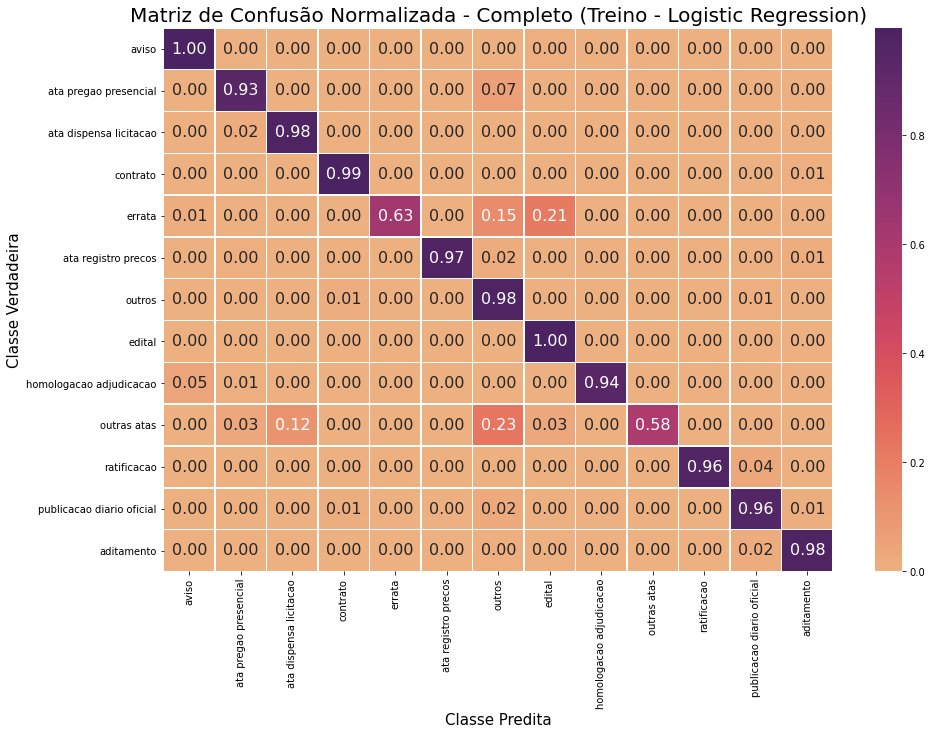


Validation set score:  0.10973451327433628
Validação - Logistic Regression:
________________________________________________________________________________
F1_score macro: 0.015212857318120474
F1_score weighted: 0.021701881413106375
Accuracy: 0.10973451327433628
________________________________________________________________________________


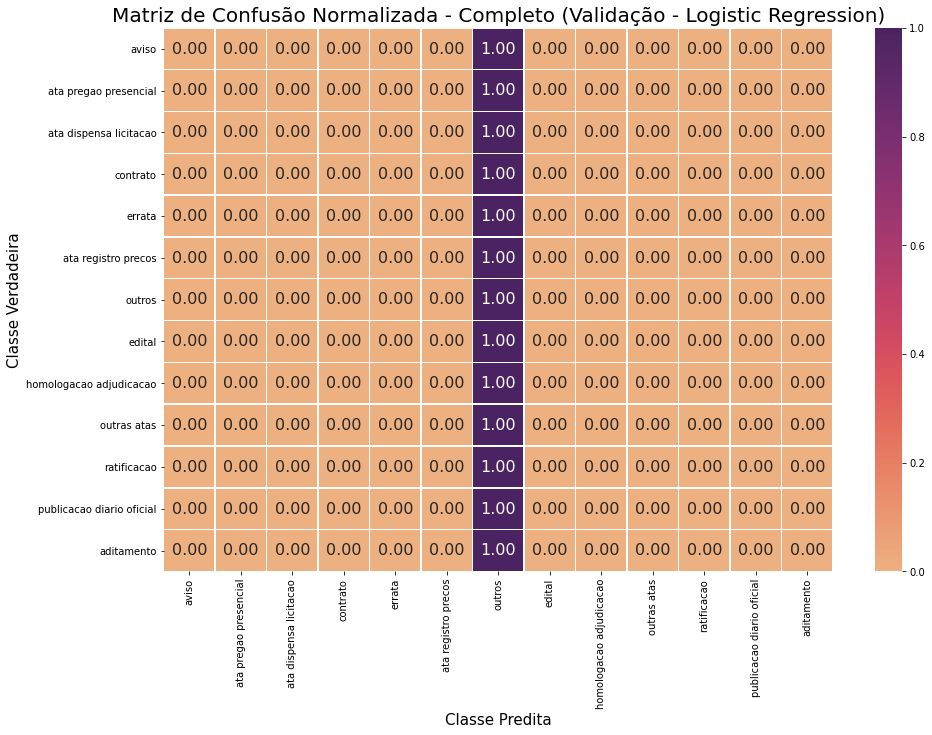


Test set score:  0.11130742049469965
Teste - Logistic Regression:
________________________________________________________________________________
F1_score macro: 0.015409074232603645
F1_score weighted: 0.022296875965551917
Accuracy: 0.11130742049469965
________________________________________________________________________________


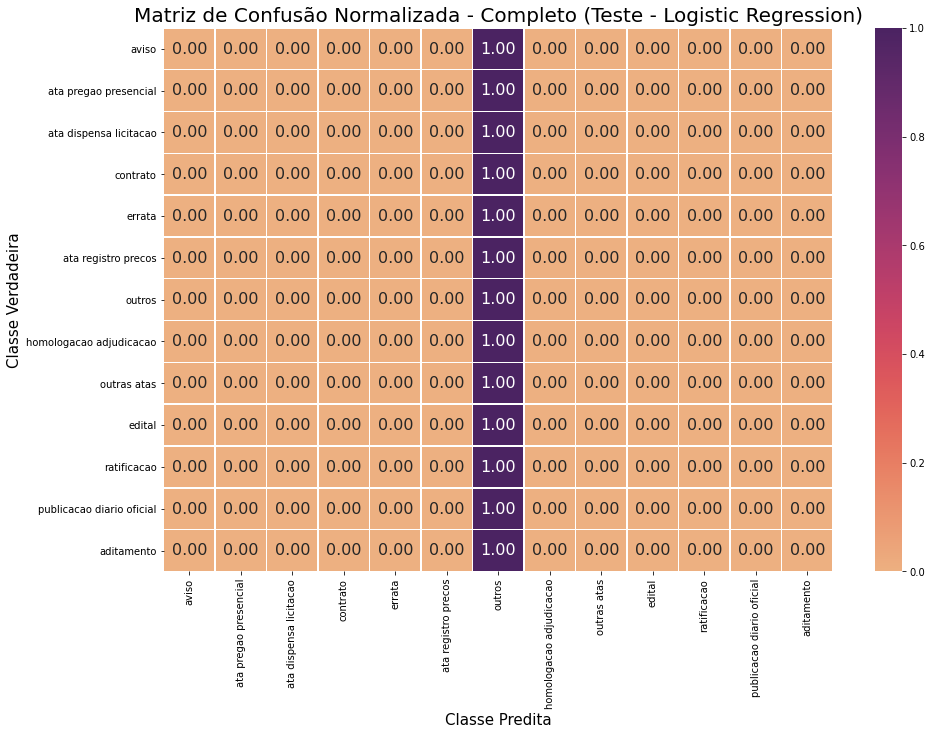

In [44]:
# Logistic Regression
clf = LogisticRegression(random_state=0).fit(tf_idf_train,y_train.values.ravel())
score_clf = clf.score(tf_idf_train, y_train.values.ravel())
print("\nTrain set score: ", score_clf)
y_pred = clf.predict(tf_idf_train)
evaluation_models(y_train, y_pred, "Treino - Logistic Regression")

score_val_clf = clf.score(tf_idf_val_final, y_val.values.ravel())
print("\nValidation set score: ", score_val_clf)
y_pred_val = clf.predict(tf_idf_val_final)
evaluation_models(y_val, y_pred_val, "Validação - Logistic Regression")

score_test_clf = clf.score(tf_idf_test_final, y_test.values.ravel())
print("\nTest set score: ", score_test_clf)
y_pred_test = clf.predict(tf_idf_test_final)
evaluation_models(y_test, y_pred_test, "Teste - Logistic Regression")